In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset
from sklearn.model_selection import KFold
from torch.utils.data.sampler import WeightedRandomSampler
from learning_tool import *
import sys
sys.path.append('..')

from model.model import *

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from tqdm.notebook import tqdm
from IPython.display import display
from sklearn.model_selection import train_test_split

In [3]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

In [4]:
# デバイスの割り当て

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# device = torch.device('cpu')

cuda:0


In [5]:
# PyTorch乱数固定用

def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True
    
# 乱数初期化
torch_seed()

In [6]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, df, features, labels):
        self.features_values = df[features].values
        self.labels = df[labels].values
        
    # len()を使用すると呼ばれる
    def __len__(self):
        return len(self.features_values)

    # 要素を参照すると呼ばれる関数    
    def __getitem__(self, idx):
        features_x = torch.LongTensor(self.features_values[idx])
        labels = torch.as_tensor(self.labels[idx])
        return features_x, labels

In [7]:
# 出力次元数
# 分類先クラス数　今回は2になる
n_output = 2

# 隠れ層のノード数
n_hidden = 100

# 結果確認
print(f'n_hidden: {n_hidden} n_output: {n_output}')

n_hidden: 100 n_output: 2


In [8]:
net = CNN(n_output, n_hidden).to(device)
print(net)

CNN(
  (relu): ReLU(inplace=True)
  (embedding): Embedding(2001, 128)
  (conv1): Conv2d(1, 128, kernel_size=(3, 128), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=(1998, 1), stride=(1998, 1), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(1, 128, kernel_size=(4, 128), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=(1997, 1), stride=(1997, 1), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(1, 128, kernel_size=(5, 128), stride=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=(1996, 1), stride=(1996, 1), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=384, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (features1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 128), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(1998, 1), stride=(1998, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (features2): Sequential(
    (0): Conv2d(1, 128, kernel_

In [9]:
def make_weighted_random_sampler(train_set):
    numDataPoints = len(train_set)
    data_dim = len(train_set[0][0])

    data = torch.FloatTensor(numDataPoints, data_dim)
    target = np.zeros(0)
    target = (np.hstack(data[1].numpy() for data in train_set))
    # target
    # print(target)
    print ('target train 0/1: {}/{}'.format(
        len(np.where(target == 0)[0]), len(np.where(target == 1)[0])))

    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])

    samples_weight = torch.from_numpy(samples_weight)
    samples_weight = samples_weight.double()
    # print(samples_weight)
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)
    return sampler

In [10]:
def make_dataset(filename):
    df = pd.read_csv(filename, index_col=0)
    columns = df.columns.values
    features_columns = columns[:-1]
    labels_column = columns[-1]
    dataset = MyDataset(df, features_columns, labels_column)
    return dataset

In [11]:
def record_history(df, filename, seed, each_history, num_splits):
    # print(df)
    score_type = ['train_loss','train_acc','test_loss','test_acc','auc_score']
    for num_kf in range(num_splits):
        for i in range(5):
            tmp_list = list(each_history[num_kf,:,i+1])
            tmp_list[:0] = [filename, seed, num_kf+1, score_type[i]]
            # print(tmp_list)
            df.loc[len(df)] = tmp_list
    # print(df)

In [12]:
# 学習率
lr = 0.0001

# 繰り返し回数
num_epochs = 50

# 評価結果記録用
cv_history = np.zeros((0,6))

batch_size = 66
num_splits = 10

columns_list = [i for i in range(1,num_epochs+1)]
columns_list[:0] = ['filename','seed', 'num_kf', 'score_type']
columns_list
df = pd.DataFrame(columns=columns_list)

for i in range(0,1):
    filename = 'txt_vec_and_label_camel_'+str(i)+'.csv'
    copy_df = df.copy()
    path = '../resource/' + filename
    dataset = make_dataset(path)
    print(filename)
    
    random_seed_list = [100,101,102,103,104,105,106,107,108,109,110]
    # random_seed_list = [100]
    # random_seed_list = [102,103,104,105,106,107,108,109]
    
    for seed in random_seed_list:
        print(seed)
        kf = KFold(n_splits=num_splits, shuffle=True, random_state=seed)
        cv_cnt = 0
        torch_seed(seed)
        each_history = np.zeros((0,num_epochs,6))

        for train_index, test_index in kf.split(dataset):
            cv_cnt += 1
            print(f'cv: {cv_cnt}')
            history = np.zeros((0,6))
            train_dataset = Subset(dataset, train_index)
            sampler = make_weighted_random_sampler(train_dataset)
            train_loader = DataLoader(train_dataset, batch_size, sampler=sampler, num_workers=2)
            test_dataset   = Subset(dataset, test_index)
            test_loader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=2)
            
            # モデルインスタンス生成
            net = CNN(n_output, n_hidden).to(device)
            # if torch.cuda.device_count() > 1:
            #   print("use", torch.cuda.device_count(), "GPUs")
            #   net = nn.DataParallel(net)
            
            # 最適化関数: 勾配降下法
            optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0.001)
            # optimizer = torch.optim.SGD(net.parameters(), lr=lr)
            # 損失関数： 交差エントロピー関数
            criterion = nn.CrossEntropyLoss()

            #学習
            history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history, test_dataset)

            #1交差ごとの記録
            each_history = np.vstack((each_history, [history]))
            
        record_history(copy_df, filename, seed, each_history, num_splits)
        print(copy_df)
    copy_df.to_csv('../result/threshold_2000_epoch_50_cv_10_weighted_random_2_camel_'+str(i)+'.csv', mode='w',index=False)

txt_vec_and_label_camel_10.csv
102
cv: 1
target train 0/1: 14698/8627


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.70279 acc: 0.62397 val_loss: 0.59284, val_acc: 0.68056, auc_score: 0.76261


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64499 acc: 0.65505 val_loss: 0.57559, val_acc: 0.69329, auc_score: 0.76625


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.60840 acc: 0.67747 val_loss: 0.56954, val_acc: 0.70139, auc_score: 0.76723


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.58851 acc: 0.69230 val_loss: 0.58573, val_acc: 0.68673, auc_score: 0.76799


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57734 acc: 0.69698 val_loss: 0.56803, val_acc: 0.71065, auc_score: 0.76971


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57347 acc: 0.69856 val_loss: 0.56043, val_acc: 0.71759, auc_score: 0.77162


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56201 acc: 0.71430 val_loss: 0.56308, val_acc: 0.71798, auc_score: 0.77243


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55769 acc: 0.71516 val_loss: 0.55966, val_acc: 0.72106, auc_score: 0.77449


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55469 acc: 0.71648 val_loss: 0.56354, val_acc: 0.71875, auc_score: 0.77606


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55164 acc: 0.71537 val_loss: 0.56886, val_acc: 0.70795, auc_score: 0.77756


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54449 acc: 0.72163 val_loss: 0.54830, val_acc: 0.72994, auc_score: 0.77932


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54627 acc: 0.72090 val_loss: 0.55374, val_acc: 0.72647, auc_score: 0.78064


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53453 acc: 0.72875 val_loss: 0.55021, val_acc: 0.72840, auc_score: 0.78314


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53016 acc: 0.73393 val_loss: 0.57255, val_acc: 0.70525, auc_score: 0.78497


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.52650 acc: 0.73642 val_loss: 0.55136, val_acc: 0.72685, auc_score: 0.78537


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.51948 acc: 0.74337 val_loss: 0.56009, val_acc: 0.71528, auc_score: 0.78690


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52211 acc: 0.73934 val_loss: 0.54696, val_acc: 0.72955, auc_score: 0.78817


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51905 acc: 0.74092 val_loss: 0.54840, val_acc: 0.72840, auc_score: 0.78882


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51127 acc: 0.74740 val_loss: 0.55290, val_acc: 0.72917, auc_score: 0.78996


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.50867 acc: 0.74907 val_loss: 0.55182, val_acc: 0.72454, auc_score: 0.79070


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50276 acc: 0.75447 val_loss: 0.55601, val_acc: 0.72029, auc_score: 0.79146


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50381 acc: 0.75417 val_loss: 0.54280, val_acc: 0.72917, auc_score: 0.79186


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50112 acc: 0.75507 val_loss: 0.56381, val_acc: 0.71142, auc_score: 0.79312


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49244 acc: 0.75820 val_loss: 0.55257, val_acc: 0.72377, auc_score: 0.79238


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49546 acc: 0.75923 val_loss: 0.55681, val_acc: 0.71644, auc_score: 0.79343


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.48387 acc: 0.76922 val_loss: 0.53923, val_acc: 0.73225, auc_score: 0.79402


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48693 acc: 0.76725 val_loss: 0.56707, val_acc: 0.70910, auc_score: 0.79491


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.47623 acc: 0.77561 val_loss: 0.54735, val_acc: 0.73032, auc_score: 0.79486


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.46984 acc: 0.78058 val_loss: 0.53683, val_acc: 0.73611, auc_score: 0.79491


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47145 acc: 0.77608 val_loss: 0.54062, val_acc: 0.73187, auc_score: 0.79572


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.46649 acc: 0.78461 val_loss: 0.54160, val_acc: 0.73418, auc_score: 0.79580


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.46178 acc: 0.78611 val_loss: 0.53520, val_acc: 0.73418, auc_score: 0.79658


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46215 acc: 0.78628 val_loss: 0.53876, val_acc: 0.73457, auc_score: 0.79556


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.45909 acc: 0.78872 val_loss: 0.55434, val_acc: 0.72338, auc_score: 0.79711


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.45812 acc: 0.78722 val_loss: 0.53336, val_acc: 0.74035, auc_score: 0.79722


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45572 acc: 0.79100 val_loss: 0.55286, val_acc: 0.72299, auc_score: 0.79765


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.44964 acc: 0.79391 val_loss: 0.55344, val_acc: 0.72608, auc_score: 0.79757


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.44575 acc: 0.79464 val_loss: 0.53193, val_acc: 0.73958, auc_score: 0.79838


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44425 acc: 0.79807 val_loss: 0.54808, val_acc: 0.72994, auc_score: 0.79792


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44009 acc: 0.80257 val_loss: 0.53416, val_acc: 0.73920, auc_score: 0.79919


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.43947 acc: 0.80159 val_loss: 0.53499, val_acc: 0.74151, auc_score: 0.79862


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.43780 acc: 0.80266 val_loss: 0.54106, val_acc: 0.73302, auc_score: 0.79840


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43390 acc: 0.80574 val_loss: 0.54686, val_acc: 0.72724, auc_score: 0.80052


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.42826 acc: 0.80832 val_loss: 0.53038, val_acc: 0.74306, auc_score: 0.79900


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.42968 acc: 0.81290 val_loss: 0.55404, val_acc: 0.72338, auc_score: 0.79801


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.42846 acc: 0.80977 val_loss: 0.53813, val_acc: 0.73264, auc_score: 0.79976


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.42590 acc: 0.81286 val_loss: 0.53838, val_acc: 0.73032, auc_score: 0.79840


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.41962 acc: 0.81659 val_loss: 0.55214, val_acc: 0.72647, auc_score: 0.79735


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42444 acc: 0.81158 val_loss: 0.53106, val_acc: 0.73997, auc_score: 0.79887


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42005 acc: 0.81921 val_loss: 0.53712, val_acc: 0.73958, auc_score: 0.79747
cv: 2
target train 0/1: 14726/8599


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.73050 acc: 0.61188 val_loss: 0.60264, val_acc: 0.66860, auc_score: 0.75448


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64876 acc: 0.65749 val_loss: 0.58248, val_acc: 0.69097, auc_score: 0.76138


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61436 acc: 0.68086 val_loss: 0.55593, val_acc: 0.71451, auc_score: 0.76436


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59513 acc: 0.68797 val_loss: 0.59422, val_acc: 0.67631, auc_score: 0.76648


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57955 acc: 0.69218 val_loss: 0.59110, val_acc: 0.67670, auc_score: 0.76856


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57352 acc: 0.69998 val_loss: 0.56773, val_acc: 0.70602, auc_score: 0.76979


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56315 acc: 0.71023 val_loss: 0.54525, val_acc: 0.72840, auc_score: 0.77252


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56107 acc: 0.71091 val_loss: 0.58103, val_acc: 0.69059, auc_score: 0.77362


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.54604 acc: 0.72296 val_loss: 0.55303, val_acc: 0.71373, auc_score: 0.77654


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55106 acc: 0.71708 val_loss: 0.55163, val_acc: 0.71682, auc_score: 0.77696


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54361 acc: 0.72317 val_loss: 0.56671, val_acc: 0.70525, auc_score: 0.77920


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54416 acc: 0.72313 val_loss: 0.54836, val_acc: 0.72492, auc_score: 0.78124


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.54506 acc: 0.72141 val_loss: 0.56361, val_acc: 0.70756, auc_score: 0.78252


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53647 acc: 0.72977 val_loss: 0.56127, val_acc: 0.71181, auc_score: 0.78357


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53634 acc: 0.72909 val_loss: 0.56177, val_acc: 0.71528, auc_score: 0.78493


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52737 acc: 0.73826 val_loss: 0.54525, val_acc: 0.72685, auc_score: 0.78500


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52175 acc: 0.73899 val_loss: 0.55128, val_acc: 0.72068, auc_score: 0.78678


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51755 acc: 0.74444 val_loss: 0.54058, val_acc: 0.72801, auc_score: 0.78797


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51725 acc: 0.74139 val_loss: 0.57056, val_acc: 0.70139, auc_score: 0.78715


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51231 acc: 0.74795 val_loss: 0.55088, val_acc: 0.72338, auc_score: 0.78722


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.51000 acc: 0.74620 val_loss: 0.55337, val_acc: 0.72145, auc_score: 0.78783


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50048 acc: 0.75661 val_loss: 0.55761, val_acc: 0.71412, auc_score: 0.78887


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50148 acc: 0.75571 val_loss: 0.54418, val_acc: 0.73110, auc_score: 0.79059


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49822 acc: 0.75717 val_loss: 0.55410, val_acc: 0.71682, auc_score: 0.79079


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49604 acc: 0.75949 val_loss: 0.55778, val_acc: 0.71412, auc_score: 0.79051


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49185 acc: 0.76386 val_loss: 0.55128, val_acc: 0.72261, auc_score: 0.79080


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48690 acc: 0.76360 val_loss: 0.54833, val_acc: 0.72415, auc_score: 0.79094


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48456 acc: 0.76737 val_loss: 0.55772, val_acc: 0.71065, auc_score: 0.79151


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48415 acc: 0.76909 val_loss: 0.54476, val_acc: 0.72454, auc_score: 0.79151


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.48072 acc: 0.76870 val_loss: 0.53977, val_acc: 0.73071, auc_score: 0.79320


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47910 acc: 0.76857 val_loss: 0.54642, val_acc: 0.72454, auc_score: 0.79284


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47378 acc: 0.77419 val_loss: 0.53808, val_acc: 0.72685, auc_score: 0.79278


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46828 acc: 0.78251 val_loss: 0.54673, val_acc: 0.72184, auc_score: 0.79285


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46490 acc: 0.78302 val_loss: 0.53004, val_acc: 0.73881, auc_score: 0.79382


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.45768 acc: 0.78898 val_loss: 0.55380, val_acc: 0.72222, auc_score: 0.79472


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45585 acc: 0.78834 val_loss: 0.54008, val_acc: 0.72261, auc_score: 0.79327


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45335 acc: 0.79108 val_loss: 0.55683, val_acc: 0.71566, auc_score: 0.79415


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45119 acc: 0.79451 val_loss: 0.53422, val_acc: 0.73341, auc_score: 0.79588


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44897 acc: 0.79443 val_loss: 0.54526, val_acc: 0.72569, auc_score: 0.79595


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44514 acc: 0.79768 val_loss: 0.54208, val_acc: 0.72801, auc_score: 0.79465


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44587 acc: 0.79593 val_loss: 0.53337, val_acc: 0.73611, auc_score: 0.79460


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44058 acc: 0.79884 val_loss: 0.53941, val_acc: 0.72878, auc_score: 0.79660


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44028 acc: 0.80004 val_loss: 0.54212, val_acc: 0.72608, auc_score: 0.79601


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43656 acc: 0.80262 val_loss: 0.54717, val_acc: 0.72454, auc_score: 0.79606


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43146 acc: 0.80849 val_loss: 0.53846, val_acc: 0.73611, auc_score: 0.79662


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43372 acc: 0.80815 val_loss: 0.54148, val_acc: 0.73148, auc_score: 0.79585


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.42943 acc: 0.80973 val_loss: 0.53507, val_acc: 0.73997, auc_score: 0.79500


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42637 acc: 0.81098 val_loss: 0.54325, val_acc: 0.73110, auc_score: 0.79596


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42661 acc: 0.81085 val_loss: 0.54058, val_acc: 0.73225, auc_score: 0.79587


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42458 acc: 0.81385 val_loss: 0.52973, val_acc: 0.73881, auc_score: 0.79503
cv: 3
target train 0/1: 14695/8630


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.72504 acc: 0.60759 val_loss: 0.58541, val_acc: 0.69444, auc_score: 0.76487


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64171 acc: 0.66144 val_loss: 0.56316, val_acc: 0.71181, auc_score: 0.77091


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61240 acc: 0.67404 val_loss: 0.55983, val_acc: 0.71489, auc_score: 0.77277


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59097 acc: 0.69239 val_loss: 0.58471, val_acc: 0.69560, auc_score: 0.77380


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58450 acc: 0.69350 val_loss: 0.58557, val_acc: 0.69676, auc_score: 0.77501


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57087 acc: 0.70255 val_loss: 0.54776, val_acc: 0.72492, auc_score: 0.77667


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56644 acc: 0.70718 val_loss: 0.55745, val_acc: 0.71721, auc_score: 0.77756


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55907 acc: 0.71198 val_loss: 0.55781, val_acc: 0.71451, auc_score: 0.77939


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55340 acc: 0.71683 val_loss: 0.57867, val_acc: 0.70177, auc_score: 0.78153


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55449 acc: 0.71567 val_loss: 0.56323, val_acc: 0.70949, auc_score: 0.78207


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54761 acc: 0.72317 val_loss: 0.56480, val_acc: 0.71103, auc_score: 0.78299


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.53896 acc: 0.72570 val_loss: 0.56387, val_acc: 0.71142, auc_score: 0.78516


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53931 acc: 0.72506 val_loss: 0.55190, val_acc: 0.72145, auc_score: 0.78624


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53553 acc: 0.72917 val_loss: 0.54424, val_acc: 0.72762, auc_score: 0.78786


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.52958 acc: 0.73282 val_loss: 0.54015, val_acc: 0.73225, auc_score: 0.78993


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52934 acc: 0.73368 val_loss: 0.55216, val_acc: 0.72492, auc_score: 0.78989


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52058 acc: 0.74182 val_loss: 0.54583, val_acc: 0.72415, auc_score: 0.79085


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52218 acc: 0.73865 val_loss: 0.53784, val_acc: 0.73302, auc_score: 0.79141


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51569 acc: 0.74397 val_loss: 0.54760, val_acc: 0.72762, auc_score: 0.79287


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51444 acc: 0.74688 val_loss: 0.54837, val_acc: 0.72569, auc_score: 0.79320


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.51036 acc: 0.75070 val_loss: 0.54631, val_acc: 0.72917, auc_score: 0.79600


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50537 acc: 0.75305 val_loss: 0.55095, val_acc: 0.72531, auc_score: 0.79671


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50232 acc: 0.75498 val_loss: 0.55232, val_acc: 0.72145, auc_score: 0.79617


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49732 acc: 0.75829 val_loss: 0.54359, val_acc: 0.73187, auc_score: 0.79734


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49372 acc: 0.76107 val_loss: 0.54399, val_acc: 0.73148, auc_score: 0.79863


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.48877 acc: 0.76570 val_loss: 0.54278, val_acc: 0.72955, auc_score: 0.79832


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48349 acc: 0.76857 val_loss: 0.54113, val_acc: 0.72955, auc_score: 0.79918


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48193 acc: 0.76742 val_loss: 0.53916, val_acc: 0.73110, auc_score: 0.79951


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48391 acc: 0.76875 val_loss: 0.54690, val_acc: 0.72145, auc_score: 0.80018


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47823 acc: 0.77355 val_loss: 0.53089, val_acc: 0.73727, auc_score: 0.80014


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47365 acc: 0.77852 val_loss: 0.54569, val_acc: 0.72685, auc_score: 0.80077


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47311 acc: 0.77423 val_loss: 0.53538, val_acc: 0.73341, auc_score: 0.79964


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.47236 acc: 0.77775 val_loss: 0.53092, val_acc: 0.74035, auc_score: 0.80147


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46041 acc: 0.78529 val_loss: 0.54406, val_acc: 0.72724, auc_score: 0.80246


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.45851 acc: 0.78830 val_loss: 0.53107, val_acc: 0.73727, auc_score: 0.80259


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45840 acc: 0.79031 val_loss: 0.52500, val_acc: 0.74306, auc_score: 0.80361


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.46037 acc: 0.78581 val_loss: 0.52876, val_acc: 0.73804, auc_score: 0.80295


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45025 acc: 0.79310 val_loss: 0.53318, val_acc: 0.73765, auc_score: 0.80343


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44600 acc: 0.79794 val_loss: 0.55169, val_acc: 0.71451, auc_score: 0.80276


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44477 acc: 0.79987 val_loss: 0.54218, val_acc: 0.72724, auc_score: 0.80405


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44402 acc: 0.79606 val_loss: 0.53149, val_acc: 0.73302, auc_score: 0.80412


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.43836 acc: 0.80695 val_loss: 0.53976, val_acc: 0.72801, auc_score: 0.80446


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43783 acc: 0.80266 val_loss: 0.52960, val_acc: 0.73187, auc_score: 0.80385


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43246 acc: 0.80785 val_loss: 0.52834, val_acc: 0.73457, auc_score: 0.80426


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43705 acc: 0.80660 val_loss: 0.54424, val_acc: 0.72299, auc_score: 0.80467


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43069 acc: 0.81016 val_loss: 0.53620, val_acc: 0.72724, auc_score: 0.80510


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.42468 acc: 0.81346 val_loss: 0.53791, val_acc: 0.72917, auc_score: 0.80476


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42976 acc: 0.80772 val_loss: 0.52373, val_acc: 0.73573, auc_score: 0.80514


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42616 acc: 0.81282 val_loss: 0.52730, val_acc: 0.73534, auc_score: 0.80473


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42731 acc: 0.81042 val_loss: 0.53915, val_acc: 0.73071, auc_score: 0.80542
cv: 4
target train 0/1: 14711/8614


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.72825 acc: 0.61003 val_loss: 0.55187, val_acc: 0.72338, auc_score: 0.77574


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64143 acc: 0.66105 val_loss: 0.53654, val_acc: 0.74113, auc_score: 0.77575


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61130 acc: 0.67747 val_loss: 0.55303, val_acc: 0.72029, auc_score: 0.77826


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.58986 acc: 0.68857 val_loss: 0.57417, val_acc: 0.70370, auc_score: 0.77945


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58184 acc: 0.69346 val_loss: 0.54096, val_acc: 0.72878, auc_score: 0.78012


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57510 acc: 0.69904 val_loss: 0.54315, val_acc: 0.72685, auc_score: 0.78240


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56645 acc: 0.70512 val_loss: 0.55488, val_acc: 0.71798, auc_score: 0.78500


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56331 acc: 0.70864 val_loss: 0.54951, val_acc: 0.72492, auc_score: 0.78540


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55282 acc: 0.71606 val_loss: 0.55816, val_acc: 0.72145, auc_score: 0.78795


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55241 acc: 0.71636 val_loss: 0.53685, val_acc: 0.73611, auc_score: 0.78819


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.55039 acc: 0.71777 val_loss: 0.53563, val_acc: 0.74074, auc_score: 0.79059


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54349 acc: 0.72322 val_loss: 0.55206, val_acc: 0.72608, auc_score: 0.79159


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53775 acc: 0.72866 val_loss: 0.53715, val_acc: 0.73341, auc_score: 0.79308


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53140 acc: 0.73175 val_loss: 0.54089, val_acc: 0.73881, auc_score: 0.79415


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.52736 acc: 0.73385 val_loss: 0.55137, val_acc: 0.72222, auc_score: 0.79500


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.53110 acc: 0.73432 val_loss: 0.53228, val_acc: 0.74306, auc_score: 0.79560


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52455 acc: 0.73998 val_loss: 0.52948, val_acc: 0.74228, auc_score: 0.79689


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51927 acc: 0.74259 val_loss: 0.52852, val_acc: 0.74383, auc_score: 0.79742


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51631 acc: 0.74474 val_loss: 0.52754, val_acc: 0.74769, auc_score: 0.79746


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.50900 acc: 0.75233 val_loss: 0.52844, val_acc: 0.73997, auc_score: 0.79873


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50864 acc: 0.75233 val_loss: 0.54499, val_acc: 0.72724, auc_score: 0.80026


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50282 acc: 0.75747 val_loss: 0.52183, val_acc: 0.74537, auc_score: 0.80026


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50366 acc: 0.75593 val_loss: 0.52964, val_acc: 0.73997, auc_score: 0.80128


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49891 acc: 0.75811 val_loss: 0.52564, val_acc: 0.74460, auc_score: 0.80204


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49669 acc: 0.75910 val_loss: 0.52804, val_acc: 0.74228, auc_score: 0.80235


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49558 acc: 0.76223 val_loss: 0.52751, val_acc: 0.74383, auc_score: 0.80344


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48829 acc: 0.76497 val_loss: 0.53753, val_acc: 0.73688, auc_score: 0.80498


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48435 acc: 0.76810 val_loss: 0.52685, val_acc: 0.74344, auc_score: 0.80487


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48354 acc: 0.76780 val_loss: 0.53496, val_acc: 0.73650, auc_score: 0.80665


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47942 acc: 0.77278 val_loss: 0.52265, val_acc: 0.74653, auc_score: 0.80655


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47611 acc: 0.77449 val_loss: 0.53973, val_acc: 0.73302, auc_score: 0.80766


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47076 acc: 0.77526 val_loss: 0.52320, val_acc: 0.74498, auc_score: 0.80840


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46876 acc: 0.77959 val_loss: 0.53063, val_acc: 0.73881, auc_score: 0.80897


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46981 acc: 0.77869 val_loss: 0.52531, val_acc: 0.74576, auc_score: 0.80832


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46586 acc: 0.78169 val_loss: 0.52872, val_acc: 0.73997, auc_score: 0.81002


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.46071 acc: 0.78559 val_loss: 0.51907, val_acc: 0.75000, auc_score: 0.80861


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45660 acc: 0.78744 val_loss: 0.52633, val_acc: 0.74190, auc_score: 0.80999


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45269 acc: 0.79207 val_loss: 0.53635, val_acc: 0.73071, auc_score: 0.80988


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44976 acc: 0.79237 val_loss: 0.51806, val_acc: 0.75116, auc_score: 0.80980


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44848 acc: 0.79443 val_loss: 0.52770, val_acc: 0.74306, auc_score: 0.81045


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44641 acc: 0.79820 val_loss: 0.51310, val_acc: 0.75772, auc_score: 0.80963


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.43933 acc: 0.80553 val_loss: 0.53454, val_acc: 0.73765, auc_score: 0.81034


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43948 acc: 0.80094 val_loss: 0.51850, val_acc: 0.75154, auc_score: 0.81147


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43450 acc: 0.80493 val_loss: 0.51811, val_acc: 0.74961, auc_score: 0.81149


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43598 acc: 0.80300 val_loss: 0.51897, val_acc: 0.74923, auc_score: 0.80976


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.42835 acc: 0.80952 val_loss: 0.52213, val_acc: 0.74691, auc_score: 0.80903


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.42393 acc: 0.81278 val_loss: 0.53693, val_acc: 0.73071, auc_score: 0.80968


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43111 acc: 0.80905 val_loss: 0.51596, val_acc: 0.75502, auc_score: 0.81061


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.43150 acc: 0.80802 val_loss: 0.52173, val_acc: 0.74691, auc_score: 0.81034


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.43196 acc: 0.80759 val_loss: 0.51592, val_acc: 0.75540, auc_score: 0.81159
cv: 5
target train 0/1: 14755/8570


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.72636 acc: 0.61033 val_loss: 0.58125, val_acc: 0.68943, auc_score: 0.76555


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64624 acc: 0.66298 val_loss: 0.60276, val_acc: 0.67515, auc_score: 0.76967


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61930 acc: 0.66967 val_loss: 0.55416, val_acc: 0.71836, auc_score: 0.77199


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59499 acc: 0.68412 val_loss: 0.59918, val_acc: 0.67785, auc_score: 0.77264


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.59075 acc: 0.68527 val_loss: 0.55818, val_acc: 0.71335, auc_score: 0.77323


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57365 acc: 0.70066 val_loss: 0.58367, val_acc: 0.68943, auc_score: 0.77728


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56431 acc: 0.70962 val_loss: 0.55776, val_acc: 0.71258, auc_score: 0.77736


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55905 acc: 0.71383 val_loss: 0.55971, val_acc: 0.70988, auc_score: 0.77906


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55491 acc: 0.71473 val_loss: 0.55717, val_acc: 0.71489, auc_score: 0.78029


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55129 acc: 0.71777 val_loss: 0.55085, val_acc: 0.71798, auc_score: 0.78070


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54754 acc: 0.71944 val_loss: 0.55167, val_acc: 0.71489, auc_score: 0.78239


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54320 acc: 0.72862 val_loss: 0.56051, val_acc: 0.71065, auc_score: 0.78383


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.54282 acc: 0.72390 val_loss: 0.56874, val_acc: 0.70370, auc_score: 0.78495


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53431 acc: 0.73158 val_loss: 0.56226, val_acc: 0.70795, auc_score: 0.78576


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53364 acc: 0.73278 val_loss: 0.55647, val_acc: 0.71181, auc_score: 0.78564


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52896 acc: 0.73526 val_loss: 0.54770, val_acc: 0.71914, auc_score: 0.78791


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52455 acc: 0.73835 val_loss: 0.55036, val_acc: 0.71721, auc_score: 0.78777


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52098 acc: 0.74375 val_loss: 0.55876, val_acc: 0.70910, auc_score: 0.78834


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51859 acc: 0.74645 val_loss: 0.53648, val_acc: 0.72569, auc_score: 0.79011


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.50977 acc: 0.75121 val_loss: 0.54781, val_acc: 0.71605, auc_score: 0.79124


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50690 acc: 0.75241 val_loss: 0.54577, val_acc: 0.71798, auc_score: 0.79166


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.49894 acc: 0.75481 val_loss: 0.54710, val_acc: 0.71451, auc_score: 0.79277


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50183 acc: 0.75713 val_loss: 0.54577, val_acc: 0.72145, auc_score: 0.79187


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49711 acc: 0.75798 val_loss: 0.53982, val_acc: 0.72261, auc_score: 0.79270


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.48647 acc: 0.76866 val_loss: 0.54869, val_acc: 0.71682, auc_score: 0.79302


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.48956 acc: 0.76527 val_loss: 0.54674, val_acc: 0.71528, auc_score: 0.79328


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48881 acc: 0.76626 val_loss: 0.53994, val_acc: 0.72647, auc_score: 0.79408


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.47584 acc: 0.77526 val_loss: 0.54403, val_acc: 0.72261, auc_score: 0.79544


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48162 acc: 0.77072 val_loss: 0.54472, val_acc: 0.72261, auc_score: 0.79579


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47274 acc: 0.77646 val_loss: 0.54427, val_acc: 0.72106, auc_score: 0.79591


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47324 acc: 0.77831 val_loss: 0.54146, val_acc: 0.72531, auc_score: 0.79622


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47215 acc: 0.77955 val_loss: 0.54525, val_acc: 0.71952, auc_score: 0.79898


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46176 acc: 0.78405 val_loss: 0.54026, val_acc: 0.72068, auc_score: 0.79723


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46259 acc: 0.78650 val_loss: 0.54848, val_acc: 0.72569, auc_score: 0.79776


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46185 acc: 0.78422 val_loss: 0.55221, val_acc: 0.71566, auc_score: 0.79794


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45881 acc: 0.79010 val_loss: 0.54417, val_acc: 0.72377, auc_score: 0.79645


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45563 acc: 0.79027 val_loss: 0.55053, val_acc: 0.72106, auc_score: 0.79639


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.44765 acc: 0.79786 val_loss: 0.54982, val_acc: 0.72106, auc_score: 0.79662


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44757 acc: 0.79524 val_loss: 0.55146, val_acc: 0.71991, auc_score: 0.79640


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44541 acc: 0.80030 val_loss: 0.53882, val_acc: 0.72454, auc_score: 0.79729


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44185 acc: 0.80077 val_loss: 0.53584, val_acc: 0.72608, auc_score: 0.79562


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.43767 acc: 0.80313 val_loss: 0.54486, val_acc: 0.72106, auc_score: 0.79528


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44154 acc: 0.80069 val_loss: 0.53754, val_acc: 0.72454, auc_score: 0.79603


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43262 acc: 0.80977 val_loss: 0.54702, val_acc: 0.71759, auc_score: 0.79666


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43370 acc: 0.80536 val_loss: 0.54470, val_acc: 0.72068, auc_score: 0.79579


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43247 acc: 0.80703 val_loss: 0.54667, val_acc: 0.71952, auc_score: 0.79555


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.42523 acc: 0.81415 val_loss: 0.54982, val_acc: 0.72145, auc_score: 0.79588


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42628 acc: 0.81200 val_loss: 0.54915, val_acc: 0.71759, auc_score: 0.79662


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.43087 acc: 0.80930 val_loss: 0.54244, val_acc: 0.72415, auc_score: 0.79590


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42282 acc: 0.81436 val_loss: 0.53787, val_acc: 0.72762, auc_score: 0.79650
cv: 6
target train 0/1: 14700/8625


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.72554 acc: 0.61205 val_loss: 0.55853, val_acc: 0.71644, auc_score: 0.77198


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64874 acc: 0.65462 val_loss: 0.56515, val_acc: 0.71258, auc_score: 0.77658


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61540 acc: 0.67447 val_loss: 0.58112, val_acc: 0.69213, auc_score: 0.77884


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59610 acc: 0.68296 val_loss: 0.55369, val_acc: 0.72569, auc_score: 0.77980


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57884 acc: 0.69985 val_loss: 0.55134, val_acc: 0.72068, auc_score: 0.78271


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57744 acc: 0.69723 val_loss: 0.55088, val_acc: 0.72724, auc_score: 0.78447


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56181 acc: 0.70872 val_loss: 0.57332, val_acc: 0.70332, auc_score: 0.78607


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56332 acc: 0.70877 val_loss: 0.53993, val_acc: 0.73457, auc_score: 0.78717


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55050 acc: 0.72060 val_loss: 0.54649, val_acc: 0.72840, auc_score: 0.78866


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.54942 acc: 0.71983 val_loss: 0.53112, val_acc: 0.74151, auc_score: 0.78944


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54294 acc: 0.72737 val_loss: 0.54892, val_acc: 0.72029, auc_score: 0.79216


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54264 acc: 0.72073 val_loss: 0.53634, val_acc: 0.73302, auc_score: 0.79351


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.54412 acc: 0.72274 val_loss: 0.55544, val_acc: 0.72029, auc_score: 0.79287


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53964 acc: 0.72583 val_loss: 0.54119, val_acc: 0.73187, auc_score: 0.79364


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.52998 acc: 0.73552 val_loss: 0.53904, val_acc: 0.73341, auc_score: 0.79443


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52854 acc: 0.73603 val_loss: 0.53817, val_acc: 0.73765, auc_score: 0.79570


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52417 acc: 0.73723 val_loss: 0.54798, val_acc: 0.72261, auc_score: 0.79694


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51958 acc: 0.74465 val_loss: 0.54088, val_acc: 0.72917, auc_score: 0.79585


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51278 acc: 0.74847 val_loss: 0.53664, val_acc: 0.72994, auc_score: 0.79668


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.52035 acc: 0.74427 val_loss: 0.53830, val_acc: 0.73650, auc_score: 0.79739


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50677 acc: 0.75288 val_loss: 0.54167, val_acc: 0.72994, auc_score: 0.79803


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50542 acc: 0.75301 val_loss: 0.53451, val_acc: 0.73650, auc_score: 0.79805


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50107 acc: 0.75803 val_loss: 0.53625, val_acc: 0.73302, auc_score: 0.79795


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49733 acc: 0.76244 val_loss: 0.54843, val_acc: 0.72454, auc_score: 0.79942


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49675 acc: 0.75970 val_loss: 0.52806, val_acc: 0.73881, auc_score: 0.79894


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49604 acc: 0.76039 val_loss: 0.53721, val_acc: 0.73187, auc_score: 0.80058


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48729 acc: 0.76703 val_loss: 0.53968, val_acc: 0.72878, auc_score: 0.80114


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48195 acc: 0.77003 val_loss: 0.55289, val_acc: 0.71566, auc_score: 0.80054


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48623 acc: 0.76583 val_loss: 0.54346, val_acc: 0.72222, auc_score: 0.80154


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47800 acc: 0.77145 val_loss: 0.53305, val_acc: 0.73688, auc_score: 0.80164


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47913 acc: 0.77093 val_loss: 0.54159, val_acc: 0.72955, auc_score: 0.80360


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47011 acc: 0.78311 val_loss: 0.54034, val_acc: 0.72647, auc_score: 0.80465


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46907 acc: 0.78178 val_loss: 0.53985, val_acc: 0.72685, auc_score: 0.80389


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46753 acc: 0.78024 val_loss: 0.53673, val_acc: 0.73302, auc_score: 0.80295


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46150 acc: 0.78598 val_loss: 0.52809, val_acc: 0.74190, auc_score: 0.80468


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45442 acc: 0.79263 val_loss: 0.53655, val_acc: 0.72878, auc_score: 0.80420


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45843 acc: 0.78718 val_loss: 0.53563, val_acc: 0.73534, auc_score: 0.80560


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45317 acc: 0.78997 val_loss: 0.52399, val_acc: 0.74306, auc_score: 0.80524


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44505 acc: 0.79829 val_loss: 0.52435, val_acc: 0.74151, auc_score: 0.80543


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44723 acc: 0.79704 val_loss: 0.52934, val_acc: 0.73843, auc_score: 0.80359


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44561 acc: 0.80073 val_loss: 0.52835, val_acc: 0.73727, auc_score: 0.80311


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44470 acc: 0.80026 val_loss: 0.54725, val_acc: 0.72531, auc_score: 0.80260


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44184 acc: 0.80034 val_loss: 0.53990, val_acc: 0.72917, auc_score: 0.80285


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.44112 acc: 0.80253 val_loss: 0.54075, val_acc: 0.72840, auc_score: 0.80256


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43423 acc: 0.80574 val_loss: 0.53086, val_acc: 0.73958, auc_score: 0.80426


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43676 acc: 0.80643 val_loss: 0.54382, val_acc: 0.72994, auc_score: 0.80354


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43296 acc: 0.80956 val_loss: 0.53337, val_acc: 0.73804, auc_score: 0.80300


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43298 acc: 0.80973 val_loss: 0.52330, val_acc: 0.74344, auc_score: 0.80416


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42141 acc: 0.81471 val_loss: 0.52623, val_acc: 0.74460, auc_score: 0.80277


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42655 acc: 0.81406 val_loss: 0.52262, val_acc: 0.74691, auc_score: 0.80189
cv: 7
target train 0/1: 14684/8641


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.72318 acc: 0.61025 val_loss: 0.54939, val_acc: 0.73032, auc_score: 0.77528


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64894 acc: 0.65629 val_loss: 0.54824, val_acc: 0.73071, auc_score: 0.77788


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61359 acc: 0.67284 val_loss: 0.55422, val_acc: 0.72415, auc_score: 0.77884


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59782 acc: 0.68532 val_loss: 0.55005, val_acc: 0.72994, auc_score: 0.78003


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58538 acc: 0.69059 val_loss: 0.54179, val_acc: 0.73765, auc_score: 0.78069


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57911 acc: 0.69385 val_loss: 0.55815, val_acc: 0.72222, auc_score: 0.78073


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56236 acc: 0.70954 val_loss: 0.54194, val_acc: 0.73997, auc_score: 0.78240


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56256 acc: 0.71031 val_loss: 0.57239, val_acc: 0.69985, auc_score: 0.78451


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55740 acc: 0.71305 val_loss: 0.54560, val_acc: 0.73110, auc_score: 0.78494


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55418 acc: 0.71713 val_loss: 0.55829, val_acc: 0.71605, auc_score: 0.78594


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54874 acc: 0.72300 val_loss: 0.54431, val_acc: 0.72955, auc_score: 0.78717


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54095 acc: 0.72986 val_loss: 0.53104, val_acc: 0.74421, auc_score: 0.78852


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.54351 acc: 0.72467 val_loss: 0.56683, val_acc: 0.70640, auc_score: 0.79023


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53372 acc: 0.73119 val_loss: 0.54559, val_acc: 0.72569, auc_score: 0.79116


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53092 acc: 0.73299 val_loss: 0.54395, val_acc: 0.72647, auc_score: 0.79183


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52704 acc: 0.73779 val_loss: 0.53159, val_acc: 0.74151, auc_score: 0.79256


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52498 acc: 0.73556 val_loss: 0.54896, val_acc: 0.72377, auc_score: 0.79449


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51722 acc: 0.74238 val_loss: 0.53086, val_acc: 0.74113, auc_score: 0.79474


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51602 acc: 0.74667 val_loss: 0.53935, val_acc: 0.72994, auc_score: 0.79417


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51007 acc: 0.75220 val_loss: 0.53751, val_acc: 0.73225, auc_score: 0.79421


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.51044 acc: 0.75070 val_loss: 0.55125, val_acc: 0.71605, auc_score: 0.79513


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50600 acc: 0.75421 val_loss: 0.52306, val_acc: 0.74460, auc_score: 0.79522


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50057 acc: 0.75773 val_loss: 0.53871, val_acc: 0.72762, auc_score: 0.79690


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49998 acc: 0.75451 val_loss: 0.54565, val_acc: 0.71914, auc_score: 0.79650


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49520 acc: 0.76047 val_loss: 0.55543, val_acc: 0.71142, auc_score: 0.79649


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49462 acc: 0.76021 val_loss: 0.53352, val_acc: 0.73457, auc_score: 0.79817


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48696 acc: 0.76489 val_loss: 0.54020, val_acc: 0.73148, auc_score: 0.79764


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48502 acc: 0.76857 val_loss: 0.53533, val_acc: 0.72878, auc_score: 0.79756


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48991 acc: 0.76605 val_loss: 0.53198, val_acc: 0.73881, auc_score: 0.79767


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47827 acc: 0.76947 val_loss: 0.53131, val_acc: 0.73534, auc_score: 0.79797


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47650 acc: 0.77423 val_loss: 0.51957, val_acc: 0.74383, auc_score: 0.79917


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47293 acc: 0.77886 val_loss: 0.52117, val_acc: 0.74151, auc_score: 0.79841


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.47199 acc: 0.77912 val_loss: 0.53772, val_acc: 0.72994, auc_score: 0.79903


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46876 acc: 0.77925 val_loss: 0.53909, val_acc: 0.72685, auc_score: 0.79944


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46461 acc: 0.78405 val_loss: 0.54064, val_acc: 0.72685, auc_score: 0.79860


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.46031 acc: 0.78701 val_loss: 0.54563, val_acc: 0.72531, auc_score: 0.79927


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45650 acc: 0.79074 val_loss: 0.53215, val_acc: 0.73225, auc_score: 0.79963


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45316 acc: 0.79250 val_loss: 0.53237, val_acc: 0.73380, auc_score: 0.79972


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.45556 acc: 0.79074 val_loss: 0.54433, val_acc: 0.72840, auc_score: 0.79973


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.45411 acc: 0.79203 val_loss: 0.53246, val_acc: 0.73765, auc_score: 0.79954


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44995 acc: 0.79584 val_loss: 0.53267, val_acc: 0.73302, auc_score: 0.80012


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44439 acc: 0.79558 val_loss: 0.53217, val_acc: 0.73418, auc_score: 0.80211


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44462 acc: 0.79953 val_loss: 0.52570, val_acc: 0.73650, auc_score: 0.80023


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.44096 acc: 0.80206 val_loss: 0.52578, val_acc: 0.74113, auc_score: 0.80183


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43394 acc: 0.80476 val_loss: 0.52292, val_acc: 0.74306, auc_score: 0.80214


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43558 acc: 0.80669 val_loss: 0.53006, val_acc: 0.74113, auc_score: 0.80176


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43044 acc: 0.80973 val_loss: 0.52801, val_acc: 0.74460, auc_score: 0.80206


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42984 acc: 0.80827 val_loss: 0.53326, val_acc: 0.73881, auc_score: 0.80344


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.43065 acc: 0.80965 val_loss: 0.53245, val_acc: 0.74113, auc_score: 0.80335


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42348 acc: 0.81072 val_loss: 0.53838, val_acc: 0.73611, auc_score: 0.80385
cv: 8
target train 0/1: 14675/8651


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.74205 acc: 0.61592 val_loss: 0.60810, val_acc: 0.67271, auc_score: 0.76373


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.65816 acc: 0.65129 val_loss: 0.56528, val_acc: 0.70668, auc_score: 0.76748


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61828 acc: 0.67350 val_loss: 0.56355, val_acc: 0.71015, auc_score: 0.77061


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59058 acc: 0.69197 val_loss: 0.56248, val_acc: 0.71594, auc_score: 0.77052


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57858 acc: 0.69948 val_loss: 0.57155, val_acc: 0.70976, auc_score: 0.77109


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57288 acc: 0.70192 val_loss: 0.54710, val_acc: 0.72597, auc_score: 0.77297


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56411 acc: 0.70882 val_loss: 0.55299, val_acc: 0.72327, auc_score: 0.77464


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56943 acc: 0.70599 val_loss: 0.54901, val_acc: 0.72752, auc_score: 0.77617


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55133 acc: 0.71813 val_loss: 0.54345, val_acc: 0.73099, auc_score: 0.77725


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.54853 acc: 0.72126 val_loss: 0.57324, val_acc: 0.70938, auc_score: 0.77788


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54915 acc: 0.71924 val_loss: 0.57948, val_acc: 0.70591, auc_score: 0.77958


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54696 acc: 0.72250 val_loss: 0.56201, val_acc: 0.71787, auc_score: 0.78066


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53449 acc: 0.73253 val_loss: 0.55441, val_acc: 0.72327, auc_score: 0.78258


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.52996 acc: 0.73455 val_loss: 0.53930, val_acc: 0.72829, auc_score: 0.78244


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53005 acc: 0.73339 val_loss: 0.54968, val_acc: 0.72675, auc_score: 0.78450


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52661 acc: 0.73502 val_loss: 0.57068, val_acc: 0.71054, auc_score: 0.78595


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52251 acc: 0.74153 val_loss: 0.53563, val_acc: 0.73176, auc_score: 0.78632


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52091 acc: 0.73986 val_loss: 0.53695, val_acc: 0.73331, auc_score: 0.78677


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51251 acc: 0.74488 val_loss: 0.55190, val_acc: 0.72289, auc_score: 0.78752


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.50843 acc: 0.75066 val_loss: 0.55807, val_acc: 0.72019, auc_score: 0.78757


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50480 acc: 0.75105 val_loss: 0.55565, val_acc: 0.72443, auc_score: 0.78876


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50628 acc: 0.75212 val_loss: 0.54127, val_acc: 0.73176, auc_score: 0.78916


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.49623 acc: 0.76052 val_loss: 0.54082, val_acc: 0.72983, auc_score: 0.78975


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49785 acc: 0.75624 val_loss: 0.55239, val_acc: 0.71594, auc_score: 0.79002


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49517 acc: 0.75971 val_loss: 0.54199, val_acc: 0.72636, auc_score: 0.79161


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.48936 acc: 0.76464 val_loss: 0.54669, val_acc: 0.72173, auc_score: 0.79091


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48582 acc: 0.76687 val_loss: 0.56475, val_acc: 0.71092, auc_score: 0.79194


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.47615 acc: 0.77502 val_loss: 0.53347, val_acc: 0.72945, auc_score: 0.79186


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.47997 acc: 0.77343 val_loss: 0.54464, val_acc: 0.72327, auc_score: 0.79238


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47627 acc: 0.77643 val_loss: 0.53790, val_acc: 0.72482, auc_score: 0.79167


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47157 acc: 0.77523 val_loss: 0.55401, val_acc: 0.72173, auc_score: 0.79189


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.46505 acc: 0.78333 val_loss: 0.55390, val_acc: 0.72173, auc_score: 0.79283


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46478 acc: 0.78389 val_loss: 0.55548, val_acc: 0.71594, auc_score: 0.79351


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46277 acc: 0.78676 val_loss: 0.54841, val_acc: 0.72366, auc_score: 0.79382


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46317 acc: 0.78397 val_loss: 0.55681, val_acc: 0.71980, auc_score: 0.79458


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45494 acc: 0.78882 val_loss: 0.53797, val_acc: 0.72597, auc_score: 0.79526


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45002 acc: 0.79191 val_loss: 0.54734, val_acc: 0.72443, auc_score: 0.79504


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.44944 acc: 0.79293 val_loss: 0.54943, val_acc: 0.72404, auc_score: 0.79647


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44616 acc: 0.79564 val_loss: 0.53283, val_acc: 0.72675, auc_score: 0.79515


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44308 acc: 0.79859 val_loss: 0.54822, val_acc: 0.71980, auc_score: 0.79524


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44052 acc: 0.80172 val_loss: 0.54758, val_acc: 0.71864, auc_score: 0.79537


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.43611 acc: 0.80370 val_loss: 0.55276, val_acc: 0.71980, auc_score: 0.79579


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43720 acc: 0.80327 val_loss: 0.54207, val_acc: 0.72289, auc_score: 0.79649


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43344 acc: 0.80430 val_loss: 0.54293, val_acc: 0.72019, auc_score: 0.79579


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43110 acc: 0.80721 val_loss: 0.54561, val_acc: 0.72096, auc_score: 0.79469


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.42491 acc: 0.81347 val_loss: 0.53679, val_acc: 0.72443, auc_score: 0.79512


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43043 acc: 0.80970 val_loss: 0.55536, val_acc: 0.71671, auc_score: 0.79620


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42928 acc: 0.81043 val_loss: 0.53248, val_acc: 0.72906, auc_score: 0.79644


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42464 acc: 0.81326 val_loss: 0.54355, val_acc: 0.72443, auc_score: 0.79594


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42020 acc: 0.81681 val_loss: 0.53615, val_acc: 0.72482, auc_score: 0.79677
cv: 9
target train 0/1: 14690/8636


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.73532 acc: 0.60928 val_loss: 0.59637, val_acc: 0.67387, auc_score: 0.76692


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64166 acc: 0.66467 val_loss: 0.57728, val_acc: 0.69471, auc_score: 0.77141


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61889 acc: 0.67148 val_loss: 0.56066, val_acc: 0.70938, auc_score: 0.77313


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59884 acc: 0.68370 val_loss: 0.57380, val_acc: 0.69317, auc_score: 0.77449


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58082 acc: 0.69768 val_loss: 0.58620, val_acc: 0.68584, auc_score: 0.77581


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57351 acc: 0.70179 val_loss: 0.58575, val_acc: 0.68892, auc_score: 0.77764


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56464 acc: 0.70784 val_loss: 0.56513, val_acc: 0.70552, auc_score: 0.77808


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56100 acc: 0.70822 val_loss: 0.55946, val_acc: 0.70745, auc_score: 0.78009


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55502 acc: 0.71727 val_loss: 0.56251, val_acc: 0.70475, auc_score: 0.78216


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.54943 acc: 0.71864 val_loss: 0.56272, val_acc: 0.70436, auc_score: 0.78365


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54562 acc: 0.72181 val_loss: 0.57958, val_acc: 0.69201, auc_score: 0.78373


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.53882 acc: 0.73069 val_loss: 0.54379, val_acc: 0.72675, auc_score: 0.78521


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53687 acc: 0.72949 val_loss: 0.54935, val_acc: 0.72096, auc_score: 0.78576


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53331 acc: 0.73026 val_loss: 0.54232, val_acc: 0.72675, auc_score: 0.78622


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53022 acc: 0.73480 val_loss: 0.53764, val_acc: 0.73447, auc_score: 0.78660


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.53192 acc: 0.73386 val_loss: 0.52964, val_acc: 0.74411, auc_score: 0.78796


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52117 acc: 0.74359 val_loss: 0.53415, val_acc: 0.74025, auc_score: 0.78906


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52253 acc: 0.73810 val_loss: 0.54924, val_acc: 0.71826, auc_score: 0.79125


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51257 acc: 0.75049 val_loss: 0.54286, val_acc: 0.72289, auc_score: 0.79174


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51195 acc: 0.74706 val_loss: 0.56743, val_acc: 0.69973, auc_score: 0.79189


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.51054 acc: 0.74741 val_loss: 0.53997, val_acc: 0.72675, auc_score: 0.79178


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50180 acc: 0.75770 val_loss: 0.53746, val_acc: 0.72713, auc_score: 0.79150


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.49677 acc: 0.76022 val_loss: 0.55199, val_acc: 0.71401, auc_score: 0.79277


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49459 acc: 0.76194 val_loss: 0.53928, val_acc: 0.72443, auc_score: 0.79371


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49324 acc: 0.76100 val_loss: 0.52752, val_acc: 0.74141, auc_score: 0.79459


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49003 acc: 0.76460 val_loss: 0.54523, val_acc: 0.72134, auc_score: 0.79400


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48837 acc: 0.76528 val_loss: 0.53779, val_acc: 0.72713, auc_score: 0.79607


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48345 acc: 0.76803 val_loss: 0.52732, val_acc: 0.74218, auc_score: 0.79528


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.47835 acc: 0.76816 val_loss: 0.54181, val_acc: 0.72983, auc_score: 0.79644


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47624 acc: 0.77682 val_loss: 0.53790, val_acc: 0.72790, auc_score: 0.79594


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47592 acc: 0.77377 val_loss: 0.52930, val_acc: 0.73717, auc_score: 0.79583


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.46888 acc: 0.77952 val_loss: 0.54749, val_acc: 0.72482, auc_score: 0.79672


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46826 acc: 0.77832 val_loss: 0.52541, val_acc: 0.74373, auc_score: 0.79702


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46249 acc: 0.78415 val_loss: 0.54498, val_acc: 0.72636, auc_score: 0.79699


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.45767 acc: 0.79075 val_loss: 0.53348, val_acc: 0.73948, auc_score: 0.79865


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.46032 acc: 0.78985 val_loss: 0.52678, val_acc: 0.74141, auc_score: 0.79988


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45424 acc: 0.78899 val_loss: 0.54612, val_acc: 0.72636, auc_score: 0.79898


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.44560 acc: 0.80018 val_loss: 0.56275, val_acc: 0.70706, auc_score: 0.79976


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44841 acc: 0.79684 val_loss: 0.52292, val_acc: 0.74875, auc_score: 0.79982


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44190 acc: 0.79791 val_loss: 0.53758, val_acc: 0.73447, auc_score: 0.79986


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44349 acc: 0.79945 val_loss: 0.52187, val_acc: 0.74836, auc_score: 0.80172


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44150 acc: 0.79924 val_loss: 0.52213, val_acc: 0.74682, auc_score: 0.80111


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43953 acc: 0.80189 val_loss: 0.53840, val_acc: 0.73447, auc_score: 0.80037


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43694 acc: 0.80713 val_loss: 0.52683, val_acc: 0.74064, auc_score: 0.80068


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43372 acc: 0.80721 val_loss: 0.54047, val_acc: 0.73485, auc_score: 0.80159


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43009 acc: 0.81043 val_loss: 0.52689, val_acc: 0.74296, auc_score: 0.80094


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43192 acc: 0.80738 val_loss: 0.54046, val_acc: 0.73292, auc_score: 0.80138


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42344 acc: 0.81227 val_loss: 0.53476, val_acc: 0.73910, auc_score: 0.80139


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42825 acc: 0.81197 val_loss: 0.53958, val_acc: 0.73061, auc_score: 0.80231


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42486 acc: 0.81283 val_loss: 0.52717, val_acc: 0.74373, auc_score: 0.80238
cv: 10
target train 0/1: 14681/8645


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.70612 acc: 0.61918 val_loss: 0.58229, val_acc: 0.69819, auc_score: 0.76122


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.63913 acc: 0.65854 val_loss: 0.55050, val_acc: 0.72443, auc_score: 0.76293


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61214 acc: 0.67187 val_loss: 0.56537, val_acc: 0.71362, auc_score: 0.76419


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59289 acc: 0.68837 val_loss: 0.55905, val_acc: 0.72173, auc_score: 0.76458


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57865 acc: 0.69656 val_loss: 0.57322, val_acc: 0.70629, auc_score: 0.76739


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57432 acc: 0.70183 val_loss: 0.56601, val_acc: 0.71362, auc_score: 0.77026


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56167 acc: 0.71208 val_loss: 0.56012, val_acc: 0.72019, auc_score: 0.77126


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55997 acc: 0.71075 val_loss: 0.57438, val_acc: 0.70629, auc_score: 0.77443


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.54990 acc: 0.71851 val_loss: 0.58159, val_acc: 0.70089, auc_score: 0.77670


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55254 acc: 0.71422 val_loss: 0.56139, val_acc: 0.71941, auc_score: 0.77776


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54396 acc: 0.72357 val_loss: 0.55770, val_acc: 0.72443, auc_score: 0.77849


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54428 acc: 0.72323 val_loss: 0.55496, val_acc: 0.72559, auc_score: 0.78155


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53528 acc: 0.72944 val_loss: 0.56022, val_acc: 0.72443, auc_score: 0.78267


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.52901 acc: 0.73600 val_loss: 0.56695, val_acc: 0.71324, auc_score: 0.78302


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.52580 acc: 0.73579 val_loss: 0.56031, val_acc: 0.71748, auc_score: 0.78456


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52360 acc: 0.73900 val_loss: 0.55055, val_acc: 0.72713, auc_score: 0.78576


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52333 acc: 0.73827 val_loss: 0.56037, val_acc: 0.72366, auc_score: 0.78668


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52036 acc: 0.73982 val_loss: 0.53845, val_acc: 0.73871, auc_score: 0.78865


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51695 acc: 0.74153 val_loss: 0.53360, val_acc: 0.74450, auc_score: 0.78866


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51602 acc: 0.74505 val_loss: 0.54411, val_acc: 0.73215, auc_score: 0.78926


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50956 acc: 0.74938 val_loss: 0.54870, val_acc: 0.73176, auc_score: 0.79006


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50544 acc: 0.75131 val_loss: 0.55113, val_acc: 0.72983, auc_score: 0.79145


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50069 acc: 0.75607 val_loss: 0.56373, val_acc: 0.71941, auc_score: 0.79198


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49378 acc: 0.76108 val_loss: 0.53623, val_acc: 0.74527, auc_score: 0.79270


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49642 acc: 0.75838 val_loss: 0.55795, val_acc: 0.72404, auc_score: 0.79196


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49337 acc: 0.76293 val_loss: 0.55313, val_acc: 0.72289, auc_score: 0.79220


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48468 acc: 0.76661 val_loss: 0.55332, val_acc: 0.72443, auc_score: 0.79170


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48153 acc: 0.76918 val_loss: 0.55764, val_acc: 0.72327, auc_score: 0.79281


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.47989 acc: 0.76777 val_loss: 0.53100, val_acc: 0.74990, auc_score: 0.79427


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47984 acc: 0.77064 val_loss: 0.53978, val_acc: 0.73987, auc_score: 0.79418


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47648 acc: 0.77364 val_loss: 0.54266, val_acc: 0.73601, auc_score: 0.79458


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47578 acc: 0.77493 val_loss: 0.54342, val_acc: 0.73640, auc_score: 0.79619


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46517 acc: 0.78380 val_loss: 0.53822, val_acc: 0.74218, auc_score: 0.79577


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46201 acc: 0.78578 val_loss: 0.53035, val_acc: 0.74566, auc_score: 0.79640


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46177 acc: 0.78642 val_loss: 0.53076, val_acc: 0.74720, auc_score: 0.79655


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.46137 acc: 0.78522 val_loss: 0.53835, val_acc: 0.73910, auc_score: 0.79741


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45372 acc: 0.79143 val_loss: 0.54108, val_acc: 0.73678, auc_score: 0.79627


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45113 acc: 0.79324 val_loss: 0.54048, val_acc: 0.73871, auc_score: 0.79674


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44788 acc: 0.79285 val_loss: 0.55639, val_acc: 0.72868, auc_score: 0.79726


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44847 acc: 0.79405 val_loss: 0.52634, val_acc: 0.75106, auc_score: 0.79678


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44540 acc: 0.79795 val_loss: 0.53110, val_acc: 0.75068, auc_score: 0.79678


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44285 acc: 0.79842 val_loss: 0.53647, val_acc: 0.74566, auc_score: 0.79662


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44060 acc: 0.80181 val_loss: 0.53417, val_acc: 0.74411, auc_score: 0.79602


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43397 acc: 0.80635 val_loss: 0.53121, val_acc: 0.74682, auc_score: 0.79732


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43397 acc: 0.80691 val_loss: 0.53532, val_acc: 0.74527, auc_score: 0.79737


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43659 acc: 0.80451 val_loss: 0.52566, val_acc: 0.74990, auc_score: 0.79807


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.42945 acc: 0.80815 val_loss: 0.53800, val_acc: 0.74141, auc_score: 0.79706


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43015 acc: 0.80983 val_loss: 0.54855, val_acc: 0.73408, auc_score: 0.79721


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42801 acc: 0.81064 val_loss: 0.53732, val_acc: 0.74836, auc_score: 0.79690


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42364 acc: 0.81274 val_loss: 0.54761, val_acc: 0.73794, auc_score: 0.79572
                          filename  seed  num_kf  score_type         1   
0   txt_vec_and_label_camel_10.csv   102       1  train_loss  0.702785  \
1   txt_vec_and_label_camel_10.csv   102       1   train_acc  0.623966   
2   txt_vec_and_label_camel_10.csv   102       1   test_loss  0.592840   
3   txt_vec_and_label_camel_10.csv   102       1    test_acc  0.680556   
4   txt_vec_and_label_camel_10.csv   102       1   auc_score  0.762606   
5   txt_vec_and_label_camel_10.csv   102       2  train_loss  0.730499   
6   txt_vec_and_label_camel_10.csv   102       2   train_acc  0.611876   
7   txt_vec_and_label_camel_10.csv   102       2   test_loss  0.602637   
8   txt_vec_and_label_camel_10.csv   102       2    test_acc  0.668596   
9   txt_vec_and_label_camel_10.csv   102       2   auc_score  0.754485   
10  txt_vec_and_label_camel_10.csv   102       3  train_loss  0.725039   
11  txt_vec_an

  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.72026 acc: 0.60862 val_loss: 0.54955, val_acc: 0.72299, auc_score: 0.75777


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.63542 acc: 0.66422 val_loss: 0.56316, val_acc: 0.71489, auc_score: 0.76326


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.60560 acc: 0.68180 val_loss: 0.55269, val_acc: 0.72531, auc_score: 0.76484


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59680 acc: 0.68017 val_loss: 0.54916, val_acc: 0.72724, auc_score: 0.76473


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58138 acc: 0.69509 val_loss: 0.56440, val_acc: 0.71258, auc_score: 0.76760


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57160 acc: 0.70602 val_loss: 0.55640, val_acc: 0.71914, auc_score: 0.76975


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56666 acc: 0.70680 val_loss: 0.54608, val_acc: 0.72878, auc_score: 0.77038


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56578 acc: 0.70774 val_loss: 0.56123, val_acc: 0.71759, auc_score: 0.77351


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55610 acc: 0.71258 val_loss: 0.54654, val_acc: 0.73071, auc_score: 0.77330


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55566 acc: 0.71486 val_loss: 0.55780, val_acc: 0.71528, auc_score: 0.77594


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54822 acc: 0.71833 val_loss: 0.54431, val_acc: 0.72762, auc_score: 0.77717


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54583 acc: 0.72420 val_loss: 0.55918, val_acc: 0.72106, auc_score: 0.77865


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.54030 acc: 0.72283 val_loss: 0.55375, val_acc: 0.72338, auc_score: 0.78049


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53658 acc: 0.73050 val_loss: 0.54508, val_acc: 0.72994, auc_score: 0.78098


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53598 acc: 0.72892 val_loss: 0.54866, val_acc: 0.72955, auc_score: 0.78340


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.53024 acc: 0.73329 val_loss: 0.54857, val_acc: 0.72531, auc_score: 0.78590


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52497 acc: 0.73466 val_loss: 0.53416, val_acc: 0.73843, auc_score: 0.78607


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52404 acc: 0.73801 val_loss: 0.54221, val_acc: 0.73302, auc_score: 0.78755


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51463 acc: 0.74457 val_loss: 0.54011, val_acc: 0.73380, auc_score: 0.78893


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51365 acc: 0.74662 val_loss: 0.55616, val_acc: 0.72106, auc_score: 0.79025


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.51701 acc: 0.74457 val_loss: 0.54098, val_acc: 0.73225, auc_score: 0.78996


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50852 acc: 0.75297 val_loss: 0.55212, val_acc: 0.72454, auc_score: 0.79087


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50147 acc: 0.75751 val_loss: 0.55683, val_acc: 0.72261, auc_score: 0.79122


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.50487 acc: 0.75010 val_loss: 0.54904, val_acc: 0.73110, auc_score: 0.79243


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.50173 acc: 0.75468 val_loss: 0.54036, val_acc: 0.73187, auc_score: 0.79321


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49752 acc: 0.76150 val_loss: 0.54706, val_acc: 0.73032, auc_score: 0.79552


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.49208 acc: 0.76390 val_loss: 0.54652, val_acc: 0.72917, auc_score: 0.79410


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48640 acc: 0.76630 val_loss: 0.54490, val_acc: 0.73380, auc_score: 0.79511


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48083 acc: 0.76832 val_loss: 0.53627, val_acc: 0.73881, auc_score: 0.79564


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.48086 acc: 0.77149 val_loss: 0.53907, val_acc: 0.74267, auc_score: 0.79553


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.48206 acc: 0.77076 val_loss: 0.52635, val_acc: 0.74614, auc_score: 0.79542


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47576 acc: 0.77329 val_loss: 0.53896, val_acc: 0.73457, auc_score: 0.79653


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.47252 acc: 0.77638 val_loss: 0.54240, val_acc: 0.73727, auc_score: 0.79662


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46767 acc: 0.77719 val_loss: 0.52074, val_acc: 0.74846, auc_score: 0.79777


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46427 acc: 0.78319 val_loss: 0.55243, val_acc: 0.72878, auc_score: 0.79925


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.46756 acc: 0.78186 val_loss: 0.52650, val_acc: 0.74846, auc_score: 0.80057


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.46003 acc: 0.78620 val_loss: 0.53010, val_acc: 0.74614, auc_score: 0.80008


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.46135 acc: 0.78392 val_loss: 0.53250, val_acc: 0.74190, auc_score: 0.79915


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.45506 acc: 0.79198 val_loss: 0.53250, val_acc: 0.74691, auc_score: 0.80008


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.45207 acc: 0.79053 val_loss: 0.53340, val_acc: 0.74460, auc_score: 0.79999


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.45264 acc: 0.79310 val_loss: 0.53605, val_acc: 0.73958, auc_score: 0.80056


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44745 acc: 0.79421 val_loss: 0.52429, val_acc: 0.75000, auc_score: 0.80089


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44450 acc: 0.79901 val_loss: 0.53652, val_acc: 0.74228, auc_score: 0.80010


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.44371 acc: 0.79760 val_loss: 0.53179, val_acc: 0.74769, auc_score: 0.80126


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.44192 acc: 0.80013 val_loss: 0.52871, val_acc: 0.74884, auc_score: 0.80267


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43473 acc: 0.80596 val_loss: 0.52922, val_acc: 0.74614, auc_score: 0.80141


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43369 acc: 0.80532 val_loss: 0.53053, val_acc: 0.74035, auc_score: 0.80132


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43136 acc: 0.80622 val_loss: 0.53064, val_acc: 0.74190, auc_score: 0.80219


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.43250 acc: 0.80523 val_loss: 0.53121, val_acc: 0.73688, auc_score: 0.80157


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.43016 acc: 0.81205 val_loss: 0.53144, val_acc: 0.73573, auc_score: 0.80192
cv: 2
target train 0/1: 14735/8590


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.73029 acc: 0.60746 val_loss: 0.57356, val_acc: 0.68789, auc_score: 0.75557


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.65223 acc: 0.65531 val_loss: 0.54815, val_acc: 0.72994, auc_score: 0.75187


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61686 acc: 0.66817 val_loss: 0.56440, val_acc: 0.70718, auc_score: 0.75690


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.58884 acc: 0.68819 val_loss: 0.55239, val_acc: 0.71875, auc_score: 0.76167


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58102 acc: 0.69831 val_loss: 0.56552, val_acc: 0.70370, auc_score: 0.76566


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57514 acc: 0.69912 val_loss: 0.56354, val_acc: 0.70679, auc_score: 0.76824


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56878 acc: 0.70431 val_loss: 0.56688, val_acc: 0.70833, auc_score: 0.77265


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55920 acc: 0.71301 val_loss: 0.54410, val_acc: 0.72762, auc_score: 0.77584


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55675 acc: 0.71451 val_loss: 0.54531, val_acc: 0.72801, auc_score: 0.77687


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.54995 acc: 0.72056 val_loss: 0.54427, val_acc: 0.72647, auc_score: 0.77921


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54742 acc: 0.71884 val_loss: 0.54958, val_acc: 0.72415, auc_score: 0.78041


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54360 acc: 0.72429 val_loss: 0.55525, val_acc: 0.71296, auc_score: 0.78293


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.54298 acc: 0.72673 val_loss: 0.53249, val_acc: 0.74074, auc_score: 0.78539


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53972 acc: 0.72772 val_loss: 0.55269, val_acc: 0.71605, auc_score: 0.78538


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53262 acc: 0.73278 val_loss: 0.53987, val_acc: 0.73032, auc_score: 0.78693


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.53118 acc: 0.73359 val_loss: 0.55604, val_acc: 0.71219, auc_score: 0.78849


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52765 acc: 0.73561 val_loss: 0.55637, val_acc: 0.71296, auc_score: 0.78998


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52745 acc: 0.73561 val_loss: 0.53992, val_acc: 0.72955, auc_score: 0.79114


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.52274 acc: 0.74251 val_loss: 0.55079, val_acc: 0.72029, auc_score: 0.79179


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51597 acc: 0.74598 val_loss: 0.54884, val_acc: 0.72261, auc_score: 0.79341


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.51466 acc: 0.74547 val_loss: 0.54649, val_acc: 0.72492, auc_score: 0.79400


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50734 acc: 0.75434 val_loss: 0.54413, val_acc: 0.72685, auc_score: 0.79467


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50176 acc: 0.75443 val_loss: 0.53375, val_acc: 0.73650, auc_score: 0.79357


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.50524 acc: 0.75395 val_loss: 0.53925, val_acc: 0.73110, auc_score: 0.79539


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49792 acc: 0.75790 val_loss: 0.53593, val_acc: 0.73264, auc_score: 0.79714


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49287 acc: 0.76262 val_loss: 0.54342, val_acc: 0.72840, auc_score: 0.79794


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48647 acc: 0.76459 val_loss: 0.53734, val_acc: 0.73148, auc_score: 0.79790


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48727 acc: 0.76647 val_loss: 0.53379, val_acc: 0.73650, auc_score: 0.79764


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48227 acc: 0.77132 val_loss: 0.53680, val_acc: 0.73071, auc_score: 0.79777


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47904 acc: 0.77166 val_loss: 0.53267, val_acc: 0.73727, auc_score: 0.79825


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.48117 acc: 0.76995 val_loss: 0.53690, val_acc: 0.73418, auc_score: 0.79850


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47669 acc: 0.77651 val_loss: 0.52970, val_acc: 0.73997, auc_score: 0.79884


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46461 acc: 0.78096 val_loss: 0.52776, val_acc: 0.73997, auc_score: 0.79910


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46543 acc: 0.78242 val_loss: 0.52562, val_acc: 0.74113, auc_score: 0.80037


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46520 acc: 0.77994 val_loss: 0.53739, val_acc: 0.73380, auc_score: 0.80082


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.46381 acc: 0.78229 val_loss: 0.53637, val_acc: 0.73495, auc_score: 0.80179


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45375 acc: 0.79130 val_loss: 0.52605, val_acc: 0.73804, auc_score: 0.80068


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45616 acc: 0.78628 val_loss: 0.54826, val_acc: 0.72068, auc_score: 0.80221


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.45773 acc: 0.78825 val_loss: 0.54513, val_acc: 0.72878, auc_score: 0.80181


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44877 acc: 0.79606 val_loss: 0.53425, val_acc: 0.73534, auc_score: 0.80150


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.45211 acc: 0.79331 val_loss: 0.53104, val_acc: 0.73650, auc_score: 0.80166


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.45018 acc: 0.79524 val_loss: 0.53339, val_acc: 0.73727, auc_score: 0.80349


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44203 acc: 0.80253 val_loss: 0.52680, val_acc: 0.73958, auc_score: 0.80249


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.44373 acc: 0.79876 val_loss: 0.52302, val_acc: 0.74228, auc_score: 0.80286


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.44545 acc: 0.79811 val_loss: 0.52559, val_acc: 0.73997, auc_score: 0.80270


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43866 acc: 0.80489 val_loss: 0.52798, val_acc: 0.73958, auc_score: 0.80313


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43386 acc: 0.80647 val_loss: 0.52327, val_acc: 0.73997, auc_score: 0.80391


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43188 acc: 0.80892 val_loss: 0.52520, val_acc: 0.74074, auc_score: 0.80490


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.43246 acc: 0.81110 val_loss: 0.52956, val_acc: 0.73727, auc_score: 0.80375


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.43150 acc: 0.80626 val_loss: 0.53307, val_acc: 0.73573, auc_score: 0.80474
cv: 3
target train 0/1: 14696/8629


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.71184 acc: 0.61852 val_loss: 0.57984, val_acc: 0.68711, auc_score: 0.77341


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64601 acc: 0.65681 val_loss: 0.56738, val_acc: 0.70139, auc_score: 0.77525


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61783 acc: 0.67288 val_loss: 0.56807, val_acc: 0.69907, auc_score: 0.77803


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59579 acc: 0.68669 val_loss: 0.55175, val_acc: 0.72492, auc_score: 0.77758


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58539 acc: 0.69428 val_loss: 0.56252, val_acc: 0.70795, auc_score: 0.77924


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57828 acc: 0.69938 val_loss: 0.56304, val_acc: 0.70795, auc_score: 0.78090


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56581 acc: 0.70825 val_loss: 0.56620, val_acc: 0.70370, auc_score: 0.78220


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56143 acc: 0.71198 val_loss: 0.54732, val_acc: 0.72492, auc_score: 0.78436


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55139 acc: 0.71696 val_loss: 0.56004, val_acc: 0.70602, auc_score: 0.78740


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.54901 acc: 0.72009 val_loss: 0.55310, val_acc: 0.71836, auc_score: 0.78915


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54324 acc: 0.72587 val_loss: 0.53793, val_acc: 0.73032, auc_score: 0.79095


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54233 acc: 0.72669 val_loss: 0.54721, val_acc: 0.72454, auc_score: 0.79138


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.54292 acc: 0.72570 val_loss: 0.54653, val_acc: 0.72299, auc_score: 0.79240


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53385 acc: 0.73398 val_loss: 0.55238, val_acc: 0.71566, auc_score: 0.79459


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.52653 acc: 0.74071 val_loss: 0.55430, val_acc: 0.71721, auc_score: 0.79544


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52155 acc: 0.74088 val_loss: 0.53633, val_acc: 0.73110, auc_score: 0.79651


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52587 acc: 0.73423 val_loss: 0.54795, val_acc: 0.72454, auc_score: 0.79793


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51626 acc: 0.74941 val_loss: 0.53171, val_acc: 0.73380, auc_score: 0.79839


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51048 acc: 0.74740 val_loss: 0.53510, val_acc: 0.72840, auc_score: 0.79936


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.50526 acc: 0.75738 val_loss: 0.53190, val_acc: 0.73187, auc_score: 0.80053


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50817 acc: 0.75297 val_loss: 0.54397, val_acc: 0.72377, auc_score: 0.80190


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.49962 acc: 0.75884 val_loss: 0.53234, val_acc: 0.73495, auc_score: 0.80223


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.49694 acc: 0.76154 val_loss: 0.53188, val_acc: 0.73264, auc_score: 0.80221


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49405 acc: 0.76232 val_loss: 0.52816, val_acc: 0.73264, auc_score: 0.80375


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.48693 acc: 0.76845 val_loss: 0.54148, val_acc: 0.72647, auc_score: 0.80392


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.48732 acc: 0.76626 val_loss: 0.53858, val_acc: 0.72840, auc_score: 0.80482


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48199 acc: 0.77372 val_loss: 0.53064, val_acc: 0.73688, auc_score: 0.80566


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48105 acc: 0.77226 val_loss: 0.54574, val_acc: 0.72184, auc_score: 0.80650


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48064 acc: 0.77428 val_loss: 0.55351, val_acc: 0.71798, auc_score: 0.80536


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47505 acc: 0.77771 val_loss: 0.52586, val_acc: 0.73958, auc_score: 0.80619


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.46432 acc: 0.78156 val_loss: 0.53495, val_acc: 0.73071, auc_score: 0.80548


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47334 acc: 0.77531 val_loss: 0.51714, val_acc: 0.74151, auc_score: 0.80583


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46080 acc: 0.78740 val_loss: 0.52493, val_acc: 0.73727, auc_score: 0.80644


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46675 acc: 0.78289 val_loss: 0.52866, val_acc: 0.73418, auc_score: 0.80724


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.45884 acc: 0.78890 val_loss: 0.51818, val_acc: 0.74151, auc_score: 0.80710


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45657 acc: 0.78851 val_loss: 0.52475, val_acc: 0.73341, auc_score: 0.80759


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.44847 acc: 0.79528 val_loss: 0.52700, val_acc: 0.73264, auc_score: 0.80823


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.44944 acc: 0.79760 val_loss: 0.53921, val_acc: 0.72608, auc_score: 0.80843


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44253 acc: 0.79910 val_loss: 0.52410, val_acc: 0.73611, auc_score: 0.80929


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.43964 acc: 0.80399 val_loss: 0.52534, val_acc: 0.73765, auc_score: 0.80840


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44044 acc: 0.80304 val_loss: 0.54832, val_acc: 0.72029, auc_score: 0.80865


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.43619 acc: 0.80767 val_loss: 0.52460, val_acc: 0.73495, auc_score: 0.80830


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43269 acc: 0.80810 val_loss: 0.52788, val_acc: 0.73727, auc_score: 0.80822


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.42733 acc: 0.81033 val_loss: 0.52635, val_acc: 0.74228, auc_score: 0.80853


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43309 acc: 0.80665 val_loss: 0.53178, val_acc: 0.73534, auc_score: 0.80714


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.42799 acc: 0.80930 val_loss: 0.52704, val_acc: 0.73881, auc_score: 0.80740


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.42694 acc: 0.81342 val_loss: 0.51993, val_acc: 0.73997, auc_score: 0.80741


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42805 acc: 0.81042 val_loss: 0.52331, val_acc: 0.74267, auc_score: 0.80827


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42232 acc: 0.81766 val_loss: 0.53059, val_acc: 0.73843, auc_score: 0.80889


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.41654 acc: 0.82096 val_loss: 0.53075, val_acc: 0.73727, auc_score: 0.80797
cv: 4
target train 0/1: 14696/8629


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.72098 acc: 0.61603 val_loss: 0.59197, val_acc: 0.67901, auc_score: 0.77879


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64722 acc: 0.65741 val_loss: 0.56074, val_acc: 0.71181, auc_score: 0.78193


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.60934 acc: 0.67798 val_loss: 0.54166, val_acc: 0.72917, auc_score: 0.78246


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59914 acc: 0.68403 val_loss: 0.53915, val_acc: 0.73611, auc_score: 0.78399


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58367 acc: 0.69098 val_loss: 0.56585, val_acc: 0.70795, auc_score: 0.78537


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57782 acc: 0.69886 val_loss: 0.53310, val_acc: 0.74691, auc_score: 0.78715


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56990 acc: 0.70328 val_loss: 0.54039, val_acc: 0.73225, auc_score: 0.78757


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56122 acc: 0.71155 val_loss: 0.54349, val_acc: 0.72762, auc_score: 0.78850


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55428 acc: 0.71357 val_loss: 0.54201, val_acc: 0.72955, auc_score: 0.78997


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55034 acc: 0.71901 val_loss: 0.52398, val_acc: 0.75309, auc_score: 0.79019


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.55250 acc: 0.71914 val_loss: 0.53520, val_acc: 0.74113, auc_score: 0.79204


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54105 acc: 0.72746 val_loss: 0.52722, val_acc: 0.74846, auc_score: 0.79231


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53326 acc: 0.73046 val_loss: 0.54658, val_acc: 0.72647, auc_score: 0.79348


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53628 acc: 0.72977 val_loss: 0.53157, val_acc: 0.74614, auc_score: 0.79539


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.52490 acc: 0.73831 val_loss: 0.55663, val_acc: 0.71065, auc_score: 0.79607


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52491 acc: 0.73809 val_loss: 0.53660, val_acc: 0.73573, auc_score: 0.79750


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.51867 acc: 0.74431 val_loss: 0.52757, val_acc: 0.74614, auc_score: 0.79770


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51690 acc: 0.74452 val_loss: 0.51794, val_acc: 0.75733, auc_score: 0.79992


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51501 acc: 0.74349 val_loss: 0.54562, val_acc: 0.72531, auc_score: 0.80135


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51337 acc: 0.74358 val_loss: 0.54963, val_acc: 0.72029, auc_score: 0.80272


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50382 acc: 0.75267 val_loss: 0.55345, val_acc: 0.71682, auc_score: 0.80296


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50129 acc: 0.75558 val_loss: 0.54473, val_acc: 0.72415, auc_score: 0.80317


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.49829 acc: 0.75876 val_loss: 0.53610, val_acc: 0.73380, auc_score: 0.80428


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49669 acc: 0.75648 val_loss: 0.52980, val_acc: 0.74306, auc_score: 0.80385


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49261 acc: 0.75961 val_loss: 0.53940, val_acc: 0.72994, auc_score: 0.80339


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.48264 acc: 0.76622 val_loss: 0.52462, val_acc: 0.74498, auc_score: 0.80276


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48603 acc: 0.76947 val_loss: 0.53004, val_acc: 0.73881, auc_score: 0.80390


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48266 acc: 0.76750 val_loss: 0.54028, val_acc: 0.72647, auc_score: 0.80361


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.47974 acc: 0.77368 val_loss: 0.52006, val_acc: 0.75039, auc_score: 0.80502


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47386 acc: 0.77766 val_loss: 0.52735, val_acc: 0.74653, auc_score: 0.80601


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.46671 acc: 0.78259 val_loss: 0.52117, val_acc: 0.75154, auc_score: 0.80481


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.46966 acc: 0.77822 val_loss: 0.52297, val_acc: 0.74383, auc_score: 0.80617


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46293 acc: 0.78405 val_loss: 0.54379, val_acc: 0.72531, auc_score: 0.80652


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46591 acc: 0.78174 val_loss: 0.52293, val_acc: 0.74576, auc_score: 0.80525


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.45932 acc: 0.79113 val_loss: 0.53993, val_acc: 0.72878, auc_score: 0.80629


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45266 acc: 0.79160 val_loss: 0.51687, val_acc: 0.75424, auc_score: 0.80641


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45644 acc: 0.78834 val_loss: 0.53840, val_acc: 0.72994, auc_score: 0.80663


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.44872 acc: 0.79460 val_loss: 0.53044, val_acc: 0.74151, auc_score: 0.80572


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44341 acc: 0.79764 val_loss: 0.52196, val_acc: 0.74306, auc_score: 0.80533


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44096 acc: 0.79979 val_loss: 0.52356, val_acc: 0.74537, auc_score: 0.80532


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.43738 acc: 0.80459 val_loss: 0.52692, val_acc: 0.74537, auc_score: 0.80602


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.43537 acc: 0.80454 val_loss: 0.52925, val_acc: 0.73920, auc_score: 0.80613


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43410 acc: 0.80750 val_loss: 0.51981, val_acc: 0.74807, auc_score: 0.80613


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43450 acc: 0.80862 val_loss: 0.53345, val_acc: 0.73534, auc_score: 0.80737


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.42795 acc: 0.81385 val_loss: 0.53081, val_acc: 0.73920, auc_score: 0.80656


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.42379 acc: 0.81603 val_loss: 0.51962, val_acc: 0.74807, auc_score: 0.80663


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.42846 acc: 0.81149 val_loss: 0.52617, val_acc: 0.74267, auc_score: 0.80564


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42459 acc: 0.81192 val_loss: 0.52411, val_acc: 0.74113, auc_score: 0.80521


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42373 acc: 0.81453 val_loss: 0.53313, val_acc: 0.73650, auc_score: 0.80509


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42399 acc: 0.81226 val_loss: 0.52728, val_acc: 0.74344, auc_score: 0.80555
cv: 5
target train 0/1: 14689/8636


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.70870 acc: 0.61539 val_loss: 0.60592, val_acc: 0.67400, auc_score: 0.74215


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64552 acc: 0.65535 val_loss: 0.56946, val_acc: 0.70988, auc_score: 0.74799


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.60726 acc: 0.67876 val_loss: 0.60720, val_acc: 0.67593, auc_score: 0.75191


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.58923 acc: 0.68999 val_loss: 0.58745, val_acc: 0.69136, auc_score: 0.75262


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57851 acc: 0.69775 val_loss: 0.56784, val_acc: 0.70486, auc_score: 0.75423


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57490 acc: 0.69925 val_loss: 0.56432, val_acc: 0.71373, auc_score: 0.75659


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56828 acc: 0.70650 val_loss: 0.58325, val_acc: 0.69946, auc_score: 0.75798


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55839 acc: 0.71220 val_loss: 0.59206, val_acc: 0.68904, auc_score: 0.75900


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55021 acc: 0.71936 val_loss: 0.57113, val_acc: 0.70563, auc_score: 0.76023


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.54389 acc: 0.72099 val_loss: 0.57501, val_acc: 0.70293, auc_score: 0.76129


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54586 acc: 0.71850 val_loss: 0.58430, val_acc: 0.69715, auc_score: 0.76291


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54221 acc: 0.72579 val_loss: 0.57602, val_acc: 0.70139, auc_score: 0.76583


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.54116 acc: 0.72823 val_loss: 0.59047, val_acc: 0.69290, auc_score: 0.76570


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53460 acc: 0.73033 val_loss: 0.57606, val_acc: 0.70756, auc_score: 0.76737


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53152 acc: 0.73273 val_loss: 0.56699, val_acc: 0.70949, auc_score: 0.76836


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52229 acc: 0.74075 val_loss: 0.57656, val_acc: 0.70100, auc_score: 0.76803


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52107 acc: 0.74358 val_loss: 0.57758, val_acc: 0.70062, auc_score: 0.76960


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51262 acc: 0.74645 val_loss: 0.57836, val_acc: 0.69985, auc_score: 0.77061


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51430 acc: 0.74872 val_loss: 0.55192, val_acc: 0.72184, auc_score: 0.77146


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51197 acc: 0.74722 val_loss: 0.57933, val_acc: 0.70062, auc_score: 0.77200


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50495 acc: 0.75541 val_loss: 0.57482, val_acc: 0.70139, auc_score: 0.77205


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50920 acc: 0.74932 val_loss: 0.56318, val_acc: 0.70910, auc_score: 0.77159


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50537 acc: 0.75168 val_loss: 0.55775, val_acc: 0.71759, auc_score: 0.77199


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49066 acc: 0.76424 val_loss: 0.57740, val_acc: 0.69985, auc_score: 0.77349


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49620 acc: 0.75889 val_loss: 0.56175, val_acc: 0.71181, auc_score: 0.77306


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49372 acc: 0.76257 val_loss: 0.56659, val_acc: 0.70795, auc_score: 0.77358


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.49135 acc: 0.76249 val_loss: 0.56531, val_acc: 0.70988, auc_score: 0.77404


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48069 acc: 0.77038 val_loss: 0.57781, val_acc: 0.69946, auc_score: 0.77327


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.47547 acc: 0.77273 val_loss: 0.56711, val_acc: 0.71026, auc_score: 0.77447


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47667 acc: 0.77269 val_loss: 0.56992, val_acc: 0.70602, auc_score: 0.77400


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47378 acc: 0.77419 val_loss: 0.56293, val_acc: 0.71103, auc_score: 0.77424


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.46660 acc: 0.78311 val_loss: 0.55841, val_acc: 0.71566, auc_score: 0.77509


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.47238 acc: 0.77861 val_loss: 0.55170, val_acc: 0.72145, auc_score: 0.77507


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46146 acc: 0.78281 val_loss: 0.58345, val_acc: 0.69907, auc_score: 0.77622


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.45892 acc: 0.78735 val_loss: 0.56828, val_acc: 0.70718, auc_score: 0.77675


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.46067 acc: 0.78817 val_loss: 0.55521, val_acc: 0.71836, auc_score: 0.77711


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.46216 acc: 0.78499 val_loss: 0.56299, val_acc: 0.71373, auc_score: 0.77682


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45092 acc: 0.79310 val_loss: 0.56011, val_acc: 0.71335, auc_score: 0.77711


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44897 acc: 0.79747 val_loss: 0.55332, val_acc: 0.71991, auc_score: 0.77712


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44911 acc: 0.79528 val_loss: 0.55763, val_acc: 0.71528, auc_score: 0.77778


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44374 acc: 0.79747 val_loss: 0.56144, val_acc: 0.71065, auc_score: 0.77856


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44465 acc: 0.79919 val_loss: 0.55195, val_acc: 0.72184, auc_score: 0.77801


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43857 acc: 0.80429 val_loss: 0.56596, val_acc: 0.71142, auc_score: 0.77810


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43630 acc: 0.80592 val_loss: 0.57187, val_acc: 0.70332, auc_score: 0.77689


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43733 acc: 0.80386 val_loss: 0.55708, val_acc: 0.71721, auc_score: 0.77669


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43556 acc: 0.80480 val_loss: 0.55289, val_acc: 0.72106, auc_score: 0.77635


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43884 acc: 0.80056 val_loss: 0.55007, val_acc: 0.72106, auc_score: 0.77716


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43173 acc: 0.80690 val_loss: 0.55379, val_acc: 0.72184, auc_score: 0.77791


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42380 acc: 0.81342 val_loss: 0.54189, val_acc: 0.72531, auc_score: 0.77965


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42457 acc: 0.81509 val_loss: 0.55687, val_acc: 0.71373, auc_score: 0.78057
cv: 6
target train 0/1: 14689/8636


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.74166 acc: 0.60386 val_loss: 0.56644, val_acc: 0.71026, auc_score: 0.76961


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64931 acc: 0.65505 val_loss: 0.56945, val_acc: 0.70216, auc_score: 0.77294


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61207 acc: 0.67704 val_loss: 0.54391, val_acc: 0.73071, auc_score: 0.77503


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59363 acc: 0.68656 val_loss: 0.57763, val_acc: 0.69483, auc_score: 0.77645


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58612 acc: 0.69128 val_loss: 0.55861, val_acc: 0.71644, auc_score: 0.77705


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57113 acc: 0.70281 val_loss: 0.56251, val_acc: 0.71103, auc_score: 0.77892


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.57087 acc: 0.70268 val_loss: 0.57027, val_acc: 0.70949, auc_score: 0.78049


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56097 acc: 0.71258 val_loss: 0.55172, val_acc: 0.72106, auc_score: 0.78274


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.54986 acc: 0.71970 val_loss: 0.56265, val_acc: 0.71489, auc_score: 0.78430


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55425 acc: 0.71520 val_loss: 0.55049, val_acc: 0.72762, auc_score: 0.78576


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54478 acc: 0.72386 val_loss: 0.56219, val_acc: 0.71566, auc_score: 0.78682


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54761 acc: 0.71923 val_loss: 0.56103, val_acc: 0.71991, auc_score: 0.78701


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53709 acc: 0.72755 val_loss: 0.53977, val_acc: 0.73110, auc_score: 0.78855


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53327 acc: 0.73136 val_loss: 0.54589, val_acc: 0.73148, auc_score: 0.79044


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53225 acc: 0.73290 val_loss: 0.53376, val_acc: 0.74113, auc_score: 0.79146


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52324 acc: 0.73916 val_loss: 0.55503, val_acc: 0.72261, auc_score: 0.79262


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.51950 acc: 0.73852 val_loss: 0.55916, val_acc: 0.72029, auc_score: 0.79341


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52293 acc: 0.74071 val_loss: 0.54369, val_acc: 0.72878, auc_score: 0.79370


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51046 acc: 0.74821 val_loss: 0.53990, val_acc: 0.73341, auc_score: 0.79548


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.50792 acc: 0.75408 val_loss: 0.54334, val_acc: 0.73264, auc_score: 0.79513


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50966 acc: 0.74907 val_loss: 0.54645, val_acc: 0.72762, auc_score: 0.79496


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50208 acc: 0.75606 val_loss: 0.54960, val_acc: 0.72029, auc_score: 0.79586


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.49585 acc: 0.75867 val_loss: 0.55195, val_acc: 0.72145, auc_score: 0.79651


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49235 acc: 0.76274 val_loss: 0.54706, val_acc: 0.72801, auc_score: 0.79666


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49772 acc: 0.75897 val_loss: 0.54111, val_acc: 0.73148, auc_score: 0.79703


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.48738 acc: 0.76343 val_loss: 0.54029, val_acc: 0.72955, auc_score: 0.79755


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48495 acc: 0.76703 val_loss: 0.54531, val_acc: 0.72762, auc_score: 0.79790


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48043 acc: 0.77162 val_loss: 0.54139, val_acc: 0.72377, auc_score: 0.79820


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.47700 acc: 0.77346 val_loss: 0.51979, val_acc: 0.74344, auc_score: 0.80010


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47815 acc: 0.77158 val_loss: 0.53763, val_acc: 0.73148, auc_score: 0.79993


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47376 acc: 0.77642 val_loss: 0.52752, val_acc: 0.74035, auc_score: 0.79944


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.46961 acc: 0.77908 val_loss: 0.54095, val_acc: 0.72994, auc_score: 0.80026


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46226 acc: 0.78345 val_loss: 0.53444, val_acc: 0.73264, auc_score: 0.80033


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46293 acc: 0.78311 val_loss: 0.53929, val_acc: 0.72531, auc_score: 0.79989


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.45724 acc: 0.78782 val_loss: 0.52360, val_acc: 0.74151, auc_score: 0.80055


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45361 acc: 0.78890 val_loss: 0.53748, val_acc: 0.72762, auc_score: 0.80009


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45136 acc: 0.79113 val_loss: 0.53911, val_acc: 0.72299, auc_score: 0.79940


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45437 acc: 0.79074 val_loss: 0.53663, val_acc: 0.72994, auc_score: 0.80045


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44717 acc: 0.79323 val_loss: 0.53262, val_acc: 0.72762, auc_score: 0.79977


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44063 acc: 0.79846 val_loss: 0.52883, val_acc: 0.73765, auc_score: 0.79999


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44947 acc: 0.79447 val_loss: 0.54008, val_acc: 0.72454, auc_score: 0.80051


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44324 acc: 0.80099 val_loss: 0.53519, val_acc: 0.72840, auc_score: 0.79850


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44042 acc: 0.80120 val_loss: 0.53478, val_acc: 0.72878, auc_score: 0.79964


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43344 acc: 0.80802 val_loss: 0.53014, val_acc: 0.73071, auc_score: 0.79985


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43719 acc: 0.80283 val_loss: 0.53271, val_acc: 0.72685, auc_score: 0.80012


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43298 acc: 0.80420 val_loss: 0.53623, val_acc: 0.72724, auc_score: 0.80024


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.42893 acc: 0.81059 val_loss: 0.53551, val_acc: 0.72955, auc_score: 0.80138


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42623 acc: 0.81286 val_loss: 0.53685, val_acc: 0.72454, auc_score: 0.79951


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42574 acc: 0.81098 val_loss: 0.53581, val_acc: 0.73110, auc_score: 0.80028


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42166 acc: 0.81501 val_loss: 0.54238, val_acc: 0.72955, auc_score: 0.79962
cv: 7
target train 0/1: 14683/8642


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.72615 acc: 0.61320 val_loss: 0.55666, val_acc: 0.71103, auc_score: 0.77110


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.63788 acc: 0.66075 val_loss: 0.56449, val_acc: 0.70409, auc_score: 0.77695


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.60969 acc: 0.67944 val_loss: 0.57475, val_acc: 0.70023, auc_score: 0.77640


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59514 acc: 0.68562 val_loss: 0.57795, val_acc: 0.69483, auc_score: 0.77548


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57877 acc: 0.69929 val_loss: 0.57599, val_acc: 0.69907, auc_score: 0.77569


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.56736 acc: 0.70611 val_loss: 0.55209, val_acc: 0.71914, auc_score: 0.77876


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56698 acc: 0.70770 val_loss: 0.55471, val_acc: 0.72068, auc_score: 0.77984


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56004 acc: 0.71087 val_loss: 0.56944, val_acc: 0.70872, auc_score: 0.78110


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55732 acc: 0.71327 val_loss: 0.55510, val_acc: 0.71644, auc_score: 0.78250


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55497 acc: 0.71576 val_loss: 0.59019, val_acc: 0.69444, auc_score: 0.78395


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54451 acc: 0.72360 val_loss: 0.55994, val_acc: 0.71489, auc_score: 0.78536


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54381 acc: 0.72480 val_loss: 0.56238, val_acc: 0.71412, auc_score: 0.78698


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53975 acc: 0.72772 val_loss: 0.54846, val_acc: 0.72106, auc_score: 0.78706


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53583 acc: 0.72995 val_loss: 0.55127, val_acc: 0.72106, auc_score: 0.78911


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53551 acc: 0.73218 val_loss: 0.56462, val_acc: 0.71566, auc_score: 0.78982


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52589 acc: 0.73616 val_loss: 0.56316, val_acc: 0.71219, auc_score: 0.79028


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52455 acc: 0.73693 val_loss: 0.54792, val_acc: 0.72377, auc_score: 0.79198


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51713 acc: 0.74409 val_loss: 0.54970, val_acc: 0.72492, auc_score: 0.79234


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51687 acc: 0.74345 val_loss: 0.53969, val_acc: 0.73187, auc_score: 0.79348


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.50440 acc: 0.75301 val_loss: 0.55016, val_acc: 0.72415, auc_score: 0.79397


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50900 acc: 0.74761 val_loss: 0.53176, val_acc: 0.73495, auc_score: 0.79474


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.51121 acc: 0.74950 val_loss: 0.54795, val_acc: 0.72878, auc_score: 0.79489


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50938 acc: 0.74842 val_loss: 0.55362, val_acc: 0.72762, auc_score: 0.79607


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49613 acc: 0.75533 val_loss: 0.54657, val_acc: 0.73110, auc_score: 0.79634


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49200 acc: 0.76257 val_loss: 0.55201, val_acc: 0.72569, auc_score: 0.79798


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49212 acc: 0.76437 val_loss: 0.54790, val_acc: 0.73418, auc_score: 0.79797


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48695 acc: 0.76527 val_loss: 0.54104, val_acc: 0.73380, auc_score: 0.79788


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48531 acc: 0.76536 val_loss: 0.54511, val_acc: 0.72994, auc_score: 0.79905


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48064 acc: 0.77106 val_loss: 0.54252, val_acc: 0.73341, auc_score: 0.79861


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47825 acc: 0.77286 val_loss: 0.53991, val_acc: 0.73187, auc_score: 0.79940


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47495 acc: 0.77569 val_loss: 0.55252, val_acc: 0.71875, auc_score: 0.80055


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47320 acc: 0.77646 val_loss: 0.53846, val_acc: 0.73920, auc_score: 0.80124


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46495 acc: 0.78238 val_loss: 0.52952, val_acc: 0.73958, auc_score: 0.80111


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46778 acc: 0.77878 val_loss: 0.54035, val_acc: 0.73341, auc_score: 0.80179


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46802 acc: 0.77994 val_loss: 0.55708, val_acc: 0.71991, auc_score: 0.80183


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45971 acc: 0.78671 val_loss: 0.52279, val_acc: 0.74576, auc_score: 0.80104


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45788 acc: 0.79070 val_loss: 0.54574, val_acc: 0.73032, auc_score: 0.80205


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45198 acc: 0.79005 val_loss: 0.52789, val_acc: 0.74228, auc_score: 0.80158


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44660 acc: 0.79764 val_loss: 0.53117, val_acc: 0.74113, auc_score: 0.80151


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44946 acc: 0.79134 val_loss: 0.54793, val_acc: 0.73071, auc_score: 0.80234


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44467 acc: 0.79910 val_loss: 0.53459, val_acc: 0.73997, auc_score: 0.80455


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44876 acc: 0.79687 val_loss: 0.54274, val_acc: 0.72801, auc_score: 0.80341


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44258 acc: 0.79867 val_loss: 0.52715, val_acc: 0.74576, auc_score: 0.80398


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.44081 acc: 0.80086 val_loss: 0.53450, val_acc: 0.74074, auc_score: 0.80379


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43796 acc: 0.80544 val_loss: 0.53508, val_acc: 0.73881, auc_score: 0.80269


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43200 acc: 0.80759 val_loss: 0.53693, val_acc: 0.73573, auc_score: 0.80234


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43243 acc: 0.80536 val_loss: 0.54605, val_acc: 0.73110, auc_score: 0.80209


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42941 acc: 0.80973 val_loss: 0.54056, val_acc: 0.73418, auc_score: 0.80212


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.43458 acc: 0.80540 val_loss: 0.54159, val_acc: 0.73765, auc_score: 0.80283


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42636 acc: 0.81145 val_loss: 0.54890, val_acc: 0.73264, auc_score: 0.80133
cv: 8
target train 0/1: 14669/8657


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.72257 acc: 0.61275 val_loss: 0.56941, val_acc: 0.70359, auc_score: 0.77661


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64569 acc: 0.65459 val_loss: 0.54534, val_acc: 0.72790, auc_score: 0.77762


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61527 acc: 0.67457 val_loss: 0.54947, val_acc: 0.71941, auc_score: 0.77881


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59587 acc: 0.68344 val_loss: 0.53704, val_acc: 0.74025, auc_score: 0.78047


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58406 acc: 0.69279 val_loss: 0.57018, val_acc: 0.69934, auc_score: 0.78118


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57103 acc: 0.70141 val_loss: 0.53688, val_acc: 0.73369, auc_score: 0.78360


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56931 acc: 0.70707 val_loss: 0.55052, val_acc: 0.72173, auc_score: 0.78621


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56090 acc: 0.70977 val_loss: 0.54930, val_acc: 0.72173, auc_score: 0.78764


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.56040 acc: 0.70822 val_loss: 0.55057, val_acc: 0.72212, auc_score: 0.78790


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55253 acc: 0.71594 val_loss: 0.53977, val_acc: 0.73447, auc_score: 0.78989


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54892 acc: 0.72134 val_loss: 0.55522, val_acc: 0.71826, auc_score: 0.79094


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54104 acc: 0.72537 val_loss: 0.54566, val_acc: 0.72289, auc_score: 0.79220


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.54071 acc: 0.72601 val_loss: 0.56757, val_acc: 0.70436, auc_score: 0.79273


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53692 acc: 0.73210 val_loss: 0.54063, val_acc: 0.72983, auc_score: 0.79537


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53508 acc: 0.73017 val_loss: 0.53473, val_acc: 0.73832, auc_score: 0.79682


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.53409 acc: 0.73146 val_loss: 0.55604, val_acc: 0.71671, auc_score: 0.79620


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52916 acc: 0.73527 val_loss: 0.54886, val_acc: 0.72019, auc_score: 0.79755


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52058 acc: 0.74393 val_loss: 0.53861, val_acc: 0.73447, auc_score: 0.79859


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51501 acc: 0.74646 val_loss: 0.53096, val_acc: 0.73832, auc_score: 0.80076


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51643 acc: 0.74672 val_loss: 0.52927, val_acc: 0.73948, auc_score: 0.80091


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.51033 acc: 0.74784 val_loss: 0.52518, val_acc: 0.74180, auc_score: 0.80152


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.51339 acc: 0.74428 val_loss: 0.53786, val_acc: 0.73292, auc_score: 0.80186


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50446 acc: 0.75517 val_loss: 0.54400, val_acc: 0.72559, auc_score: 0.80235


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.50454 acc: 0.75551 val_loss: 0.54000, val_acc: 0.72906, auc_score: 0.80260


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.50197 acc: 0.75864 val_loss: 0.55352, val_acc: 0.71362, auc_score: 0.80328


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49762 acc: 0.75868 val_loss: 0.53352, val_acc: 0.73562, auc_score: 0.80362


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.49642 acc: 0.75825 val_loss: 0.52846, val_acc: 0.74218, auc_score: 0.80443


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48798 acc: 0.76674 val_loss: 0.52925, val_acc: 0.73485, auc_score: 0.80389


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48877 acc: 0.76674 val_loss: 0.52482, val_acc: 0.74759, auc_score: 0.80565


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.48218 acc: 0.76781 val_loss: 0.54673, val_acc: 0.71748, auc_score: 0.80507


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.48108 acc: 0.76983 val_loss: 0.53741, val_acc: 0.72983, auc_score: 0.80563


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.48032 acc: 0.77411 val_loss: 0.54300, val_acc: 0.72404, auc_score: 0.80700


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.47372 acc: 0.77716 val_loss: 0.53054, val_acc: 0.73910, auc_score: 0.80643


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.47105 acc: 0.77797 val_loss: 0.53527, val_acc: 0.73061, auc_score: 0.80703


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.47126 acc: 0.77934 val_loss: 0.51798, val_acc: 0.74759, auc_score: 0.80747


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.46428 acc: 0.78380 val_loss: 0.52252, val_acc: 0.74025, auc_score: 0.80753


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.46365 acc: 0.78397 val_loss: 0.53707, val_acc: 0.72868, auc_score: 0.80795


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45922 acc: 0.78723 val_loss: 0.52281, val_acc: 0.75068, auc_score: 0.80920


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.45663 acc: 0.79332 val_loss: 0.53531, val_acc: 0.73447, auc_score: 0.80871


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.45354 acc: 0.79208 val_loss: 0.53658, val_acc: 0.73408, auc_score: 0.80789


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44734 acc: 0.79555 val_loss: 0.54182, val_acc: 0.72559, auc_score: 0.80850


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44683 acc: 0.79855 val_loss: 0.52145, val_acc: 0.74990, auc_score: 0.80933


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44331 acc: 0.79877 val_loss: 0.53523, val_acc: 0.73447, auc_score: 0.80841


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.44092 acc: 0.80168 val_loss: 0.53511, val_acc: 0.73524, auc_score: 0.80957


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.44232 acc: 0.80185 val_loss: 0.52180, val_acc: 0.74103, auc_score: 0.81070


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43490 acc: 0.80781 val_loss: 0.53357, val_acc: 0.73254, auc_score: 0.80941


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43781 acc: 0.80597 val_loss: 0.51281, val_acc: 0.75106, auc_score: 0.80901


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43331 acc: 0.80524 val_loss: 0.51725, val_acc: 0.75106, auc_score: 0.80809


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.43393 acc: 0.80833 val_loss: 0.52506, val_acc: 0.74334, auc_score: 0.80809


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.43184 acc: 0.81004 val_loss: 0.53763, val_acc: 0.72752, auc_score: 0.80841
cv: 9
target train 0/1: 14708/8618


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.70168 acc: 0.61691 val_loss: 0.59604, val_acc: 0.68082, auc_score: 0.76188


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.63798 acc: 0.66132 val_loss: 0.56818, val_acc: 0.70513, auc_score: 0.76677


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.60574 acc: 0.67954 val_loss: 0.56880, val_acc: 0.70282, auc_score: 0.76935


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59102 acc: 0.68906 val_loss: 0.57443, val_acc: 0.69741, auc_score: 0.77081


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57943 acc: 0.69768 val_loss: 0.60081, val_acc: 0.67040, auc_score: 0.77343


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57301 acc: 0.70033 val_loss: 0.54664, val_acc: 0.71787, auc_score: 0.77537


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56428 acc: 0.70475 val_loss: 0.55351, val_acc: 0.71324, auc_score: 0.77660


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56030 acc: 0.71354 val_loss: 0.55505, val_acc: 0.70899, auc_score: 0.77878


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55312 acc: 0.71598 val_loss: 0.54757, val_acc: 0.71671, auc_score: 0.78047


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55583 acc: 0.71290 val_loss: 0.55170, val_acc: 0.71015, auc_score: 0.78228


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54978 acc: 0.71963 val_loss: 0.56801, val_acc: 0.70282, auc_score: 0.78323


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54136 acc: 0.72580 val_loss: 0.53415, val_acc: 0.73408, auc_score: 0.78478


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.54188 acc: 0.72241 val_loss: 0.54178, val_acc: 0.72250, auc_score: 0.78570


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53666 acc: 0.72674 val_loss: 0.56241, val_acc: 0.70591, auc_score: 0.78576


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53389 acc: 0.73004 val_loss: 0.56464, val_acc: 0.70127, auc_score: 0.78762


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52800 acc: 0.73420 val_loss: 0.54061, val_acc: 0.72482, auc_score: 0.78888


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52558 acc: 0.73789 val_loss: 0.55019, val_acc: 0.71324, auc_score: 0.78898


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52117 acc: 0.74123 val_loss: 0.55141, val_acc: 0.71633, auc_score: 0.78972


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51509 acc: 0.74994 val_loss: 0.56223, val_acc: 0.70282, auc_score: 0.78972


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51711 acc: 0.74633 val_loss: 0.55382, val_acc: 0.71285, auc_score: 0.79186


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.51173 acc: 0.74723 val_loss: 0.53727, val_acc: 0.73138, auc_score: 0.79292


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50674 acc: 0.75452 val_loss: 0.54012, val_acc: 0.72597, auc_score: 0.79311


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50413 acc: 0.75521 val_loss: 0.54892, val_acc: 0.71787, auc_score: 0.79325


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49548 acc: 0.76198 val_loss: 0.55096, val_acc: 0.71555, auc_score: 0.79366


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49352 acc: 0.76065 val_loss: 0.54322, val_acc: 0.72366, auc_score: 0.79461


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49071 acc: 0.76464 val_loss: 0.55802, val_acc: 0.71092, auc_score: 0.79502


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.49023 acc: 0.76661 val_loss: 0.54892, val_acc: 0.71671, auc_score: 0.79559


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48480 acc: 0.76756 val_loss: 0.53875, val_acc: 0.72520, auc_score: 0.79669


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.47905 acc: 0.77249 val_loss: 0.53538, val_acc: 0.72906, auc_score: 0.79796


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.48061 acc: 0.77081 val_loss: 0.54172, val_acc: 0.72597, auc_score: 0.79779


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47520 acc: 0.77639 val_loss: 0.53550, val_acc: 0.72906, auc_score: 0.79756


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.46581 acc: 0.78106 val_loss: 0.54604, val_acc: 0.72250, auc_score: 0.79691


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46640 acc: 0.78346 val_loss: 0.53397, val_acc: 0.72945, auc_score: 0.79736


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.45946 acc: 0.78689 val_loss: 0.54317, val_acc: 0.72443, auc_score: 0.79685


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.45937 acc: 0.78590 val_loss: 0.53985, val_acc: 0.72482, auc_score: 0.79787


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45617 acc: 0.79049 val_loss: 0.54127, val_acc: 0.72636, auc_score: 0.79933


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.44854 acc: 0.79666 val_loss: 0.52647, val_acc: 0.73408, auc_score: 0.79815


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.44943 acc: 0.79221 val_loss: 0.53782, val_acc: 0.72597, auc_score: 0.79907


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44843 acc: 0.79684 val_loss: 0.54270, val_acc: 0.72212, auc_score: 0.79835


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44597 acc: 0.79735 val_loss: 0.53236, val_acc: 0.72636, auc_score: 0.79858


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44194 acc: 0.79937 val_loss: 0.53399, val_acc: 0.72404, auc_score: 0.79868


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.43752 acc: 0.80395 val_loss: 0.53421, val_acc: 0.72752, auc_score: 0.79894


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43321 acc: 0.80584 val_loss: 0.53831, val_acc: 0.72829, auc_score: 0.79849


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43491 acc: 0.80408 val_loss: 0.54325, val_acc: 0.72482, auc_score: 0.79902


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43072 acc: 0.80725 val_loss: 0.54229, val_acc: 0.72404, auc_score: 0.79848


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.42917 acc: 0.81004 val_loss: 0.53164, val_acc: 0.73099, auc_score: 0.79838


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.42804 acc: 0.80850 val_loss: 0.54672, val_acc: 0.72404, auc_score: 0.79900


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43209 acc: 0.80738 val_loss: 0.53762, val_acc: 0.72829, auc_score: 0.79881


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42288 acc: 0.81553 val_loss: 0.54282, val_acc: 0.72173, auc_score: 0.79905


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42113 acc: 0.81377 val_loss: 0.52751, val_acc: 0.72983, auc_score: 0.79785
cv: 10
target train 0/1: 14762/8564


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.72142 acc: 0.61532 val_loss: 0.58920, val_acc: 0.68043, auc_score: 0.76034


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64376 acc: 0.65656 val_loss: 0.56985, val_acc: 0.70127, auc_score: 0.76447


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61764 acc: 0.67435 val_loss: 0.58076, val_acc: 0.69433, auc_score: 0.76585


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59265 acc: 0.68662 val_loss: 0.56781, val_acc: 0.70475, auc_score: 0.76782


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57650 acc: 0.70265 val_loss: 0.55824, val_acc: 0.72173, auc_score: 0.76877


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.58009 acc: 0.69352 val_loss: 0.55281, val_acc: 0.72790, auc_score: 0.77018


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56019 acc: 0.71191 val_loss: 0.56491, val_acc: 0.70899, auc_score: 0.77271


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56033 acc: 0.70732 val_loss: 0.57071, val_acc: 0.70591, auc_score: 0.77440


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55346 acc: 0.71808 val_loss: 0.56271, val_acc: 0.71247, auc_score: 0.77404


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55148 acc: 0.71718 val_loss: 0.55626, val_acc: 0.71748, auc_score: 0.77606


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54631 acc: 0.72083 val_loss: 0.56524, val_acc: 0.70938, auc_score: 0.77721


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.53707 acc: 0.73000 val_loss: 0.54403, val_acc: 0.72829, auc_score: 0.77938


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53907 acc: 0.72649 val_loss: 0.54407, val_acc: 0.72790, auc_score: 0.77994


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53420 acc: 0.72674 val_loss: 0.55912, val_acc: 0.71594, auc_score: 0.78134


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.52491 acc: 0.73853 val_loss: 0.55724, val_acc: 0.71440, auc_score: 0.78040


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52652 acc: 0.73382 val_loss: 0.55774, val_acc: 0.71555, auc_score: 0.78267


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52054 acc: 0.74342 val_loss: 0.56545, val_acc: 0.70706, auc_score: 0.78436


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51468 acc: 0.74608 val_loss: 0.55754, val_acc: 0.71671, auc_score: 0.78542


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51141 acc: 0.74775 val_loss: 0.54372, val_acc: 0.73331, auc_score: 0.78541


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.50832 acc: 0.75229 val_loss: 0.55486, val_acc: 0.71633, auc_score: 0.78736


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50982 acc: 0.74989 val_loss: 0.54281, val_acc: 0.72597, auc_score: 0.78914


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50285 acc: 0.75744 val_loss: 0.56185, val_acc: 0.70552, auc_score: 0.78730


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.49961 acc: 0.75649 val_loss: 0.53913, val_acc: 0.73640, auc_score: 0.78756


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49018 acc: 0.76451 val_loss: 0.53743, val_acc: 0.73562, auc_score: 0.78849


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.48988 acc: 0.76280 val_loss: 0.54294, val_acc: 0.72713, auc_score: 0.78822


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.48577 acc: 0.76798 val_loss: 0.54851, val_acc: 0.71980, auc_score: 0.78952


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48436 acc: 0.77129 val_loss: 0.54693, val_acc: 0.71941, auc_score: 0.78872


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.47791 acc: 0.77210 val_loss: 0.54868, val_acc: 0.71633, auc_score: 0.79140


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.47356 acc: 0.77819 val_loss: 0.54793, val_acc: 0.72250, auc_score: 0.79132


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47262 acc: 0.77797 val_loss: 0.53616, val_acc: 0.73408, auc_score: 0.79212


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47165 acc: 0.77840 val_loss: 0.54077, val_acc: 0.73099, auc_score: 0.79250


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.46685 acc: 0.78192 val_loss: 0.54675, val_acc: 0.72289, auc_score: 0.79257


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46338 acc: 0.78333 val_loss: 0.53684, val_acc: 0.73524, auc_score: 0.79342


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46039 acc: 0.78513 val_loss: 0.53076, val_acc: 0.73910, auc_score: 0.79607


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.45336 acc: 0.78981 val_loss: 0.53770, val_acc: 0.74064, auc_score: 0.79557


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45864 acc: 0.78916 val_loss: 0.54231, val_acc: 0.72868, auc_score: 0.79621


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45156 acc: 0.79255 val_loss: 0.54424, val_acc: 0.72945, auc_score: 0.79778


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.44823 acc: 0.79649 val_loss: 0.53434, val_acc: 0.74141, auc_score: 0.79729


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44751 acc: 0.79971 val_loss: 0.53503, val_acc: 0.73640, auc_score: 0.79799


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44501 acc: 0.79615 val_loss: 0.53526, val_acc: 0.73755, auc_score: 0.79785


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44432 acc: 0.79782 val_loss: 0.55182, val_acc: 0.71748, auc_score: 0.79831


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.43583 acc: 0.80408 val_loss: 0.52965, val_acc: 0.74450, auc_score: 0.79868


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43849 acc: 0.80490 val_loss: 0.54126, val_acc: 0.72945, auc_score: 0.79911


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43366 acc: 0.80305 val_loss: 0.52970, val_acc: 0.74682, auc_score: 0.79966


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43024 acc: 0.81017 val_loss: 0.53242, val_acc: 0.74373, auc_score: 0.79988


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43081 acc: 0.80918 val_loss: 0.53988, val_acc: 0.73447, auc_score: 0.79947


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.42995 acc: 0.81034 val_loss: 0.53371, val_acc: 0.74296, auc_score: 0.79900


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42993 acc: 0.80854 val_loss: 0.54369, val_acc: 0.72829, auc_score: 0.79933


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.43015 acc: 0.81223 val_loss: 0.53361, val_acc: 0.73871, auc_score: 0.79951


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42191 acc: 0.81716 val_loss: 0.53285, val_acc: 0.73910, auc_score: 0.79887
                          filename  seed  num_kf  score_type         1   
0   txt_vec_and_label_camel_10.csv   102       1  train_loss  0.702785  \
1   txt_vec_and_label_camel_10.csv   102       1   train_acc  0.623966   
2   txt_vec_and_label_camel_10.csv   102       1   test_loss  0.592840   
3   txt_vec_and_label_camel_10.csv   102       1    test_acc  0.680556   
4   txt_vec_and_label_camel_10.csv   102       1   auc_score  0.762606   
..                             ...   ...     ...         ...       ...   
95  txt_vec_and_label_camel_10.csv   103      10  train_loss  0.721417   
96  txt_vec_and_label_camel_10.csv   103      10   train_acc  0.615322   
97  txt_vec_and_label_camel_10.csv   103      10   test_loss  0.589195   
98  txt_vec_and_label_camel_10.csv   103      10    test_acc  0.680432   
99  txt_vec_and_label_camel_10.csv   103      10   auc_score  0.760336   

           2 

  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.71152 acc: 0.61269 val_loss: 0.57212, val_acc: 0.70293, auc_score: 0.75422


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.63595 acc: 0.66285 val_loss: 0.58025, val_acc: 0.69599, auc_score: 0.75677


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61003 acc: 0.67456 val_loss: 0.57193, val_acc: 0.70795, auc_score: 0.75804


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.58991 acc: 0.68857 val_loss: 0.55784, val_acc: 0.72068, auc_score: 0.75840


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57891 acc: 0.69848 val_loss: 0.56207, val_acc: 0.72145, auc_score: 0.75936


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.56920 acc: 0.70765 val_loss: 0.56937, val_acc: 0.71026, auc_score: 0.76435


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56303 acc: 0.70701 val_loss: 0.56715, val_acc: 0.71373, auc_score: 0.76317


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55278 acc: 0.71871 val_loss: 0.56778, val_acc: 0.71412, auc_score: 0.76494


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55358 acc: 0.71438 val_loss: 0.56780, val_acc: 0.71528, auc_score: 0.76636


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.54578 acc: 0.72000 val_loss: 0.56390, val_acc: 0.71798, auc_score: 0.76956


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54172 acc: 0.72373 val_loss: 0.58870, val_acc: 0.69406, auc_score: 0.77084


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.53305 acc: 0.72913 val_loss: 0.56128, val_acc: 0.71566, auc_score: 0.77239


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53844 acc: 0.72806 val_loss: 0.55418, val_acc: 0.72299, auc_score: 0.77299


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53227 acc: 0.73123 val_loss: 0.56176, val_acc: 0.71373, auc_score: 0.77542


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.52966 acc: 0.73573 val_loss: 0.56530, val_acc: 0.71412, auc_score: 0.77658


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52587 acc: 0.73771 val_loss: 0.55837, val_acc: 0.71605, auc_score: 0.77763


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.51578 acc: 0.74950 val_loss: 0.56171, val_acc: 0.71219, auc_score: 0.77878


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51248 acc: 0.75190 val_loss: 0.56125, val_acc: 0.71759, auc_score: 0.77966


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51617 acc: 0.74512 val_loss: 0.55353, val_acc: 0.72106, auc_score: 0.78099


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.50801 acc: 0.75138 val_loss: 0.54963, val_acc: 0.72454, auc_score: 0.78170


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.49648 acc: 0.75919 val_loss: 0.55766, val_acc: 0.71566, auc_score: 0.78183


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.49981 acc: 0.75614 val_loss: 0.54729, val_acc: 0.72724, auc_score: 0.78386


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.49436 acc: 0.76171 val_loss: 0.55918, val_acc: 0.71219, auc_score: 0.78284


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.48834 acc: 0.76643 val_loss: 0.56419, val_acc: 0.71103, auc_score: 0.78402


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.48914 acc: 0.76742 val_loss: 0.55057, val_acc: 0.72106, auc_score: 0.78385


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.48364 acc: 0.76643 val_loss: 0.53874, val_acc: 0.73611, auc_score: 0.78416


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48442 acc: 0.76725 val_loss: 0.54527, val_acc: 0.72685, auc_score: 0.78454


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.47624 acc: 0.77235 val_loss: 0.54346, val_acc: 0.72685, auc_score: 0.78521


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.47174 acc: 0.77929 val_loss: 0.55037, val_acc: 0.72492, auc_score: 0.78663


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47264 acc: 0.77886 val_loss: 0.54611, val_acc: 0.72762, auc_score: 0.78688


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.46873 acc: 0.78195 val_loss: 0.55524, val_acc: 0.72145, auc_score: 0.78691


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.46169 acc: 0.78469 val_loss: 0.56691, val_acc: 0.70910, auc_score: 0.78766


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46113 acc: 0.79040 val_loss: 0.54132, val_acc: 0.73187, auc_score: 0.78857


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.45125 acc: 0.79464 val_loss: 0.54466, val_acc: 0.72685, auc_score: 0.78799


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.45038 acc: 0.79331 val_loss: 0.54563, val_acc: 0.72569, auc_score: 0.78896


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.44794 acc: 0.79378 val_loss: 0.54966, val_acc: 0.72184, auc_score: 0.78870


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.44564 acc: 0.79850 val_loss: 0.57028, val_acc: 0.70988, auc_score: 0.78776


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.44369 acc: 0.80124 val_loss: 0.54138, val_acc: 0.73302, auc_score: 0.78869


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44048 acc: 0.80086 val_loss: 0.54818, val_acc: 0.72377, auc_score: 0.78809


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.43993 acc: 0.80086 val_loss: 0.54075, val_acc: 0.72762, auc_score: 0.78961


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.43269 acc: 0.80707 val_loss: 0.54698, val_acc: 0.72492, auc_score: 0.78850


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.43048 acc: 0.80832 val_loss: 0.55996, val_acc: 0.71991, auc_score: 0.78786


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.42933 acc: 0.80810 val_loss: 0.54996, val_acc: 0.72145, auc_score: 0.78874


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43166 acc: 0.80883 val_loss: 0.55594, val_acc: 0.71836, auc_score: 0.78902


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.42620 acc: 0.81098 val_loss: 0.54049, val_acc: 0.72840, auc_score: 0.78932


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.42514 acc: 0.81531 val_loss: 0.54438, val_acc: 0.72878, auc_score: 0.78806


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.41964 acc: 0.81458 val_loss: 0.55231, val_acc: 0.72145, auc_score: 0.78877


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.41977 acc: 0.81539 val_loss: 0.55825, val_acc: 0.71644, auc_score: 0.78797


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.41657 acc: 0.82242 val_loss: 0.53619, val_acc: 0.73765, auc_score: 0.78830


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.41735 acc: 0.81916 val_loss: 0.56454, val_acc: 0.71258, auc_score: 0.78872
cv: 2
target train 0/1: 14668/8657


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.71714 acc: 0.61453 val_loss: 0.56311, val_acc: 0.70602, auc_score: 0.75554


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64162 acc: 0.65989 val_loss: 0.57779, val_acc: 0.69252, auc_score: 0.76007


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61047 acc: 0.67700 val_loss: 0.56344, val_acc: 0.70718, auc_score: 0.76383


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59168 acc: 0.69085 val_loss: 0.55850, val_acc: 0.70795, auc_score: 0.76454


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57993 acc: 0.69908 val_loss: 0.56202, val_acc: 0.70332, auc_score: 0.76626


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57435 acc: 0.69908 val_loss: 0.55177, val_acc: 0.71489, auc_score: 0.76899


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56426 acc: 0.70894 val_loss: 0.57727, val_acc: 0.69715, auc_score: 0.77126


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55712 acc: 0.71267 val_loss: 0.55642, val_acc: 0.71489, auc_score: 0.77197


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55939 acc: 0.71005 val_loss: 0.57295, val_acc: 0.70139, auc_score: 0.77426


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55175 acc: 0.71730 val_loss: 0.55650, val_acc: 0.71566, auc_score: 0.77621


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54434 acc: 0.72347 val_loss: 0.55047, val_acc: 0.72029, auc_score: 0.77792


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.53930 acc: 0.72965 val_loss: 0.55002, val_acc: 0.72029, auc_score: 0.77935


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.54321 acc: 0.72540 val_loss: 0.55465, val_acc: 0.71914, auc_score: 0.78030


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53440 acc: 0.73350 val_loss: 0.54865, val_acc: 0.72029, auc_score: 0.78045


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53315 acc: 0.73123 val_loss: 0.55352, val_acc: 0.71644, auc_score: 0.78100


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52358 acc: 0.73698 val_loss: 0.54718, val_acc: 0.72106, auc_score: 0.78121


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52666 acc: 0.73805 val_loss: 0.54318, val_acc: 0.72531, auc_score: 0.78287


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52357 acc: 0.73672 val_loss: 0.54717, val_acc: 0.72338, auc_score: 0.78445


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.52036 acc: 0.74255 val_loss: 0.54436, val_acc: 0.72454, auc_score: 0.78496


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51864 acc: 0.74311 val_loss: 0.55455, val_acc: 0.71991, auc_score: 0.78493


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.51278 acc: 0.74782 val_loss: 0.56503, val_acc: 0.71451, auc_score: 0.78566


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50837 acc: 0.75151 val_loss: 0.55873, val_acc: 0.71759, auc_score: 0.78745


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50474 acc: 0.75361 val_loss: 0.55161, val_acc: 0.72222, auc_score: 0.78669


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.50748 acc: 0.75104 val_loss: 0.54825, val_acc: 0.72531, auc_score: 0.78747


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.50016 acc: 0.75395 val_loss: 0.55333, val_acc: 0.71798, auc_score: 0.78682


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.50146 acc: 0.75464 val_loss: 0.54894, val_acc: 0.72029, auc_score: 0.78744


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.49885 acc: 0.75738 val_loss: 0.54701, val_acc: 0.72261, auc_score: 0.78900


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.49263 acc: 0.76279 val_loss: 0.54878, val_acc: 0.72415, auc_score: 0.78990


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48644 acc: 0.76823 val_loss: 0.53908, val_acc: 0.72955, auc_score: 0.78974


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.48666 acc: 0.76617 val_loss: 0.56043, val_acc: 0.72029, auc_score: 0.78897


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.48043 acc: 0.77140 val_loss: 0.54311, val_acc: 0.72608, auc_score: 0.79023


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47413 acc: 0.77509 val_loss: 0.54789, val_acc: 0.72531, auc_score: 0.78978


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.47091 acc: 0.77749 val_loss: 0.53992, val_acc: 0.73110, auc_score: 0.79125


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.47130 acc: 0.77715 val_loss: 0.56500, val_acc: 0.72068, auc_score: 0.79119


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46859 acc: 0.78178 val_loss: 0.55954, val_acc: 0.71759, auc_score: 0.79065


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.47002 acc: 0.77814 val_loss: 0.54736, val_acc: 0.72608, auc_score: 0.79003


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.46503 acc: 0.78032 val_loss: 0.55500, val_acc: 0.72338, auc_score: 0.79118


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.46029 acc: 0.78598 val_loss: 0.54808, val_acc: 0.72415, auc_score: 0.79086


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.45511 acc: 0.79173 val_loss: 0.53651, val_acc: 0.73187, auc_score: 0.79234


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.45170 acc: 0.79318 val_loss: 0.55461, val_acc: 0.72801, auc_score: 0.79355


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.45188 acc: 0.79211 val_loss: 0.56232, val_acc: 0.72338, auc_score: 0.79404


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.45268 acc: 0.78992 val_loss: 0.54392, val_acc: 0.73110, auc_score: 0.79378


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44695 acc: 0.79275 val_loss: 0.54714, val_acc: 0.72878, auc_score: 0.79318


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.44653 acc: 0.79794 val_loss: 0.54339, val_acc: 0.72801, auc_score: 0.79276


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.44442 acc: 0.79957 val_loss: 0.56353, val_acc: 0.72068, auc_score: 0.79252


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43835 acc: 0.80484 val_loss: 0.54950, val_acc: 0.72492, auc_score: 0.79245


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43586 acc: 0.80459 val_loss: 0.54282, val_acc: 0.72762, auc_score: 0.79288


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43575 acc: 0.80699 val_loss: 0.54386, val_acc: 0.73071, auc_score: 0.79275


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.43527 acc: 0.80553 val_loss: 0.53721, val_acc: 0.73071, auc_score: 0.79162


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.43370 acc: 0.80437 val_loss: 0.53203, val_acc: 0.73495, auc_score: 0.79253
cv: 3
target train 0/1: 14697/8628


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.71000 acc: 0.61844 val_loss: 0.59078, val_acc: 0.68441, auc_score: 0.75838


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.63492 acc: 0.65989 val_loss: 0.57450, val_acc: 0.69753, auc_score: 0.76092


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.60918 acc: 0.67734 val_loss: 0.56345, val_acc: 0.70332, auc_score: 0.76190


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59046 acc: 0.68917 val_loss: 0.55804, val_acc: 0.71026, auc_score: 0.76540


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57538 acc: 0.70006 val_loss: 0.56260, val_acc: 0.70910, auc_score: 0.76890


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.56907 acc: 0.70217 val_loss: 0.57726, val_acc: 0.69676, auc_score: 0.76946


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56485 acc: 0.70868 val_loss: 0.58501, val_acc: 0.69136, auc_score: 0.77327


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56143 acc: 0.71044 val_loss: 0.55724, val_acc: 0.71296, auc_score: 0.77460


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55264 acc: 0.71687 val_loss: 0.55542, val_acc: 0.71451, auc_score: 0.77691


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.54626 acc: 0.72064 val_loss: 0.56396, val_acc: 0.70640, auc_score: 0.77882


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54287 acc: 0.72536 val_loss: 0.55976, val_acc: 0.70949, auc_score: 0.78034


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54516 acc: 0.72099 val_loss: 0.55522, val_acc: 0.71528, auc_score: 0.78334


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53467 acc: 0.73372 val_loss: 0.54458, val_acc: 0.72261, auc_score: 0.78331


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53263 acc: 0.73016 val_loss: 0.60206, val_acc: 0.67708, auc_score: 0.78513


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53281 acc: 0.73162 val_loss: 0.56855, val_acc: 0.70563, auc_score: 0.78599


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52672 acc: 0.73526 val_loss: 0.55748, val_acc: 0.71258, auc_score: 0.78726


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52716 acc: 0.73689 val_loss: 0.55475, val_acc: 0.71142, auc_score: 0.78800


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52087 acc: 0.73981 val_loss: 0.56200, val_acc: 0.70988, auc_score: 0.78955


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51341 acc: 0.74568 val_loss: 0.55556, val_acc: 0.71412, auc_score: 0.78952


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51164 acc: 0.74662 val_loss: 0.56306, val_acc: 0.70448, auc_score: 0.79053


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50222 acc: 0.75314 val_loss: 0.54993, val_acc: 0.71952, auc_score: 0.79177


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50258 acc: 0.75275 val_loss: 0.56683, val_acc: 0.70062, auc_score: 0.79147


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50211 acc: 0.75610 val_loss: 0.54041, val_acc: 0.72647, auc_score: 0.79161


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49975 acc: 0.75533 val_loss: 0.54184, val_acc: 0.72261, auc_score: 0.79305


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49639 acc: 0.76021 val_loss: 0.53597, val_acc: 0.73032, auc_score: 0.79385


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49036 acc: 0.76467 val_loss: 0.54253, val_acc: 0.72261, auc_score: 0.79392


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48383 acc: 0.76977 val_loss: 0.53095, val_acc: 0.73495, auc_score: 0.79429


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.47880 acc: 0.77115 val_loss: 0.55330, val_acc: 0.70988, auc_score: 0.79434


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48200 acc: 0.77132 val_loss: 0.55302, val_acc: 0.71065, auc_score: 0.79339


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47386 acc: 0.77805 val_loss: 0.54300, val_acc: 0.72184, auc_score: 0.79479


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47354 acc: 0.77586 val_loss: 0.53677, val_acc: 0.72454, auc_score: 0.79602


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.46799 acc: 0.78015 val_loss: 0.53151, val_acc: 0.73611, auc_score: 0.79605


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46595 acc: 0.78495 val_loss: 0.53168, val_acc: 0.73264, auc_score: 0.79592


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46351 acc: 0.78169 val_loss: 0.52830, val_acc: 0.73727, auc_score: 0.79593


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46415 acc: 0.78169 val_loss: 0.53974, val_acc: 0.72377, auc_score: 0.79738


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45615 acc: 0.79065 val_loss: 0.56138, val_acc: 0.70332, auc_score: 0.79806


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45568 acc: 0.79065 val_loss: 0.53727, val_acc: 0.72762, auc_score: 0.79795


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.44751 acc: 0.79528 val_loss: 0.52888, val_acc: 0.73688, auc_score: 0.79773


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.45413 acc: 0.78825 val_loss: 0.53092, val_acc: 0.73920, auc_score: 0.79817


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44299 acc: 0.79764 val_loss: 0.53210, val_acc: 0.74074, auc_score: 0.79836


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44455 acc: 0.79730 val_loss: 0.53931, val_acc: 0.72801, auc_score: 0.79811


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44306 acc: 0.79854 val_loss: 0.54495, val_acc: 0.71952, auc_score: 0.79920


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43942 acc: 0.80116 val_loss: 0.54401, val_acc: 0.72261, auc_score: 0.79791


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43920 acc: 0.80257 val_loss: 0.53160, val_acc: 0.73341, auc_score: 0.79852


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43443 acc: 0.80502 val_loss: 0.53055, val_acc: 0.73881, auc_score: 0.79923


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43132 acc: 0.80939 val_loss: 0.53203, val_acc: 0.73611, auc_score: 0.80056


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.42767 acc: 0.81115 val_loss: 0.54191, val_acc: 0.72377, auc_score: 0.80153


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43245 acc: 0.80845 val_loss: 0.53757, val_acc: 0.72724, auc_score: 0.80181


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42616 acc: 0.81213 val_loss: 0.53036, val_acc: 0.73418, auc_score: 0.80125


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42564 acc: 0.81372 val_loss: 0.53069, val_acc: 0.73418, auc_score: 0.80089
cv: 4
target train 0/1: 14702/8623


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.70380 acc: 0.61994 val_loss: 0.58869, val_acc: 0.68171, auc_score: 0.77314


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.63492 acc: 0.66457 val_loss: 0.57818, val_acc: 0.69406, auc_score: 0.77751


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61034 acc: 0.67447 val_loss: 0.56273, val_acc: 0.70602, auc_score: 0.77907


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59231 acc: 0.68917 val_loss: 0.54969, val_acc: 0.71759, auc_score: 0.78132


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58258 acc: 0.69672 val_loss: 0.56584, val_acc: 0.70563, auc_score: 0.78361


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.56869 acc: 0.70791 val_loss: 0.54628, val_acc: 0.71952, auc_score: 0.78458


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56162 acc: 0.70877 val_loss: 0.54340, val_acc: 0.72106, auc_score: 0.78512


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55550 acc: 0.71541 val_loss: 0.55606, val_acc: 0.71181, auc_score: 0.78743


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55624 acc: 0.71314 val_loss: 0.58686, val_acc: 0.68943, auc_score: 0.78790


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.54823 acc: 0.71996 val_loss: 0.56221, val_acc: 0.70833, auc_score: 0.78972


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54402 acc: 0.71871 val_loss: 0.55986, val_acc: 0.70949, auc_score: 0.79144


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54093 acc: 0.72420 val_loss: 0.55482, val_acc: 0.71258, auc_score: 0.79293


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53296 acc: 0.73278 val_loss: 0.53951, val_acc: 0.72608, auc_score: 0.79474


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.52758 acc: 0.73436 val_loss: 0.54974, val_acc: 0.72029, auc_score: 0.79670


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.52757 acc: 0.73471 val_loss: 0.54128, val_acc: 0.72261, auc_score: 0.79733


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52908 acc: 0.73496 val_loss: 0.55104, val_acc: 0.71489, auc_score: 0.79774


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52660 acc: 0.73732 val_loss: 0.52700, val_acc: 0.73264, auc_score: 0.79940


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51568 acc: 0.74598 val_loss: 0.52528, val_acc: 0.73380, auc_score: 0.79982


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51277 acc: 0.74684 val_loss: 0.53528, val_acc: 0.72762, auc_score: 0.80090


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.50699 acc: 0.75164 val_loss: 0.53715, val_acc: 0.72608, auc_score: 0.80168


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.51231 acc: 0.74911 val_loss: 0.53372, val_acc: 0.72955, auc_score: 0.80141


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50564 acc: 0.75117 val_loss: 0.52697, val_acc: 0.73418, auc_score: 0.80335


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.49931 acc: 0.75773 val_loss: 0.54651, val_acc: 0.71836, auc_score: 0.80464


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49429 acc: 0.76051 val_loss: 0.54635, val_acc: 0.72106, auc_score: 0.80597


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49002 acc: 0.76163 val_loss: 0.52740, val_acc: 0.73071, auc_score: 0.80678


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.48817 acc: 0.76424 val_loss: 0.53547, val_acc: 0.72724, auc_score: 0.80770


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48276 acc: 0.76617 val_loss: 0.52976, val_acc: 0.73071, auc_score: 0.80690


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48145 acc: 0.77080 val_loss: 0.51909, val_acc: 0.73495, auc_score: 0.80720


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.47902 acc: 0.77359 val_loss: 0.52787, val_acc: 0.73650, auc_score: 0.80823


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47647 acc: 0.77393 val_loss: 0.52268, val_acc: 0.73495, auc_score: 0.80831


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.46804 acc: 0.78019 val_loss: 0.52889, val_acc: 0.72955, auc_score: 0.81078


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.46810 acc: 0.78285 val_loss: 0.52207, val_acc: 0.72917, auc_score: 0.81171


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46709 acc: 0.78186 val_loss: 0.51747, val_acc: 0.73997, auc_score: 0.81129


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.45955 acc: 0.78752 val_loss: 0.52138, val_acc: 0.73341, auc_score: 0.81159


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.45907 acc: 0.78795 val_loss: 0.52472, val_acc: 0.73534, auc_score: 0.81155


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45557 acc: 0.79280 val_loss: 0.53269, val_acc: 0.73071, auc_score: 0.81230


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45382 acc: 0.79074 val_loss: 0.51899, val_acc: 0.73611, auc_score: 0.81180


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45167 acc: 0.79134 val_loss: 0.52034, val_acc: 0.73302, auc_score: 0.81319


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44507 acc: 0.79867 val_loss: 0.52799, val_acc: 0.72917, auc_score: 0.81262


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44653 acc: 0.79541 val_loss: 0.53057, val_acc: 0.72569, auc_score: 0.81221


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44273 acc: 0.79944 val_loss: 0.52697, val_acc: 0.72955, auc_score: 0.81297


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.43922 acc: 0.80566 val_loss: 0.52016, val_acc: 0.73302, auc_score: 0.81249


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43740 acc: 0.80403 val_loss: 0.51302, val_acc: 0.73804, auc_score: 0.81209


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.44051 acc: 0.79970 val_loss: 0.52339, val_acc: 0.73264, auc_score: 0.81106


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43381 acc: 0.80759 val_loss: 0.51240, val_acc: 0.73920, auc_score: 0.81151


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43110 acc: 0.80832 val_loss: 0.53344, val_acc: 0.72685, auc_score: 0.81222


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.42795 acc: 0.81149 val_loss: 0.52264, val_acc: 0.73495, auc_score: 0.81346


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42418 acc: 0.81308 val_loss: 0.51771, val_acc: 0.73611, auc_score: 0.81210


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42978 acc: 0.81179 val_loss: 0.51305, val_acc: 0.73997, auc_score: 0.81201


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42580 acc: 0.81239 val_loss: 0.52840, val_acc: 0.73148, auc_score: 0.81258
cv: 5
target train 0/1: 14700/8625


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.72795 acc: 0.61295 val_loss: 0.60087, val_acc: 0.66898, auc_score: 0.76474


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.65145 acc: 0.65591 val_loss: 0.57273, val_acc: 0.70062, auc_score: 0.77028


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61258 acc: 0.67743 val_loss: 0.57240, val_acc: 0.69676, auc_score: 0.77265


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59968 acc: 0.68369 val_loss: 0.54931, val_acc: 0.72569, auc_score: 0.77356


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58877 acc: 0.68883 val_loss: 0.56443, val_acc: 0.70949, auc_score: 0.77411


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57657 acc: 0.69878 val_loss: 0.56465, val_acc: 0.71103, auc_score: 0.77542


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56558 acc: 0.71040 val_loss: 0.56071, val_acc: 0.71451, auc_score: 0.77636


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55677 acc: 0.71443 val_loss: 0.57420, val_acc: 0.69213, auc_score: 0.77949


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55958 acc: 0.71335 val_loss: 0.55452, val_acc: 0.71914, auc_score: 0.77957


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55318 acc: 0.71678 val_loss: 0.54620, val_acc: 0.72801, auc_score: 0.78254


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.55087 acc: 0.71773 val_loss: 0.55336, val_acc: 0.71875, auc_score: 0.78475


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54291 acc: 0.72390 val_loss: 0.54368, val_acc: 0.73187, auc_score: 0.78464


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53913 acc: 0.72703 val_loss: 0.55409, val_acc: 0.71566, auc_score: 0.78611


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53653 acc: 0.72819 val_loss: 0.55970, val_acc: 0.71103, auc_score: 0.78777


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53270 acc: 0.73115 val_loss: 0.53148, val_acc: 0.73958, auc_score: 0.78788


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52895 acc: 0.73496 val_loss: 0.53879, val_acc: 0.73264, auc_score: 0.78895


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52695 acc: 0.74028 val_loss: 0.53961, val_acc: 0.73418, auc_score: 0.79181


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52546 acc: 0.73693 val_loss: 0.53448, val_acc: 0.73920, auc_score: 0.79195


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51372 acc: 0.74645 val_loss: 0.53962, val_acc: 0.73302, auc_score: 0.79155


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51122 acc: 0.74941 val_loss: 0.54302, val_acc: 0.72647, auc_score: 0.79264


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50539 acc: 0.75233 val_loss: 0.52844, val_acc: 0.74074, auc_score: 0.79257


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50968 acc: 0.75237 val_loss: 0.54641, val_acc: 0.72685, auc_score: 0.79192


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.49761 acc: 0.75597 val_loss: 0.54305, val_acc: 0.72762, auc_score: 0.79357


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.50481 acc: 0.75468 val_loss: 0.55719, val_acc: 0.72106, auc_score: 0.79388


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49529 acc: 0.76111 val_loss: 0.53848, val_acc: 0.73341, auc_score: 0.79473


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49309 acc: 0.76193 val_loss: 0.53059, val_acc: 0.73843, auc_score: 0.79480


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48500 acc: 0.76836 val_loss: 0.54722, val_acc: 0.72608, auc_score: 0.79550


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48586 acc: 0.76493 val_loss: 0.54027, val_acc: 0.73264, auc_score: 0.79534


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48331 acc: 0.77042 val_loss: 0.54744, val_acc: 0.72685, auc_score: 0.79680


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47374 acc: 0.77753 val_loss: 0.53646, val_acc: 0.73264, auc_score: 0.79696


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47443 acc: 0.77380 val_loss: 0.54227, val_acc: 0.73148, auc_score: 0.79748


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47275 acc: 0.77625 val_loss: 0.54201, val_acc: 0.73071, auc_score: 0.79753


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46812 acc: 0.78114 val_loss: 0.54928, val_acc: 0.72569, auc_score: 0.79779


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46052 acc: 0.78611 val_loss: 0.54196, val_acc: 0.72917, auc_score: 0.79853


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46037 acc: 0.78632 val_loss: 0.53249, val_acc: 0.73881, auc_score: 0.79928


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.46095 acc: 0.78645 val_loss: 0.52878, val_acc: 0.73650, auc_score: 0.80049


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45931 acc: 0.78761 val_loss: 0.52457, val_acc: 0.74113, auc_score: 0.80015


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.44637 acc: 0.79644 val_loss: 0.53022, val_acc: 0.73650, auc_score: 0.80055


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.45364 acc: 0.79177 val_loss: 0.53821, val_acc: 0.73110, auc_score: 0.80106


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44618 acc: 0.79833 val_loss: 0.52814, val_acc: 0.73958, auc_score: 0.80110


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44266 acc: 0.80129 val_loss: 0.53762, val_acc: 0.72840, auc_score: 0.80180


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.43885 acc: 0.80227 val_loss: 0.53415, val_acc: 0.73264, auc_score: 0.80063


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43476 acc: 0.80592 val_loss: 0.52884, val_acc: 0.73881, auc_score: 0.80138


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43028 acc: 0.81020 val_loss: 0.53253, val_acc: 0.73804, auc_score: 0.80193


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.44027 acc: 0.80163 val_loss: 0.52264, val_acc: 0.74537, auc_score: 0.80133


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43544 acc: 0.80433 val_loss: 0.52865, val_acc: 0.74190, auc_score: 0.80305


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.42817 acc: 0.81055 val_loss: 0.52494, val_acc: 0.74421, auc_score: 0.80302


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42605 acc: 0.81406 val_loss: 0.54343, val_acc: 0.72801, auc_score: 0.80326


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42613 acc: 0.81556 val_loss: 0.54645, val_acc: 0.72608, auc_score: 0.80271


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42159 acc: 0.81844 val_loss: 0.54500, val_acc: 0.72569, auc_score: 0.80184
cv: 6
target train 0/1: 14747/8578


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.71626 acc: 0.61522 val_loss: 0.58671, val_acc: 0.68403, auc_score: 0.76796


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64212 acc: 0.66066 val_loss: 0.55811, val_acc: 0.71489, auc_score: 0.77017


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61542 acc: 0.67503 val_loss: 0.55689, val_acc: 0.71759, auc_score: 0.77083


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59205 acc: 0.68605 val_loss: 0.56851, val_acc: 0.70293, auc_score: 0.77219


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58280 acc: 0.69136 val_loss: 0.58327, val_acc: 0.69213, auc_score: 0.77348


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.56851 acc: 0.70615 val_loss: 0.56827, val_acc: 0.70949, auc_score: 0.77476


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56261 acc: 0.70838 val_loss: 0.55929, val_acc: 0.71721, auc_score: 0.77559


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55941 acc: 0.71241 val_loss: 0.57132, val_acc: 0.70602, auc_score: 0.77657


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55365 acc: 0.71850 val_loss: 0.55652, val_acc: 0.71644, auc_score: 0.77767


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55448 acc: 0.71481 val_loss: 0.54602, val_acc: 0.72569, auc_score: 0.77956


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.55252 acc: 0.71691 val_loss: 0.55080, val_acc: 0.72338, auc_score: 0.78040


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.53991 acc: 0.72296 val_loss: 0.56150, val_acc: 0.71335, auc_score: 0.78147


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.54165 acc: 0.72540 val_loss: 0.54238, val_acc: 0.72994, auc_score: 0.78261


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53309 acc: 0.73059 val_loss: 0.54660, val_acc: 0.72492, auc_score: 0.78330


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53708 acc: 0.72630 val_loss: 0.54737, val_acc: 0.72647, auc_score: 0.78316


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52746 acc: 0.73723 val_loss: 0.55870, val_acc: 0.71373, auc_score: 0.78497


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.51843 acc: 0.74182 val_loss: 0.55277, val_acc: 0.71566, auc_score: 0.78617


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52219 acc: 0.74019 val_loss: 0.54874, val_acc: 0.71605, auc_score: 0.78680


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51537 acc: 0.74577 val_loss: 0.54512, val_acc: 0.72145, auc_score: 0.78755


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.50970 acc: 0.74624 val_loss: 0.55024, val_acc: 0.71682, auc_score: 0.78812


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.51026 acc: 0.74714 val_loss: 0.56522, val_acc: 0.70370, auc_score: 0.78923


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50865 acc: 0.74787 val_loss: 0.55317, val_acc: 0.71373, auc_score: 0.78889


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50887 acc: 0.75031 val_loss: 0.55970, val_acc: 0.70756, auc_score: 0.79122


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.50273 acc: 0.75507 val_loss: 0.55001, val_acc: 0.71682, auc_score: 0.79070


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49616 acc: 0.75777 val_loss: 0.54426, val_acc: 0.71952, auc_score: 0.79205


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49122 acc: 0.76382 val_loss: 0.55131, val_acc: 0.71991, auc_score: 0.79264


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48581 acc: 0.76806 val_loss: 0.53747, val_acc: 0.72762, auc_score: 0.79309


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48667 acc: 0.76626 val_loss: 0.53868, val_acc: 0.72569, auc_score: 0.79320


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48539 acc: 0.76617 val_loss: 0.53984, val_acc: 0.72569, auc_score: 0.79434


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.48474 acc: 0.76789 val_loss: 0.53962, val_acc: 0.72531, auc_score: 0.79528


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47767 acc: 0.77278 val_loss: 0.53824, val_acc: 0.72955, auc_score: 0.79499


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47543 acc: 0.77441 val_loss: 0.54221, val_acc: 0.72106, auc_score: 0.79640


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46953 acc: 0.77882 val_loss: 0.54411, val_acc: 0.71952, auc_score: 0.79689


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.45857 acc: 0.78911 val_loss: 0.54588, val_acc: 0.71836, auc_score: 0.79698


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46013 acc: 0.78392 val_loss: 0.54247, val_acc: 0.72569, auc_score: 0.79648


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45944 acc: 0.78731 val_loss: 0.54801, val_acc: 0.71605, auc_score: 0.79771


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.46298 acc: 0.78289 val_loss: 0.53975, val_acc: 0.72569, auc_score: 0.79694


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45329 acc: 0.79516 val_loss: 0.53877, val_acc: 0.72531, auc_score: 0.79944


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.45102 acc: 0.79391 val_loss: 0.53370, val_acc: 0.73110, auc_score: 0.79856


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.45123 acc: 0.79468 val_loss: 0.54683, val_acc: 0.72184, auc_score: 0.79799


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.45126 acc: 0.79224 val_loss: 0.53991, val_acc: 0.72608, auc_score: 0.79897


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44460 acc: 0.79657 val_loss: 0.54632, val_acc: 0.72338, auc_score: 0.79974


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44015 acc: 0.80176 val_loss: 0.53227, val_acc: 0.73225, auc_score: 0.79924


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43424 acc: 0.80635 val_loss: 0.53775, val_acc: 0.72724, auc_score: 0.79876


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.44022 acc: 0.80030 val_loss: 0.54249, val_acc: 0.72492, auc_score: 0.79988


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43312 acc: 0.80600 val_loss: 0.53210, val_acc: 0.73302, auc_score: 0.80122


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43421 acc: 0.80793 val_loss: 0.54904, val_acc: 0.71682, auc_score: 0.79935


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43461 acc: 0.80622 val_loss: 0.54453, val_acc: 0.72454, auc_score: 0.80186


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42743 acc: 0.81389 val_loss: 0.52659, val_acc: 0.74035, auc_score: 0.80094


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42830 acc: 0.81303 val_loss: 0.53777, val_acc: 0.73032, auc_score: 0.79947
cv: 7
target train 0/1: 14711/8614


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.73367 acc: 0.60566 val_loss: 0.56626, val_acc: 0.70640, auc_score: 0.77589


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.65034 acc: 0.65076 val_loss: 0.56583, val_acc: 0.70833, auc_score: 0.77978


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61862 acc: 0.67061 val_loss: 0.56396, val_acc: 0.71412, auc_score: 0.77923


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59299 acc: 0.68849 val_loss: 0.55584, val_acc: 0.72068, auc_score: 0.78120


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57804 acc: 0.69835 val_loss: 0.57934, val_acc: 0.69599, auc_score: 0.78370


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57017 acc: 0.70337 val_loss: 0.54800, val_acc: 0.73071, auc_score: 0.78601


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56648 acc: 0.70482 val_loss: 0.55112, val_acc: 0.72608, auc_score: 0.78647


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55727 acc: 0.71263 val_loss: 0.53862, val_acc: 0.73804, auc_score: 0.78895


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55275 acc: 0.71318 val_loss: 0.53988, val_acc: 0.74190, auc_score: 0.79157


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55078 acc: 0.72064 val_loss: 0.54170, val_acc: 0.73611, auc_score: 0.79264


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54961 acc: 0.71876 val_loss: 0.54301, val_acc: 0.73650, auc_score: 0.79391


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54106 acc: 0.72523 val_loss: 0.53577, val_acc: 0.73804, auc_score: 0.79491


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53843 acc: 0.72579 val_loss: 0.53200, val_acc: 0.74460, auc_score: 0.79710


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53154 acc: 0.73256 val_loss: 0.54271, val_acc: 0.73225, auc_score: 0.79811


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53727 acc: 0.73016 val_loss: 0.54989, val_acc: 0.72145, auc_score: 0.79909


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52650 acc: 0.73466 val_loss: 0.54967, val_acc: 0.72415, auc_score: 0.79982


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52317 acc: 0.74092 val_loss: 0.53662, val_acc: 0.73843, auc_score: 0.80113


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52677 acc: 0.73848 val_loss: 0.53932, val_acc: 0.73110, auc_score: 0.80208


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51957 acc: 0.74302 val_loss: 0.54008, val_acc: 0.73071, auc_score: 0.80328


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51266 acc: 0.74727 val_loss: 0.56237, val_acc: 0.70756, auc_score: 0.80375


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50947 acc: 0.74872 val_loss: 0.53973, val_acc: 0.72955, auc_score: 0.80449


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50420 acc: 0.75494 val_loss: 0.54688, val_acc: 0.72454, auc_score: 0.80513


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50113 acc: 0.75914 val_loss: 0.52368, val_acc: 0.75231, auc_score: 0.80667


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49703 acc: 0.75957 val_loss: 0.54687, val_acc: 0.72724, auc_score: 0.80579


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49282 acc: 0.76304 val_loss: 0.52808, val_acc: 0.74151, auc_score: 0.80608


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49127 acc: 0.76352 val_loss: 0.54969, val_acc: 0.72145, auc_score: 0.80653


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.49491 acc: 0.76317 val_loss: 0.54131, val_acc: 0.72685, auc_score: 0.80787


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48372 acc: 0.76630 val_loss: 0.52296, val_acc: 0.74691, auc_score: 0.80683


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48083 acc: 0.76952 val_loss: 0.53941, val_acc: 0.72762, auc_score: 0.80778


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47412 acc: 0.77350 val_loss: 0.52741, val_acc: 0.74190, auc_score: 0.80795


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47196 acc: 0.77826 val_loss: 0.53621, val_acc: 0.73611, auc_score: 0.80999


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47552 acc: 0.77496 val_loss: 0.53270, val_acc: 0.73495, auc_score: 0.80975


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46731 acc: 0.78032 val_loss: 0.52757, val_acc: 0.74190, auc_score: 0.80955


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46607 acc: 0.77985 val_loss: 0.51750, val_acc: 0.75231, auc_score: 0.80934


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46351 acc: 0.78534 val_loss: 0.52684, val_acc: 0.74113, auc_score: 0.80832


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45526 acc: 0.79027 val_loss: 0.51508, val_acc: 0.75193, auc_score: 0.81027


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45658 acc: 0.78740 val_loss: 0.52891, val_acc: 0.74035, auc_score: 0.80971


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45408 acc: 0.79357 val_loss: 0.51557, val_acc: 0.75000, auc_score: 0.81013


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.45366 acc: 0.79421 val_loss: 0.52334, val_acc: 0.74344, auc_score: 0.81082


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44710 acc: 0.79464 val_loss: 0.52833, val_acc: 0.74151, auc_score: 0.81288


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44143 acc: 0.80073 val_loss: 0.52376, val_acc: 0.74190, auc_score: 0.81221


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44399 acc: 0.80086 val_loss: 0.52087, val_acc: 0.74383, auc_score: 0.81086


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43765 acc: 0.80463 val_loss: 0.52416, val_acc: 0.73920, auc_score: 0.81121


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43909 acc: 0.80262 val_loss: 0.53427, val_acc: 0.72724, auc_score: 0.81152


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43234 acc: 0.80802 val_loss: 0.51597, val_acc: 0.74730, auc_score: 0.81035


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43389 acc: 0.80703 val_loss: 0.52701, val_acc: 0.73804, auc_score: 0.81093


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.42865 acc: 0.81033 val_loss: 0.51944, val_acc: 0.74537, auc_score: 0.81093


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42874 acc: 0.81029 val_loss: 0.51796, val_acc: 0.74653, auc_score: 0.81208


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42902 acc: 0.81140 val_loss: 0.51175, val_acc: 0.75039, auc_score: 0.81205


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42457 acc: 0.81093 val_loss: 0.51794, val_acc: 0.74498, auc_score: 0.81202
cv: 8
target train 0/1: 14700/8626


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.73238 acc: 0.60559 val_loss: 0.56709, val_acc: 0.70822, auc_score: 0.77365


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64771 acc: 0.65961 val_loss: 0.55455, val_acc: 0.72366, auc_score: 0.77774


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61966 acc: 0.67080 val_loss: 0.57361, val_acc: 0.70629, auc_score: 0.77962


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59270 acc: 0.68842 val_loss: 0.55166, val_acc: 0.72559, auc_score: 0.77996


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57699 acc: 0.69579 val_loss: 0.53916, val_acc: 0.74180, auc_score: 0.77965


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57475 acc: 0.69712 val_loss: 0.54076, val_acc: 0.74103, auc_score: 0.78068


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56385 acc: 0.70754 val_loss: 0.53775, val_acc: 0.74296, auc_score: 0.78146


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55978 acc: 0.71465 val_loss: 0.54791, val_acc: 0.73601, auc_score: 0.78385


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55849 acc: 0.71384 val_loss: 0.56101, val_acc: 0.72366, auc_score: 0.78475


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.54952 acc: 0.72331 val_loss: 0.56366, val_acc: 0.72019, auc_score: 0.78518


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54844 acc: 0.71847 val_loss: 0.56729, val_acc: 0.71131, auc_score: 0.78704


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54481 acc: 0.72396 val_loss: 0.55107, val_acc: 0.73524, auc_score: 0.78870


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.54009 acc: 0.72619 val_loss: 0.56084, val_acc: 0.72096, auc_score: 0.78907


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53389 acc: 0.72867 val_loss: 0.54638, val_acc: 0.74064, auc_score: 0.79019


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.52869 acc: 0.73300 val_loss: 0.54553, val_acc: 0.73832, auc_score: 0.78975


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.53260 acc: 0.73540 val_loss: 0.56232, val_acc: 0.72250, auc_score: 0.79085


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52333 acc: 0.73930 val_loss: 0.53798, val_acc: 0.74990, auc_score: 0.79172


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51953 acc: 0.74153 val_loss: 0.54231, val_acc: 0.74450, auc_score: 0.79253


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51423 acc: 0.74501 val_loss: 0.57334, val_acc: 0.70822, auc_score: 0.79374


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.50690 acc: 0.74946 val_loss: 0.54981, val_acc: 0.73678, auc_score: 0.79497


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50256 acc: 0.75414 val_loss: 0.53815, val_acc: 0.74489, auc_score: 0.79358


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50787 acc: 0.74728 val_loss: 0.54220, val_acc: 0.73910, auc_score: 0.79487


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50168 acc: 0.75765 val_loss: 0.54673, val_acc: 0.73678, auc_score: 0.79627


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49577 acc: 0.75812 val_loss: 0.53708, val_acc: 0.74334, auc_score: 0.79660


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49145 acc: 0.76455 val_loss: 0.54933, val_acc: 0.73447, auc_score: 0.79687


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.48997 acc: 0.76588 val_loss: 0.53045, val_acc: 0.74797, auc_score: 0.79693


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48302 acc: 0.77090 val_loss: 0.53582, val_acc: 0.74450, auc_score: 0.79692


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48219 acc: 0.77189 val_loss: 0.53068, val_acc: 0.74952, auc_score: 0.79646


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48015 acc: 0.77150 val_loss: 0.52809, val_acc: 0.75415, auc_score: 0.79669


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.46870 acc: 0.78115 val_loss: 0.52978, val_acc: 0.74875, auc_score: 0.79593


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47635 acc: 0.76974 val_loss: 0.52978, val_acc: 0.74836, auc_score: 0.79653


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.46892 acc: 0.78055 val_loss: 0.53583, val_acc: 0.74450, auc_score: 0.79942


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46720 acc: 0.78307 val_loss: 0.52926, val_acc: 0.75106, auc_score: 0.79862


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.45786 acc: 0.78796 val_loss: 0.53918, val_acc: 0.73910, auc_score: 0.79812


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.45955 acc: 0.78706 val_loss: 0.54400, val_acc: 0.73331, auc_score: 0.79780


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45824 acc: 0.78826 val_loss: 0.54047, val_acc: 0.73331, auc_score: 0.79880


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45167 acc: 0.79071 val_loss: 0.54102, val_acc: 0.73408, auc_score: 0.80022


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.44388 acc: 0.79787 val_loss: 0.53455, val_acc: 0.74064, auc_score: 0.80038


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44938 acc: 0.79611 val_loss: 0.53353, val_acc: 0.74450, auc_score: 0.79885


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44088 acc: 0.80078 val_loss: 0.52890, val_acc: 0.74759, auc_score: 0.79806


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.43856 acc: 0.80159 val_loss: 0.53787, val_acc: 0.74334, auc_score: 0.79858


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.43546 acc: 0.80378 val_loss: 0.53822, val_acc: 0.73871, auc_score: 0.79974


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43348 acc: 0.80412 val_loss: 0.54196, val_acc: 0.73176, auc_score: 0.80006


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43878 acc: 0.80451 val_loss: 0.54298, val_acc: 0.73717, auc_score: 0.79966


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43438 acc: 0.80567 val_loss: 0.52585, val_acc: 0.75376, auc_score: 0.79899


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43374 acc: 0.80657 val_loss: 0.53128, val_acc: 0.74875, auc_score: 0.79903


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43137 acc: 0.80923 val_loss: 0.52638, val_acc: 0.75029, auc_score: 0.79797


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.41981 acc: 0.81699 val_loss: 0.54088, val_acc: 0.74411, auc_score: 0.79750


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42101 acc: 0.81737 val_loss: 0.55123, val_acc: 0.73369, auc_score: 0.79818


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.41817 acc: 0.81720 val_loss: 0.54084, val_acc: 0.73871, auc_score: 0.79887
cv: 9
target train 0/1: 14683/8643


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.72901 acc: 0.61657 val_loss: 0.57953, val_acc: 0.69664, auc_score: 0.76094


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64923 acc: 0.65446 val_loss: 0.57949, val_acc: 0.69934, auc_score: 0.76274


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61523 acc: 0.67607 val_loss: 0.58303, val_acc: 0.69973, auc_score: 0.76548


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59557 acc: 0.68443 val_loss: 0.61188, val_acc: 0.66963, auc_score: 0.76766


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58505 acc: 0.69240 val_loss: 0.57320, val_acc: 0.70822, auc_score: 0.76900


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.56768 acc: 0.70166 val_loss: 0.57435, val_acc: 0.70783, auc_score: 0.77280


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56449 acc: 0.70724 val_loss: 0.54036, val_acc: 0.73176, auc_score: 0.77551


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56649 acc: 0.70552 val_loss: 0.54978, val_acc: 0.72289, auc_score: 0.77655


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55446 acc: 0.71397 val_loss: 0.54491, val_acc: 0.72366, auc_score: 0.77713


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55046 acc: 0.71997 val_loss: 0.58061, val_acc: 0.70089, auc_score: 0.77960


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54594 acc: 0.72108 val_loss: 0.56143, val_acc: 0.71864, auc_score: 0.78195


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54248 acc: 0.72511 val_loss: 0.56257, val_acc: 0.71941, auc_score: 0.78351


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53723 acc: 0.72919 val_loss: 0.57124, val_acc: 0.70938, auc_score: 0.78371


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53730 acc: 0.72811 val_loss: 0.54499, val_acc: 0.72559, auc_score: 0.78598


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.52786 acc: 0.73746 val_loss: 0.54511, val_acc: 0.72675, auc_score: 0.78698


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52599 acc: 0.73647 val_loss: 0.56206, val_acc: 0.71710, auc_score: 0.79001


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52198 acc: 0.74016 val_loss: 0.53690, val_acc: 0.73640, auc_score: 0.79143


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51847 acc: 0.74252 val_loss: 0.57289, val_acc: 0.70668, auc_score: 0.79134


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51529 acc: 0.74415 val_loss: 0.54283, val_acc: 0.73176, auc_score: 0.79252


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.50845 acc: 0.75216 val_loss: 0.55605, val_acc: 0.72212, auc_score: 0.79301


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50780 acc: 0.74981 val_loss: 0.54251, val_acc: 0.72559, auc_score: 0.79378


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50591 acc: 0.75422 val_loss: 0.55419, val_acc: 0.72520, auc_score: 0.79427


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.49776 acc: 0.76001 val_loss: 0.55180, val_acc: 0.72404, auc_score: 0.79537


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49755 acc: 0.75795 val_loss: 0.54822, val_acc: 0.72404, auc_score: 0.79693


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49302 acc: 0.76331 val_loss: 0.55121, val_acc: 0.72366, auc_score: 0.79596


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.48962 acc: 0.76254 val_loss: 0.54014, val_acc: 0.72906, auc_score: 0.79892


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48440 acc: 0.76953 val_loss: 0.53483, val_acc: 0.73640, auc_score: 0.79837


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48514 acc: 0.76858 val_loss: 0.54916, val_acc: 0.72868, auc_score: 0.79853


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48042 acc: 0.76901 val_loss: 0.53459, val_acc: 0.73678, auc_score: 0.79923


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47484 acc: 0.77634 val_loss: 0.54549, val_acc: 0.73138, auc_score: 0.79976


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.48315 acc: 0.76906 val_loss: 0.55411, val_acc: 0.72289, auc_score: 0.80072


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.46278 acc: 0.78599 val_loss: 0.54208, val_acc: 0.72713, auc_score: 0.80039


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.47251 acc: 0.77634 val_loss: 0.53902, val_acc: 0.73138, auc_score: 0.80067


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46511 acc: 0.78123 val_loss: 0.53933, val_acc: 0.73254, auc_score: 0.80160


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46259 acc: 0.78565 val_loss: 0.55032, val_acc: 0.72096, auc_score: 0.80146


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45875 acc: 0.78809 val_loss: 0.54821, val_acc: 0.72173, auc_score: 0.80273


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45898 acc: 0.79023 val_loss: 0.53576, val_acc: 0.73717, auc_score: 0.80284


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45414 acc: 0.79238 val_loss: 0.55834, val_acc: 0.72212, auc_score: 0.80146


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.45129 acc: 0.79349 val_loss: 0.54117, val_acc: 0.72906, auc_score: 0.80318


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44078 acc: 0.80039 val_loss: 0.52569, val_acc: 0.74218, auc_score: 0.80242


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44079 acc: 0.80044 val_loss: 0.54503, val_acc: 0.72597, auc_score: 0.80367


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44001 acc: 0.80258 val_loss: 0.56129, val_acc: 0.71247, auc_score: 0.80163


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43387 acc: 0.80803 val_loss: 0.53826, val_acc: 0.73408, auc_score: 0.80153


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43549 acc: 0.80245 val_loss: 0.53904, val_acc: 0.73138, auc_score: 0.80420


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43845 acc: 0.80485 val_loss: 0.53753, val_acc: 0.73061, auc_score: 0.80193


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43592 acc: 0.80395 val_loss: 0.52891, val_acc: 0.73948, auc_score: 0.80389


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43125 acc: 0.80884 val_loss: 0.53424, val_acc: 0.73254, auc_score: 0.80240


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43042 acc: 0.80803 val_loss: 0.53148, val_acc: 0.73524, auc_score: 0.80329


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42847 acc: 0.81008 val_loss: 0.54326, val_acc: 0.73331, auc_score: 0.80439


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42177 acc: 0.81514 val_loss: 0.53967, val_acc: 0.73215, auc_score: 0.80250
cv: 10
target train 0/1: 14696/8630


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.71898 acc: 0.61399 val_loss: 0.56471, val_acc: 0.70475, auc_score: 0.77888


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64066 acc: 0.66377 val_loss: 0.56458, val_acc: 0.70012, auc_score: 0.78335


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61423 acc: 0.67766 val_loss: 0.53364, val_acc: 0.74103, auc_score: 0.78530


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59590 acc: 0.68319 val_loss: 0.53592, val_acc: 0.73369, auc_score: 0.78652


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57876 acc: 0.69682 val_loss: 0.56832, val_acc: 0.70243, auc_score: 0.78727


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57526 acc: 0.70033 val_loss: 0.57952, val_acc: 0.69394, auc_score: 0.78897


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.57010 acc: 0.70784 val_loss: 0.57705, val_acc: 0.69433, auc_score: 0.79121


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56114 acc: 0.70822 val_loss: 0.54831, val_acc: 0.71748, auc_score: 0.79142


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55946 acc: 0.71127 val_loss: 0.54736, val_acc: 0.71903, auc_score: 0.79208


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55353 acc: 0.71564 val_loss: 0.54638, val_acc: 0.72134, auc_score: 0.79406


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.55135 acc: 0.71761 val_loss: 0.53736, val_acc: 0.72482, auc_score: 0.79518


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54347 acc: 0.72126 val_loss: 0.54436, val_acc: 0.72096, auc_score: 0.79652


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.54443 acc: 0.72224 val_loss: 0.52584, val_acc: 0.74682, auc_score: 0.79714


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53403 acc: 0.73176 val_loss: 0.54975, val_acc: 0.72057, auc_score: 0.79932


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53199 acc: 0.73069 val_loss: 0.53981, val_acc: 0.72713, auc_score: 0.79907


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52716 acc: 0.73442 val_loss: 0.54010, val_acc: 0.72327, auc_score: 0.79987


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52845 acc: 0.73146 val_loss: 0.53486, val_acc: 0.73138, auc_score: 0.80099


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51965 acc: 0.74128 val_loss: 0.53940, val_acc: 0.72597, auc_score: 0.80142


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51917 acc: 0.74449 val_loss: 0.52684, val_acc: 0.73717, auc_score: 0.80108


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51329 acc: 0.74672 val_loss: 0.53145, val_acc: 0.73640, auc_score: 0.80260


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.51266 acc: 0.74861 val_loss: 0.53798, val_acc: 0.73099, auc_score: 0.80229


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50570 acc: 0.75079 val_loss: 0.53505, val_acc: 0.72713, auc_score: 0.80324


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50044 acc: 0.75834 val_loss: 0.54475, val_acc: 0.72366, auc_score: 0.80374


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49997 acc: 0.75637 val_loss: 0.55486, val_acc: 0.71169, auc_score: 0.80460


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49714 acc: 0.75581 val_loss: 0.52409, val_acc: 0.74257, auc_score: 0.80477


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49276 acc: 0.76271 val_loss: 0.52578, val_acc: 0.73601, auc_score: 0.80465


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48909 acc: 0.76468 val_loss: 0.53409, val_acc: 0.73176, auc_score: 0.80572


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48788 acc: 0.76764 val_loss: 0.53412, val_acc: 0.72945, auc_score: 0.80639


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48182 acc: 0.77008 val_loss: 0.52369, val_acc: 0.73601, auc_score: 0.80645


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47561 acc: 0.77617 val_loss: 0.53512, val_acc: 0.73138, auc_score: 0.80688


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47358 acc: 0.77737 val_loss: 0.53427, val_acc: 0.72906, auc_score: 0.80636


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47193 acc: 0.77810 val_loss: 0.52049, val_acc: 0.74103, auc_score: 0.80840


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46863 acc: 0.78153 val_loss: 0.53801, val_acc: 0.72559, auc_score: 0.80817


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46964 acc: 0.78003 val_loss: 0.51132, val_acc: 0.74913, auc_score: 0.80843


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.45574 acc: 0.79199 val_loss: 0.52221, val_acc: 0.74296, auc_score: 0.80813


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.46127 acc: 0.78582 val_loss: 0.53140, val_acc: 0.73640, auc_score: 0.80687


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.44925 acc: 0.79705 val_loss: 0.54462, val_acc: 0.72366, auc_score: 0.80837


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45523 acc: 0.79238 val_loss: 0.52886, val_acc: 0.73755, auc_score: 0.80936


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44957 acc: 0.79474 val_loss: 0.51861, val_acc: 0.74296, auc_score: 0.81015


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44681 acc: 0.79624 val_loss: 0.52700, val_acc: 0.74064, auc_score: 0.80918


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44358 acc: 0.79992 val_loss: 0.52020, val_acc: 0.74759, auc_score: 0.81028


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44083 acc: 0.80147 val_loss: 0.52579, val_acc: 0.74373, auc_score: 0.81141


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44039 acc: 0.80292 val_loss: 0.52675, val_acc: 0.73987, auc_score: 0.81059


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43452 acc: 0.80592 val_loss: 0.51644, val_acc: 0.74566, auc_score: 0.81056


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43474 acc: 0.80841 val_loss: 0.52469, val_acc: 0.73832, auc_score: 0.81032


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43254 acc: 0.80858 val_loss: 0.52390, val_acc: 0.74450, auc_score: 0.80894


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43041 acc: 0.81068 val_loss: 0.51583, val_acc: 0.74489, auc_score: 0.80986


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42671 acc: 0.81326 val_loss: 0.52294, val_acc: 0.74373, auc_score: 0.81006


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42805 acc: 0.81197 val_loss: 0.52437, val_acc: 0.73910, auc_score: 0.81017


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42038 acc: 0.81917 val_loss: 0.52168, val_acc: 0.74373, auc_score: 0.80965
                           filename  seed  num_kf  score_type         1   
0    txt_vec_and_label_camel_10.csv   102       1  train_loss  0.702785  \
1    txt_vec_and_label_camel_10.csv   102       1   train_acc  0.623966   
2    txt_vec_and_label_camel_10.csv   102       1   test_loss  0.592840   
3    txt_vec_and_label_camel_10.csv   102       1    test_acc  0.680556   
4    txt_vec_and_label_camel_10.csv   102       1   auc_score  0.762606   
..                              ...   ...     ...         ...       ...   
145  txt_vec_and_label_camel_10.csv   104      10  train_loss  0.718984   
146  txt_vec_and_label_camel_10.csv   104      10   train_acc  0.613993   
147  txt_vec_and_label_camel_10.csv   104      10   test_loss  0.564713   
148  txt_vec_and_label_camel_10.csv   104      10    test_acc  0.704747   
149  txt_vec_and_label_camel_10.csv   104      10   auc_score  0.778882   

 

  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.71999 acc: 0.61552 val_loss: 0.57372, val_acc: 0.69213, auc_score: 0.75845


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64016 acc: 0.66135 val_loss: 0.57161, val_acc: 0.69367, auc_score: 0.76364


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.60938 acc: 0.68069 val_loss: 0.55425, val_acc: 0.71296, auc_score: 0.76439


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59699 acc: 0.68262 val_loss: 0.56219, val_acc: 0.70525, auc_score: 0.76678


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58399 acc: 0.69320 val_loss: 0.56248, val_acc: 0.70370, auc_score: 0.76831


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57255 acc: 0.70006 val_loss: 0.56868, val_acc: 0.69907, auc_score: 0.77054


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56782 acc: 0.70371 val_loss: 0.54971, val_acc: 0.71836, auc_score: 0.77158


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56600 acc: 0.70937 val_loss: 0.55822, val_acc: 0.71065, auc_score: 0.77428


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55782 acc: 0.71318 val_loss: 0.56016, val_acc: 0.70910, auc_score: 0.77569


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55037 acc: 0.72154 val_loss: 0.56878, val_acc: 0.70332, auc_score: 0.77702


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.55062 acc: 0.71901 val_loss: 0.57069, val_acc: 0.70216, auc_score: 0.77858


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54866 acc: 0.71949 val_loss: 0.55086, val_acc: 0.71373, auc_score: 0.77969


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53643 acc: 0.73200 val_loss: 0.56303, val_acc: 0.70756, auc_score: 0.78058


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53828 acc: 0.72755 val_loss: 0.54697, val_acc: 0.71644, auc_score: 0.78154


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53157 acc: 0.73175 val_loss: 0.55103, val_acc: 0.71489, auc_score: 0.78374


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52484 acc: 0.73882 val_loss: 0.55805, val_acc: 0.70756, auc_score: 0.78470


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.53154 acc: 0.73140 val_loss: 0.54660, val_acc: 0.71952, auc_score: 0.78574


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52143 acc: 0.74186 val_loss: 0.54260, val_acc: 0.72029, auc_score: 0.78659


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51913 acc: 0.74405 val_loss: 0.54310, val_acc: 0.71605, auc_score: 0.78619


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51324 acc: 0.74551 val_loss: 0.55072, val_acc: 0.71181, auc_score: 0.78819


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.51218 acc: 0.74795 val_loss: 0.54059, val_acc: 0.71914, auc_score: 0.78835


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50778 acc: 0.75181 val_loss: 0.54607, val_acc: 0.71566, auc_score: 0.78862


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50170 acc: 0.75048 val_loss: 0.54002, val_acc: 0.71991, auc_score: 0.78969


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.50022 acc: 0.75546 val_loss: 0.53994, val_acc: 0.72068, auc_score: 0.79035


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49416 acc: 0.75987 val_loss: 0.54599, val_acc: 0.71991, auc_score: 0.79222


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49638 acc: 0.75670 val_loss: 0.54682, val_acc: 0.71952, auc_score: 0.79237


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.49035 acc: 0.76433 val_loss: 0.52842, val_acc: 0.73765, auc_score: 0.79412


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.49166 acc: 0.76210 val_loss: 0.53851, val_acc: 0.72106, auc_score: 0.79189


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48093 acc: 0.76969 val_loss: 0.53322, val_acc: 0.72762, auc_score: 0.79136


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47981 acc: 0.77235 val_loss: 0.53911, val_acc: 0.72454, auc_score: 0.79383


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47990 acc: 0.77273 val_loss: 0.53495, val_acc: 0.72762, auc_score: 0.79471


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47715 acc: 0.77265 val_loss: 0.53312, val_acc: 0.72801, auc_score: 0.79438


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.47081 acc: 0.77822 val_loss: 0.53651, val_acc: 0.72492, auc_score: 0.79436


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46307 acc: 0.78474 val_loss: 0.53598, val_acc: 0.72222, auc_score: 0.79439


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46282 acc: 0.78465 val_loss: 0.54641, val_acc: 0.71991, auc_score: 0.79404


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45817 acc: 0.78551 val_loss: 0.53806, val_acc: 0.72492, auc_score: 0.79382


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45372 acc: 0.79348 val_loss: 0.52790, val_acc: 0.72840, auc_score: 0.79552


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45092 acc: 0.79357 val_loss: 0.53681, val_acc: 0.72531, auc_score: 0.79568


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.45138 acc: 0.79185 val_loss: 0.53678, val_acc: 0.72685, auc_score: 0.79540


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44786 acc: 0.79593 val_loss: 0.55331, val_acc: 0.71721, auc_score: 0.79616


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44959 acc: 0.79550 val_loss: 0.53735, val_acc: 0.72801, auc_score: 0.79654


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44379 acc: 0.79859 val_loss: 0.55018, val_acc: 0.71836, auc_score: 0.79591


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44290 acc: 0.80124 val_loss: 0.52676, val_acc: 0.73650, auc_score: 0.79680


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43696 acc: 0.80146 val_loss: 0.52818, val_acc: 0.73380, auc_score: 0.79709


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43150 acc: 0.80737 val_loss: 0.54916, val_acc: 0.71836, auc_score: 0.79640


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.42922 acc: 0.80917 val_loss: 0.53853, val_acc: 0.72724, auc_score: 0.79606


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43575 acc: 0.80707 val_loss: 0.53310, val_acc: 0.73225, auc_score: 0.79649


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43055 acc: 0.81115 val_loss: 0.53071, val_acc: 0.73110, auc_score: 0.79690


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42951 acc: 0.81046 val_loss: 0.52769, val_acc: 0.73727, auc_score: 0.79591


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42923 acc: 0.81025 val_loss: 0.54878, val_acc: 0.71836, auc_score: 0.79706
cv: 2
target train 0/1: 14703/8622


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.73550 acc: 0.60802 val_loss: 0.58292, val_acc: 0.69213, auc_score: 0.75948


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64567 acc: 0.65586 val_loss: 0.59628, val_acc: 0.68056, auc_score: 0.76262


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61045 acc: 0.68206 val_loss: 0.56048, val_acc: 0.71451, auc_score: 0.76520


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.58849 acc: 0.68887 val_loss: 0.56711, val_acc: 0.70640, auc_score: 0.76550


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58340 acc: 0.69213 val_loss: 0.56122, val_acc: 0.71798, auc_score: 0.76643


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.56954 acc: 0.70542 val_loss: 0.56386, val_acc: 0.71296, auc_score: 0.76771


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56451 acc: 0.70834 val_loss: 0.56574, val_acc: 0.71219, auc_score: 0.76832


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55545 acc: 0.71451 val_loss: 0.55340, val_acc: 0.72106, auc_score: 0.77090


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55062 acc: 0.71893 val_loss: 0.56798, val_acc: 0.70988, auc_score: 0.77174


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.54362 acc: 0.72266 val_loss: 0.57247, val_acc: 0.70679, auc_score: 0.77372


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54738 acc: 0.72189 val_loss: 0.55729, val_acc: 0.71952, auc_score: 0.77500


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54215 acc: 0.72540 val_loss: 0.57275, val_acc: 0.70872, auc_score: 0.77590


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53844 acc: 0.72750 val_loss: 0.56517, val_acc: 0.71875, auc_score: 0.77717


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53252 acc: 0.73325 val_loss: 0.54952, val_acc: 0.72724, auc_score: 0.77771


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.52361 acc: 0.73878 val_loss: 0.56220, val_acc: 0.72106, auc_score: 0.77857


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52597 acc: 0.73882 val_loss: 0.57101, val_acc: 0.70833, auc_score: 0.77835


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.51928 acc: 0.74272 val_loss: 0.55235, val_acc: 0.72801, auc_score: 0.77950


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51521 acc: 0.74684 val_loss: 0.55457, val_acc: 0.72377, auc_score: 0.78034


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51253 acc: 0.74551 val_loss: 0.55348, val_acc: 0.72454, auc_score: 0.78111


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.50634 acc: 0.75237 val_loss: 0.55116, val_acc: 0.73032, auc_score: 0.78098


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50146 acc: 0.75426 val_loss: 0.55699, val_acc: 0.72106, auc_score: 0.78110


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50139 acc: 0.75648 val_loss: 0.55456, val_acc: 0.72531, auc_score: 0.78233


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.49440 acc: 0.75871 val_loss: 0.56867, val_acc: 0.71026, auc_score: 0.78287


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49318 acc: 0.76403 val_loss: 0.55785, val_acc: 0.72299, auc_score: 0.78208


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49180 acc: 0.76244 val_loss: 0.53664, val_acc: 0.73958, auc_score: 0.78355


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.48799 acc: 0.76695 val_loss: 0.54988, val_acc: 0.72878, auc_score: 0.78476


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48291 acc: 0.77200 val_loss: 0.54744, val_acc: 0.73032, auc_score: 0.78473


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.47701 acc: 0.77312 val_loss: 0.53878, val_acc: 0.73765, auc_score: 0.78502


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.47685 acc: 0.77513 val_loss: 0.55657, val_acc: 0.72377, auc_score: 0.78556


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47309 acc: 0.77428 val_loss: 0.55314, val_acc: 0.72106, auc_score: 0.78679


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47197 acc: 0.77513 val_loss: 0.55905, val_acc: 0.72029, auc_score: 0.78591


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.46570 acc: 0.78367 val_loss: 0.55187, val_acc: 0.72338, auc_score: 0.78679


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46529 acc: 0.78015 val_loss: 0.54344, val_acc: 0.73650, auc_score: 0.78697


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.45491 acc: 0.78971 val_loss: 0.55378, val_acc: 0.72608, auc_score: 0.78639


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46047 acc: 0.78602 val_loss: 0.55276, val_acc: 0.72647, auc_score: 0.78790


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45695 acc: 0.79074 val_loss: 0.56277, val_acc: 0.71644, auc_score: 0.78833


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.44918 acc: 0.79468 val_loss: 0.54634, val_acc: 0.73032, auc_score: 0.78795


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45193 acc: 0.79348 val_loss: 0.54766, val_acc: 0.72917, auc_score: 0.78819


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.45161 acc: 0.79284 val_loss: 0.54098, val_acc: 0.73380, auc_score: 0.78788


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44378 acc: 0.79708 val_loss: 0.54695, val_acc: 0.73071, auc_score: 0.78801


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44053 acc: 0.80253 val_loss: 0.54748, val_acc: 0.72917, auc_score: 0.78791


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44021 acc: 0.80039 val_loss: 0.55495, val_acc: 0.72145, auc_score: 0.78932


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44115 acc: 0.80390 val_loss: 0.53732, val_acc: 0.74074, auc_score: 0.78865


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43128 acc: 0.81158 val_loss: 0.53694, val_acc: 0.74113, auc_score: 0.78741


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43816 acc: 0.80146 val_loss: 0.54579, val_acc: 0.73495, auc_score: 0.78784


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.42909 acc: 0.81016 val_loss: 0.55147, val_acc: 0.72685, auc_score: 0.78691


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43165 acc: 0.80532 val_loss: 0.54975, val_acc: 0.72917, auc_score: 0.78677


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43029 acc: 0.80935 val_loss: 0.54590, val_acc: 0.73110, auc_score: 0.78721


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42335 acc: 0.81368 val_loss: 0.54170, val_acc: 0.73380, auc_score: 0.78692


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42063 acc: 0.81320 val_loss: 0.54389, val_acc: 0.73341, auc_score: 0.78720
cv: 3
target train 0/1: 14713/8612


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.72528 acc: 0.61389 val_loss: 0.56385, val_acc: 0.71065, auc_score: 0.77576


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.65245 acc: 0.65025 val_loss: 0.54717, val_acc: 0.72647, auc_score: 0.77959


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61555 acc: 0.67335 val_loss: 0.56610, val_acc: 0.71103, auc_score: 0.78026


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59285 acc: 0.68776 val_loss: 0.55416, val_acc: 0.72299, auc_score: 0.78066


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58629 acc: 0.68995 val_loss: 0.55166, val_acc: 0.72492, auc_score: 0.78163


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57535 acc: 0.69831 val_loss: 0.55741, val_acc: 0.71914, auc_score: 0.78238


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56676 acc: 0.70199 val_loss: 0.55863, val_acc: 0.71836, auc_score: 0.78405


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55438 acc: 0.71417 val_loss: 0.54675, val_acc: 0.73071, auc_score: 0.78521


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55588 acc: 0.71348 val_loss: 0.56521, val_acc: 0.71335, auc_score: 0.78692


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55464 acc: 0.71691 val_loss: 0.57632, val_acc: 0.69830, auc_score: 0.78867


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54522 acc: 0.72519 val_loss: 0.54359, val_acc: 0.73457, auc_score: 0.78944


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54455 acc: 0.72446 val_loss: 0.54725, val_acc: 0.72724, auc_score: 0.79041


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53866 acc: 0.73008 val_loss: 0.54516, val_acc: 0.72994, auc_score: 0.79162


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53834 acc: 0.72759 val_loss: 0.55099, val_acc: 0.72068, auc_score: 0.79226


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.52894 acc: 0.73543 val_loss: 0.52542, val_acc: 0.75154, auc_score: 0.79250


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52192 acc: 0.74148 val_loss: 0.54145, val_acc: 0.73110, auc_score: 0.79375


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52614 acc: 0.73668 val_loss: 0.53723, val_acc: 0.73534, auc_score: 0.79463


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52083 acc: 0.74114 val_loss: 0.53868, val_acc: 0.73611, auc_score: 0.79624


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51781 acc: 0.74272 val_loss: 0.52784, val_acc: 0.74691, auc_score: 0.79548


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51819 acc: 0.74268 val_loss: 0.54160, val_acc: 0.73148, auc_score: 0.79718


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50539 acc: 0.75318 val_loss: 0.53027, val_acc: 0.74421, auc_score: 0.79653


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50588 acc: 0.75263 val_loss: 0.54256, val_acc: 0.72608, auc_score: 0.79828


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.49797 acc: 0.75533 val_loss: 0.53187, val_acc: 0.74074, auc_score: 0.79810


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49980 acc: 0.75305 val_loss: 0.53860, val_acc: 0.73380, auc_score: 0.79907


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49285 acc: 0.76004 val_loss: 0.54099, val_acc: 0.73110, auc_score: 0.79967


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.48458 acc: 0.76926 val_loss: 0.53913, val_acc: 0.73032, auc_score: 0.80052


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48864 acc: 0.76274 val_loss: 0.53774, val_acc: 0.73187, auc_score: 0.80006


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48574 acc: 0.76823 val_loss: 0.54589, val_acc: 0.72222, auc_score: 0.79992


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.47760 acc: 0.77286 val_loss: 0.53340, val_acc: 0.73881, auc_score: 0.80166


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.48037 acc: 0.77235 val_loss: 0.53557, val_acc: 0.73727, auc_score: 0.80040


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47552 acc: 0.77252 val_loss: 0.53258, val_acc: 0.73611, auc_score: 0.80204


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47294 acc: 0.77655 val_loss: 0.52451, val_acc: 0.74769, auc_score: 0.80119


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46515 acc: 0.78302 val_loss: 0.52926, val_acc: 0.74074, auc_score: 0.80108


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46464 acc: 0.78341 val_loss: 0.53065, val_acc: 0.74498, auc_score: 0.80143


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46346 acc: 0.78392 val_loss: 0.54906, val_acc: 0.72261, auc_score: 0.80182


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.46305 acc: 0.78036 val_loss: 0.51953, val_acc: 0.75463, auc_score: 0.80284


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45801 acc: 0.78975 val_loss: 0.53678, val_acc: 0.73187, auc_score: 0.80356


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45380 acc: 0.79125 val_loss: 0.53558, val_acc: 0.73032, auc_score: 0.80269


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44927 acc: 0.79486 val_loss: 0.53726, val_acc: 0.73071, auc_score: 0.80303


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44849 acc: 0.79593 val_loss: 0.52974, val_acc: 0.73688, auc_score: 0.80152


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44476 acc: 0.79876 val_loss: 0.53471, val_acc: 0.73418, auc_score: 0.80225


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44834 acc: 0.79571 val_loss: 0.53717, val_acc: 0.72917, auc_score: 0.80209


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43919 acc: 0.80210 val_loss: 0.53467, val_acc: 0.73302, auc_score: 0.80151


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43590 acc: 0.80352 val_loss: 0.52855, val_acc: 0.74074, auc_score: 0.80166


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43724 acc: 0.80403 val_loss: 0.54271, val_acc: 0.72492, auc_score: 0.80265


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43622 acc: 0.80167 val_loss: 0.53160, val_acc: 0.73765, auc_score: 0.80376


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.42939 acc: 0.80956 val_loss: 0.52756, val_acc: 0.73843, auc_score: 0.80356


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42722 acc: 0.81059 val_loss: 0.53378, val_acc: 0.73457, auc_score: 0.80327


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.43238 acc: 0.80609 val_loss: 0.53407, val_acc: 0.73611, auc_score: 0.80321


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42779 acc: 0.81299 val_loss: 0.54095, val_acc: 0.72994, auc_score: 0.80381
cv: 4
target train 0/1: 14697/8628


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.74026 acc: 0.60686 val_loss: 0.59771, val_acc: 0.68403, auc_score: 0.76971


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64665 acc: 0.65681 val_loss: 0.56506, val_acc: 0.70525, auc_score: 0.77237


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61783 acc: 0.67130 val_loss: 0.56917, val_acc: 0.70448, auc_score: 0.77702


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59121 acc: 0.68875 val_loss: 0.58150, val_acc: 0.69637, auc_score: 0.77735


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57944 acc: 0.69762 val_loss: 0.54646, val_acc: 0.72801, auc_score: 0.77748


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57517 acc: 0.69951 val_loss: 0.55820, val_acc: 0.71759, auc_score: 0.78151


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56452 acc: 0.70864 val_loss: 0.54982, val_acc: 0.72145, auc_score: 0.78139


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55771 acc: 0.71408 val_loss: 0.56207, val_acc: 0.71373, auc_score: 0.78366


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55865 acc: 0.71211 val_loss: 0.55665, val_acc: 0.71914, auc_score: 0.78393


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55132 acc: 0.71563 val_loss: 0.54159, val_acc: 0.73264, auc_score: 0.78602


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54689 acc: 0.71829 val_loss: 0.56468, val_acc: 0.71065, auc_score: 0.78811


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.53738 acc: 0.72943 val_loss: 0.56746, val_acc: 0.70872, auc_score: 0.78779


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53712 acc: 0.72797 val_loss: 0.54284, val_acc: 0.73457, auc_score: 0.78934


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.54059 acc: 0.72412 val_loss: 0.55359, val_acc: 0.72377, auc_score: 0.79004


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53763 acc: 0.72737 val_loss: 0.54418, val_acc: 0.73302, auc_score: 0.78968


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52689 acc: 0.73569 val_loss: 0.54916, val_acc: 0.72454, auc_score: 0.79165


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52924 acc: 0.73428 val_loss: 0.53899, val_acc: 0.73997, auc_score: 0.79276


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51783 acc: 0.74461 val_loss: 0.56478, val_acc: 0.70833, auc_score: 0.79337


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51390 acc: 0.74795 val_loss: 0.53096, val_acc: 0.74537, auc_score: 0.79420


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51666 acc: 0.74731 val_loss: 0.53916, val_acc: 0.73611, auc_score: 0.79392


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50987 acc: 0.75104 val_loss: 0.54130, val_acc: 0.73341, auc_score: 0.79464


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.51088 acc: 0.74842 val_loss: 0.52677, val_acc: 0.74807, auc_score: 0.79560


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50773 acc: 0.75228 val_loss: 0.53644, val_acc: 0.74306, auc_score: 0.79422


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49793 acc: 0.75859 val_loss: 0.55716, val_acc: 0.71605, auc_score: 0.79604


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.50253 acc: 0.75473 val_loss: 0.53144, val_acc: 0.74537, auc_score: 0.79435


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.48949 acc: 0.76553 val_loss: 0.53987, val_acc: 0.73611, auc_score: 0.79518


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48595 acc: 0.76806 val_loss: 0.53969, val_acc: 0.73727, auc_score: 0.79770


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48525 acc: 0.76849 val_loss: 0.54090, val_acc: 0.73032, auc_score: 0.79775


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48341 acc: 0.76729 val_loss: 0.54761, val_acc: 0.72647, auc_score: 0.79862


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.48315 acc: 0.76823 val_loss: 0.55177, val_acc: 0.71875, auc_score: 0.79892


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47984 acc: 0.76977 val_loss: 0.54175, val_acc: 0.73302, auc_score: 0.79829


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47286 acc: 0.77689 val_loss: 0.53563, val_acc: 0.73920, auc_score: 0.79903


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.47051 acc: 0.78204 val_loss: 0.54220, val_acc: 0.73110, auc_score: 0.79961


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46667 acc: 0.78444 val_loss: 0.53399, val_acc: 0.74537, auc_score: 0.79820


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46352 acc: 0.78379 val_loss: 0.53650, val_acc: 0.74035, auc_score: 0.79852


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45928 acc: 0.78671 val_loss: 0.53930, val_acc: 0.73997, auc_score: 0.79873


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45418 acc: 0.79335 val_loss: 0.53097, val_acc: 0.74653, auc_score: 0.79995


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.44875 acc: 0.79550 val_loss: 0.54464, val_acc: 0.73302, auc_score: 0.80049


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44885 acc: 0.79348 val_loss: 0.54100, val_acc: 0.73573, auc_score: 0.79918


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44877 acc: 0.79576 val_loss: 0.53338, val_acc: 0.74691, auc_score: 0.80036


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44417 acc: 0.79974 val_loss: 0.54846, val_acc: 0.73264, auc_score: 0.79950


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.43971 acc: 0.80129 val_loss: 0.52928, val_acc: 0.75000, auc_score: 0.79862


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44016 acc: 0.79880 val_loss: 0.52852, val_acc: 0.75039, auc_score: 0.80016


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43971 acc: 0.80069 val_loss: 0.53120, val_acc: 0.74807, auc_score: 0.80049


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43811 acc: 0.80159 val_loss: 0.52694, val_acc: 0.75039, auc_score: 0.79998


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43087 acc: 0.80720 val_loss: 0.53403, val_acc: 0.74151, auc_score: 0.79983


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43664 acc: 0.80369 val_loss: 0.53209, val_acc: 0.74923, auc_score: 0.79912


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43106 acc: 0.80866 val_loss: 0.52845, val_acc: 0.74691, auc_score: 0.79950


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.43206 acc: 0.80840 val_loss: 0.53910, val_acc: 0.73765, auc_score: 0.80047


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42968 acc: 0.80849 val_loss: 0.52325, val_acc: 0.75000, auc_score: 0.80011
cv: 5
target train 0/1: 14687/8638


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.73283 acc: 0.61042 val_loss: 0.59406, val_acc: 0.69213, auc_score: 0.77818


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.65107 acc: 0.65398 val_loss: 0.56049, val_acc: 0.71566, auc_score: 0.78052


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61389 acc: 0.66932 val_loss: 0.55075, val_acc: 0.72377, auc_score: 0.78311


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59529 acc: 0.68536 val_loss: 0.56680, val_acc: 0.70872, auc_score: 0.78354


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58774 acc: 0.68956 val_loss: 0.53859, val_acc: 0.73341, auc_score: 0.78435


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.58066 acc: 0.69655 val_loss: 0.56819, val_acc: 0.70718, auc_score: 0.78694


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.57129 acc: 0.70444 val_loss: 0.56774, val_acc: 0.70988, auc_score: 0.78851


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55871 acc: 0.71404 val_loss: 0.54357, val_acc: 0.73225, auc_score: 0.78994


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55573 acc: 0.71507 val_loss: 0.58786, val_acc: 0.69252, auc_score: 0.79241


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55301 acc: 0.71546 val_loss: 0.55570, val_acc: 0.72068, auc_score: 0.79342


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54922 acc: 0.72043 val_loss: 0.55008, val_acc: 0.72106, auc_score: 0.79512


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54454 acc: 0.72039 val_loss: 0.52305, val_acc: 0.74576, auc_score: 0.79427


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.54020 acc: 0.73003 val_loss: 0.54288, val_acc: 0.72685, auc_score: 0.79577


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.54070 acc: 0.72587 val_loss: 0.54481, val_acc: 0.72608, auc_score: 0.79699


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53256 acc: 0.73286 val_loss: 0.52861, val_acc: 0.74267, auc_score: 0.79698


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52902 acc: 0.73248 val_loss: 0.54290, val_acc: 0.72801, auc_score: 0.79881


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52350 acc: 0.73912 val_loss: 0.53720, val_acc: 0.73032, auc_score: 0.80101


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51667 acc: 0.74131 val_loss: 0.52690, val_acc: 0.73997, auc_score: 0.80240


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51639 acc: 0.74457 val_loss: 0.53145, val_acc: 0.73187, auc_score: 0.80288


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51426 acc: 0.74658 val_loss: 0.54316, val_acc: 0.72377, auc_score: 0.80353


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50801 acc: 0.75460 val_loss: 0.52786, val_acc: 0.73920, auc_score: 0.80201


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50653 acc: 0.75053 val_loss: 0.53303, val_acc: 0.73341, auc_score: 0.80271


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.49884 acc: 0.75593 val_loss: 0.53322, val_acc: 0.73380, auc_score: 0.80462


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49637 acc: 0.76120 val_loss: 0.53864, val_acc: 0.72840, auc_score: 0.80374


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49863 acc: 0.75623 val_loss: 0.55105, val_acc: 0.71373, auc_score: 0.80451


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.48872 acc: 0.76403 val_loss: 0.52377, val_acc: 0.73997, auc_score: 0.80497


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48089 acc: 0.77003 val_loss: 0.53759, val_acc: 0.72454, auc_score: 0.80502


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.47998 acc: 0.77376 val_loss: 0.53245, val_acc: 0.73071, auc_score: 0.80614


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48078 acc: 0.76999 val_loss: 0.52789, val_acc: 0.73765, auc_score: 0.80602


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47448 acc: 0.77792 val_loss: 0.53208, val_acc: 0.73110, auc_score: 0.80615


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47667 acc: 0.77689 val_loss: 0.52888, val_acc: 0.73804, auc_score: 0.80738


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.46992 acc: 0.77723 val_loss: 0.52978, val_acc: 0.73534, auc_score: 0.80763


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.45995 acc: 0.78697 val_loss: 0.53230, val_acc: 0.73187, auc_score: 0.80686


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46013 acc: 0.78568 val_loss: 0.52057, val_acc: 0.74344, auc_score: 0.80702


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46329 acc: 0.78328 val_loss: 0.54957, val_acc: 0.71644, auc_score: 0.80704


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45603 acc: 0.79014 val_loss: 0.55224, val_acc: 0.71644, auc_score: 0.80891


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45661 acc: 0.78894 val_loss: 0.51955, val_acc: 0.74460, auc_score: 0.80865


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.44939 acc: 0.79563 val_loss: 0.53867, val_acc: 0.72338, auc_score: 0.80920


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44588 acc: 0.79863 val_loss: 0.53057, val_acc: 0.73110, auc_score: 0.80920


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44564 acc: 0.79786 val_loss: 0.52753, val_acc: 0.73881, auc_score: 0.81019


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44195 acc: 0.79931 val_loss: 0.54210, val_acc: 0.72145, auc_score: 0.81006


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.43729 acc: 0.80184 val_loss: 0.52869, val_acc: 0.73341, auc_score: 0.80956


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43840 acc: 0.80416 val_loss: 0.52009, val_acc: 0.74228, auc_score: 0.80956


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43828 acc: 0.80257 val_loss: 0.51566, val_acc: 0.74460, auc_score: 0.80989


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43718 acc: 0.80785 val_loss: 0.52431, val_acc: 0.73573, auc_score: 0.80979


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43027 acc: 0.81252 val_loss: 0.54532, val_acc: 0.72261, auc_score: 0.80907


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43184 acc: 0.81158 val_loss: 0.54523, val_acc: 0.72068, auc_score: 0.80989


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43161 acc: 0.80982 val_loss: 0.53774, val_acc: 0.72685, auc_score: 0.81049


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42576 acc: 0.81158 val_loss: 0.52133, val_acc: 0.73727, auc_score: 0.81104


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42657 acc: 0.81338 val_loss: 0.51385, val_acc: 0.74267, auc_score: 0.80994
cv: 6
target train 0/1: 14734/8591


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.71628 acc: 0.61483 val_loss: 0.57260, val_acc: 0.70718, auc_score: 0.75895


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64550 acc: 0.65728 val_loss: 0.58243, val_acc: 0.69715, auc_score: 0.76134


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.60818 acc: 0.67940 val_loss: 0.57797, val_acc: 0.69985, auc_score: 0.76255


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.58912 acc: 0.68887 val_loss: 0.55383, val_acc: 0.71528, auc_score: 0.76427


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57626 acc: 0.70109 val_loss: 0.57405, val_acc: 0.70795, auc_score: 0.76540


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57161 acc: 0.70217 val_loss: 0.56635, val_acc: 0.70718, auc_score: 0.76621


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56940 acc: 0.70542 val_loss: 0.56060, val_acc: 0.71644, auc_score: 0.76830


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56232 acc: 0.70885 val_loss: 0.56467, val_acc: 0.71644, auc_score: 0.76937


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55706 acc: 0.71541 val_loss: 0.55622, val_acc: 0.71644, auc_score: 0.77030


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.54960 acc: 0.71889 val_loss: 0.57682, val_acc: 0.70718, auc_score: 0.77212


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54762 acc: 0.72060 val_loss: 0.58021, val_acc: 0.70332, auc_score: 0.77284


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54210 acc: 0.72596 val_loss: 0.56215, val_acc: 0.71644, auc_score: 0.77452


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.54022 acc: 0.72532 val_loss: 0.55939, val_acc: 0.71489, auc_score: 0.77482


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53221 acc: 0.73200 val_loss: 0.55911, val_acc: 0.71991, auc_score: 0.77608


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53275 acc: 0.73149 val_loss: 0.55681, val_acc: 0.72068, auc_score: 0.77703


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52901 acc: 0.73603 val_loss: 0.55933, val_acc: 0.72106, auc_score: 0.77881


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52429 acc: 0.73852 val_loss: 0.55515, val_acc: 0.72492, auc_score: 0.78028


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52105 acc: 0.74259 val_loss: 0.56367, val_acc: 0.71412, auc_score: 0.77946


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51277 acc: 0.74701 val_loss: 0.56531, val_acc: 0.71373, auc_score: 0.78132


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.50920 acc: 0.75104 val_loss: 0.55117, val_acc: 0.72415, auc_score: 0.78076


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50567 acc: 0.75241 val_loss: 0.55277, val_acc: 0.72106, auc_score: 0.78140


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50479 acc: 0.74911 val_loss: 0.54939, val_acc: 0.72338, auc_score: 0.78124


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50097 acc: 0.75447 val_loss: 0.55012, val_acc: 0.72184, auc_score: 0.78172


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49731 acc: 0.75953 val_loss: 0.56416, val_acc: 0.71335, auc_score: 0.78260


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49954 acc: 0.75738 val_loss: 0.55360, val_acc: 0.72145, auc_score: 0.78316


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49145 acc: 0.76219 val_loss: 0.56089, val_acc: 0.71836, auc_score: 0.78475


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.49085 acc: 0.76292 val_loss: 0.55822, val_acc: 0.72222, auc_score: 0.78466


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48354 acc: 0.76930 val_loss: 0.55461, val_acc: 0.71991, auc_score: 0.78397


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48205 acc: 0.76930 val_loss: 0.55025, val_acc: 0.72569, auc_score: 0.78436


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.48008 acc: 0.77003 val_loss: 0.56063, val_acc: 0.71566, auc_score: 0.78443


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47548 acc: 0.77449 val_loss: 0.55565, val_acc: 0.72106, auc_score: 0.78562


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.46918 acc: 0.77904 val_loss: 0.54969, val_acc: 0.72531, auc_score: 0.78577


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46728 acc: 0.77809 val_loss: 0.55706, val_acc: 0.72454, auc_score: 0.78564


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46433 acc: 0.78066 val_loss: 0.55659, val_acc: 0.72492, auc_score: 0.78544


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46432 acc: 0.78002 val_loss: 0.53969, val_acc: 0.72454, auc_score: 0.78698


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45949 acc: 0.78667 val_loss: 0.54462, val_acc: 0.72878, auc_score: 0.78889


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45589 acc: 0.79177 val_loss: 0.54866, val_acc: 0.72377, auc_score: 0.78750


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45932 acc: 0.78774 val_loss: 0.54934, val_acc: 0.72338, auc_score: 0.78720


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.45083 acc: 0.79618 val_loss: 0.55236, val_acc: 0.71991, auc_score: 0.78946


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44644 acc: 0.79717 val_loss: 0.54409, val_acc: 0.72338, auc_score: 0.78743


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44368 acc: 0.79657 val_loss: 0.55089, val_acc: 0.72145, auc_score: 0.78718


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44154 acc: 0.80043 val_loss: 0.54442, val_acc: 0.72685, auc_score: 0.78845


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44402 acc: 0.80017 val_loss: 0.55233, val_acc: 0.72338, auc_score: 0.78885


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.44125 acc: 0.80309 val_loss: 0.55683, val_acc: 0.72261, auc_score: 0.78835


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43704 acc: 0.80626 val_loss: 0.54333, val_acc: 0.72685, auc_score: 0.79027


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43423 acc: 0.80454 val_loss: 0.54270, val_acc: 0.73225, auc_score: 0.79064


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43494 acc: 0.80755 val_loss: 0.54090, val_acc: 0.72685, auc_score: 0.78915


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42967 acc: 0.81471 val_loss: 0.56240, val_acc: 0.71798, auc_score: 0.78910


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42819 acc: 0.81243 val_loss: 0.54990, val_acc: 0.72299, auc_score: 0.78800


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.43030 acc: 0.80939 val_loss: 0.54846, val_acc: 0.71914, auc_score: 0.78881
cv: 7
target train 0/1: 14699/8626


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.73451 acc: 0.60776 val_loss: 0.58230, val_acc: 0.69020, auc_score: 0.75951


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.65066 acc: 0.65741 val_loss: 0.57304, val_acc: 0.69869, auc_score: 0.76314


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61689 acc: 0.67618 val_loss: 0.55629, val_acc: 0.71451, auc_score: 0.76534


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59454 acc: 0.68407 val_loss: 0.56939, val_acc: 0.70023, auc_score: 0.76901


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57958 acc: 0.69783 val_loss: 0.56164, val_acc: 0.70602, auc_score: 0.77048


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.56876 acc: 0.70482 val_loss: 0.56478, val_acc: 0.70640, auc_score: 0.77204


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.55970 acc: 0.71168 val_loss: 0.56617, val_acc: 0.70370, auc_score: 0.77513


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55733 acc: 0.71275 val_loss: 0.56896, val_acc: 0.70563, auc_score: 0.77565


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55145 acc: 0.72240 val_loss: 0.56895, val_acc: 0.70062, auc_score: 0.78024


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55060 acc: 0.71979 val_loss: 0.57157, val_acc: 0.70023, auc_score: 0.78241


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54579 acc: 0.72339 val_loss: 0.59302, val_acc: 0.67940, auc_score: 0.78397


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54326 acc: 0.72437 val_loss: 0.57648, val_acc: 0.69483, auc_score: 0.78501


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53844 acc: 0.72815 val_loss: 0.55287, val_acc: 0.71875, auc_score: 0.78769


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53315 acc: 0.73115 val_loss: 0.54797, val_acc: 0.72222, auc_score: 0.78867


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.52874 acc: 0.73411 val_loss: 0.54125, val_acc: 0.72454, auc_score: 0.79035


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.53126 acc: 0.73183 val_loss: 0.53690, val_acc: 0.73032, auc_score: 0.78979


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52230 acc: 0.73895 val_loss: 0.54018, val_acc: 0.72338, auc_score: 0.79146


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52239 acc: 0.74075 val_loss: 0.53144, val_acc: 0.73650, auc_score: 0.79315


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.50858 acc: 0.75031 val_loss: 0.54304, val_acc: 0.72261, auc_score: 0.79405


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51507 acc: 0.74675 val_loss: 0.53981, val_acc: 0.72377, auc_score: 0.79559


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50780 acc: 0.75048 val_loss: 0.53292, val_acc: 0.72955, auc_score: 0.79652


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50694 acc: 0.75031 val_loss: 0.54827, val_acc: 0.71875, auc_score: 0.79717


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50122 acc: 0.75481 val_loss: 0.53846, val_acc: 0.72917, auc_score: 0.79731


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.50345 acc: 0.75584 val_loss: 0.53736, val_acc: 0.73302, auc_score: 0.79777


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49293 acc: 0.76283 val_loss: 0.52585, val_acc: 0.73997, auc_score: 0.79813


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49272 acc: 0.76227 val_loss: 0.53012, val_acc: 0.73727, auc_score: 0.80033


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.49306 acc: 0.76159 val_loss: 0.53580, val_acc: 0.73573, auc_score: 0.79982


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48156 acc: 0.77029 val_loss: 0.54464, val_acc: 0.72917, auc_score: 0.80038


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.47819 acc: 0.77226 val_loss: 0.52046, val_acc: 0.74498, auc_score: 0.80237


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47790 acc: 0.77363 val_loss: 0.54181, val_acc: 0.72878, auc_score: 0.80283


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47183 acc: 0.77552 val_loss: 0.53157, val_acc: 0.74267, auc_score: 0.80213


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.46239 acc: 0.78521 val_loss: 0.52932, val_acc: 0.74074, auc_score: 0.80272


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46609 acc: 0.78264 val_loss: 0.55000, val_acc: 0.72106, auc_score: 0.80161


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46328 acc: 0.78234 val_loss: 0.52819, val_acc: 0.74383, auc_score: 0.80247


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46261 acc: 0.78641 val_loss: 0.54431, val_acc: 0.72531, auc_score: 0.80257


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.46290 acc: 0.78337 val_loss: 0.52119, val_acc: 0.74614, auc_score: 0.80301


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45336 acc: 0.79083 val_loss: 0.52501, val_acc: 0.74460, auc_score: 0.80388


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45229 acc: 0.79151 val_loss: 0.54783, val_acc: 0.72299, auc_score: 0.80309


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44863 acc: 0.79751 val_loss: 0.51832, val_acc: 0.74614, auc_score: 0.80512


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44854 acc: 0.79558 val_loss: 0.52841, val_acc: 0.73843, auc_score: 0.80613


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44122 acc: 0.80317 val_loss: 0.52368, val_acc: 0.74421, auc_score: 0.80530


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44069 acc: 0.80330 val_loss: 0.53529, val_acc: 0.73611, auc_score: 0.80634


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43838 acc: 0.80532 val_loss: 0.52699, val_acc: 0.74344, auc_score: 0.80519


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43204 acc: 0.80647 val_loss: 0.52361, val_acc: 0.74421, auc_score: 0.80577


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43581 acc: 0.80579 val_loss: 0.53360, val_acc: 0.73573, auc_score: 0.80501


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43078 acc: 0.81158 val_loss: 0.53263, val_acc: 0.73611, auc_score: 0.80581


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.42876 acc: 0.81153 val_loss: 0.52327, val_acc: 0.74190, auc_score: 0.80567


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42607 acc: 0.81248 val_loss: 0.52140, val_acc: 0.74537, auc_score: 0.80626


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42742 acc: 0.81256 val_loss: 0.53090, val_acc: 0.73920, auc_score: 0.80704


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42188 acc: 0.81423 val_loss: 0.53586, val_acc: 0.73457, auc_score: 0.80615
cv: 8
target train 0/1: 14715/8611


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.71297 acc: 0.61459 val_loss: 0.57411, val_acc: 0.69973, auc_score: 0.77177


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.63386 acc: 0.66209 val_loss: 0.54896, val_acc: 0.72868, auc_score: 0.77562


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.60679 acc: 0.67757 val_loss: 0.55482, val_acc: 0.71941, auc_score: 0.77564


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59459 acc: 0.68722 val_loss: 0.56478, val_acc: 0.70513, auc_score: 0.77649


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57778 acc: 0.69678 val_loss: 0.55533, val_acc: 0.72134, auc_score: 0.77888


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.56958 acc: 0.70544 val_loss: 0.54245, val_acc: 0.73832, auc_score: 0.78053


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.57319 acc: 0.70089 val_loss: 0.54220, val_acc: 0.73717, auc_score: 0.78194


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56231 acc: 0.70445 val_loss: 0.55119, val_acc: 0.72713, auc_score: 0.78377


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55396 acc: 0.71624 val_loss: 0.55593, val_acc: 0.71517, auc_score: 0.78547


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55214 acc: 0.71731 val_loss: 0.56134, val_acc: 0.70745, auc_score: 0.78628


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54974 acc: 0.72083 val_loss: 0.53950, val_acc: 0.74064, auc_score: 0.78958


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54271 acc: 0.72331 val_loss: 0.55163, val_acc: 0.71864, auc_score: 0.79026


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53833 acc: 0.73120 val_loss: 0.53543, val_acc: 0.74141, auc_score: 0.79135


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53494 acc: 0.73369 val_loss: 0.53177, val_acc: 0.74373, auc_score: 0.79249


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53284 acc: 0.73296 val_loss: 0.53806, val_acc: 0.73832, auc_score: 0.79392


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.53070 acc: 0.73455 val_loss: 0.54073, val_acc: 0.73871, auc_score: 0.79529


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52626 acc: 0.73617 val_loss: 0.53112, val_acc: 0.74489, auc_score: 0.79665


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51341 acc: 0.74513 val_loss: 0.54119, val_acc: 0.73485, auc_score: 0.79782


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51465 acc: 0.74548 val_loss: 0.53002, val_acc: 0.73794, auc_score: 0.79866


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51412 acc: 0.74672 val_loss: 0.53788, val_acc: 0.73447, auc_score: 0.79940


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.51005 acc: 0.75011 val_loss: 0.52977, val_acc: 0.74180, auc_score: 0.80005


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50831 acc: 0.75144 val_loss: 0.53174, val_acc: 0.74064, auc_score: 0.80102


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.49974 acc: 0.75517 val_loss: 0.54377, val_acc: 0.72366, auc_score: 0.80067


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.50103 acc: 0.75705 val_loss: 0.53799, val_acc: 0.73099, auc_score: 0.80202


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49266 acc: 0.76095 val_loss: 0.52262, val_acc: 0.74489, auc_score: 0.80328


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49025 acc: 0.76215 val_loss: 0.52937, val_acc: 0.73485, auc_score: 0.80353


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48968 acc: 0.76451 val_loss: 0.53880, val_acc: 0.73061, auc_score: 0.80437


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48678 acc: 0.76528 val_loss: 0.53374, val_acc: 0.73871, auc_score: 0.80555


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48093 acc: 0.77017 val_loss: 0.53005, val_acc: 0.74141, auc_score: 0.80550


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47400 acc: 0.77587 val_loss: 0.52957, val_acc: 0.73832, auc_score: 0.80517


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47745 acc: 0.77201 val_loss: 0.52773, val_acc: 0.74141, auc_score: 0.80530


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47038 acc: 0.78187 val_loss: 0.53940, val_acc: 0.73292, auc_score: 0.80600


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46473 acc: 0.78162 val_loss: 0.52996, val_acc: 0.73832, auc_score: 0.80578


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46128 acc: 0.78355 val_loss: 0.52825, val_acc: 0.73832, auc_score: 0.80671


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.45804 acc: 0.79019 val_loss: 0.53670, val_acc: 0.73138, auc_score: 0.80639


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45897 acc: 0.78736 val_loss: 0.52806, val_acc: 0.73717, auc_score: 0.80622


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45490 acc: 0.79053 val_loss: 0.52589, val_acc: 0.74103, auc_score: 0.80628


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.44926 acc: 0.79336 val_loss: 0.52620, val_acc: 0.73794, auc_score: 0.80697


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.45215 acc: 0.79431 val_loss: 0.51363, val_acc: 0.74836, auc_score: 0.80723


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44755 acc: 0.79666 val_loss: 0.53474, val_acc: 0.73369, auc_score: 0.80699


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44370 acc: 0.79731 val_loss: 0.52740, val_acc: 0.73717, auc_score: 0.80648


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44372 acc: 0.80305 val_loss: 0.52376, val_acc: 0.73447, auc_score: 0.80678


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43793 acc: 0.80344 val_loss: 0.53673, val_acc: 0.72983, auc_score: 0.80700


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.44048 acc: 0.80005 val_loss: 0.53337, val_acc: 0.72945, auc_score: 0.80683


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43340 acc: 0.80991 val_loss: 0.52180, val_acc: 0.73755, auc_score: 0.80727


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43096 acc: 0.80674 val_loss: 0.52178, val_acc: 0.73794, auc_score: 0.80753


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43293 acc: 0.80811 val_loss: 0.51934, val_acc: 0.73755, auc_score: 0.80638


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43175 acc: 0.80580 val_loss: 0.52760, val_acc: 0.72945, auc_score: 0.80570


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42972 acc: 0.81120 val_loss: 0.52708, val_acc: 0.73524, auc_score: 0.80716


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42338 acc: 0.81420 val_loss: 0.51898, val_acc: 0.73794, auc_score: 0.80839
cv: 9
target train 0/1: 14662/8664


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.71194 acc: 0.61301 val_loss: 0.61264, val_acc: 0.66075, auc_score: 0.76329


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.63916 acc: 0.65824 val_loss: 0.56819, val_acc: 0.70050, auc_score: 0.76482


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61271 acc: 0.67526 val_loss: 0.57137, val_acc: 0.69896, auc_score: 0.76364


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.58750 acc: 0.69142 val_loss: 0.57169, val_acc: 0.69664, auc_score: 0.76421


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58290 acc: 0.69450 val_loss: 0.56070, val_acc: 0.71517, auc_score: 0.76458


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57189 acc: 0.70381 val_loss: 0.54691, val_acc: 0.72289, auc_score: 0.76992


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56471 acc: 0.70908 val_loss: 0.53980, val_acc: 0.72520, auc_score: 0.77364


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56551 acc: 0.70544 val_loss: 0.53885, val_acc: 0.72945, auc_score: 0.77406


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.56046 acc: 0.71037 val_loss: 0.56507, val_acc: 0.70668, auc_score: 0.77936


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55104 acc: 0.71933 val_loss: 0.54520, val_acc: 0.72173, auc_score: 0.77942


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54837 acc: 0.72121 val_loss: 0.55396, val_acc: 0.71633, auc_score: 0.78455


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54016 acc: 0.72867 val_loss: 0.59710, val_acc: 0.67696, auc_score: 0.78593


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53896 acc: 0.72803 val_loss: 0.53983, val_acc: 0.72597, auc_score: 0.78768


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.54034 acc: 0.72756 val_loss: 0.54053, val_acc: 0.72366, auc_score: 0.78912


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53047 acc: 0.73446 val_loss: 0.54884, val_acc: 0.71826, auc_score: 0.78996


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52844 acc: 0.73849 val_loss: 0.56784, val_acc: 0.70359, auc_score: 0.79129


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52577 acc: 0.73557 val_loss: 0.55004, val_acc: 0.71324, auc_score: 0.79154


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52482 acc: 0.73617 val_loss: 0.53838, val_acc: 0.72289, auc_score: 0.79284


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51812 acc: 0.74200 val_loss: 0.53120, val_acc: 0.72983, auc_score: 0.79364


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51131 acc: 0.74912 val_loss: 0.54813, val_acc: 0.71208, auc_score: 0.79495


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50993 acc: 0.74844 val_loss: 0.56024, val_acc: 0.70591, auc_score: 0.79548


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50915 acc: 0.75135 val_loss: 0.56806, val_acc: 0.70282, auc_score: 0.79613


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50738 acc: 0.75255 val_loss: 0.53196, val_acc: 0.72945, auc_score: 0.79780


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.50170 acc: 0.75585 val_loss: 0.53911, val_acc: 0.72366, auc_score: 0.79821


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49846 acc: 0.75902 val_loss: 0.53511, val_acc: 0.72443, auc_score: 0.79915


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49131 acc: 0.76554 val_loss: 0.54089, val_acc: 0.71594, auc_score: 0.79889


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48674 acc: 0.76700 val_loss: 0.54422, val_acc: 0.71710, auc_score: 0.79891


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48823 acc: 0.76451 val_loss: 0.52773, val_acc: 0.73099, auc_score: 0.79922


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48006 acc: 0.77094 val_loss: 0.53244, val_acc: 0.73176, auc_score: 0.79902


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.48322 acc: 0.77326 val_loss: 0.54596, val_acc: 0.71478, auc_score: 0.80027


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47406 acc: 0.77330 val_loss: 0.54400, val_acc: 0.72289, auc_score: 0.80064


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47116 acc: 0.77939 val_loss: 0.53436, val_acc: 0.72597, auc_score: 0.80220


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46524 acc: 0.78209 val_loss: 0.53464, val_acc: 0.72675, auc_score: 0.80400


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46750 acc: 0.77990 val_loss: 0.52196, val_acc: 0.73640, auc_score: 0.80387


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46126 acc: 0.78620 val_loss: 0.53691, val_acc: 0.72829, auc_score: 0.80367


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45312 acc: 0.79131 val_loss: 0.53806, val_acc: 0.72404, auc_score: 0.80410


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45765 acc: 0.78955 val_loss: 0.55724, val_acc: 0.71633, auc_score: 0.80521


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45038 acc: 0.79324 val_loss: 0.54363, val_acc: 0.72366, auc_score: 0.80444


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.45267 acc: 0.79165 val_loss: 0.53559, val_acc: 0.72906, auc_score: 0.80576


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44702 acc: 0.79735 val_loss: 0.52936, val_acc: 0.73331, auc_score: 0.80566


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44206 acc: 0.80099 val_loss: 0.52843, val_acc: 0.72906, auc_score: 0.80536


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44705 acc: 0.79499 val_loss: 0.54121, val_acc: 0.72559, auc_score: 0.80657


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43895 acc: 0.80271 val_loss: 0.52919, val_acc: 0.73176, auc_score: 0.80756


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43919 acc: 0.80095 val_loss: 0.53048, val_acc: 0.73138, auc_score: 0.80672


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43453 acc: 0.80352 val_loss: 0.51434, val_acc: 0.74373, auc_score: 0.80694


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43284 acc: 0.80755 val_loss: 0.52875, val_acc: 0.73640, auc_score: 0.80655


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43078 acc: 0.80927 val_loss: 0.52486, val_acc: 0.73678, auc_score: 0.80766


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43018 acc: 0.80850 val_loss: 0.52834, val_acc: 0.73215, auc_score: 0.80699


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42754 acc: 0.81098 val_loss: 0.52902, val_acc: 0.73176, auc_score: 0.80664


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42763 acc: 0.81103 val_loss: 0.52964, val_acc: 0.73640, auc_score: 0.80742
cv: 10
target train 0/1: 14716/8610


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.71312 acc: 0.61798 val_loss: 0.56173, val_acc: 0.70976, auc_score: 0.77255


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64005 acc: 0.65648 val_loss: 0.59099, val_acc: 0.67889, auc_score: 0.77647


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61213 acc: 0.67178 val_loss: 0.55957, val_acc: 0.71208, auc_score: 0.77798


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59309 acc: 0.68910 val_loss: 0.56916, val_acc: 0.70706, auc_score: 0.77774


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58438 acc: 0.69257 val_loss: 0.58202, val_acc: 0.69471, auc_score: 0.77941


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57218 acc: 0.70274 val_loss: 0.56526, val_acc: 0.71247, auc_score: 0.77978


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56969 acc: 0.70334 val_loss: 0.55152, val_acc: 0.71980, auc_score: 0.78042


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55871 acc: 0.71075 val_loss: 0.54782, val_acc: 0.72559, auc_score: 0.78234


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55225 acc: 0.71710 val_loss: 0.54473, val_acc: 0.72713, auc_score: 0.78257


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55394 acc: 0.71487 val_loss: 0.55160, val_acc: 0.72134, auc_score: 0.78450


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.55226 acc: 0.71542 val_loss: 0.56359, val_acc: 0.71285, auc_score: 0.78693


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54406 acc: 0.71898 val_loss: 0.54850, val_acc: 0.72520, auc_score: 0.78701


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.54600 acc: 0.72443 val_loss: 0.53988, val_acc: 0.73447, auc_score: 0.78785


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53841 acc: 0.72687 val_loss: 0.55097, val_acc: 0.71941, auc_score: 0.78964


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53222 acc: 0.73407 val_loss: 0.56881, val_acc: 0.70668, auc_score: 0.79020


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52844 acc: 0.73442 val_loss: 0.54987, val_acc: 0.72289, auc_score: 0.79145


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52267 acc: 0.73982 val_loss: 0.56260, val_acc: 0.71208, auc_score: 0.79194


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52031 acc: 0.74445 val_loss: 0.54979, val_acc: 0.72366, auc_score: 0.79384


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51470 acc: 0.74213 val_loss: 0.54998, val_acc: 0.71787, auc_score: 0.79394


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51047 acc: 0.74882 val_loss: 0.54223, val_acc: 0.72752, auc_score: 0.79518


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.51787 acc: 0.74518 val_loss: 0.54204, val_acc: 0.73176, auc_score: 0.79558


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50749 acc: 0.75379 val_loss: 0.54134, val_acc: 0.72713, auc_score: 0.79649


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50563 acc: 0.75384 val_loss: 0.52803, val_acc: 0.73910, auc_score: 0.79611


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49935 acc: 0.75795 val_loss: 0.56655, val_acc: 0.70166, auc_score: 0.79678


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49498 acc: 0.76164 val_loss: 0.55925, val_acc: 0.70706, auc_score: 0.79509


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49515 acc: 0.75894 val_loss: 0.53680, val_acc: 0.73215, auc_score: 0.79746


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.49017 acc: 0.76271 val_loss: 0.53423, val_acc: 0.73331, auc_score: 0.79856


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48538 acc: 0.76575 val_loss: 0.54527, val_acc: 0.72443, auc_score: 0.79881


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48554 acc: 0.76901 val_loss: 0.54167, val_acc: 0.72636, auc_score: 0.79861


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.48447 acc: 0.77103 val_loss: 0.54045, val_acc: 0.72983, auc_score: 0.79910


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.48296 acc: 0.77321 val_loss: 0.53682, val_acc: 0.73254, auc_score: 0.79845


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47333 acc: 0.77767 val_loss: 0.53563, val_acc: 0.73485, auc_score: 0.79982


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.47338 acc: 0.77321 val_loss: 0.53363, val_acc: 0.73562, auc_score: 0.80077


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46991 acc: 0.77853 val_loss: 0.54865, val_acc: 0.71517, auc_score: 0.80108


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46234 acc: 0.78320 val_loss: 0.53439, val_acc: 0.73369, auc_score: 0.80065


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45875 acc: 0.78921 val_loss: 0.53900, val_acc: 0.72636, auc_score: 0.80186


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.46289 acc: 0.78415 val_loss: 0.53447, val_acc: 0.73640, auc_score: 0.80134


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.46096 acc: 0.78770 val_loss: 0.54574, val_acc: 0.72829, auc_score: 0.80004


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.45929 acc: 0.79079 val_loss: 0.53395, val_acc: 0.72906, auc_score: 0.80043


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.45147 acc: 0.79628 val_loss: 0.52548, val_acc: 0.74103, auc_score: 0.80161


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.45274 acc: 0.79071 val_loss: 0.53011, val_acc: 0.74218, auc_score: 0.80237


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.45084 acc: 0.79538 val_loss: 0.53825, val_acc: 0.73562, auc_score: 0.80049


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44333 acc: 0.80129 val_loss: 0.54076, val_acc: 0.73447, auc_score: 0.80107


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.44648 acc: 0.79847 val_loss: 0.52333, val_acc: 0.74411, auc_score: 0.80182


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43759 acc: 0.80610 val_loss: 0.53245, val_acc: 0.73640, auc_score: 0.80120


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43328 acc: 0.80524 val_loss: 0.53216, val_acc: 0.73640, auc_score: 0.80134


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43690 acc: 0.80322 val_loss: 0.53279, val_acc: 0.73485, auc_score: 0.80048


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43539 acc: 0.80678 val_loss: 0.53442, val_acc: 0.73138, auc_score: 0.80134


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.43326 acc: 0.80721 val_loss: 0.53662, val_acc: 0.72829, auc_score: 0.80048


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.43011 acc: 0.81197 val_loss: 0.52893, val_acc: 0.73640, auc_score: 0.80107
                           filename  seed  num_kf  score_type         1   
0    txt_vec_and_label_camel_10.csv   102       1  train_loss  0.702785  \
1    txt_vec_and_label_camel_10.csv   102       1   train_acc  0.623966   
2    txt_vec_and_label_camel_10.csv   102       1   test_loss  0.592840   
3    txt_vec_and_label_camel_10.csv   102       1    test_acc  0.680556   
4    txt_vec_and_label_camel_10.csv   102       1   auc_score  0.762606   
..                              ...   ...     ...         ...       ...   
195  txt_vec_and_label_camel_10.csv   105      10  train_loss  0.713119   
196  txt_vec_and_label_camel_10.csv   105      10   train_acc  0.617980   
197  txt_vec_and_label_camel_10.csv   105      10   test_loss  0.561733   
198  txt_vec_and_label_camel_10.csv   105      10    test_acc  0.709765   
199  txt_vec_and_label_camel_10.csv   105      10   auc_score  0.772553   

 

  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.73143 acc: 0.61239 val_loss: 0.55540, val_acc: 0.70563, auc_score: 0.78082


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64595 acc: 0.66247 val_loss: 0.57852, val_acc: 0.69715, auc_score: 0.78277


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61149 acc: 0.67743 val_loss: 0.55345, val_acc: 0.70988, auc_score: 0.78556


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59497 acc: 0.68793 val_loss: 0.55601, val_acc: 0.71142, auc_score: 0.78654


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58688 acc: 0.69338 val_loss: 0.55051, val_acc: 0.71528, auc_score: 0.78557


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57405 acc: 0.69591 val_loss: 0.53304, val_acc: 0.73650, auc_score: 0.78798


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.57013 acc: 0.70602 val_loss: 0.55529, val_acc: 0.71644, auc_score: 0.78910


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56566 acc: 0.70992 val_loss: 0.54131, val_acc: 0.72377, auc_score: 0.79115


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.56046 acc: 0.71190 val_loss: 0.54318, val_acc: 0.72454, auc_score: 0.79199


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55045 acc: 0.71884 val_loss: 0.55004, val_acc: 0.71451, auc_score: 0.79390


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.55337 acc: 0.71696 val_loss: 0.55303, val_acc: 0.71721, auc_score: 0.79619


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54172 acc: 0.72360 val_loss: 0.53933, val_acc: 0.72801, auc_score: 0.79765


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53966 acc: 0.72609 val_loss: 0.53747, val_acc: 0.72762, auc_score: 0.79896


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53373 acc: 0.73239 val_loss: 0.54039, val_acc: 0.72222, auc_score: 0.79946


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53476 acc: 0.73072 val_loss: 0.53865, val_acc: 0.72608, auc_score: 0.79964


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52866 acc: 0.73316 val_loss: 0.54864, val_acc: 0.72068, auc_score: 0.80245


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52294 acc: 0.74088 val_loss: 0.52587, val_acc: 0.73457, auc_score: 0.80234


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52047 acc: 0.74414 val_loss: 0.53752, val_acc: 0.72492, auc_score: 0.80343


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51638 acc: 0.74444 val_loss: 0.53672, val_acc: 0.72685, auc_score: 0.80338


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51629 acc: 0.74568 val_loss: 0.53392, val_acc: 0.73071, auc_score: 0.80334


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50745 acc: 0.75293 val_loss: 0.54833, val_acc: 0.71759, auc_score: 0.80313


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50509 acc: 0.75408 val_loss: 0.52807, val_acc: 0.73418, auc_score: 0.80541


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50022 acc: 0.75726 val_loss: 0.53047, val_acc: 0.73341, auc_score: 0.80498


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.50054 acc: 0.75717 val_loss: 0.52537, val_acc: 0.73534, auc_score: 0.80624


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.50090 acc: 0.75558 val_loss: 0.52216, val_acc: 0.74074, auc_score: 0.80602


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49233 acc: 0.76412 val_loss: 0.53505, val_acc: 0.73495, auc_score: 0.80594


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.49325 acc: 0.76176 val_loss: 0.52714, val_acc: 0.73457, auc_score: 0.80746


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48885 acc: 0.76356 val_loss: 0.53261, val_acc: 0.73187, auc_score: 0.80782


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48568 acc: 0.76420 val_loss: 0.52464, val_acc: 0.73765, auc_score: 0.80764


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.48171 acc: 0.76960 val_loss: 0.53603, val_acc: 0.72840, auc_score: 0.80779


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47627 acc: 0.77415 val_loss: 0.52116, val_acc: 0.74421, auc_score: 0.80814


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47126 acc: 0.77826 val_loss: 0.53858, val_acc: 0.72608, auc_score: 0.80940


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.47278 acc: 0.77822 val_loss: 0.52286, val_acc: 0.74074, auc_score: 0.80916


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.47335 acc: 0.77646 val_loss: 0.51708, val_acc: 0.74961, auc_score: 0.80896


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46508 acc: 0.78221 val_loss: 0.52562, val_acc: 0.74383, auc_score: 0.80926


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45766 acc: 0.78997 val_loss: 0.53965, val_acc: 0.73032, auc_score: 0.80936


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45375 acc: 0.79018 val_loss: 0.52439, val_acc: 0.74306, auc_score: 0.80955


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45231 acc: 0.79361 val_loss: 0.52626, val_acc: 0.73920, auc_score: 0.80989


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.45399 acc: 0.79134 val_loss: 0.52240, val_acc: 0.74151, auc_score: 0.80977


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44735 acc: 0.79708 val_loss: 0.52901, val_acc: 0.73534, auc_score: 0.81028


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44589 acc: 0.79961 val_loss: 0.52243, val_acc: 0.73920, auc_score: 0.81182


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44836 acc: 0.79623 val_loss: 0.51785, val_acc: 0.74498, auc_score: 0.81266


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44214 acc: 0.80386 val_loss: 0.52474, val_acc: 0.73804, auc_score: 0.81233


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.44317 acc: 0.79717 val_loss: 0.52388, val_acc: 0.74151, auc_score: 0.81084


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43483 acc: 0.80793 val_loss: 0.52105, val_acc: 0.73843, auc_score: 0.81158


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43444 acc: 0.80609 val_loss: 0.53250, val_acc: 0.72994, auc_score: 0.81105


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43667 acc: 0.80686 val_loss: 0.52525, val_acc: 0.73881, auc_score: 0.81070


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43376 acc: 0.81140 val_loss: 0.52106, val_acc: 0.73688, auc_score: 0.81211


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42770 acc: 0.81368 val_loss: 0.50984, val_acc: 0.75077, auc_score: 0.81105


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42741 acc: 0.81243 val_loss: 0.52225, val_acc: 0.73804, auc_score: 0.81023
cv: 2
target train 0/1: 14691/8634


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.71043 acc: 0.62131 val_loss: 0.60139, val_acc: 0.67593, auc_score: 0.75961


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64178 acc: 0.65964 val_loss: 0.59070, val_acc: 0.69059, auc_score: 0.76205


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.60446 acc: 0.67867 val_loss: 0.60372, val_acc: 0.67708, auc_score: 0.76313


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59093 acc: 0.69303 val_loss: 0.55179, val_acc: 0.72029, auc_score: 0.76560


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57700 acc: 0.69741 val_loss: 0.57074, val_acc: 0.70563, auc_score: 0.76717


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57459 acc: 0.69856 val_loss: 0.55663, val_acc: 0.71952, auc_score: 0.76748


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56975 acc: 0.70131 val_loss: 0.56398, val_acc: 0.71103, auc_score: 0.76923


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55641 acc: 0.71357 val_loss: 0.58235, val_acc: 0.69174, auc_score: 0.77212


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55295 acc: 0.71747 val_loss: 0.58047, val_acc: 0.69290, auc_score: 0.77416


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55556 acc: 0.71335 val_loss: 0.55943, val_acc: 0.71682, auc_score: 0.77629


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54104 acc: 0.72755 val_loss: 0.55153, val_acc: 0.71836, auc_score: 0.77665


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54779 acc: 0.72056 val_loss: 0.55556, val_acc: 0.71952, auc_score: 0.77870


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53918 acc: 0.72600 val_loss: 0.57836, val_acc: 0.69830, auc_score: 0.77979


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53690 acc: 0.72990 val_loss: 0.54817, val_acc: 0.72184, auc_score: 0.78079


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53140 acc: 0.73089 val_loss: 0.54897, val_acc: 0.72338, auc_score: 0.78153


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.53145 acc: 0.73428 val_loss: 0.55676, val_acc: 0.71798, auc_score: 0.78406


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52969 acc: 0.73586 val_loss: 0.55227, val_acc: 0.72338, auc_score: 0.78427


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52486 acc: 0.74006 val_loss: 0.53794, val_acc: 0.73187, auc_score: 0.78499


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.52068 acc: 0.74208 val_loss: 0.54971, val_acc: 0.72724, auc_score: 0.78495


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51375 acc: 0.74834 val_loss: 0.54886, val_acc: 0.72647, auc_score: 0.78690


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.51115 acc: 0.74782 val_loss: 0.55309, val_acc: 0.71952, auc_score: 0.78716


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50963 acc: 0.74962 val_loss: 0.54311, val_acc: 0.73225, auc_score: 0.78826


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50536 acc: 0.75271 val_loss: 0.54125, val_acc: 0.73225, auc_score: 0.78853


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.50385 acc: 0.75524 val_loss: 0.55311, val_acc: 0.71836, auc_score: 0.78923


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.50061 acc: 0.75443 val_loss: 0.54350, val_acc: 0.73071, auc_score: 0.78886


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49024 acc: 0.76617 val_loss: 0.54784, val_acc: 0.72261, auc_score: 0.78825


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.49279 acc: 0.76086 val_loss: 0.53769, val_acc: 0.72878, auc_score: 0.79015


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48325 acc: 0.77020 val_loss: 0.53675, val_acc: 0.72878, auc_score: 0.79037


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48774 acc: 0.76497 val_loss: 0.55111, val_acc: 0.72261, auc_score: 0.79056


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.48297 acc: 0.76965 val_loss: 0.54902, val_acc: 0.72569, auc_score: 0.79087


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.48404 acc: 0.76977 val_loss: 0.53364, val_acc: 0.73457, auc_score: 0.79192


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47639 acc: 0.77723 val_loss: 0.53792, val_acc: 0.73611, auc_score: 0.79149


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.47405 acc: 0.77488 val_loss: 0.53727, val_acc: 0.73341, auc_score: 0.79203


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.47631 acc: 0.77663 val_loss: 0.54031, val_acc: 0.73495, auc_score: 0.79321


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46730 acc: 0.78092 val_loss: 0.54005, val_acc: 0.73650, auc_score: 0.79317


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.46517 acc: 0.78572 val_loss: 0.54595, val_acc: 0.72685, auc_score: 0.79218


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45725 acc: 0.78577 val_loss: 0.53627, val_acc: 0.73457, auc_score: 0.79316


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.46280 acc: 0.78259 val_loss: 0.53553, val_acc: 0.73534, auc_score: 0.79343


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.45550 acc: 0.79035 val_loss: 0.53156, val_acc: 0.73611, auc_score: 0.79289


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.45741 acc: 0.78842 val_loss: 0.54465, val_acc: 0.72955, auc_score: 0.79449


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.45607 acc: 0.79177 val_loss: 0.53970, val_acc: 0.73110, auc_score: 0.79420


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44607 acc: 0.79670 val_loss: 0.54163, val_acc: 0.73110, auc_score: 0.79437


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44181 acc: 0.79871 val_loss: 0.53111, val_acc: 0.73843, auc_score: 0.79489


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.44378 acc: 0.80021 val_loss: 0.53933, val_acc: 0.73187, auc_score: 0.79428


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.44269 acc: 0.79798 val_loss: 0.53032, val_acc: 0.73997, auc_score: 0.79547


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43708 acc: 0.80339 val_loss: 0.53341, val_acc: 0.74074, auc_score: 0.79564


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43867 acc: 0.80429 val_loss: 0.54758, val_acc: 0.72377, auc_score: 0.79581


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42656 acc: 0.81372 val_loss: 0.55060, val_acc: 0.72569, auc_score: 0.79506


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.43086 acc: 0.80759 val_loss: 0.53901, val_acc: 0.72878, auc_score: 0.79542


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.43097 acc: 0.80712 val_loss: 0.53135, val_acc: 0.74344, auc_score: 0.79526
cv: 3
target train 0/1: 14708/8617


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.72126 acc: 0.61432 val_loss: 0.57430, val_acc: 0.69869, auc_score: 0.76555


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64676 acc: 0.66092 val_loss: 0.56897, val_acc: 0.70718, auc_score: 0.76932


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.60855 acc: 0.67880 val_loss: 0.57396, val_acc: 0.70448, auc_score: 0.77181


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59570 acc: 0.68497 val_loss: 0.54869, val_acc: 0.72261, auc_score: 0.77306


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58481 acc: 0.69359 val_loss: 0.56169, val_acc: 0.71219, auc_score: 0.77497


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57561 acc: 0.70079 val_loss: 0.56059, val_acc: 0.71528, auc_score: 0.77793


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56635 acc: 0.70705 val_loss: 0.56668, val_acc: 0.71142, auc_score: 0.78120


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56268 acc: 0.70782 val_loss: 0.54823, val_acc: 0.72415, auc_score: 0.78225


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55560 acc: 0.71413 val_loss: 0.56568, val_acc: 0.71181, auc_score: 0.78311


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55006 acc: 0.71854 val_loss: 0.55721, val_acc: 0.71914, auc_score: 0.78427


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.55043 acc: 0.71494 val_loss: 0.55926, val_acc: 0.71759, auc_score: 0.78476


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54640 acc: 0.72570 val_loss: 0.55256, val_acc: 0.72762, auc_score: 0.78651


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.54401 acc: 0.72373 val_loss: 0.54362, val_acc: 0.73341, auc_score: 0.78808


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.54038 acc: 0.72519 val_loss: 0.55969, val_acc: 0.71142, auc_score: 0.79014


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53553 acc: 0.73080 val_loss: 0.55635, val_acc: 0.71721, auc_score: 0.79080


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52941 acc: 0.73505 val_loss: 0.54162, val_acc: 0.73187, auc_score: 0.79194


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52754 acc: 0.73741 val_loss: 0.53541, val_acc: 0.73881, auc_score: 0.79355


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52137 acc: 0.73814 val_loss: 0.54691, val_acc: 0.72685, auc_score: 0.79460


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51730 acc: 0.74332 val_loss: 0.57110, val_acc: 0.70023, auc_score: 0.79369


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51382 acc: 0.74469 val_loss: 0.53590, val_acc: 0.73534, auc_score: 0.79608


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.51492 acc: 0.74452 val_loss: 0.53849, val_acc: 0.73650, auc_score: 0.79730


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50900 acc: 0.74924 val_loss: 0.54739, val_acc: 0.73032, auc_score: 0.79777


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50944 acc: 0.75237 val_loss: 0.53626, val_acc: 0.73418, auc_score: 0.79840


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.50516 acc: 0.75177 val_loss: 0.54257, val_acc: 0.72994, auc_score: 0.79941


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49901 acc: 0.75949 val_loss: 0.53575, val_acc: 0.73573, auc_score: 0.79963


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49709 acc: 0.75936 val_loss: 0.54513, val_acc: 0.72608, auc_score: 0.79927


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.49294 acc: 0.75961 val_loss: 0.53341, val_acc: 0.73418, auc_score: 0.79889


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.49423 acc: 0.75931 val_loss: 0.53018, val_acc: 0.73881, auc_score: 0.80073


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48258 acc: 0.76870 val_loss: 0.53000, val_acc: 0.73727, auc_score: 0.80094


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.48202 acc: 0.77025 val_loss: 0.53356, val_acc: 0.73727, auc_score: 0.80089


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.48116 acc: 0.77016 val_loss: 0.53485, val_acc: 0.73418, auc_score: 0.79998


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47690 acc: 0.77265 val_loss: 0.54356, val_acc: 0.72724, auc_score: 0.79934


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.47432 acc: 0.77513 val_loss: 0.52329, val_acc: 0.74344, auc_score: 0.80017


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.47795 acc: 0.77162 val_loss: 0.53869, val_acc: 0.73071, auc_score: 0.80089


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46901 acc: 0.77788 val_loss: 0.52815, val_acc: 0.73958, auc_score: 0.80175


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.47036 acc: 0.77809 val_loss: 0.53296, val_acc: 0.73573, auc_score: 0.80179


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.46430 acc: 0.78195 val_loss: 0.52804, val_acc: 0.73727, auc_score: 0.80041


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.46160 acc: 0.78388 val_loss: 0.53510, val_acc: 0.72994, auc_score: 0.80220


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.45757 acc: 0.78718 val_loss: 0.53228, val_acc: 0.73110, auc_score: 0.80201


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.45997 acc: 0.78671 val_loss: 0.53049, val_acc: 0.73071, auc_score: 0.80249


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44741 acc: 0.79803 val_loss: 0.54142, val_acc: 0.72685, auc_score: 0.80244


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.45192 acc: 0.79391 val_loss: 0.52500, val_acc: 0.73958, auc_score: 0.80152


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44213 acc: 0.79936 val_loss: 0.52723, val_acc: 0.74190, auc_score: 0.80172


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.44373 acc: 0.80043 val_loss: 0.53084, val_acc: 0.73573, auc_score: 0.80114


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.44413 acc: 0.80047 val_loss: 0.52890, val_acc: 0.73804, auc_score: 0.80146


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43503 acc: 0.80484 val_loss: 0.53866, val_acc: 0.72762, auc_score: 0.80249


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.44262 acc: 0.80047 val_loss: 0.52801, val_acc: 0.73534, auc_score: 0.79992


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43406 acc: 0.80686 val_loss: 0.52886, val_acc: 0.73534, auc_score: 0.80106


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.43066 acc: 0.81123 val_loss: 0.53668, val_acc: 0.73418, auc_score: 0.80039


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.43087 acc: 0.80772 val_loss: 0.52944, val_acc: 0.73534, auc_score: 0.80049
cv: 4
target train 0/1: 14688/8637


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.71584 acc: 0.61595 val_loss: 0.60690, val_acc: 0.66319, auc_score: 0.76192


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.63549 acc: 0.66534 val_loss: 0.59923, val_acc: 0.66744, auc_score: 0.76513


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61399 acc: 0.67734 val_loss: 0.55707, val_acc: 0.71644, auc_score: 0.76744


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59179 acc: 0.68866 val_loss: 0.56673, val_acc: 0.70293, auc_score: 0.76757


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57957 acc: 0.69501 val_loss: 0.59119, val_acc: 0.67168, auc_score: 0.76853


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57122 acc: 0.70504 val_loss: 0.55966, val_acc: 0.70949, auc_score: 0.77093


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56174 acc: 0.71168 val_loss: 0.57803, val_acc: 0.68634, auc_score: 0.77204


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55906 acc: 0.71130 val_loss: 0.56088, val_acc: 0.70795, auc_score: 0.77269


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55656 acc: 0.71100 val_loss: 0.59480, val_acc: 0.67245, auc_score: 0.77518


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55342 acc: 0.71704 val_loss: 0.55354, val_acc: 0.72145, auc_score: 0.77613


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54626 acc: 0.72283 val_loss: 0.55986, val_acc: 0.70640, auc_score: 0.77812


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.53823 acc: 0.72622 val_loss: 0.55774, val_acc: 0.71026, auc_score: 0.77975


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53767 acc: 0.72643 val_loss: 0.54583, val_acc: 0.73071, auc_score: 0.78021


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53915 acc: 0.72793 val_loss: 0.56094, val_acc: 0.70795, auc_score: 0.78167


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.52471 acc: 0.73723 val_loss: 0.55677, val_acc: 0.71451, auc_score: 0.78261


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52614 acc: 0.73359 val_loss: 0.54240, val_acc: 0.73187, auc_score: 0.78328


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52032 acc: 0.74169 val_loss: 0.54228, val_acc: 0.72762, auc_score: 0.78415


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51766 acc: 0.74559 val_loss: 0.56949, val_acc: 0.69830, auc_score: 0.78442


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51700 acc: 0.74367 val_loss: 0.54439, val_acc: 0.72840, auc_score: 0.78522


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51343 acc: 0.74439 val_loss: 0.56171, val_acc: 0.70949, auc_score: 0.78457


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.51120 acc: 0.74654 val_loss: 0.55781, val_acc: 0.70833, auc_score: 0.78581


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50660 acc: 0.75494 val_loss: 0.53104, val_acc: 0.74267, auc_score: 0.78584


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50727 acc: 0.75357 val_loss: 0.55953, val_acc: 0.70525, auc_score: 0.78836


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49842 acc: 0.75833 val_loss: 0.53551, val_acc: 0.73264, auc_score: 0.78834


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49429 acc: 0.76403 val_loss: 0.56816, val_acc: 0.69560, auc_score: 0.78771


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49273 acc: 0.76146 val_loss: 0.54482, val_acc: 0.72222, auc_score: 0.78901


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48961 acc: 0.76257 val_loss: 0.53495, val_acc: 0.73380, auc_score: 0.79013


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48645 acc: 0.77033 val_loss: 0.56349, val_acc: 0.69946, auc_score: 0.78911


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48453 acc: 0.76977 val_loss: 0.54622, val_acc: 0.72299, auc_score: 0.79121


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.48061 acc: 0.77093 val_loss: 0.54067, val_acc: 0.72492, auc_score: 0.79044


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47603 acc: 0.77668 val_loss: 0.53575, val_acc: 0.73148, auc_score: 0.79263


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47152 acc: 0.78041 val_loss: 0.55104, val_acc: 0.71296, auc_score: 0.79195


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.47009 acc: 0.77994 val_loss: 0.56661, val_acc: 0.69830, auc_score: 0.79169


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46691 acc: 0.77964 val_loss: 0.54069, val_acc: 0.72261, auc_score: 0.79143


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46393 acc: 0.78465 val_loss: 0.53762, val_acc: 0.72955, auc_score: 0.79121


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45733 acc: 0.78740 val_loss: 0.55423, val_acc: 0.70833, auc_score: 0.79191


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45279 acc: 0.79241 val_loss: 0.54165, val_acc: 0.72724, auc_score: 0.79168


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45914 acc: 0.78791 val_loss: 0.53967, val_acc: 0.72569, auc_score: 0.79246


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.45351 acc: 0.79130 val_loss: 0.54033, val_acc: 0.72840, auc_score: 0.79261


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44863 acc: 0.79644 val_loss: 0.54677, val_acc: 0.72222, auc_score: 0.79308


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44883 acc: 0.79563 val_loss: 0.54704, val_acc: 0.72415, auc_score: 0.79229


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44620 acc: 0.79760 val_loss: 0.54977, val_acc: 0.71836, auc_score: 0.79256


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43810 acc: 0.80283 val_loss: 0.54535, val_acc: 0.72106, auc_score: 0.79266


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43673 acc: 0.80360 val_loss: 0.54361, val_acc: 0.72724, auc_score: 0.79198


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.44029 acc: 0.80274 val_loss: 0.54541, val_acc: 0.72338, auc_score: 0.79265


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43788 acc: 0.80317 val_loss: 0.54876, val_acc: 0.72106, auc_score: 0.79280


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43869 acc: 0.80292 val_loss: 0.54734, val_acc: 0.72299, auc_score: 0.79381


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43345 acc: 0.80785 val_loss: 0.54783, val_acc: 0.72106, auc_score: 0.79298


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42509 acc: 0.81380 val_loss: 0.54064, val_acc: 0.72762, auc_score: 0.79409


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42853 acc: 0.81132 val_loss: 0.54857, val_acc: 0.71721, auc_score: 0.79222
cv: 5
target train 0/1: 14720/8605


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.74193 acc: 0.60742 val_loss: 0.56277, val_acc: 0.70795, auc_score: 0.77314


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.65279 acc: 0.65753 val_loss: 0.57390, val_acc: 0.69869, auc_score: 0.77876


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.62102 acc: 0.67211 val_loss: 0.55752, val_acc: 0.71296, auc_score: 0.78050


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59648 acc: 0.68399 val_loss: 0.53760, val_acc: 0.73573, auc_score: 0.78223


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.59101 acc: 0.68819 val_loss: 0.56914, val_acc: 0.70563, auc_score: 0.78371


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57697 acc: 0.69651 val_loss: 0.53828, val_acc: 0.72917, auc_score: 0.78612


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.57149 acc: 0.70092 val_loss: 0.55748, val_acc: 0.72145, auc_score: 0.78847


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56586 acc: 0.70525 val_loss: 0.57190, val_acc: 0.70910, auc_score: 0.78855


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55997 acc: 0.71228 val_loss: 0.55979, val_acc: 0.71644, auc_score: 0.79136


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55416 acc: 0.71151 val_loss: 0.56231, val_acc: 0.71412, auc_score: 0.79259


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54763 acc: 0.72086 val_loss: 0.54339, val_acc: 0.72878, auc_score: 0.79502


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54488 acc: 0.72442 val_loss: 0.54073, val_acc: 0.72994, auc_score: 0.79679


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.54133 acc: 0.72776 val_loss: 0.53865, val_acc: 0.73071, auc_score: 0.79903


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53698 acc: 0.73170 val_loss: 0.54478, val_acc: 0.72222, auc_score: 0.80004


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53272 acc: 0.73132 val_loss: 0.56141, val_acc: 0.71296, auc_score: 0.80201


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52813 acc: 0.73719 val_loss: 0.53031, val_acc: 0.73534, auc_score: 0.80343


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52684 acc: 0.73672 val_loss: 0.53953, val_acc: 0.73302, auc_score: 0.80482


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52147 acc: 0.74384 val_loss: 0.52246, val_acc: 0.75039, auc_score: 0.80621


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51585 acc: 0.74517 val_loss: 0.51807, val_acc: 0.75000, auc_score: 0.80790


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.50584 acc: 0.75344 val_loss: 0.52029, val_acc: 0.75000, auc_score: 0.80795


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50795 acc: 0.74791 val_loss: 0.54566, val_acc: 0.72184, auc_score: 0.80786


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50556 acc: 0.75121 val_loss: 0.52575, val_acc: 0.74383, auc_score: 0.80992


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50298 acc: 0.75507 val_loss: 0.52168, val_acc: 0.75386, auc_score: 0.81155


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49895 acc: 0.75743 val_loss: 0.53518, val_acc: 0.73688, auc_score: 0.81119


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49158 acc: 0.75919 val_loss: 0.55330, val_acc: 0.71875, auc_score: 0.81146


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49194 acc: 0.76232 val_loss: 0.53113, val_acc: 0.74151, auc_score: 0.81351


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48648 acc: 0.76690 val_loss: 0.51881, val_acc: 0.75270, auc_score: 0.81353


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48794 acc: 0.76416 val_loss: 0.52996, val_acc: 0.74537, auc_score: 0.81425


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.47815 acc: 0.77252 val_loss: 0.53305, val_acc: 0.74306, auc_score: 0.81622


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47843 acc: 0.77316 val_loss: 0.51696, val_acc: 0.75309, auc_score: 0.81555


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.48044 acc: 0.77003 val_loss: 0.52392, val_acc: 0.74807, auc_score: 0.81610


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47099 acc: 0.78114 val_loss: 0.52751, val_acc: 0.74267, auc_score: 0.81556


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46796 acc: 0.78032 val_loss: 0.52543, val_acc: 0.74846, auc_score: 0.81522


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46079 acc: 0.78688 val_loss: 0.51144, val_acc: 0.75116, auc_score: 0.81581


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46254 acc: 0.77989 val_loss: 0.51502, val_acc: 0.75154, auc_score: 0.81662


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45696 acc: 0.78958 val_loss: 0.51841, val_acc: 0.74846, auc_score: 0.81749


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45829 acc: 0.78881 val_loss: 0.51382, val_acc: 0.75077, auc_score: 0.81859


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.44842 acc: 0.79546 val_loss: 0.52411, val_acc: 0.74421, auc_score: 0.81779


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.45000 acc: 0.79456 val_loss: 0.51258, val_acc: 0.75039, auc_score: 0.81852


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.45104 acc: 0.79391 val_loss: 0.51990, val_acc: 0.74460, auc_score: 0.81786


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.43909 acc: 0.80056 val_loss: 0.51712, val_acc: 0.74884, auc_score: 0.81932


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44458 acc: 0.79859 val_loss: 0.50993, val_acc: 0.75926, auc_score: 0.81960


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44133 acc: 0.80219 val_loss: 0.52058, val_acc: 0.74537, auc_score: 0.81989


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43549 acc: 0.80596 val_loss: 0.51249, val_acc: 0.75733, auc_score: 0.81961


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43911 acc: 0.80669 val_loss: 0.51174, val_acc: 0.75579, auc_score: 0.82060


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43456 acc: 0.80587 val_loss: 0.51838, val_acc: 0.74769, auc_score: 0.81839


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43469 acc: 0.80737 val_loss: 0.51092, val_acc: 0.75424, auc_score: 0.81908


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43401 acc: 0.80682 val_loss: 0.50885, val_acc: 0.75926, auc_score: 0.81846


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42815 acc: 0.81170 val_loss: 0.52632, val_acc: 0.74884, auc_score: 0.81904


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42984 acc: 0.80742 val_loss: 0.51034, val_acc: 0.75231, auc_score: 0.81900
cv: 6
target train 0/1: 14739/8586


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.72906 acc: 0.60755 val_loss: 0.58983, val_acc: 0.68596, auc_score: 0.77791


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64595 acc: 0.65539 val_loss: 0.59139, val_acc: 0.68441, auc_score: 0.78169


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.62133 acc: 0.67173 val_loss: 0.56681, val_acc: 0.70563, auc_score: 0.78284


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59809 acc: 0.68420 val_loss: 0.57442, val_acc: 0.69946, auc_score: 0.78320


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58945 acc: 0.68853 val_loss: 0.54923, val_acc: 0.73148, auc_score: 0.78511


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57426 acc: 0.69775 val_loss: 0.53529, val_acc: 0.74769, auc_score: 0.78573


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.57119 acc: 0.70131 val_loss: 0.54758, val_acc: 0.72145, auc_score: 0.78866


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56454 acc: 0.70555 val_loss: 0.54455, val_acc: 0.73495, auc_score: 0.78818


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55793 acc: 0.71305 val_loss: 0.55332, val_acc: 0.72068, auc_score: 0.79073


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.54877 acc: 0.72167 val_loss: 0.54173, val_acc: 0.73418, auc_score: 0.79167


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.55186 acc: 0.71713 val_loss: 0.53736, val_acc: 0.73843, auc_score: 0.79333


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54297 acc: 0.72202 val_loss: 0.55325, val_acc: 0.72299, auc_score: 0.79359


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.54128 acc: 0.72673 val_loss: 0.56969, val_acc: 0.70525, auc_score: 0.79471


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53733 acc: 0.73033 val_loss: 0.55954, val_acc: 0.71798, auc_score: 0.79437


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53206 acc: 0.73316 val_loss: 0.54216, val_acc: 0.73302, auc_score: 0.79505


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.53495 acc: 0.72900 val_loss: 0.54683, val_acc: 0.72917, auc_score: 0.79529


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52684 acc: 0.73801 val_loss: 0.54670, val_acc: 0.72647, auc_score: 0.79818


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51846 acc: 0.74152 val_loss: 0.54106, val_acc: 0.73148, auc_score: 0.79672


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51809 acc: 0.74414 val_loss: 0.54564, val_acc: 0.73302, auc_score: 0.79875


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51468 acc: 0.74718 val_loss: 0.54143, val_acc: 0.73264, auc_score: 0.79874


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50901 acc: 0.74885 val_loss: 0.54834, val_acc: 0.72608, auc_score: 0.79906


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50819 acc: 0.74881 val_loss: 0.53603, val_acc: 0.73843, auc_score: 0.80184


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50527 acc: 0.75323 val_loss: 0.54188, val_acc: 0.73380, auc_score: 0.80169


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.50338 acc: 0.75370 val_loss: 0.53936, val_acc: 0.73765, auc_score: 0.80209


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49676 acc: 0.75910 val_loss: 0.54336, val_acc: 0.72762, auc_score: 0.80182


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49125 acc: 0.76129 val_loss: 0.55330, val_acc: 0.72685, auc_score: 0.80219


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.49806 acc: 0.75760 val_loss: 0.53512, val_acc: 0.73958, auc_score: 0.80253


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48792 acc: 0.76360 val_loss: 0.53104, val_acc: 0.74460, auc_score: 0.80290


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48179 acc: 0.77102 val_loss: 0.54901, val_acc: 0.72762, auc_score: 0.80112


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.48188 acc: 0.76815 val_loss: 0.53661, val_acc: 0.73573, auc_score: 0.80265


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47915 acc: 0.77445 val_loss: 0.55159, val_acc: 0.72222, auc_score: 0.80323


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47724 acc: 0.77749 val_loss: 0.53298, val_acc: 0.73997, auc_score: 0.80551


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.47109 acc: 0.77814 val_loss: 0.53780, val_acc: 0.73688, auc_score: 0.80552


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46843 acc: 0.78182 val_loss: 0.54058, val_acc: 0.72994, auc_score: 0.80638


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46869 acc: 0.78079 val_loss: 0.52646, val_acc: 0.74421, auc_score: 0.80624


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.46736 acc: 0.78036 val_loss: 0.53307, val_acc: 0.74344, auc_score: 0.80653


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45826 acc: 0.79001 val_loss: 0.53562, val_acc: 0.73804, auc_score: 0.80646


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45277 acc: 0.79370 val_loss: 0.53955, val_acc: 0.73495, auc_score: 0.80794


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.45517 acc: 0.79083 val_loss: 0.53261, val_acc: 0.73804, auc_score: 0.80769


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.45245 acc: 0.79348 val_loss: 0.53549, val_acc: 0.73804, auc_score: 0.80808


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.45036 acc: 0.79683 val_loss: 0.52356, val_acc: 0.74537, auc_score: 0.80888


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44674 acc: 0.79687 val_loss: 0.53683, val_acc: 0.73920, auc_score: 0.80815


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.45004 acc: 0.79636 val_loss: 0.53598, val_acc: 0.74074, auc_score: 0.80843


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.44693 acc: 0.79936 val_loss: 0.53074, val_acc: 0.74267, auc_score: 0.80856


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.44405 acc: 0.79914 val_loss: 0.53306, val_acc: 0.74421, auc_score: 0.80879


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43838 acc: 0.80352 val_loss: 0.53771, val_acc: 0.74228, auc_score: 0.80890


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43018 acc: 0.81012 val_loss: 0.53583, val_acc: 0.74113, auc_score: 0.80843


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43113 acc: 0.80780 val_loss: 0.53088, val_acc: 0.74383, auc_score: 0.80786


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42850 acc: 0.81068 val_loss: 0.52482, val_acc: 0.74228, auc_score: 0.80706


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42584 acc: 0.81248 val_loss: 0.53472, val_acc: 0.74421, auc_score: 0.80735
cv: 7
target train 0/1: 14714/8611


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.72208 acc: 0.61003 val_loss: 0.61373, val_acc: 0.66744, auc_score: 0.75425


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64313 acc: 0.66388 val_loss: 0.63061, val_acc: 0.65586, auc_score: 0.76144


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.60985 acc: 0.67859 val_loss: 0.55355, val_acc: 0.71566, auc_score: 0.76092


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.58800 acc: 0.69119 val_loss: 0.58479, val_acc: 0.69869, auc_score: 0.76536


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58050 acc: 0.69758 val_loss: 0.58719, val_acc: 0.69869, auc_score: 0.76632


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.56994 acc: 0.70204 val_loss: 0.58403, val_acc: 0.69676, auc_score: 0.76843


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56150 acc: 0.70864 val_loss: 0.56363, val_acc: 0.71875, auc_score: 0.76966


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55900 acc: 0.71095 val_loss: 0.57519, val_acc: 0.70718, auc_score: 0.77117


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55387 acc: 0.71713 val_loss: 0.58488, val_acc: 0.69522, auc_score: 0.77238


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55301 acc: 0.71541 val_loss: 0.55653, val_acc: 0.72261, auc_score: 0.77390


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54136 acc: 0.72364 val_loss: 0.55749, val_acc: 0.72184, auc_score: 0.77694


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54655 acc: 0.72124 val_loss: 0.58019, val_acc: 0.70062, auc_score: 0.77685


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53912 acc: 0.72866 val_loss: 0.55916, val_acc: 0.72145, auc_score: 0.77767


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.54048 acc: 0.72519 val_loss: 0.56257, val_acc: 0.71219, auc_score: 0.77980


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53767 acc: 0.72587 val_loss: 0.55231, val_acc: 0.72415, auc_score: 0.77972


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.53438 acc: 0.73243 val_loss: 0.55379, val_acc: 0.72222, auc_score: 0.78006


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52546 acc: 0.73663 val_loss: 0.55773, val_acc: 0.71798, auc_score: 0.78167


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51558 acc: 0.74422 val_loss: 0.55150, val_acc: 0.72261, auc_score: 0.78211


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51975 acc: 0.74054 val_loss: 0.55220, val_acc: 0.72106, auc_score: 0.78390


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51523 acc: 0.74345 val_loss: 0.55537, val_acc: 0.71605, auc_score: 0.78526


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50580 acc: 0.75275 val_loss: 0.55681, val_acc: 0.72145, auc_score: 0.78567


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.51037 acc: 0.74928 val_loss: 0.55425, val_acc: 0.72299, auc_score: 0.78574


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50898 acc: 0.75190 val_loss: 0.56137, val_acc: 0.71451, auc_score: 0.78553


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49608 acc: 0.76021 val_loss: 0.56409, val_acc: 0.71103, auc_score: 0.78684


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49375 acc: 0.76150 val_loss: 0.54427, val_acc: 0.72492, auc_score: 0.78799


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49553 acc: 0.75880 val_loss: 0.59194, val_acc: 0.68943, auc_score: 0.78794


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48865 acc: 0.76574 val_loss: 0.55766, val_acc: 0.71952, auc_score: 0.78724


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48411 acc: 0.76806 val_loss: 0.56654, val_acc: 0.71335, auc_score: 0.78840


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48228 acc: 0.76930 val_loss: 0.54618, val_acc: 0.72762, auc_score: 0.78838


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47919 acc: 0.77068 val_loss: 0.56809, val_acc: 0.70640, auc_score: 0.78920


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47873 acc: 0.77411 val_loss: 0.54968, val_acc: 0.72492, auc_score: 0.79005


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47379 acc: 0.77651 val_loss: 0.55642, val_acc: 0.72068, auc_score: 0.79015


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46301 acc: 0.78186 val_loss: 0.53944, val_acc: 0.73418, auc_score: 0.79049


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46768 acc: 0.77994 val_loss: 0.56122, val_acc: 0.72106, auc_score: 0.79120


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46975 acc: 0.77792 val_loss: 0.55544, val_acc: 0.71682, auc_score: 0.79078


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.46287 acc: 0.78551 val_loss: 0.56153, val_acc: 0.71875, auc_score: 0.78978


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45415 acc: 0.79087 val_loss: 0.54374, val_acc: 0.72840, auc_score: 0.78988


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45687 acc: 0.78821 val_loss: 0.55501, val_acc: 0.72184, auc_score: 0.79099


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.45619 acc: 0.79245 val_loss: 0.55017, val_acc: 0.72415, auc_score: 0.79017


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44963 acc: 0.79318 val_loss: 0.54051, val_acc: 0.73225, auc_score: 0.79130


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44955 acc: 0.79528 val_loss: 0.54966, val_acc: 0.72685, auc_score: 0.79119


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44641 acc: 0.79683 val_loss: 0.55021, val_acc: 0.72840, auc_score: 0.79196


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44481 acc: 0.79919 val_loss: 0.56658, val_acc: 0.71644, auc_score: 0.79188


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.44220 acc: 0.79987 val_loss: 0.54759, val_acc: 0.72531, auc_score: 0.79091


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43775 acc: 0.80339 val_loss: 0.56254, val_acc: 0.71682, auc_score: 0.79209


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43730 acc: 0.80390 val_loss: 0.54736, val_acc: 0.72801, auc_score: 0.79197


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43816 acc: 0.80394 val_loss: 0.54444, val_acc: 0.72840, auc_score: 0.79240


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43491 acc: 0.80583 val_loss: 0.54741, val_acc: 0.72377, auc_score: 0.79318


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42976 acc: 0.80883 val_loss: 0.53965, val_acc: 0.73418, auc_score: 0.79367


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.43152 acc: 0.80836 val_loss: 0.54088, val_acc: 0.73264, auc_score: 0.79314
cv: 8
target train 0/1: 14710/8616


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.71902 acc: 0.61185 val_loss: 0.55401, val_acc: 0.72713, auc_score: 0.75971


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64660 acc: 0.65794 val_loss: 0.58820, val_acc: 0.68854, auc_score: 0.76226


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61085 acc: 0.68006 val_loss: 0.57768, val_acc: 0.69973, auc_score: 0.76238


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.58753 acc: 0.69523 val_loss: 0.54497, val_acc: 0.73254, auc_score: 0.76647


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57212 acc: 0.70462 val_loss: 0.55777, val_acc: 0.71787, auc_score: 0.76754


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57054 acc: 0.70544 val_loss: 0.56877, val_acc: 0.71208, auc_score: 0.77195


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56289 acc: 0.70771 val_loss: 0.55949, val_acc: 0.71671, auc_score: 0.77507


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55651 acc: 0.71508 val_loss: 0.56078, val_acc: 0.71517, auc_score: 0.77658


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55473 acc: 0.71688 val_loss: 0.54359, val_acc: 0.72945, auc_score: 0.77861


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55425 acc: 0.71440 val_loss: 0.55747, val_acc: 0.72289, auc_score: 0.78006


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54378 acc: 0.72237 val_loss: 0.53880, val_acc: 0.73447, auc_score: 0.78310


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54131 acc: 0.72631 val_loss: 0.54502, val_acc: 0.72520, auc_score: 0.78403


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53287 acc: 0.73262 val_loss: 0.55364, val_acc: 0.72212, auc_score: 0.78483


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.52880 acc: 0.73206 val_loss: 0.53989, val_acc: 0.73562, auc_score: 0.78502


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.52628 acc: 0.73626 val_loss: 0.54766, val_acc: 0.72829, auc_score: 0.78711


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52618 acc: 0.73480 val_loss: 0.54022, val_acc: 0.73678, auc_score: 0.78796


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52126 acc: 0.74050 val_loss: 0.56892, val_acc: 0.71285, auc_score: 0.78951


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51357 acc: 0.74663 val_loss: 0.53520, val_acc: 0.73832, auc_score: 0.79062


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51788 acc: 0.74415 val_loss: 0.54390, val_acc: 0.73022, auc_score: 0.79125


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51206 acc: 0.74548 val_loss: 0.55637, val_acc: 0.72250, auc_score: 0.79307


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.51026 acc: 0.74848 val_loss: 0.53808, val_acc: 0.73369, auc_score: 0.79262


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50257 acc: 0.75367 val_loss: 0.54613, val_acc: 0.72945, auc_score: 0.79384


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50373 acc: 0.75105 val_loss: 0.54182, val_acc: 0.73292, auc_score: 0.79422


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.50121 acc: 0.75298 val_loss: 0.53679, val_acc: 0.73215, auc_score: 0.79448


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.48634 acc: 0.76550 val_loss: 0.55108, val_acc: 0.72327, auc_score: 0.79608


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.48842 acc: 0.76571 val_loss: 0.53435, val_acc: 0.73794, auc_score: 0.79661


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48036 acc: 0.76854 val_loss: 0.56024, val_acc: 0.71633, auc_score: 0.79564


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48031 acc: 0.77163 val_loss: 0.53541, val_acc: 0.73601, auc_score: 0.79713


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48163 acc: 0.76773 val_loss: 0.53959, val_acc: 0.73408, auc_score: 0.79833


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47078 acc: 0.78175 val_loss: 0.54085, val_acc: 0.73292, auc_score: 0.79760


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.46667 acc: 0.78046 val_loss: 0.53500, val_acc: 0.73755, auc_score: 0.79865


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47012 acc: 0.77857 val_loss: 0.52937, val_acc: 0.74334, auc_score: 0.79803


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46863 acc: 0.77969 val_loss: 0.53648, val_acc: 0.73871, auc_score: 0.79887


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46467 acc: 0.78350 val_loss: 0.53325, val_acc: 0.73640, auc_score: 0.79951


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.45438 acc: 0.79109 val_loss: 0.54182, val_acc: 0.72636, auc_score: 0.79912


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45922 acc: 0.78646 val_loss: 0.52816, val_acc: 0.74218, auc_score: 0.80006


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45025 acc: 0.79336 val_loss: 0.54969, val_acc: 0.72482, auc_score: 0.79933


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45220 acc: 0.79362 val_loss: 0.54019, val_acc: 0.72829, auc_score: 0.79923


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44757 acc: 0.79195 val_loss: 0.53958, val_acc: 0.73138, auc_score: 0.80001


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44036 acc: 0.79851 val_loss: 0.53445, val_acc: 0.73832, auc_score: 0.80117


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.43600 acc: 0.80807 val_loss: 0.53984, val_acc: 0.72906, auc_score: 0.80180


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44016 acc: 0.80155 val_loss: 0.53862, val_acc: 0.73408, auc_score: 0.79962


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43172 acc: 0.80785 val_loss: 0.53695, val_acc: 0.73447, auc_score: 0.80166


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43639 acc: 0.80640 val_loss: 0.55187, val_acc: 0.71903, auc_score: 0.80192


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.42670 acc: 0.81055 val_loss: 0.54124, val_acc: 0.72945, auc_score: 0.80057


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43091 acc: 0.80601 val_loss: 0.53251, val_acc: 0.74450, auc_score: 0.80207


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.42624 acc: 0.81017 val_loss: 0.52593, val_acc: 0.74836, auc_score: 0.80128


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42621 acc: 0.81296 val_loss: 0.53231, val_acc: 0.74527, auc_score: 0.80194


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42550 acc: 0.80965 val_loss: 0.52942, val_acc: 0.74682, auc_score: 0.80287


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42275 acc: 0.81467 val_loss: 0.53509, val_acc: 0.74257, auc_score: 0.80279
cv: 9
target train 0/1: 14695/8631


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.72390 acc: 0.61155 val_loss: 0.59586, val_acc: 0.67734, auc_score: 0.76203


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64691 acc: 0.65382 val_loss: 0.56556, val_acc: 0.70861, auc_score: 0.76734


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61378 acc: 0.67465 val_loss: 0.55870, val_acc: 0.71748, auc_score: 0.76960


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59837 acc: 0.68126 val_loss: 0.58142, val_acc: 0.69471, auc_score: 0.77119


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57836 acc: 0.70102 val_loss: 0.55403, val_acc: 0.71555, auc_score: 0.77197


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57366 acc: 0.70299 val_loss: 0.55130, val_acc: 0.71671, auc_score: 0.77536


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56447 acc: 0.70775 val_loss: 0.56457, val_acc: 0.70899, auc_score: 0.77610


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55859 acc: 0.71294 val_loss: 0.58229, val_acc: 0.69355, auc_score: 0.77803


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55251 acc: 0.72018 val_loss: 0.57018, val_acc: 0.70166, auc_score: 0.77961


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.54910 acc: 0.71924 val_loss: 0.55967, val_acc: 0.70899, auc_score: 0.77977


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54483 acc: 0.72276 val_loss: 0.54128, val_acc: 0.72482, auc_score: 0.78292


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.53859 acc: 0.72936 val_loss: 0.55095, val_acc: 0.71517, auc_score: 0.78345


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53539 acc: 0.73142 val_loss: 0.56574, val_acc: 0.70706, auc_score: 0.78407


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.52848 acc: 0.73545 val_loss: 0.56368, val_acc: 0.71092, auc_score: 0.78584


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.52406 acc: 0.73545 val_loss: 0.54913, val_acc: 0.71440, auc_score: 0.78510


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52287 acc: 0.74115 val_loss: 0.55983, val_acc: 0.71092, auc_score: 0.78580


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.51658 acc: 0.74385 val_loss: 0.56457, val_acc: 0.70629, auc_score: 0.78673


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.50879 acc: 0.75148 val_loss: 0.54785, val_acc: 0.71285, auc_score: 0.78699


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51377 acc: 0.74663 val_loss: 0.56317, val_acc: 0.70822, auc_score: 0.78851


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.50951 acc: 0.74942 val_loss: 0.54018, val_acc: 0.72173, auc_score: 0.78738


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.51006 acc: 0.74891 val_loss: 0.55859, val_acc: 0.70976, auc_score: 0.78931


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.49994 acc: 0.75800 val_loss: 0.54334, val_acc: 0.72019, auc_score: 0.78984


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.49582 acc: 0.75975 val_loss: 0.56902, val_acc: 0.70475, auc_score: 0.78993


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49629 acc: 0.76224 val_loss: 0.54900, val_acc: 0.71324, auc_score: 0.79052


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.48498 acc: 0.76781 val_loss: 0.55000, val_acc: 0.71131, auc_score: 0.79003


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.48577 acc: 0.76696 val_loss: 0.54436, val_acc: 0.71941, auc_score: 0.79005


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48257 acc: 0.77008 val_loss: 0.55941, val_acc: 0.70899, auc_score: 0.79123


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48369 acc: 0.76841 val_loss: 0.53878, val_acc: 0.72134, auc_score: 0.79013


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.47793 acc: 0.77489 val_loss: 0.54776, val_acc: 0.71671, auc_score: 0.79179


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47372 acc: 0.77789 val_loss: 0.54550, val_acc: 0.71440, auc_score: 0.79179


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.46940 acc: 0.78012 val_loss: 0.55527, val_acc: 0.71247, auc_score: 0.79259


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.46261 acc: 0.78286 val_loss: 0.54066, val_acc: 0.72250, auc_score: 0.79195


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.45553 acc: 0.78951 val_loss: 0.53928, val_acc: 0.72289, auc_score: 0.79062


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46395 acc: 0.78179 val_loss: 0.54163, val_acc: 0.71826, auc_score: 0.79226


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.45872 acc: 0.78633 val_loss: 0.54349, val_acc: 0.71903, auc_score: 0.79192


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45331 acc: 0.79058 val_loss: 0.55491, val_acc: 0.70899, auc_score: 0.79191


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45300 acc: 0.78985 val_loss: 0.53853, val_acc: 0.72713, auc_score: 0.79289


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.44812 acc: 0.79529 val_loss: 0.54813, val_acc: 0.71980, auc_score: 0.79234


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44164 acc: 0.79924 val_loss: 0.55650, val_acc: 0.70745, auc_score: 0.79159


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44089 acc: 0.80207 val_loss: 0.55179, val_acc: 0.71285, auc_score: 0.79106


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44121 acc: 0.79988 val_loss: 0.54186, val_acc: 0.72713, auc_score: 0.79202


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.43793 acc: 0.80117 val_loss: 0.56220, val_acc: 0.70938, auc_score: 0.79191


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43066 acc: 0.81013 val_loss: 0.53536, val_acc: 0.72868, auc_score: 0.79214


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43147 acc: 0.80721 val_loss: 0.55758, val_acc: 0.71054, auc_score: 0.79306


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43316 acc: 0.80648 val_loss: 0.54735, val_acc: 0.72250, auc_score: 0.79425


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.42751 acc: 0.81094 val_loss: 0.53851, val_acc: 0.73215, auc_score: 0.79391


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.42888 acc: 0.80888 val_loss: 0.54331, val_acc: 0.72636, auc_score: 0.79251


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42343 acc: 0.81591 val_loss: 0.53776, val_acc: 0.73331, auc_score: 0.79237


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42063 acc: 0.81896 val_loss: 0.55042, val_acc: 0.72173, auc_score: 0.79401


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42076 acc: 0.81613 val_loss: 0.54005, val_acc: 0.72868, auc_score: 0.79489
cv: 10
target train 0/1: 14632/8694


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.72347 acc: 0.61001 val_loss: 0.57421, val_acc: 0.69626, auc_score: 0.76203


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.63899 acc: 0.66295 val_loss: 0.56746, val_acc: 0.70591, auc_score: 0.76556


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.60508 acc: 0.68319 val_loss: 0.56983, val_acc: 0.70552, auc_score: 0.76873


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59702 acc: 0.68246 val_loss: 0.55208, val_acc: 0.71671, auc_score: 0.77053


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57773 acc: 0.69660 val_loss: 0.59060, val_acc: 0.68854, auc_score: 0.77208


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57703 acc: 0.69768 val_loss: 0.55583, val_acc: 0.71671, auc_score: 0.77347


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56594 acc: 0.70544 val_loss: 0.57758, val_acc: 0.69819, auc_score: 0.77479


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56171 acc: 0.71011 val_loss: 0.56209, val_acc: 0.70861, auc_score: 0.77689


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55520 acc: 0.71487 val_loss: 0.57224, val_acc: 0.70668, auc_score: 0.77800


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55666 acc: 0.71049 val_loss: 0.53894, val_acc: 0.73408, auc_score: 0.77989


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54576 acc: 0.72220 val_loss: 0.55171, val_acc: 0.72019, auc_score: 0.78221


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54397 acc: 0.72280 val_loss: 0.53381, val_acc: 0.73215, auc_score: 0.78320


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.54547 acc: 0.72044 val_loss: 0.54569, val_acc: 0.72289, auc_score: 0.78433


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53523 acc: 0.73176 val_loss: 0.56046, val_acc: 0.71594, auc_score: 0.78478


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53158 acc: 0.73159 val_loss: 0.57338, val_acc: 0.70243, auc_score: 0.78557


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52474 acc: 0.73943 val_loss: 0.54753, val_acc: 0.72482, auc_score: 0.78642


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52269 acc: 0.74192 val_loss: 0.53936, val_acc: 0.73061, auc_score: 0.78662


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52103 acc: 0.73956 val_loss: 0.56118, val_acc: 0.71478, auc_score: 0.78736


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51736 acc: 0.74226 val_loss: 0.53791, val_acc: 0.73099, auc_score: 0.78847


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51293 acc: 0.74616 val_loss: 0.55717, val_acc: 0.71748, auc_score: 0.78879


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50507 acc: 0.75594 val_loss: 0.54380, val_acc: 0.72983, auc_score: 0.78922


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50543 acc: 0.75324 val_loss: 0.53993, val_acc: 0.73176, auc_score: 0.79070


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50117 acc: 0.75555 val_loss: 0.54580, val_acc: 0.72906, auc_score: 0.79160


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.50483 acc: 0.75298 val_loss: 0.53760, val_acc: 0.73138, auc_score: 0.79164


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49728 acc: 0.76117 val_loss: 0.53057, val_acc: 0.74064, auc_score: 0.79127


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49068 acc: 0.76696 val_loss: 0.54692, val_acc: 0.72713, auc_score: 0.79122


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48818 acc: 0.76786 val_loss: 0.54340, val_acc: 0.73022, auc_score: 0.79249


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48395 acc: 0.76888 val_loss: 0.56229, val_acc: 0.71324, auc_score: 0.79352


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48629 acc: 0.76640 val_loss: 0.53206, val_acc: 0.73678, auc_score: 0.79335


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.48261 acc: 0.77201 val_loss: 0.55182, val_acc: 0.71980, auc_score: 0.79455


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.48076 acc: 0.76876 val_loss: 0.54733, val_acc: 0.72752, auc_score: 0.79436


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47245 acc: 0.77707 val_loss: 0.53801, val_acc: 0.72983, auc_score: 0.79414


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46583 acc: 0.78367 val_loss: 0.55543, val_acc: 0.71748, auc_score: 0.79475


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46785 acc: 0.78012 val_loss: 0.53003, val_acc: 0.73640, auc_score: 0.79506


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46222 acc: 0.78595 val_loss: 0.54452, val_acc: 0.72520, auc_score: 0.79533


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45939 acc: 0.78891 val_loss: 0.52779, val_acc: 0.73987, auc_score: 0.79482


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45503 acc: 0.79049 val_loss: 0.54240, val_acc: 0.72868, auc_score: 0.79546


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45373 acc: 0.79079 val_loss: 0.52265, val_acc: 0.74373, auc_score: 0.79643


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.45167 acc: 0.79521 val_loss: 0.53724, val_acc: 0.73215, auc_score: 0.79572


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44720 acc: 0.79551 val_loss: 0.53463, val_acc: 0.73447, auc_score: 0.79636


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44737 acc: 0.79791 val_loss: 0.53083, val_acc: 0.74180, auc_score: 0.79640


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44239 acc: 0.79945 val_loss: 0.54827, val_acc: 0.72482, auc_score: 0.79697


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43804 acc: 0.80159 val_loss: 0.52290, val_acc: 0.74296, auc_score: 0.79594


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43322 acc: 0.80833 val_loss: 0.53734, val_acc: 0.73138, auc_score: 0.79685


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43300 acc: 0.80644 val_loss: 0.52366, val_acc: 0.74566, auc_score: 0.79701


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43687 acc: 0.80592 val_loss: 0.52534, val_acc: 0.74643, auc_score: 0.79702


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.42656 acc: 0.81296 val_loss: 0.53454, val_acc: 0.73524, auc_score: 0.79910


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43022 acc: 0.81013 val_loss: 0.53863, val_acc: 0.73408, auc_score: 0.79805


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42745 acc: 0.81025 val_loss: 0.52616, val_acc: 0.74257, auc_score: 0.79749


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42494 acc: 0.81351 val_loss: 0.53207, val_acc: 0.73447, auc_score: 0.79868
                           filename  seed  num_kf  score_type         1   
0    txt_vec_and_label_camel_10.csv   102       1  train_loss  0.702785  \
1    txt_vec_and_label_camel_10.csv   102       1   train_acc  0.623966   
2    txt_vec_and_label_camel_10.csv   102       1   test_loss  0.592840   
3    txt_vec_and_label_camel_10.csv   102       1    test_acc  0.680556   
4    txt_vec_and_label_camel_10.csv   102       1   auc_score  0.762606   
..                              ...   ...     ...         ...       ...   
245  txt_vec_and_label_camel_10.csv   106      10  train_loss  0.723468   
246  txt_vec_and_label_camel_10.csv   106      10   train_acc  0.610006   
247  txt_vec_and_label_camel_10.csv   106      10   test_loss  0.574206   
248  txt_vec_and_label_camel_10.csv   106      10    test_acc  0.696256   
249  txt_vec_and_label_camel_10.csv   106      10   auc_score  0.762026   

 

  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.73509 acc: 0.60995 val_loss: 0.55586, val_acc: 0.71914, auc_score: 0.76913


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64948 acc: 0.65209 val_loss: 0.56051, val_acc: 0.70988, auc_score: 0.77352


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61974 acc: 0.67130 val_loss: 0.56726, val_acc: 0.70216, auc_score: 0.77627


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59819 acc: 0.68262 val_loss: 0.55491, val_acc: 0.71412, auc_score: 0.77753


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57778 acc: 0.69938 val_loss: 0.56312, val_acc: 0.71103, auc_score: 0.77770


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57435 acc: 0.70332 val_loss: 0.57322, val_acc: 0.69792, auc_score: 0.77815


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56758 acc: 0.70551 val_loss: 0.54628, val_acc: 0.72878, auc_score: 0.77969


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56448 acc: 0.70821 val_loss: 0.56109, val_acc: 0.70910, auc_score: 0.78103


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55552 acc: 0.71344 val_loss: 0.57098, val_acc: 0.69869, auc_score: 0.78257


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55729 acc: 0.71554 val_loss: 0.56188, val_acc: 0.70756, auc_score: 0.78422


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54962 acc: 0.71764 val_loss: 0.54079, val_acc: 0.73302, auc_score: 0.78621


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54599 acc: 0.71906 val_loss: 0.57028, val_acc: 0.70370, auc_score: 0.78661


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.54190 acc: 0.72412 val_loss: 0.54729, val_acc: 0.72145, auc_score: 0.78896


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.54185 acc: 0.72506 val_loss: 0.52742, val_acc: 0.74498, auc_score: 0.78968


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53491 acc: 0.72793 val_loss: 0.53649, val_acc: 0.73534, auc_score: 0.79048


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52239 acc: 0.74247 val_loss: 0.53221, val_acc: 0.73843, auc_score: 0.79098


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52680 acc: 0.73762 val_loss: 0.53261, val_acc: 0.73727, auc_score: 0.79260


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52520 acc: 0.73698 val_loss: 0.54672, val_acc: 0.71682, auc_score: 0.79293


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51619 acc: 0.74658 val_loss: 0.53860, val_acc: 0.72685, auc_score: 0.79421


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51343 acc: 0.74872 val_loss: 0.53987, val_acc: 0.72299, auc_score: 0.79419


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.51085 acc: 0.74650 val_loss: 0.53773, val_acc: 0.72569, auc_score: 0.79402


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50785 acc: 0.74945 val_loss: 0.53102, val_acc: 0.73495, auc_score: 0.79589


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50590 acc: 0.75391 val_loss: 0.52346, val_acc: 0.75039, auc_score: 0.79597


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.50127 acc: 0.75949 val_loss: 0.53741, val_acc: 0.72377, auc_score: 0.79699


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49738 acc: 0.76000 val_loss: 0.53842, val_acc: 0.72492, auc_score: 0.79798


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.48944 acc: 0.76399 val_loss: 0.53363, val_acc: 0.72955, auc_score: 0.79879


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48877 acc: 0.76995 val_loss: 0.53022, val_acc: 0.73302, auc_score: 0.79966


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48969 acc: 0.76527 val_loss: 0.53865, val_acc: 0.72338, auc_score: 0.79982


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48388 acc: 0.76815 val_loss: 0.52731, val_acc: 0.73418, auc_score: 0.79979


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47940 acc: 0.77166 val_loss: 0.53423, val_acc: 0.72647, auc_score: 0.80085


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47508 acc: 0.77389 val_loss: 0.55671, val_acc: 0.70486, auc_score: 0.80167


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47475 acc: 0.77693 val_loss: 0.52241, val_acc: 0.74576, auc_score: 0.80159


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46485 acc: 0.78148 val_loss: 0.52376, val_acc: 0.74267, auc_score: 0.80183


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46479 acc: 0.78204 val_loss: 0.53485, val_acc: 0.72415, auc_score: 0.80287


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46519 acc: 0.78379 val_loss: 0.53986, val_acc: 0.71991, auc_score: 0.80258


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.46455 acc: 0.78247 val_loss: 0.53575, val_acc: 0.72338, auc_score: 0.80379


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.46404 acc: 0.78251 val_loss: 0.53094, val_acc: 0.73148, auc_score: 0.80266


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45312 acc: 0.79091 val_loss: 0.54311, val_acc: 0.72068, auc_score: 0.80475


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44867 acc: 0.79421 val_loss: 0.52179, val_acc: 0.74537, auc_score: 0.80353


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.45073 acc: 0.79417 val_loss: 0.53206, val_acc: 0.72685, auc_score: 0.80468


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44463 acc: 0.79541 val_loss: 0.52198, val_acc: 0.73958, auc_score: 0.80466


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44544 acc: 0.79854 val_loss: 0.52314, val_acc: 0.73418, auc_score: 0.80477


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.45202 acc: 0.79305 val_loss: 0.53079, val_acc: 0.73110, auc_score: 0.80485


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.44126 acc: 0.80622 val_loss: 0.51725, val_acc: 0.74537, auc_score: 0.80485


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.44037 acc: 0.80407 val_loss: 0.52571, val_acc: 0.73302, auc_score: 0.80464


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.44213 acc: 0.80116 val_loss: 0.52718, val_acc: 0.73225, auc_score: 0.80448


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43808 acc: 0.80394 val_loss: 0.53056, val_acc: 0.73148, auc_score: 0.80496


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43258 acc: 0.80875 val_loss: 0.52006, val_acc: 0.74383, auc_score: 0.80544


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42815 acc: 0.80905 val_loss: 0.51639, val_acc: 0.74498, auc_score: 0.80495


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42846 acc: 0.80952 val_loss: 0.52320, val_acc: 0.73997, auc_score: 0.80396
cv: 2
target train 0/1: 14672/8653


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.73121 acc: 0.61282 val_loss: 0.58624, val_acc: 0.68364, auc_score: 0.76991


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64194 acc: 0.65994 val_loss: 0.57244, val_acc: 0.69792, auc_score: 0.77297


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61481 acc: 0.67070 val_loss: 0.55341, val_acc: 0.71836, auc_score: 0.77386


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59110 acc: 0.68947 val_loss: 0.57422, val_acc: 0.70023, auc_score: 0.77570


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58227 acc: 0.69552 val_loss: 0.54713, val_acc: 0.73071, auc_score: 0.77595


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57011 acc: 0.70178 val_loss: 0.54634, val_acc: 0.73148, auc_score: 0.77740


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.57027 acc: 0.70281 val_loss: 0.56059, val_acc: 0.71528, auc_score: 0.77901


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55666 acc: 0.71353 val_loss: 0.55255, val_acc: 0.72762, auc_score: 0.78096


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55554 acc: 0.71288 val_loss: 0.55606, val_acc: 0.72184, auc_score: 0.78177


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55422 acc: 0.71374 val_loss: 0.58841, val_acc: 0.68403, auc_score: 0.78297


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54189 acc: 0.72377 val_loss: 0.56385, val_acc: 0.71142, auc_score: 0.78263


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.53930 acc: 0.72802 val_loss: 0.55009, val_acc: 0.73032, auc_score: 0.78427


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53523 acc: 0.73119 val_loss: 0.56461, val_acc: 0.71219, auc_score: 0.78605


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.52857 acc: 0.73372 val_loss: 0.54247, val_acc: 0.73958, auc_score: 0.78651


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.52476 acc: 0.73702 val_loss: 0.55838, val_acc: 0.71566, auc_score: 0.78924


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52610 acc: 0.73779 val_loss: 0.55890, val_acc: 0.71103, auc_score: 0.78913


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52679 acc: 0.73758 val_loss: 0.55253, val_acc: 0.72299, auc_score: 0.79067


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52544 acc: 0.73633 val_loss: 0.54934, val_acc: 0.72647, auc_score: 0.78985


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51622 acc: 0.74452 val_loss: 0.57256, val_acc: 0.70602, auc_score: 0.79068


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51377 acc: 0.74770 val_loss: 0.54762, val_acc: 0.73148, auc_score: 0.79042


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.51006 acc: 0.74825 val_loss: 0.54952, val_acc: 0.72840, auc_score: 0.79159


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50564 acc: 0.75048 val_loss: 0.53350, val_acc: 0.73997, auc_score: 0.79313


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50063 acc: 0.75760 val_loss: 0.54477, val_acc: 0.73071, auc_score: 0.79307


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49649 acc: 0.75803 val_loss: 0.55566, val_acc: 0.71952, auc_score: 0.79462


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49035 acc: 0.76429 val_loss: 0.54911, val_acc: 0.72377, auc_score: 0.79557


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49467 acc: 0.76069 val_loss: 0.53887, val_acc: 0.73534, auc_score: 0.79544


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48544 acc: 0.76639 val_loss: 0.54228, val_acc: 0.72917, auc_score: 0.79604


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48454 acc: 0.77080 val_loss: 0.53061, val_acc: 0.74151, auc_score: 0.79670


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48049 acc: 0.77029 val_loss: 0.54353, val_acc: 0.73148, auc_score: 0.79741


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47873 acc: 0.77252 val_loss: 0.54980, val_acc: 0.72685, auc_score: 0.79731


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47117 acc: 0.77603 val_loss: 0.53713, val_acc: 0.73727, auc_score: 0.79786


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.46413 acc: 0.78401 val_loss: 0.53828, val_acc: 0.73573, auc_score: 0.79705


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46973 acc: 0.77814 val_loss: 0.54846, val_acc: 0.72415, auc_score: 0.79825


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46803 acc: 0.78131 val_loss: 0.52827, val_acc: 0.73765, auc_score: 0.79853


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.45919 acc: 0.78632 val_loss: 0.54207, val_acc: 0.73032, auc_score: 0.79845


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45553 acc: 0.79117 val_loss: 0.53251, val_acc: 0.74228, auc_score: 0.79837


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45543 acc: 0.78851 val_loss: 0.54631, val_acc: 0.72994, auc_score: 0.79899


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45192 acc: 0.79031 val_loss: 0.53374, val_acc: 0.74498, auc_score: 0.79952


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.45402 acc: 0.79691 val_loss: 0.54108, val_acc: 0.73418, auc_score: 0.80139


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44449 acc: 0.79576 val_loss: 0.52706, val_acc: 0.74537, auc_score: 0.80192


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44407 acc: 0.79807 val_loss: 0.52198, val_acc: 0.74846, auc_score: 0.80027


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44010 acc: 0.80373 val_loss: 0.53120, val_acc: 0.73881, auc_score: 0.80065


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43834 acc: 0.80472 val_loss: 0.55012, val_acc: 0.72029, auc_score: 0.80074


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43607 acc: 0.80056 val_loss: 0.52695, val_acc: 0.74113, auc_score: 0.80185


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43734 acc: 0.80274 val_loss: 0.53657, val_acc: 0.73302, auc_score: 0.80190


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.42474 acc: 0.81290 val_loss: 0.54361, val_acc: 0.72261, auc_score: 0.80057


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43299 acc: 0.80729 val_loss: 0.53581, val_acc: 0.73341, auc_score: 0.80103


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42830 acc: 0.81200 val_loss: 0.53269, val_acc: 0.73341, auc_score: 0.80142


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.43007 acc: 0.80943 val_loss: 0.51907, val_acc: 0.74614, auc_score: 0.80121


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42806 acc: 0.81093 val_loss: 0.54086, val_acc: 0.72955, auc_score: 0.80206
cv: 3
target train 0/1: 14729/8596


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.72568 acc: 0.60596 val_loss: 0.57751, val_acc: 0.68943, auc_score: 0.76070


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.63604 acc: 0.66401 val_loss: 0.56653, val_acc: 0.70216, auc_score: 0.76358


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.60726 acc: 0.67807 val_loss: 0.57285, val_acc: 0.69985, auc_score: 0.76641


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.58825 acc: 0.69123 val_loss: 0.58132, val_acc: 0.68866, auc_score: 0.76708


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58237 acc: 0.69522 val_loss: 0.57681, val_acc: 0.69367, auc_score: 0.76777


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57648 acc: 0.69655 val_loss: 0.56001, val_acc: 0.71451, auc_score: 0.76927


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.57126 acc: 0.70204 val_loss: 0.55906, val_acc: 0.71373, auc_score: 0.77014


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56507 acc: 0.70932 val_loss: 0.57630, val_acc: 0.69483, auc_score: 0.77015


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55181 acc: 0.71528 val_loss: 0.56894, val_acc: 0.70332, auc_score: 0.77345


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55049 acc: 0.72069 val_loss: 0.56278, val_acc: 0.70988, auc_score: 0.77528


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54775 acc: 0.72000 val_loss: 0.56081, val_acc: 0.71335, auc_score: 0.77665


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54028 acc: 0.72776 val_loss: 0.55666, val_acc: 0.71451, auc_score: 0.77905


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53634 acc: 0.73115 val_loss: 0.56600, val_acc: 0.70679, auc_score: 0.77952


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53325 acc: 0.73346 val_loss: 0.55576, val_acc: 0.71528, auc_score: 0.78050


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.52778 acc: 0.73758 val_loss: 0.55485, val_acc: 0.71605, auc_score: 0.78170


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.53029 acc: 0.73505 val_loss: 0.54908, val_acc: 0.72338, auc_score: 0.78274


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52314 acc: 0.74174 val_loss: 0.54630, val_acc: 0.72492, auc_score: 0.78426


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51858 acc: 0.74221 val_loss: 0.54181, val_acc: 0.72917, auc_score: 0.78505


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51085 acc: 0.74547 val_loss: 0.54114, val_acc: 0.72724, auc_score: 0.78572


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51279 acc: 0.74602 val_loss: 0.53890, val_acc: 0.73110, auc_score: 0.78710


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.51706 acc: 0.74375 val_loss: 0.54331, val_acc: 0.72415, auc_score: 0.78765


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50303 acc: 0.75494 val_loss: 0.54208, val_acc: 0.72569, auc_score: 0.78793


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50464 acc: 0.75323 val_loss: 0.55140, val_acc: 0.71373, auc_score: 0.78886


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49873 acc: 0.75756 val_loss: 0.53966, val_acc: 0.72647, auc_score: 0.78852


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49635 acc: 0.76232 val_loss: 0.55147, val_acc: 0.71026, auc_score: 0.78983


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49183 acc: 0.76274 val_loss: 0.55021, val_acc: 0.71103, auc_score: 0.79099


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48751 acc: 0.76386 val_loss: 0.54367, val_acc: 0.71759, auc_score: 0.79134


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48410 acc: 0.76780 val_loss: 0.53959, val_acc: 0.72145, auc_score: 0.79033


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.47933 acc: 0.77179 val_loss: 0.53905, val_acc: 0.72762, auc_score: 0.78976


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47935 acc: 0.77308 val_loss: 0.55277, val_acc: 0.71296, auc_score: 0.79132


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47548 acc: 0.77518 val_loss: 0.55167, val_acc: 0.71412, auc_score: 0.79117


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47096 acc: 0.78302 val_loss: 0.53552, val_acc: 0.72917, auc_score: 0.79184


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.47381 acc: 0.77603 val_loss: 0.54066, val_acc: 0.72106, auc_score: 0.79185


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46930 acc: 0.78268 val_loss: 0.54083, val_acc: 0.72145, auc_score: 0.79272


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46296 acc: 0.78362 val_loss: 0.54212, val_acc: 0.72569, auc_score: 0.79261


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.46417 acc: 0.78680 val_loss: 0.54110, val_acc: 0.72724, auc_score: 0.79430


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45759 acc: 0.78872 val_loss: 0.53812, val_acc: 0.72647, auc_score: 0.79243


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45453 acc: 0.79040 val_loss: 0.55073, val_acc: 0.71373, auc_score: 0.79361


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.45107 acc: 0.79194 val_loss: 0.53330, val_acc: 0.73110, auc_score: 0.79366


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44758 acc: 0.79601 val_loss: 0.54401, val_acc: 0.72029, auc_score: 0.79368


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44606 acc: 0.79837 val_loss: 0.53702, val_acc: 0.73071, auc_score: 0.79325


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44056 acc: 0.79987 val_loss: 0.53867, val_acc: 0.72840, auc_score: 0.79255


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44379 acc: 0.80060 val_loss: 0.53368, val_acc: 0.73225, auc_score: 0.79343


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43889 acc: 0.80497 val_loss: 0.55026, val_acc: 0.71991, auc_score: 0.79191


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43736 acc: 0.80184 val_loss: 0.53700, val_acc: 0.73032, auc_score: 0.79292


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43686 acc: 0.80729 val_loss: 0.53395, val_acc: 0.73881, auc_score: 0.79384


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43251 acc: 0.80815 val_loss: 0.54251, val_acc: 0.72724, auc_score: 0.79470


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42926 acc: 0.81008 val_loss: 0.53403, val_acc: 0.73688, auc_score: 0.79306


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42770 acc: 0.80982 val_loss: 0.54403, val_acc: 0.72106, auc_score: 0.79390


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42180 acc: 0.81346 val_loss: 0.52912, val_acc: 0.74035, auc_score: 0.79418
cv: 4
target train 0/1: 14684/8641


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.71690 acc: 0.61411 val_loss: 0.56621, val_acc: 0.70949, auc_score: 0.77555


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64122 acc: 0.65994 val_loss: 0.57205, val_acc: 0.70949, auc_score: 0.77993


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61466 acc: 0.67258 val_loss: 0.54951, val_acc: 0.72184, auc_score: 0.78139


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59116 acc: 0.68682 val_loss: 0.57514, val_acc: 0.70833, auc_score: 0.78415


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57659 acc: 0.69646 val_loss: 0.54047, val_acc: 0.73611, auc_score: 0.78421


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.56778 acc: 0.70667 val_loss: 0.55394, val_acc: 0.72724, auc_score: 0.78601


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56849 acc: 0.70268 val_loss: 0.56055, val_acc: 0.72222, auc_score: 0.78750


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56054 acc: 0.71460 val_loss: 0.55763, val_acc: 0.72492, auc_score: 0.78987


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55346 acc: 0.71310 val_loss: 0.56901, val_acc: 0.71605, auc_score: 0.79098


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55188 acc: 0.71473 val_loss: 0.57961, val_acc: 0.70833, auc_score: 0.79319


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54622 acc: 0.72047 val_loss: 0.54857, val_acc: 0.73611, auc_score: 0.79323


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.53924 acc: 0.72300 val_loss: 0.56758, val_acc: 0.71296, auc_score: 0.79438


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53745 acc: 0.72875 val_loss: 0.54340, val_acc: 0.73341, auc_score: 0.79515


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53248 acc: 0.73050 val_loss: 0.53061, val_acc: 0.74190, auc_score: 0.79667


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.52986 acc: 0.73522 val_loss: 0.55862, val_acc: 0.72029, auc_score: 0.79809


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52693 acc: 0.73355 val_loss: 0.56373, val_acc: 0.71605, auc_score: 0.79739


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52551 acc: 0.73792 val_loss: 0.53659, val_acc: 0.74151, auc_score: 0.79853


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52205 acc: 0.73972 val_loss: 0.54325, val_acc: 0.74074, auc_score: 0.79994


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51467 acc: 0.74795 val_loss: 0.53257, val_acc: 0.74306, auc_score: 0.80044


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51061 acc: 0.74821 val_loss: 0.54115, val_acc: 0.73881, auc_score: 0.80169


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50634 acc: 0.75211 val_loss: 0.53289, val_acc: 0.74383, auc_score: 0.80364


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.49663 acc: 0.75756 val_loss: 0.54333, val_acc: 0.73611, auc_score: 0.80380


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.49819 acc: 0.75614 val_loss: 0.53980, val_acc: 0.73958, auc_score: 0.80364


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49814 acc: 0.75859 val_loss: 0.54372, val_acc: 0.73573, auc_score: 0.80558


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49345 acc: 0.76313 val_loss: 0.53208, val_acc: 0.74498, auc_score: 0.80519


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.48578 acc: 0.76763 val_loss: 0.52636, val_acc: 0.75077, auc_score: 0.80637


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48436 acc: 0.76733 val_loss: 0.53017, val_acc: 0.74730, auc_score: 0.80559


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.47552 acc: 0.77286 val_loss: 0.53638, val_acc: 0.74190, auc_score: 0.80684


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.47860 acc: 0.77196 val_loss: 0.53223, val_acc: 0.74344, auc_score: 0.80687


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.46702 acc: 0.78161 val_loss: 0.52331, val_acc: 0.75347, auc_score: 0.80687


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.46878 acc: 0.78109 val_loss: 0.54158, val_acc: 0.73650, auc_score: 0.80741


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.46756 acc: 0.77916 val_loss: 0.53019, val_acc: 0.74691, auc_score: 0.80816


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46659 acc: 0.78362 val_loss: 0.52540, val_acc: 0.75386, auc_score: 0.80837


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.45953 acc: 0.78624 val_loss: 0.54165, val_acc: 0.73688, auc_score: 0.80955


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46063 acc: 0.78581 val_loss: 0.53990, val_acc: 0.73843, auc_score: 0.80829


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45484 acc: 0.79314 val_loss: 0.52829, val_acc: 0.75193, auc_score: 0.80938


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45272 acc: 0.79048 val_loss: 0.54273, val_acc: 0.73881, auc_score: 0.80855


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.44435 acc: 0.79631 val_loss: 0.53643, val_acc: 0.74421, auc_score: 0.80812


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44418 acc: 0.80077 val_loss: 0.53241, val_acc: 0.75077, auc_score: 0.80801


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.43988 acc: 0.80021 val_loss: 0.53633, val_acc: 0.74306, auc_score: 0.80710


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.43549 acc: 0.80390 val_loss: 0.52566, val_acc: 0.74961, auc_score: 0.80794


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.43660 acc: 0.80472 val_loss: 0.52397, val_acc: 0.75231, auc_score: 0.80957


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43242 acc: 0.80759 val_loss: 0.52469, val_acc: 0.75270, auc_score: 0.80979


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43381 acc: 0.80797 val_loss: 0.52647, val_acc: 0.74846, auc_score: 0.80898


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.42796 acc: 0.81183 val_loss: 0.52841, val_acc: 0.74923, auc_score: 0.80853


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.42513 acc: 0.81406 val_loss: 0.51821, val_acc: 0.75347, auc_score: 0.80905


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.42382 acc: 0.81389 val_loss: 0.51852, val_acc: 0.75424, auc_score: 0.80973


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42563 acc: 0.81136 val_loss: 0.54370, val_acc: 0.73688, auc_score: 0.80797


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42278 acc: 0.81621 val_loss: 0.52939, val_acc: 0.74884, auc_score: 0.80944


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.41854 acc: 0.82006 val_loss: 0.52445, val_acc: 0.75309, auc_score: 0.80711
cv: 5
target train 0/1: 14666/8659


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.72036 acc: 0.60935 val_loss: 0.58552, val_acc: 0.68904, auc_score: 0.76956


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64072 acc: 0.65831 val_loss: 0.55448, val_acc: 0.72222, auc_score: 0.77600


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.60978 acc: 0.67314 val_loss: 0.60183, val_acc: 0.67978, auc_score: 0.77796


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.58908 acc: 0.69059 val_loss: 0.55952, val_acc: 0.71412, auc_score: 0.78129


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57973 acc: 0.69552 val_loss: 0.56137, val_acc: 0.71644, auc_score: 0.78284


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57617 acc: 0.70195 val_loss: 0.60417, val_acc: 0.67940, auc_score: 0.78417


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56592 acc: 0.70680 val_loss: 0.56234, val_acc: 0.71528, auc_score: 0.78609


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55976 acc: 0.70902 val_loss: 0.57978, val_acc: 0.70023, auc_score: 0.78691


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55199 acc: 0.71640 val_loss: 0.56579, val_acc: 0.71026, auc_score: 0.78714


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55034 acc: 0.72043 val_loss: 0.54816, val_acc: 0.73032, auc_score: 0.78892


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54398 acc: 0.72150 val_loss: 0.55167, val_acc: 0.72377, auc_score: 0.79105


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54252 acc: 0.72527 val_loss: 0.54857, val_acc: 0.72917, auc_score: 0.79116


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.54187 acc: 0.72317 val_loss: 0.54619, val_acc: 0.73302, auc_score: 0.79236


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53414 acc: 0.73038 val_loss: 0.54921, val_acc: 0.72955, auc_score: 0.79294


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.52961 acc: 0.73123 val_loss: 0.54324, val_acc: 0.73302, auc_score: 0.79466


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52920 acc: 0.73471 val_loss: 0.54531, val_acc: 0.72917, auc_score: 0.79504


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52757 acc: 0.73415 val_loss: 0.55147, val_acc: 0.72029, auc_score: 0.79593


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52040 acc: 0.74238 val_loss: 0.53991, val_acc: 0.73187, auc_score: 0.79755


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51129 acc: 0.75057 val_loss: 0.52415, val_acc: 0.74730, auc_score: 0.79884


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51389 acc: 0.74461 val_loss: 0.54285, val_acc: 0.72917, auc_score: 0.79984


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50955 acc: 0.75010 val_loss: 0.52541, val_acc: 0.74228, auc_score: 0.79959


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.51228 acc: 0.74615 val_loss: 0.52524, val_acc: 0.74267, auc_score: 0.80085


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50352 acc: 0.75404 val_loss: 0.53341, val_acc: 0.73920, auc_score: 0.80070


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.50643 acc: 0.75134 val_loss: 0.54543, val_acc: 0.72299, auc_score: 0.80228


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49351 acc: 0.76377 val_loss: 0.53400, val_acc: 0.73380, auc_score: 0.80201


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49045 acc: 0.76107 val_loss: 0.53736, val_acc: 0.73380, auc_score: 0.80324


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.49083 acc: 0.76279 val_loss: 0.52853, val_acc: 0.73881, auc_score: 0.80291


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48476 acc: 0.76596 val_loss: 0.52923, val_acc: 0.74190, auc_score: 0.80419


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48233 acc: 0.76797 val_loss: 0.52429, val_acc: 0.73997, auc_score: 0.80484


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47809 acc: 0.77355 val_loss: 0.53425, val_acc: 0.73380, auc_score: 0.80346


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47338 acc: 0.77869 val_loss: 0.52310, val_acc: 0.73958, auc_score: 0.80283


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.46872 acc: 0.78195 val_loss: 0.53701, val_acc: 0.72955, auc_score: 0.80297


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46812 acc: 0.78105 val_loss: 0.53953, val_acc: 0.72801, auc_score: 0.80417


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46827 acc: 0.78002 val_loss: 0.54009, val_acc: 0.72415, auc_score: 0.80459


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46215 acc: 0.78508 val_loss: 0.52862, val_acc: 0.73688, auc_score: 0.80611


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45562 acc: 0.79271 val_loss: 0.53149, val_acc: 0.73534, auc_score: 0.80681


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45641 acc: 0.79095 val_loss: 0.53137, val_acc: 0.73573, auc_score: 0.80790


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45529 acc: 0.78954 val_loss: 0.52426, val_acc: 0.74035, auc_score: 0.80815


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.45079 acc: 0.79438 val_loss: 0.52555, val_acc: 0.73380, auc_score: 0.80827


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44522 acc: 0.80000 val_loss: 0.52269, val_acc: 0.73920, auc_score: 0.80711


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44811 acc: 0.79794 val_loss: 0.51834, val_acc: 0.74653, auc_score: 0.80820


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44461 acc: 0.80026 val_loss: 0.52580, val_acc: 0.73650, auc_score: 0.80829


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43983 acc: 0.80313 val_loss: 0.53074, val_acc: 0.73765, auc_score: 0.80783


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43247 acc: 0.81093 val_loss: 0.53891, val_acc: 0.73032, auc_score: 0.80800


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43474 acc: 0.80356 val_loss: 0.54399, val_acc: 0.72454, auc_score: 0.80847


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43374 acc: 0.80643 val_loss: 0.53963, val_acc: 0.72724, auc_score: 0.80882


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43431 acc: 0.80836 val_loss: 0.53080, val_acc: 0.73727, auc_score: 0.80829


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42897 acc: 0.80995 val_loss: 0.52049, val_acc: 0.74228, auc_score: 0.80873


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42669 acc: 0.81368 val_loss: 0.53677, val_acc: 0.72801, auc_score: 0.80867


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42487 acc: 0.81621 val_loss: 0.51773, val_acc: 0.74730, auc_score: 0.80834
cv: 6
target train 0/1: 14723/8602


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.73268 acc: 0.61020 val_loss: 0.55581, val_acc: 0.72068, auc_score: 0.76069


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.65616 acc: 0.65033 val_loss: 0.58517, val_acc: 0.68750, auc_score: 0.76678


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61584 acc: 0.67408 val_loss: 0.55831, val_acc: 0.71296, auc_score: 0.76990


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.60012 acc: 0.67824 val_loss: 0.58654, val_acc: 0.68248, auc_score: 0.77289


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58244 acc: 0.69578 val_loss: 0.56212, val_acc: 0.70718, auc_score: 0.77465


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57627 acc: 0.69831 val_loss: 0.56376, val_acc: 0.70795, auc_score: 0.77603


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56616 acc: 0.70538 val_loss: 0.56136, val_acc: 0.70563, auc_score: 0.77694


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56316 acc: 0.71014 val_loss: 0.55138, val_acc: 0.71721, auc_score: 0.77825


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55809 acc: 0.70971 val_loss: 0.54902, val_acc: 0.72261, auc_score: 0.78156


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.56226 acc: 0.70890 val_loss: 0.55066, val_acc: 0.71489, auc_score: 0.78260


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54991 acc: 0.71991 val_loss: 0.55363, val_acc: 0.71489, auc_score: 0.78468


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54140 acc: 0.72647 val_loss: 0.55558, val_acc: 0.71065, auc_score: 0.78604


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.54046 acc: 0.72780 val_loss: 0.57418, val_acc: 0.69715, auc_score: 0.78707


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53632 acc: 0.73093 val_loss: 0.54684, val_acc: 0.72068, auc_score: 0.78890


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53413 acc: 0.73196 val_loss: 0.54917, val_acc: 0.71373, auc_score: 0.79014


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.53108 acc: 0.73029 val_loss: 0.53886, val_acc: 0.72917, auc_score: 0.79042


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52743 acc: 0.73736 val_loss: 0.53890, val_acc: 0.72299, auc_score: 0.79103


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51644 acc: 0.74615 val_loss: 0.56573, val_acc: 0.70100, auc_score: 0.79221


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51432 acc: 0.74431 val_loss: 0.54566, val_acc: 0.71528, auc_score: 0.79349


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.50902 acc: 0.74851 val_loss: 0.53405, val_acc: 0.72608, auc_score: 0.79494


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50495 acc: 0.75507 val_loss: 0.53363, val_acc: 0.72840, auc_score: 0.79497


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50655 acc: 0.75233 val_loss: 0.53615, val_acc: 0.72222, auc_score: 0.79516


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50121 acc: 0.75528 val_loss: 0.53969, val_acc: 0.72299, auc_score: 0.79587


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.50094 acc: 0.75571 val_loss: 0.53384, val_acc: 0.72685, auc_score: 0.79712


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49439 acc: 0.75846 val_loss: 0.54326, val_acc: 0.72145, auc_score: 0.79781


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49096 acc: 0.76373 val_loss: 0.54081, val_acc: 0.72145, auc_score: 0.79852


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48492 acc: 0.76947 val_loss: 0.53169, val_acc: 0.72492, auc_score: 0.79958


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48754 acc: 0.76660 val_loss: 0.54151, val_acc: 0.72299, auc_score: 0.79971


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48290 acc: 0.77085 val_loss: 0.53046, val_acc: 0.72685, auc_score: 0.80071


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47518 acc: 0.77406 val_loss: 0.51984, val_acc: 0.73688, auc_score: 0.80113


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47834 acc: 0.77248 val_loss: 0.55283, val_acc: 0.71065, auc_score: 0.80180


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.46762 acc: 0.78024 val_loss: 0.53310, val_acc: 0.72762, auc_score: 0.80193


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46271 acc: 0.78384 val_loss: 0.53559, val_acc: 0.72647, auc_score: 0.80189


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46580 acc: 0.78238 val_loss: 0.54483, val_acc: 0.71952, auc_score: 0.80406


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46215 acc: 0.78478 val_loss: 0.52081, val_acc: 0.72917, auc_score: 0.80519


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45908 acc: 0.78958 val_loss: 0.52996, val_acc: 0.72917, auc_score: 0.80386


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45112 acc: 0.78988 val_loss: 0.52461, val_acc: 0.72685, auc_score: 0.80354


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45528 acc: 0.78834 val_loss: 0.52812, val_acc: 0.72955, auc_score: 0.80298


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.45006 acc: 0.79601 val_loss: 0.53367, val_acc: 0.72569, auc_score: 0.80230


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44657 acc: 0.79768 val_loss: 0.52550, val_acc: 0.73264, auc_score: 0.80277


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44602 acc: 0.79876 val_loss: 0.52931, val_acc: 0.72647, auc_score: 0.80336


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44220 acc: 0.79867 val_loss: 0.52851, val_acc: 0.73032, auc_score: 0.80286


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44197 acc: 0.80146 val_loss: 0.51833, val_acc: 0.73881, auc_score: 0.80322


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43995 acc: 0.80129 val_loss: 0.53573, val_acc: 0.72415, auc_score: 0.80436


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43258 acc: 0.80622 val_loss: 0.53105, val_acc: 0.72492, auc_score: 0.80521


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43432 acc: 0.80703 val_loss: 0.52516, val_acc: 0.73380, auc_score: 0.80449


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43260 acc: 0.80922 val_loss: 0.52758, val_acc: 0.73380, auc_score: 0.80290


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42520 acc: 0.81269 val_loss: 0.53224, val_acc: 0.72955, auc_score: 0.80266


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42768 acc: 0.81115 val_loss: 0.52637, val_acc: 0.73187, auc_score: 0.80287


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42389 acc: 0.81423 val_loss: 0.52090, val_acc: 0.73264, auc_score: 0.80523
cv: 7
target train 0/1: 14710/8615


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.74093 acc: 0.60283 val_loss: 0.56092, val_acc: 0.70679, auc_score: 0.77830


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.65870 acc: 0.64977 val_loss: 0.57356, val_acc: 0.70448, auc_score: 0.78526


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61692 acc: 0.67323 val_loss: 0.55610, val_acc: 0.71412, auc_score: 0.78944


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59980 acc: 0.68262 val_loss: 0.56901, val_acc: 0.70332, auc_score: 0.79021


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.59023 acc: 0.68832 val_loss: 0.54943, val_acc: 0.72377, auc_score: 0.79185


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57818 acc: 0.69878 val_loss: 0.53453, val_acc: 0.73688, auc_score: 0.79150


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56475 acc: 0.70864 val_loss: 0.55696, val_acc: 0.71451, auc_score: 0.79359


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56362 acc: 0.71040 val_loss: 0.57275, val_acc: 0.70332, auc_score: 0.79471


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.56099 acc: 0.71053 val_loss: 0.57671, val_acc: 0.69946, auc_score: 0.79546


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55207 acc: 0.71833 val_loss: 0.54484, val_acc: 0.72917, auc_score: 0.79674


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.55000 acc: 0.71696 val_loss: 0.56548, val_acc: 0.71026, auc_score: 0.79760


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54768 acc: 0.71906 val_loss: 0.52771, val_acc: 0.73804, auc_score: 0.79837


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53941 acc: 0.72686 val_loss: 0.53626, val_acc: 0.73534, auc_score: 0.79920


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53851 acc: 0.72810 val_loss: 0.52677, val_acc: 0.73765, auc_score: 0.80188


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53856 acc: 0.72703 val_loss: 0.54169, val_acc: 0.73534, auc_score: 0.80196


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52534 acc: 0.73783 val_loss: 0.53687, val_acc: 0.73765, auc_score: 0.80229


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52081 acc: 0.74118 val_loss: 0.53550, val_acc: 0.73804, auc_score: 0.80458


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52295 acc: 0.73826 val_loss: 0.53388, val_acc: 0.73843, auc_score: 0.80563


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51853 acc: 0.74289 val_loss: 0.54005, val_acc: 0.73302, auc_score: 0.80604


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51669 acc: 0.74384 val_loss: 0.53047, val_acc: 0.73958, auc_score: 0.80604


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.51415 acc: 0.74577 val_loss: 0.54834, val_acc: 0.72801, auc_score: 0.80591


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50312 acc: 0.75413 val_loss: 0.52555, val_acc: 0.74190, auc_score: 0.80725


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50105 acc: 0.75288 val_loss: 0.52978, val_acc: 0.74113, auc_score: 0.80765


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.50159 acc: 0.75696 val_loss: 0.54486, val_acc: 0.72647, auc_score: 0.80861


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.50161 acc: 0.75524 val_loss: 0.54173, val_acc: 0.72569, auc_score: 0.80871


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49343 acc: 0.76407 val_loss: 0.52474, val_acc: 0.74035, auc_score: 0.80868


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.49153 acc: 0.76429 val_loss: 0.52927, val_acc: 0.74035, auc_score: 0.80993


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48811 acc: 0.76433 val_loss: 0.53698, val_acc: 0.72994, auc_score: 0.81072


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48596 acc: 0.76669 val_loss: 0.52173, val_acc: 0.74730, auc_score: 0.81017


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47505 acc: 0.77591 val_loss: 0.53144, val_acc: 0.73843, auc_score: 0.81010


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47810 acc: 0.77445 val_loss: 0.52608, val_acc: 0.74306, auc_score: 0.81039


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47187 acc: 0.77826 val_loss: 0.53336, val_acc: 0.72955, auc_score: 0.81129


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.47220 acc: 0.77856 val_loss: 0.53533, val_acc: 0.73225, auc_score: 0.81164


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46822 acc: 0.78041 val_loss: 0.51768, val_acc: 0.74576, auc_score: 0.81222


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.45903 acc: 0.78834 val_loss: 0.54438, val_acc: 0.72338, auc_score: 0.81236


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.46131 acc: 0.78444 val_loss: 0.52392, val_acc: 0.73920, auc_score: 0.81237


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45604 acc: 0.79078 val_loss: 0.51646, val_acc: 0.74460, auc_score: 0.81213


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45120 acc: 0.79331 val_loss: 0.52117, val_acc: 0.74344, auc_score: 0.81281


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.45379 acc: 0.79151 val_loss: 0.52112, val_acc: 0.74344, auc_score: 0.81278


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.45145 acc: 0.79125 val_loss: 0.52728, val_acc: 0.73727, auc_score: 0.81255


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44549 acc: 0.79871 val_loss: 0.52305, val_acc: 0.74190, auc_score: 0.81213


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44908 acc: 0.79426 val_loss: 0.52973, val_acc: 0.73881, auc_score: 0.81243


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44076 acc: 0.80099 val_loss: 0.51812, val_acc: 0.74383, auc_score: 0.81288


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43695 acc: 0.80690 val_loss: 0.52651, val_acc: 0.73804, auc_score: 0.81271


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43578 acc: 0.80322 val_loss: 0.52152, val_acc: 0.74306, auc_score: 0.81274


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43564 acc: 0.80665 val_loss: 0.52490, val_acc: 0.74113, auc_score: 0.81199


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43274 acc: 0.81149 val_loss: 0.51674, val_acc: 0.74576, auc_score: 0.81436


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43192 acc: 0.80639 val_loss: 0.51761, val_acc: 0.74344, auc_score: 0.81285


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.43226 acc: 0.80853 val_loss: 0.52509, val_acc: 0.74460, auc_score: 0.81324


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42993 acc: 0.81355 val_loss: 0.51806, val_acc: 0.74691, auc_score: 0.81178
cv: 8
target train 0/1: 14696/8630


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.71171 acc: 0.61536 val_loss: 0.57515, val_acc: 0.69587, auc_score: 0.75036


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.63281 acc: 0.66720 val_loss: 0.59198, val_acc: 0.68236, auc_score: 0.75378


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.60961 acc: 0.67916 val_loss: 0.59716, val_acc: 0.67271, auc_score: 0.75664


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.58757 acc: 0.69257 val_loss: 0.56925, val_acc: 0.70050, auc_score: 0.75801


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58273 acc: 0.69283 val_loss: 0.56877, val_acc: 0.70822, auc_score: 0.75763


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.56465 acc: 0.70865 val_loss: 0.59592, val_acc: 0.67773, auc_score: 0.75990


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56384 acc: 0.70801 val_loss: 0.56635, val_acc: 0.70745, auc_score: 0.76132


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55800 acc: 0.71512 val_loss: 0.57767, val_acc: 0.69741, auc_score: 0.76242


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55641 acc: 0.71440 val_loss: 0.57772, val_acc: 0.69548, auc_score: 0.76503


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.54678 acc: 0.72186 val_loss: 0.55252, val_acc: 0.72482, auc_score: 0.76533


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54622 acc: 0.72061 val_loss: 0.59806, val_acc: 0.68275, auc_score: 0.76677


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.53728 acc: 0.72974 val_loss: 0.58380, val_acc: 0.69162, auc_score: 0.76835


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53682 acc: 0.73022 val_loss: 0.57647, val_acc: 0.69857, auc_score: 0.76892


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53599 acc: 0.73107 val_loss: 0.55652, val_acc: 0.71478, auc_score: 0.77034


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.52504 acc: 0.73802 val_loss: 0.58472, val_acc: 0.69162, auc_score: 0.77110


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52800 acc: 0.73587 val_loss: 0.56286, val_acc: 0.71401, auc_score: 0.76927


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52213 acc: 0.73978 val_loss: 0.58666, val_acc: 0.68970, auc_score: 0.77279


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51909 acc: 0.74119 val_loss: 0.55825, val_acc: 0.71362, auc_score: 0.77202


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51909 acc: 0.74205 val_loss: 0.55410, val_acc: 0.71710, auc_score: 0.77392


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.50774 acc: 0.75032 val_loss: 0.56722, val_acc: 0.70243, auc_score: 0.77544


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50877 acc: 0.74968 val_loss: 0.55745, val_acc: 0.70668, auc_score: 0.77548


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50698 acc: 0.75105 val_loss: 0.56021, val_acc: 0.70861, auc_score: 0.77444


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50540 acc: 0.75478 val_loss: 0.56387, val_acc: 0.70822, auc_score: 0.77639


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49522 acc: 0.76035 val_loss: 0.56555, val_acc: 0.70861, auc_score: 0.77691


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49336 acc: 0.76258 val_loss: 0.57315, val_acc: 0.70012, auc_score: 0.77834


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.48631 acc: 0.76888 val_loss: 0.57059, val_acc: 0.69896, auc_score: 0.77877


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48669 acc: 0.76944 val_loss: 0.55007, val_acc: 0.72559, auc_score: 0.77807


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48320 acc: 0.76884 val_loss: 0.55885, val_acc: 0.71285, auc_score: 0.77844


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.47800 acc: 0.77617 val_loss: 0.56411, val_acc: 0.70899, auc_score: 0.77952


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47196 acc: 0.77776 val_loss: 0.57047, val_acc: 0.70591, auc_score: 0.78083


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.46846 acc: 0.78303 val_loss: 0.55904, val_acc: 0.71285, auc_score: 0.78125


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.46928 acc: 0.77874 val_loss: 0.54982, val_acc: 0.72134, auc_score: 0.78093


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46665 acc: 0.78277 val_loss: 0.56050, val_acc: 0.71247, auc_score: 0.78184


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46332 acc: 0.78530 val_loss: 0.54500, val_acc: 0.72713, auc_score: 0.78247


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46582 acc: 0.78205 val_loss: 0.54533, val_acc: 0.72559, auc_score: 0.78275


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.46054 acc: 0.78710 val_loss: 0.55662, val_acc: 0.71092, auc_score: 0.78251


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45362 acc: 0.79062 val_loss: 0.53911, val_acc: 0.73447, auc_score: 0.78278


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45314 acc: 0.79075 val_loss: 0.55491, val_acc: 0.71555, auc_score: 0.78232


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44689 acc: 0.79576 val_loss: 0.55398, val_acc: 0.72057, auc_score: 0.78347


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44678 acc: 0.79675 val_loss: 0.54486, val_acc: 0.72829, auc_score: 0.78515


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44400 acc: 0.79988 val_loss: 0.55779, val_acc: 0.71401, auc_score: 0.78547


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.43985 acc: 0.80241 val_loss: 0.54531, val_acc: 0.72520, auc_score: 0.78530


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44321 acc: 0.79778 val_loss: 0.55112, val_acc: 0.72057, auc_score: 0.78524


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43499 acc: 0.80670 val_loss: 0.54824, val_acc: 0.72443, auc_score: 0.78705


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43092 acc: 0.80725 val_loss: 0.54586, val_acc: 0.72597, auc_score: 0.78615


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43349 acc: 0.80755 val_loss: 0.54474, val_acc: 0.72713, auc_score: 0.78642


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43089 acc: 0.80691 val_loss: 0.54619, val_acc: 0.72636, auc_score: 0.78636


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43081 acc: 0.81060 val_loss: 0.55579, val_acc: 0.72096, auc_score: 0.78706


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42717 acc: 0.81137 val_loss: 0.54323, val_acc: 0.72713, auc_score: 0.78639


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42126 acc: 0.81411 val_loss: 0.53513, val_acc: 0.73562, auc_score: 0.78871
cv: 9
target train 0/1: 14726/8600


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.72534 acc: 0.61112 val_loss: 0.57887, val_acc: 0.69201, auc_score: 0.75765


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64640 acc: 0.65854 val_loss: 0.57843, val_acc: 0.69780, auc_score: 0.76126


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.60965 acc: 0.67851 val_loss: 0.57119, val_acc: 0.70205, auc_score: 0.76590


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.58910 acc: 0.69090 val_loss: 0.57185, val_acc: 0.70205, auc_score: 0.76703


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57646 acc: 0.69712 val_loss: 0.58073, val_acc: 0.69703, auc_score: 0.76829


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.56943 acc: 0.70316 val_loss: 0.55583, val_acc: 0.71440, auc_score: 0.76991


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56095 acc: 0.70874 val_loss: 0.57452, val_acc: 0.70359, auc_score: 0.77089


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56200 acc: 0.70955 val_loss: 0.56220, val_acc: 0.71131, auc_score: 0.77335


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55964 acc: 0.71041 val_loss: 0.56877, val_acc: 0.71131, auc_score: 0.77329


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55076 acc: 0.71813 val_loss: 0.57011, val_acc: 0.70745, auc_score: 0.77560


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54690 acc: 0.71885 val_loss: 0.57000, val_acc: 0.71054, auc_score: 0.77509


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54542 acc: 0.72327 val_loss: 0.55171, val_acc: 0.71710, auc_score: 0.77504


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53883 acc: 0.72713 val_loss: 0.57753, val_acc: 0.69780, auc_score: 0.77725


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53664 acc: 0.72854 val_loss: 0.56874, val_acc: 0.70629, auc_score: 0.77863


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53406 acc: 0.73137 val_loss: 0.57710, val_acc: 0.70320, auc_score: 0.78020


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.53019 acc: 0.73442 val_loss: 0.57932, val_acc: 0.69741, auc_score: 0.78015


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52466 acc: 0.73810 val_loss: 0.57929, val_acc: 0.69471, auc_score: 0.78025


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52142 acc: 0.73857 val_loss: 0.56618, val_acc: 0.70745, auc_score: 0.78068


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51628 acc: 0.74531 val_loss: 0.54986, val_acc: 0.71980, auc_score: 0.78225


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.50935 acc: 0.74861 val_loss: 0.55535, val_acc: 0.71401, auc_score: 0.78282


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50390 acc: 0.75255 val_loss: 0.57515, val_acc: 0.69857, auc_score: 0.78322


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50498 acc: 0.75499 val_loss: 0.56647, val_acc: 0.70783, auc_score: 0.78323


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.49996 acc: 0.75710 val_loss: 0.56116, val_acc: 0.71054, auc_score: 0.78366


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.50056 acc: 0.75482 val_loss: 0.55129, val_acc: 0.71208, auc_score: 0.78513


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49376 acc: 0.76288 val_loss: 0.55717, val_acc: 0.70899, auc_score: 0.78555


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49206 acc: 0.76464 val_loss: 0.56153, val_acc: 0.70783, auc_score: 0.78617


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48786 acc: 0.76974 val_loss: 0.55072, val_acc: 0.71054, auc_score: 0.78586


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48484 acc: 0.76794 val_loss: 0.55615, val_acc: 0.70822, auc_score: 0.78583


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.47940 acc: 0.77471 val_loss: 0.54451, val_acc: 0.71748, auc_score: 0.78602


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47641 acc: 0.77347 val_loss: 0.53594, val_acc: 0.73061, auc_score: 0.78680


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47242 acc: 0.77574 val_loss: 0.54548, val_acc: 0.72057, auc_score: 0.78690


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.46686 acc: 0.77947 val_loss: 0.55415, val_acc: 0.71362, auc_score: 0.78700


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46667 acc: 0.78385 val_loss: 0.55376, val_acc: 0.71980, auc_score: 0.78728


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46298 acc: 0.78458 val_loss: 0.57315, val_acc: 0.69587, auc_score: 0.78605


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46135 acc: 0.78719 val_loss: 0.56218, val_acc: 0.71131, auc_score: 0.78727


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45588 acc: 0.79148 val_loss: 0.55541, val_acc: 0.71401, auc_score: 0.78802


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45464 acc: 0.79161 val_loss: 0.55924, val_acc: 0.71015, auc_score: 0.78783


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45778 acc: 0.78843 val_loss: 0.54243, val_acc: 0.72173, auc_score: 0.78971


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44982 acc: 0.79431 val_loss: 0.55217, val_acc: 0.71594, auc_score: 0.78960


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44574 acc: 0.79628 val_loss: 0.55653, val_acc: 0.71362, auc_score: 0.79041


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44218 acc: 0.80185 val_loss: 0.55329, val_acc: 0.71401, auc_score: 0.79018


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44095 acc: 0.79894 val_loss: 0.54514, val_acc: 0.72019, auc_score: 0.78924


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43450 acc: 0.80400 val_loss: 0.55981, val_acc: 0.70706, auc_score: 0.78957


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43637 acc: 0.80502 val_loss: 0.54956, val_acc: 0.71826, auc_score: 0.79039


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43090 acc: 0.80760 val_loss: 0.54959, val_acc: 0.72173, auc_score: 0.79012


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43145 acc: 0.80640 val_loss: 0.54866, val_acc: 0.71864, auc_score: 0.79020


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43547 acc: 0.80537 val_loss: 0.54689, val_acc: 0.72443, auc_score: 0.78975


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42702 acc: 0.81111 val_loss: 0.55237, val_acc: 0.71594, auc_score: 0.78929


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42486 acc: 0.81338 val_loss: 0.55415, val_acc: 0.71710, auc_score: 0.78943


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42574 acc: 0.81394 val_loss: 0.54933, val_acc: 0.72443, auc_score: 0.78939
cv: 10
target train 0/1: 14722/8604


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.74559 acc: 0.60996 val_loss: 0.58571, val_acc: 0.69047, auc_score: 0.76252


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.65042 acc: 0.65451 val_loss: 0.54583, val_acc: 0.73022, auc_score: 0.76814


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.62171 acc: 0.67114 val_loss: 0.57049, val_acc: 0.70320, auc_score: 0.77112


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59646 acc: 0.68786 val_loss: 0.56658, val_acc: 0.71092, auc_score: 0.77225


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58205 acc: 0.69583 val_loss: 0.56057, val_acc: 0.71208, auc_score: 0.77340


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57487 acc: 0.69978 val_loss: 0.54769, val_acc: 0.73022, auc_score: 0.77475


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.57187 acc: 0.70059 val_loss: 0.55545, val_acc: 0.71864, auc_score: 0.77507


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56287 acc: 0.70955 val_loss: 0.54981, val_acc: 0.72443, auc_score: 0.77654


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55497 acc: 0.71594 val_loss: 0.54724, val_acc: 0.72597, auc_score: 0.77729


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55206 acc: 0.71560 val_loss: 0.54762, val_acc: 0.72713, auc_score: 0.77884


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54863 acc: 0.72263 val_loss: 0.57126, val_acc: 0.70591, auc_score: 0.78164


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54097 acc: 0.72357 val_loss: 0.54822, val_acc: 0.72713, auc_score: 0.78269


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.54281 acc: 0.72237 val_loss: 0.54983, val_acc: 0.73254, auc_score: 0.78383


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53025 acc: 0.73506 val_loss: 0.56329, val_acc: 0.71671, auc_score: 0.78480


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53144 acc: 0.73090 val_loss: 0.55099, val_acc: 0.72829, auc_score: 0.78557


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52633 acc: 0.73630 val_loss: 0.55681, val_acc: 0.72520, auc_score: 0.78678


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52117 acc: 0.73879 val_loss: 0.55420, val_acc: 0.72906, auc_score: 0.78722


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51927 acc: 0.73939 val_loss: 0.56299, val_acc: 0.71748, auc_score: 0.78769


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51553 acc: 0.74556 val_loss: 0.54385, val_acc: 0.73485, auc_score: 0.78972


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51487 acc: 0.74629 val_loss: 0.54368, val_acc: 0.72983, auc_score: 0.79050


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50645 acc: 0.75208 val_loss: 0.55290, val_acc: 0.72327, auc_score: 0.79087


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50334 acc: 0.75259 val_loss: 0.54454, val_acc: 0.72983, auc_score: 0.79127


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.49970 acc: 0.75379 val_loss: 0.53956, val_acc: 0.73331, auc_score: 0.79123


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49891 acc: 0.75491 val_loss: 0.54743, val_acc: 0.73176, auc_score: 0.79249


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49728 acc: 0.75679 val_loss: 0.53554, val_acc: 0.73755, auc_score: 0.79204


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49658 acc: 0.75920 val_loss: 0.55568, val_acc: 0.72404, auc_score: 0.79373


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48689 acc: 0.76524 val_loss: 0.54244, val_acc: 0.73061, auc_score: 0.79324


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48395 acc: 0.76888 val_loss: 0.54847, val_acc: 0.72636, auc_score: 0.79340


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48301 acc: 0.76768 val_loss: 0.54223, val_acc: 0.73331, auc_score: 0.79342


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.48126 acc: 0.76948 val_loss: 0.54143, val_acc: 0.73331, auc_score: 0.79220


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47467 acc: 0.77690 val_loss: 0.54176, val_acc: 0.73292, auc_score: 0.79266


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47499 acc: 0.77386 val_loss: 0.54853, val_acc: 0.72868, auc_score: 0.79469


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46969 acc: 0.77960 val_loss: 0.54841, val_acc: 0.72597, auc_score: 0.79423


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46279 acc: 0.78175 val_loss: 0.54100, val_acc: 0.73369, auc_score: 0.79419


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.45838 acc: 0.78745 val_loss: 0.54867, val_acc: 0.72790, auc_score: 0.79494


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.46001 acc: 0.78796 val_loss: 0.55623, val_acc: 0.72173, auc_score: 0.79430


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45754 acc: 0.79118 val_loss: 0.56268, val_acc: 0.71826, auc_score: 0.79463


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45322 acc: 0.79049 val_loss: 0.53666, val_acc: 0.73832, auc_score: 0.79496


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44914 acc: 0.79456 val_loss: 0.54701, val_acc: 0.72945, auc_score: 0.79582


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44677 acc: 0.79606 val_loss: 0.53833, val_acc: 0.73524, auc_score: 0.79469


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44236 acc: 0.79778 val_loss: 0.54372, val_acc: 0.73138, auc_score: 0.79541


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44369 acc: 0.79877 val_loss: 0.54747, val_acc: 0.73061, auc_score: 0.79516


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44328 acc: 0.80031 val_loss: 0.53174, val_acc: 0.73640, auc_score: 0.79494


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.44051 acc: 0.80181 val_loss: 0.53374, val_acc: 0.73640, auc_score: 0.79500


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43739 acc: 0.80550 val_loss: 0.54213, val_acc: 0.73061, auc_score: 0.79540


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43601 acc: 0.80460 val_loss: 0.53667, val_acc: 0.73640, auc_score: 0.79570


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43408 acc: 0.80284 val_loss: 0.54189, val_acc: 0.73138, auc_score: 0.79521


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43058 acc: 0.80888 val_loss: 0.52940, val_acc: 0.73485, auc_score: 0.79617


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.43166 acc: 0.80717 val_loss: 0.54754, val_acc: 0.73099, auc_score: 0.79653


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42868 acc: 0.81206 val_loss: 0.53014, val_acc: 0.73640, auc_score: 0.79590
                           filename  seed  num_kf  score_type         1   
0    txt_vec_and_label_camel_10.csv   102       1  train_loss  0.702785  \
1    txt_vec_and_label_camel_10.csv   102       1   train_acc  0.623966   
2    txt_vec_and_label_camel_10.csv   102       1   test_loss  0.592840   
3    txt_vec_and_label_camel_10.csv   102       1    test_acc  0.680556   
4    txt_vec_and_label_camel_10.csv   102       1   auc_score  0.762606   
..                              ...   ...     ...         ...       ...   
295  txt_vec_and_label_camel_10.csv   107      10  train_loss  0.745590   
296  txt_vec_and_label_camel_10.csv   107      10   train_acc  0.609963   
297  txt_vec_and_label_camel_10.csv   107      10   test_loss  0.585707   
298  txt_vec_and_label_camel_10.csv   107      10    test_acc  0.690467   
299  txt_vec_and_label_camel_10.csv   107      10   auc_score  0.762523   

 

  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.73306 acc: 0.60262 val_loss: 0.59029, val_acc: 0.68403, auc_score: 0.76820


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64131 acc: 0.66186 val_loss: 0.54530, val_acc: 0.73341, auc_score: 0.77235


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61009 acc: 0.67678 val_loss: 0.55475, val_acc: 0.71605, auc_score: 0.77477


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59109 acc: 0.68797 val_loss: 0.60548, val_acc: 0.68017, auc_score: 0.77473


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58788 acc: 0.69200 val_loss: 0.57412, val_acc: 0.70062, auc_score: 0.77579


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57990 acc: 0.69312 val_loss: 0.55445, val_acc: 0.72106, auc_score: 0.77575


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.57062 acc: 0.70328 val_loss: 0.54554, val_acc: 0.73148, auc_score: 0.77743


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56324 acc: 0.70842 val_loss: 0.56229, val_acc: 0.70988, auc_score: 0.77984


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55709 acc: 0.71408 val_loss: 0.54786, val_acc: 0.72415, auc_score: 0.78127


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55308 acc: 0.71936 val_loss: 0.57086, val_acc: 0.70332, auc_score: 0.78339


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54510 acc: 0.72180 val_loss: 0.55932, val_acc: 0.71219, auc_score: 0.78498


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54349 acc: 0.72339 val_loss: 0.54559, val_acc: 0.72299, auc_score: 0.78630


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.52902 acc: 0.73556 val_loss: 0.55505, val_acc: 0.71875, auc_score: 0.78770


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53166 acc: 0.73329 val_loss: 0.57099, val_acc: 0.70486, auc_score: 0.78921


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53109 acc: 0.73616 val_loss: 0.57259, val_acc: 0.70448, auc_score: 0.78966


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52786 acc: 0.73462 val_loss: 0.55334, val_acc: 0.72222, auc_score: 0.79129


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52597 acc: 0.73505 val_loss: 0.56357, val_acc: 0.71103, auc_score: 0.79259


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52034 acc: 0.74045 val_loss: 0.56049, val_acc: 0.71875, auc_score: 0.79342


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51447 acc: 0.74782 val_loss: 0.54192, val_acc: 0.72801, auc_score: 0.79350


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51555 acc: 0.74564 val_loss: 0.57173, val_acc: 0.70949, auc_score: 0.79459


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50810 acc: 0.75018 val_loss: 0.55013, val_acc: 0.72724, auc_score: 0.79582


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50821 acc: 0.75048 val_loss: 0.54679, val_acc: 0.73148, auc_score: 0.79510


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50195 acc: 0.75807 val_loss: 0.53635, val_acc: 0.73341, auc_score: 0.79582


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.50432 acc: 0.75301 val_loss: 0.55043, val_acc: 0.72454, auc_score: 0.79538


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49796 acc: 0.75507 val_loss: 0.54165, val_acc: 0.73032, auc_score: 0.79535


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49391 acc: 0.76193 val_loss: 0.54110, val_acc: 0.73071, auc_score: 0.79635


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48830 acc: 0.76549 val_loss: 0.54078, val_acc: 0.73110, auc_score: 0.79720


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48609 acc: 0.76759 val_loss: 0.54049, val_acc: 0.72878, auc_score: 0.79823


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48030 acc: 0.77209 val_loss: 0.53430, val_acc: 0.73650, auc_score: 0.79900


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47772 acc: 0.77093 val_loss: 0.54102, val_acc: 0.73032, auc_score: 0.79892


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47847 acc: 0.77522 val_loss: 0.53661, val_acc: 0.72917, auc_score: 0.79793


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.48230 acc: 0.77102 val_loss: 0.53284, val_acc: 0.73688, auc_score: 0.79943


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.47396 acc: 0.77663 val_loss: 0.54638, val_acc: 0.72724, auc_score: 0.79976


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46543 acc: 0.78341 val_loss: 0.53125, val_acc: 0.73804, auc_score: 0.80187


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46059 acc: 0.78958 val_loss: 0.54411, val_acc: 0.72840, auc_score: 0.79912


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.46063 acc: 0.78615 val_loss: 0.53803, val_acc: 0.72840, auc_score: 0.79869


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45700 acc: 0.79151 val_loss: 0.53247, val_acc: 0.73457, auc_score: 0.79933


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45374 acc: 0.79070 val_loss: 0.55272, val_acc: 0.72569, auc_score: 0.80198


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.45198 acc: 0.79065 val_loss: 0.52938, val_acc: 0.73302, auc_score: 0.80195


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44745 acc: 0.79781 val_loss: 0.54594, val_acc: 0.72415, auc_score: 0.80219


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.45041 acc: 0.79095 val_loss: 0.53780, val_acc: 0.72647, auc_score: 0.80188


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.45266 acc: 0.79601 val_loss: 0.53963, val_acc: 0.72762, auc_score: 0.80129


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44691 acc: 0.79734 val_loss: 0.52835, val_acc: 0.73457, auc_score: 0.80219


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.44167 acc: 0.80287 val_loss: 0.53000, val_acc: 0.73380, auc_score: 0.80149


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43784 acc: 0.80326 val_loss: 0.53362, val_acc: 0.72801, auc_score: 0.80095


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43779 acc: 0.80390 val_loss: 0.54593, val_acc: 0.72724, auc_score: 0.80144


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43704 acc: 0.80356 val_loss: 0.53848, val_acc: 0.73380, auc_score: 0.80183


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43407 acc: 0.80759 val_loss: 0.54008, val_acc: 0.72994, auc_score: 0.80186


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.43256 acc: 0.80772 val_loss: 0.53131, val_acc: 0.73495, auc_score: 0.80155


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42878 acc: 0.80926 val_loss: 0.53389, val_acc: 0.73688, auc_score: 0.80152
cv: 2
target train 0/1: 14697/8628


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.71635 acc: 0.61968 val_loss: 0.60907, val_acc: 0.66242, auc_score: 0.74282


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64221 acc: 0.66062 val_loss: 0.57194, val_acc: 0.69097, auc_score: 0.74505


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61472 acc: 0.67456 val_loss: 0.60501, val_acc: 0.66937, auc_score: 0.74389


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59064 acc: 0.68746 val_loss: 0.59085, val_acc: 0.67477, auc_score: 0.74311


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57835 acc: 0.69685 val_loss: 0.56247, val_acc: 0.69946, auc_score: 0.73495


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.56531 acc: 0.70911 val_loss: 0.56474, val_acc: 0.69753, auc_score: 0.74793


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56524 acc: 0.70898 val_loss: 0.56234, val_acc: 0.70139, auc_score: 0.74219


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55795 acc: 0.71456 val_loss: 0.55616, val_acc: 0.70949, auc_score: 0.74819


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55540 acc: 0.71528 val_loss: 0.56239, val_acc: 0.70486, auc_score: 0.75906


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55182 acc: 0.71829 val_loss: 0.58537, val_acc: 0.68248, auc_score: 0.76078


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54486 acc: 0.72279 val_loss: 0.55639, val_acc: 0.70756, auc_score: 0.75965


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54598 acc: 0.72249 val_loss: 0.56520, val_acc: 0.70525, auc_score: 0.76487


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53749 acc: 0.72827 val_loss: 0.55564, val_acc: 0.70872, auc_score: 0.76606


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53422 acc: 0.73008 val_loss: 0.55526, val_acc: 0.71373, auc_score: 0.76512


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.52936 acc: 0.73458 val_loss: 0.56555, val_acc: 0.69830, auc_score: 0.76918


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52845 acc: 0.73663 val_loss: 0.54417, val_acc: 0.72068, auc_score: 0.77421


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52120 acc: 0.73994 val_loss: 0.55869, val_acc: 0.70640, auc_score: 0.77531


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51585 acc: 0.74594 val_loss: 0.56038, val_acc: 0.70332, auc_score: 0.77757


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51909 acc: 0.74354 val_loss: 0.55643, val_acc: 0.71103, auc_score: 0.77845


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51342 acc: 0.74688 val_loss: 0.55488, val_acc: 0.70409, auc_score: 0.77827


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50583 acc: 0.75074 val_loss: 0.55720, val_acc: 0.70833, auc_score: 0.77874


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50071 acc: 0.75863 val_loss: 0.55474, val_acc: 0.70756, auc_score: 0.78126


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50218 acc: 0.75653 val_loss: 0.54424, val_acc: 0.72184, auc_score: 0.78141


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49733 acc: 0.75987 val_loss: 0.54967, val_acc: 0.71528, auc_score: 0.78294


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49617 acc: 0.75764 val_loss: 0.55185, val_acc: 0.71489, auc_score: 0.78468


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49418 acc: 0.76407 val_loss: 0.55831, val_acc: 0.70486, auc_score: 0.78485


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.49317 acc: 0.76000 val_loss: 0.56194, val_acc: 0.70448, auc_score: 0.78568


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48172 acc: 0.76900 val_loss: 0.55377, val_acc: 0.71026, auc_score: 0.78742


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48529 acc: 0.76699 val_loss: 0.54659, val_acc: 0.71836, auc_score: 0.78672


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47929 acc: 0.77046 val_loss: 0.56667, val_acc: 0.70062, auc_score: 0.78718


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47408 acc: 0.77676 val_loss: 0.55221, val_acc: 0.71258, auc_score: 0.79004


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47087 acc: 0.77715 val_loss: 0.53754, val_acc: 0.72068, auc_score: 0.79075


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46534 acc: 0.78182 val_loss: 0.54207, val_acc: 0.72068, auc_score: 0.79029


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46907 acc: 0.77929 val_loss: 0.54792, val_acc: 0.71682, auc_score: 0.79106


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46584 acc: 0.78255 val_loss: 0.56045, val_acc: 0.70602, auc_score: 0.78966


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.46092 acc: 0.78452 val_loss: 0.55139, val_acc: 0.71026, auc_score: 0.79026


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45052 acc: 0.79331 val_loss: 0.54675, val_acc: 0.71644, auc_score: 0.79033


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45348 acc: 0.79357 val_loss: 0.55179, val_acc: 0.71142, auc_score: 0.79009


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.45240 acc: 0.79121 val_loss: 0.54653, val_acc: 0.71644, auc_score: 0.79073


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44922 acc: 0.79143 val_loss: 0.55861, val_acc: 0.70795, auc_score: 0.79158


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44518 acc: 0.79580 val_loss: 0.56247, val_acc: 0.70602, auc_score: 0.79222


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44154 acc: 0.80111 val_loss: 0.54227, val_acc: 0.72762, auc_score: 0.79108


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44130 acc: 0.80111 val_loss: 0.54842, val_acc: 0.71605, auc_score: 0.79279


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43582 acc: 0.80437 val_loss: 0.55739, val_acc: 0.71026, auc_score: 0.79139


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43581 acc: 0.80609 val_loss: 0.57464, val_acc: 0.69753, auc_score: 0.79286


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43573 acc: 0.80544 val_loss: 0.55155, val_acc: 0.71566, auc_score: 0.79186


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43136 acc: 0.80510 val_loss: 0.55240, val_acc: 0.71682, auc_score: 0.79268


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42950 acc: 0.80845 val_loss: 0.55402, val_acc: 0.71335, auc_score: 0.79261


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42782 acc: 0.80832 val_loss: 0.55434, val_acc: 0.71065, auc_score: 0.79261


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42711 acc: 0.81110 val_loss: 0.54038, val_acc: 0.72569, auc_score: 0.79300
cv: 3
target train 0/1: 14698/8627


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.71459 acc: 0.61449 val_loss: 0.55841, val_acc: 0.71103, auc_score: 0.76897


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64104 acc: 0.66105 val_loss: 0.57837, val_acc: 0.69676, auc_score: 0.77401


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61090 acc: 0.67297 val_loss: 0.56871, val_acc: 0.71258, auc_score: 0.77719


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59765 acc: 0.68373 val_loss: 0.56500, val_acc: 0.71489, auc_score: 0.77644


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58192 acc: 0.69736 val_loss: 0.53950, val_acc: 0.73457, auc_score: 0.77686


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57710 acc: 0.69934 val_loss: 0.55054, val_acc: 0.72762, auc_score: 0.77656


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56811 acc: 0.70422 val_loss: 0.56168, val_acc: 0.71952, auc_score: 0.77975


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56696 acc: 0.70752 val_loss: 0.56568, val_acc: 0.71952, auc_score: 0.78186


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.56050 acc: 0.71164 val_loss: 0.53649, val_acc: 0.73765, auc_score: 0.78370


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55287 acc: 0.71897 val_loss: 0.54756, val_acc: 0.72955, auc_score: 0.78321


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54820 acc: 0.71777 val_loss: 0.53733, val_acc: 0.73997, auc_score: 0.78538


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54434 acc: 0.72167 val_loss: 0.53174, val_acc: 0.74614, auc_score: 0.78794


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.54115 acc: 0.72287 val_loss: 0.53968, val_acc: 0.73650, auc_score: 0.79015


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53796 acc: 0.72840 val_loss: 0.54778, val_acc: 0.73302, auc_score: 0.79102


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53604 acc: 0.72750 val_loss: 0.53211, val_acc: 0.74730, auc_score: 0.79313


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52827 acc: 0.73376 val_loss: 0.53909, val_acc: 0.74074, auc_score: 0.79247


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52515 acc: 0.73698 val_loss: 0.52687, val_acc: 0.74884, auc_score: 0.79406


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52413 acc: 0.74066 val_loss: 0.53541, val_acc: 0.73958, auc_score: 0.79568


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51585 acc: 0.74718 val_loss: 0.54760, val_acc: 0.73032, auc_score: 0.79761


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51600 acc: 0.74397 val_loss: 0.54050, val_acc: 0.73688, auc_score: 0.79802


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.51587 acc: 0.74049 val_loss: 0.53651, val_acc: 0.73727, auc_score: 0.79934


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.51239 acc: 0.74615 val_loss: 0.53288, val_acc: 0.74576, auc_score: 0.79930


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50579 acc: 0.75018 val_loss: 0.53394, val_acc: 0.74228, auc_score: 0.80029


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.50488 acc: 0.75155 val_loss: 0.53947, val_acc: 0.73611, auc_score: 0.80052


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49390 acc: 0.76236 val_loss: 0.53392, val_acc: 0.74113, auc_score: 0.80102


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49794 acc: 0.75897 val_loss: 0.53286, val_acc: 0.73843, auc_score: 0.80081


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.49336 acc: 0.76129 val_loss: 0.54698, val_acc: 0.73187, auc_score: 0.80094


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.49384 acc: 0.76133 val_loss: 0.54049, val_acc: 0.73573, auc_score: 0.80264


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48583 acc: 0.76677 val_loss: 0.54278, val_acc: 0.73187, auc_score: 0.80174


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.48286 acc: 0.77132 val_loss: 0.53553, val_acc: 0.73727, auc_score: 0.80330


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47548 acc: 0.77518 val_loss: 0.52740, val_acc: 0.74306, auc_score: 0.80291


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.48112 acc: 0.77235 val_loss: 0.52832, val_acc: 0.74537, auc_score: 0.80429


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.47247 acc: 0.77603 val_loss: 0.54468, val_acc: 0.73302, auc_score: 0.80414


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.47141 acc: 0.77603 val_loss: 0.53082, val_acc: 0.74074, auc_score: 0.80479


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46881 acc: 0.77972 val_loss: 0.52732, val_acc: 0.74306, auc_score: 0.80462


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.46590 acc: 0.78255 val_loss: 0.51729, val_acc: 0.74961, auc_score: 0.80548


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.46109 acc: 0.78675 val_loss: 0.52857, val_acc: 0.74035, auc_score: 0.80453


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45340 acc: 0.78915 val_loss: 0.52357, val_acc: 0.74576, auc_score: 0.80550


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.45488 acc: 0.78860 val_loss: 0.54690, val_acc: 0.73071, auc_score: 0.80755


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.45798 acc: 0.78872 val_loss: 0.51953, val_acc: 0.75116, auc_score: 0.80633


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44825 acc: 0.79730 val_loss: 0.52696, val_acc: 0.74035, auc_score: 0.80611


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44392 acc: 0.79816 val_loss: 0.52388, val_acc: 0.74653, auc_score: 0.80819


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44813 acc: 0.79606 val_loss: 0.52028, val_acc: 0.74421, auc_score: 0.80870


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.44152 acc: 0.80004 val_loss: 0.52596, val_acc: 0.74267, auc_score: 0.80866


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.44491 acc: 0.79850 val_loss: 0.52142, val_acc: 0.74846, auc_score: 0.80860


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43884 acc: 0.80476 val_loss: 0.53483, val_acc: 0.74113, auc_score: 0.80908


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.44025 acc: 0.80111 val_loss: 0.53265, val_acc: 0.74151, auc_score: 0.80949


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43377 acc: 0.80699 val_loss: 0.51425, val_acc: 0.75347, auc_score: 0.80919


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.43271 acc: 0.80660 val_loss: 0.51678, val_acc: 0.74923, auc_score: 0.80890


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.43103 acc: 0.80789 val_loss: 0.52679, val_acc: 0.74576, auc_score: 0.81036
cv: 4
target train 0/1: 14705/8620


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.72137 acc: 0.61183 val_loss: 0.56424, val_acc: 0.70293, auc_score: 0.76952


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64223 acc: 0.66208 val_loss: 0.54792, val_acc: 0.72145, auc_score: 0.77629


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61386 acc: 0.67644 val_loss: 0.56148, val_acc: 0.70139, auc_score: 0.77913


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59221 acc: 0.68999 val_loss: 0.54208, val_acc: 0.73032, auc_score: 0.77856


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58487 acc: 0.69188 val_loss: 0.55590, val_acc: 0.71219, auc_score: 0.78259


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57479 acc: 0.70036 val_loss: 0.53501, val_acc: 0.73457, auc_score: 0.78437


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56433 acc: 0.70765 val_loss: 0.53027, val_acc: 0.74035, auc_score: 0.78481


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56169 acc: 0.70911 val_loss: 0.52893, val_acc: 0.74228, auc_score: 0.78944


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55708 acc: 0.71198 val_loss: 0.53437, val_acc: 0.73804, auc_score: 0.79058


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.54333 acc: 0.72574 val_loss: 0.54409, val_acc: 0.71914, auc_score: 0.78995


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54634 acc: 0.71970 val_loss: 0.54530, val_acc: 0.72531, auc_score: 0.79186


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54202 acc: 0.72742 val_loss: 0.53231, val_acc: 0.73611, auc_score: 0.79528


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53540 acc: 0.73449 val_loss: 0.54334, val_acc: 0.72222, auc_score: 0.79622


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53418 acc: 0.73029 val_loss: 0.52888, val_acc: 0.73881, auc_score: 0.79766


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53046 acc: 0.73295 val_loss: 0.54664, val_acc: 0.71991, auc_score: 0.79925


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52631 acc: 0.73848 val_loss: 0.53845, val_acc: 0.72531, auc_score: 0.79825


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.51990 acc: 0.73985 val_loss: 0.53647, val_acc: 0.72647, auc_score: 0.79862


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51490 acc: 0.74354 val_loss: 0.53904, val_acc: 0.72299, auc_score: 0.80035


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.50877 acc: 0.75138 val_loss: 0.56803, val_acc: 0.70409, auc_score: 0.80123


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51245 acc: 0.74744 val_loss: 0.54756, val_acc: 0.71605, auc_score: 0.80207


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50816 acc: 0.74902 val_loss: 0.53012, val_acc: 0.72801, auc_score: 0.80328


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50545 acc: 0.75005 val_loss: 0.53680, val_acc: 0.72878, auc_score: 0.80475


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.49843 acc: 0.75816 val_loss: 0.53637, val_acc: 0.72299, auc_score: 0.80493


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49341 acc: 0.76510 val_loss: 0.52537, val_acc: 0.73187, auc_score: 0.80609


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.48927 acc: 0.76630 val_loss: 0.52266, val_acc: 0.73418, auc_score: 0.80651


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49255 acc: 0.76206 val_loss: 0.53525, val_acc: 0.73071, auc_score: 0.80734


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48227 acc: 0.76793 val_loss: 0.52268, val_acc: 0.73843, auc_score: 0.80757


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.47856 acc: 0.77312 val_loss: 0.52676, val_acc: 0.73457, auc_score: 0.80796


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.47894 acc: 0.77342 val_loss: 0.52160, val_acc: 0.73611, auc_score: 0.80756


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47220 acc: 0.77848 val_loss: 0.53140, val_acc: 0.73032, auc_score: 0.80700


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.46876 acc: 0.78122 val_loss: 0.52925, val_acc: 0.73187, auc_score: 0.80828


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47042 acc: 0.77981 val_loss: 0.51386, val_acc: 0.74807, auc_score: 0.80947


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46102 acc: 0.78615 val_loss: 0.51473, val_acc: 0.74807, auc_score: 0.80871


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46050 acc: 0.78701 val_loss: 0.51706, val_acc: 0.74383, auc_score: 0.80841


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.45775 acc: 0.78701 val_loss: 0.52050, val_acc: 0.73997, auc_score: 0.80973


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45767 acc: 0.78740 val_loss: 0.51906, val_acc: 0.74113, auc_score: 0.80891


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.44964 acc: 0.79417 val_loss: 0.52199, val_acc: 0.73765, auc_score: 0.80921


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.44774 acc: 0.79507 val_loss: 0.53983, val_acc: 0.72415, auc_score: 0.80918


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44363 acc: 0.80043 val_loss: 0.52223, val_acc: 0.73727, auc_score: 0.80957


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44136 acc: 0.80377 val_loss: 0.53926, val_acc: 0.72261, auc_score: 0.81062


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.43741 acc: 0.80549 val_loss: 0.51558, val_acc: 0.74383, auc_score: 0.81164


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.43467 acc: 0.80570 val_loss: 0.52476, val_acc: 0.73727, auc_score: 0.81098


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43542 acc: 0.80562 val_loss: 0.50705, val_acc: 0.75579, auc_score: 0.81133


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43134 acc: 0.81080 val_loss: 0.51612, val_acc: 0.74035, auc_score: 0.81103


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43103 acc: 0.81016 val_loss: 0.51285, val_acc: 0.74306, auc_score: 0.81074


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.42876 acc: 0.81050 val_loss: 0.52161, val_acc: 0.73688, auc_score: 0.81039


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.42366 acc: 0.81539 val_loss: 0.52114, val_acc: 0.73997, auc_score: 0.80902


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42540 acc: 0.81098 val_loss: 0.52154, val_acc: 0.73573, auc_score: 0.81020


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.41856 acc: 0.81736 val_loss: 0.51966, val_acc: 0.73611, auc_score: 0.81159


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.41721 acc: 0.81895 val_loss: 0.51430, val_acc: 0.74267, auc_score: 0.81143
cv: 5
target train 0/1: 14703/8622


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.71836 acc: 0.61308 val_loss: 0.55070, val_acc: 0.72299, auc_score: 0.77118


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64470 acc: 0.65959 val_loss: 0.58374, val_acc: 0.68326, auc_score: 0.77681


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.60802 acc: 0.67829 val_loss: 0.57030, val_acc: 0.69560, auc_score: 0.77840


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59481 acc: 0.68827 val_loss: 0.55189, val_acc: 0.71489, auc_score: 0.78129


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58077 acc: 0.69672 val_loss: 0.54737, val_acc: 0.71991, auc_score: 0.78286


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57084 acc: 0.70512 val_loss: 0.56326, val_acc: 0.70255, auc_score: 0.78276


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56649 acc: 0.70697 val_loss: 0.57729, val_acc: 0.68673, auc_score: 0.78395


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56387 acc: 0.70770 val_loss: 0.55650, val_acc: 0.71142, auc_score: 0.78516


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55211 acc: 0.71983 val_loss: 0.53698, val_acc: 0.73688, auc_score: 0.78807


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55314 acc: 0.71910 val_loss: 0.53834, val_acc: 0.73418, auc_score: 0.79011


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54724 acc: 0.72107 val_loss: 0.53484, val_acc: 0.73765, auc_score: 0.79165


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54768 acc: 0.71961 val_loss: 0.52932, val_acc: 0.74614, auc_score: 0.79236


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.54373 acc: 0.72514 val_loss: 0.54099, val_acc: 0.73071, auc_score: 0.79153


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53903 acc: 0.72510 val_loss: 0.54933, val_acc: 0.71566, auc_score: 0.79382


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53083 acc: 0.73398 val_loss: 0.53278, val_acc: 0.73881, auc_score: 0.79402


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.53257 acc: 0.73068 val_loss: 0.53300, val_acc: 0.74035, auc_score: 0.79450


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52627 acc: 0.74135 val_loss: 0.53179, val_acc: 0.74344, auc_score: 0.79719


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52711 acc: 0.73488 val_loss: 0.54306, val_acc: 0.72029, auc_score: 0.79849


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51940 acc: 0.74152 val_loss: 0.54370, val_acc: 0.72068, auc_score: 0.79838


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51829 acc: 0.74178 val_loss: 0.57825, val_acc: 0.68326, auc_score: 0.79842


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.51043 acc: 0.75010 val_loss: 0.52842, val_acc: 0.74151, auc_score: 0.79894


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.51039 acc: 0.74761 val_loss: 0.54458, val_acc: 0.72029, auc_score: 0.79896


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50416 acc: 0.75408 val_loss: 0.53047, val_acc: 0.74228, auc_score: 0.79937


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.50194 acc: 0.75704 val_loss: 0.52960, val_acc: 0.73997, auc_score: 0.79907


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49867 acc: 0.75841 val_loss: 0.53503, val_acc: 0.72994, auc_score: 0.80002


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49204 acc: 0.76279 val_loss: 0.54134, val_acc: 0.72338, auc_score: 0.80111


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.49187 acc: 0.76137 val_loss: 0.52308, val_acc: 0.74537, auc_score: 0.80154


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.49125 acc: 0.76056 val_loss: 0.52860, val_acc: 0.73727, auc_score: 0.80249


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48817 acc: 0.76605 val_loss: 0.54854, val_acc: 0.71451, auc_score: 0.80374


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.48236 acc: 0.77080 val_loss: 0.52779, val_acc: 0.74190, auc_score: 0.80371


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.48341 acc: 0.76947 val_loss: 0.51831, val_acc: 0.75309, auc_score: 0.80359


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47640 acc: 0.77561 val_loss: 0.54000, val_acc: 0.72492, auc_score: 0.80405


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.47455 acc: 0.77908 val_loss: 0.53610, val_acc: 0.73071, auc_score: 0.80266


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.47119 acc: 0.78152 val_loss: 0.53447, val_acc: 0.73418, auc_score: 0.80376


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46541 acc: 0.78268 val_loss: 0.53867, val_acc: 0.72377, auc_score: 0.80393


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.46381 acc: 0.78444 val_loss: 0.52768, val_acc: 0.73341, auc_score: 0.80404


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.46655 acc: 0.78199 val_loss: 0.52977, val_acc: 0.72955, auc_score: 0.80462


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45796 acc: 0.78868 val_loss: 0.53631, val_acc: 0.73187, auc_score: 0.80359


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.45704 acc: 0.78774 val_loss: 0.52412, val_acc: 0.74383, auc_score: 0.80306


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.45560 acc: 0.78881 val_loss: 0.53355, val_acc: 0.73264, auc_score: 0.80230


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.45236 acc: 0.79301 val_loss: 0.52440, val_acc: 0.74228, auc_score: 0.80299


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44936 acc: 0.79610 val_loss: 0.52832, val_acc: 0.74074, auc_score: 0.80345


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43817 acc: 0.80253 val_loss: 0.54629, val_acc: 0.72724, auc_score: 0.80312


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.44581 acc: 0.79811 val_loss: 0.51837, val_acc: 0.74846, auc_score: 0.80318


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43957 acc: 0.80352 val_loss: 0.52266, val_acc: 0.74730, auc_score: 0.80371


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.44042 acc: 0.80223 val_loss: 0.52497, val_acc: 0.74383, auc_score: 0.80391


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.44613 acc: 0.79773 val_loss: 0.52786, val_acc: 0.73881, auc_score: 0.80379


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43286 acc: 0.80437 val_loss: 0.54102, val_acc: 0.72955, auc_score: 0.80405


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.43562 acc: 0.80523 val_loss: 0.52970, val_acc: 0.74074, auc_score: 0.80297


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.43155 acc: 0.80939 val_loss: 0.53586, val_acc: 0.73534, auc_score: 0.80326
cv: 6
target train 0/1: 14693/8632


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.72168 acc: 0.61522 val_loss: 0.61102, val_acc: 0.66821, auc_score: 0.76271


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64480 acc: 0.65989 val_loss: 0.57169, val_acc: 0.71258, auc_score: 0.76642


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.60825 acc: 0.67768 val_loss: 0.55741, val_acc: 0.72608, auc_score: 0.76757


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59134 acc: 0.68823 val_loss: 0.58182, val_acc: 0.70370, auc_score: 0.77175


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58230 acc: 0.69260 val_loss: 0.56230, val_acc: 0.72145, auc_score: 0.77247


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57851 acc: 0.69556 val_loss: 0.55908, val_acc: 0.72454, auc_score: 0.77501


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56773 acc: 0.70654 val_loss: 0.55893, val_acc: 0.72647, auc_score: 0.77583


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56216 acc: 0.70787 val_loss: 0.55566, val_acc: 0.72840, auc_score: 0.77770


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55744 acc: 0.71211 val_loss: 0.56769, val_acc: 0.72068, auc_score: 0.77934


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.56188 acc: 0.70740 val_loss: 0.56580, val_acc: 0.72029, auc_score: 0.78185


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.55126 acc: 0.71627 val_loss: 0.53999, val_acc: 0.73380, auc_score: 0.78262


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54763 acc: 0.72107 val_loss: 0.56726, val_acc: 0.72029, auc_score: 0.78429


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.54175 acc: 0.72553 val_loss: 0.55577, val_acc: 0.72878, auc_score: 0.78686


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53500 acc: 0.73025 val_loss: 0.55386, val_acc: 0.73032, auc_score: 0.78862


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53172 acc: 0.73063 val_loss: 0.55215, val_acc: 0.72994, auc_score: 0.78893


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.53560 acc: 0.72815 val_loss: 0.55124, val_acc: 0.73187, auc_score: 0.79102


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52534 acc: 0.73783 val_loss: 0.54757, val_acc: 0.73418, auc_score: 0.79131


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52336 acc: 0.73788 val_loss: 0.54702, val_acc: 0.73264, auc_score: 0.79194


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51820 acc: 0.74255 val_loss: 0.55504, val_acc: 0.72955, auc_score: 0.79241


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51432 acc: 0.74521 val_loss: 0.53568, val_acc: 0.73765, auc_score: 0.79310


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.51572 acc: 0.74457 val_loss: 0.55982, val_acc: 0.72184, auc_score: 0.79291


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.51549 acc: 0.74770 val_loss: 0.54100, val_acc: 0.73495, auc_score: 0.79440


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.49817 acc: 0.75426 val_loss: 0.54371, val_acc: 0.73110, auc_score: 0.79457


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49475 acc: 0.75717 val_loss: 0.54580, val_acc: 0.73110, auc_score: 0.79501


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49993 acc: 0.75563 val_loss: 0.53778, val_acc: 0.73727, auc_score: 0.79551


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49623 acc: 0.75931 val_loss: 0.56017, val_acc: 0.72261, auc_score: 0.79552


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48921 acc: 0.76502 val_loss: 0.54799, val_acc: 0.73225, auc_score: 0.79706


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48846 acc: 0.76476 val_loss: 0.54767, val_acc: 0.72955, auc_score: 0.79739


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48654 acc: 0.76639 val_loss: 0.53510, val_acc: 0.73573, auc_score: 0.79847


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.48307 acc: 0.77055 val_loss: 0.56084, val_acc: 0.72068, auc_score: 0.79932


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47899 acc: 0.77376 val_loss: 0.55662, val_acc: 0.72647, auc_score: 0.79923


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.48023 acc: 0.76815 val_loss: 0.53706, val_acc: 0.73302, auc_score: 0.79970


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.47807 acc: 0.77213 val_loss: 0.53983, val_acc: 0.73071, auc_score: 0.80039


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.47358 acc: 0.77355 val_loss: 0.53745, val_acc: 0.73264, auc_score: 0.80081


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46911 acc: 0.78088 val_loss: 0.55026, val_acc: 0.73110, auc_score: 0.79931


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.46604 acc: 0.78298 val_loss: 0.53582, val_acc: 0.73573, auc_score: 0.79991


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.46030 acc: 0.79018 val_loss: 0.54373, val_acc: 0.73071, auc_score: 0.80113


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45400 acc: 0.78662 val_loss: 0.55177, val_acc: 0.72917, auc_score: 0.80136


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.45350 acc: 0.78988 val_loss: 0.53495, val_acc: 0.73650, auc_score: 0.80140


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.45445 acc: 0.78945 val_loss: 0.55087, val_acc: 0.72608, auc_score: 0.80145


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.45015 acc: 0.79494 val_loss: 0.53908, val_acc: 0.72878, auc_score: 0.80264


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44604 acc: 0.79700 val_loss: 0.52912, val_acc: 0.73997, auc_score: 0.80205


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44550 acc: 0.79863 val_loss: 0.53033, val_acc: 0.73958, auc_score: 0.80179


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43856 acc: 0.80240 val_loss: 0.54355, val_acc: 0.72917, auc_score: 0.80263


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43766 acc: 0.80420 val_loss: 0.53180, val_acc: 0.73920, auc_score: 0.80397


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43664 acc: 0.80227 val_loss: 0.53008, val_acc: 0.73765, auc_score: 0.80268


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43426 acc: 0.80729 val_loss: 0.52709, val_acc: 0.74267, auc_score: 0.80415


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43566 acc: 0.80755 val_loss: 0.54406, val_acc: 0.73110, auc_score: 0.80314


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.43140 acc: 0.80772 val_loss: 0.52551, val_acc: 0.74151, auc_score: 0.80417


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.43264 acc: 0.80776 val_loss: 0.53231, val_acc: 0.73341, auc_score: 0.80502
cv: 7
target train 0/1: 14684/8641


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.74247 acc: 0.61025 val_loss: 0.57619, val_acc: 0.69290, auc_score: 0.76549


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.65563 acc: 0.65535 val_loss: 0.57063, val_acc: 0.69637, auc_score: 0.76755


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61212 acc: 0.68039 val_loss: 0.54850, val_acc: 0.71528, auc_score: 0.76885


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59606 acc: 0.68793 val_loss: 0.57020, val_acc: 0.69869, auc_score: 0.76984


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58139 acc: 0.69402 val_loss: 0.57041, val_acc: 0.69560, auc_score: 0.77032


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57588 acc: 0.69612 val_loss: 0.55932, val_acc: 0.70795, auc_score: 0.77067


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56596 acc: 0.70397 val_loss: 0.54649, val_acc: 0.71914, auc_score: 0.77116


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55949 acc: 0.70997 val_loss: 0.57572, val_acc: 0.69985, auc_score: 0.77360


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55357 acc: 0.71537 val_loss: 0.55560, val_acc: 0.71026, auc_score: 0.77447


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55521 acc: 0.71456 val_loss: 0.55352, val_acc: 0.71605, auc_score: 0.77541


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54637 acc: 0.72129 val_loss: 0.54839, val_acc: 0.71528, auc_score: 0.77623


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.53847 acc: 0.72682 val_loss: 0.55964, val_acc: 0.70679, auc_score: 0.77697


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53796 acc: 0.72763 val_loss: 0.54679, val_acc: 0.71721, auc_score: 0.77767


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53957 acc: 0.72720 val_loss: 0.53976, val_acc: 0.72685, auc_score: 0.77935


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53467 acc: 0.73256 val_loss: 0.55619, val_acc: 0.71412, auc_score: 0.78072


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52731 acc: 0.73509 val_loss: 0.54368, val_acc: 0.72608, auc_score: 0.78226


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52076 acc: 0.74024 val_loss: 0.56675, val_acc: 0.70293, auc_score: 0.78099


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51805 acc: 0.74277 val_loss: 0.56087, val_acc: 0.70448, auc_score: 0.78255


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51629 acc: 0.74542 val_loss: 0.55758, val_acc: 0.70679, auc_score: 0.78203


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51105 acc: 0.75113 val_loss: 0.54764, val_acc: 0.71721, auc_score: 0.78164


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50844 acc: 0.74988 val_loss: 0.55848, val_acc: 0.70988, auc_score: 0.78363


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50582 acc: 0.75494 val_loss: 0.56078, val_acc: 0.70756, auc_score: 0.78394


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50924 acc: 0.75211 val_loss: 0.55847, val_acc: 0.70795, auc_score: 0.78493


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.50167 acc: 0.75576 val_loss: 0.56006, val_acc: 0.70833, auc_score: 0.78571


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49511 acc: 0.76274 val_loss: 0.54101, val_acc: 0.72338, auc_score: 0.78530


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49167 acc: 0.76514 val_loss: 0.53446, val_acc: 0.73110, auc_score: 0.78681


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48878 acc: 0.76377 val_loss: 0.53893, val_acc: 0.72261, auc_score: 0.78822


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48773 acc: 0.76399 val_loss: 0.54099, val_acc: 0.72647, auc_score: 0.78697


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48191 acc: 0.77085 val_loss: 0.54412, val_acc: 0.72299, auc_score: 0.78739


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.48199 acc: 0.77102 val_loss: 0.54549, val_acc: 0.72222, auc_score: 0.79007


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47023 acc: 0.78088 val_loss: 0.54173, val_acc: 0.72569, auc_score: 0.78915


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47442 acc: 0.77569 val_loss: 0.53827, val_acc: 0.72569, auc_score: 0.78955


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.47059 acc: 0.77835 val_loss: 0.53509, val_acc: 0.72917, auc_score: 0.79046


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.47131 acc: 0.78152 val_loss: 0.53910, val_acc: 0.72415, auc_score: 0.78915


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46759 acc: 0.78332 val_loss: 0.53338, val_acc: 0.73148, auc_score: 0.79035


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45831 acc: 0.78980 val_loss: 0.53877, val_acc: 0.72685, auc_score: 0.78856


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45647 acc: 0.79113 val_loss: 0.53866, val_acc: 0.72685, auc_score: 0.79145


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45741 acc: 0.78975 val_loss: 0.53286, val_acc: 0.73727, auc_score: 0.79184


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44841 acc: 0.79335 val_loss: 0.54962, val_acc: 0.72184, auc_score: 0.79087


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44765 acc: 0.79721 val_loss: 0.54335, val_acc: 0.72569, auc_score: 0.79114


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44385 acc: 0.80094 val_loss: 0.53197, val_acc: 0.73534, auc_score: 0.78903


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44700 acc: 0.79533 val_loss: 0.54288, val_acc: 0.72840, auc_score: 0.79104


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44117 acc: 0.80236 val_loss: 0.54964, val_acc: 0.71759, auc_score: 0.79010


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.44168 acc: 0.80326 val_loss: 0.54509, val_acc: 0.72377, auc_score: 0.78924


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43058 acc: 0.81145 val_loss: 0.53893, val_acc: 0.72724, auc_score: 0.79021


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43593 acc: 0.80750 val_loss: 0.53808, val_acc: 0.72840, auc_score: 0.79056


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43069 acc: 0.80857 val_loss: 0.54214, val_acc: 0.72569, auc_score: 0.78913


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42839 acc: 0.81050 val_loss: 0.54152, val_acc: 0.72840, auc_score: 0.78962


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42998 acc: 0.81046 val_loss: 0.55165, val_acc: 0.71566, auc_score: 0.78980


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42869 acc: 0.81136 val_loss: 0.52448, val_acc: 0.73804, auc_score: 0.78975
cv: 8
target train 0/1: 14719/8607


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.72392 acc: 0.61592 val_loss: 0.62336, val_acc: 0.65998, auc_score: 0.75653


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64771 acc: 0.65866 val_loss: 0.60498, val_acc: 0.67233, auc_score: 0.76209


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61633 acc: 0.67303 val_loss: 0.57692, val_acc: 0.69471, auc_score: 0.76468


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59652 acc: 0.68640 val_loss: 0.57765, val_acc: 0.69780, auc_score: 0.76545


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57843 acc: 0.69952 val_loss: 0.55626, val_acc: 0.72134, auc_score: 0.76724


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57289 acc: 0.70226 val_loss: 0.59836, val_acc: 0.68043, auc_score: 0.76958


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56452 acc: 0.70882 val_loss: 0.58788, val_acc: 0.69047, auc_score: 0.76999


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56128 acc: 0.70835 val_loss: 0.56551, val_acc: 0.70938, auc_score: 0.77148


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55758 acc: 0.71388 val_loss: 0.55551, val_acc: 0.71710, auc_score: 0.77326


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.54697 acc: 0.72233 val_loss: 0.57903, val_acc: 0.69741, auc_score: 0.77311


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54977 acc: 0.72104 val_loss: 0.56574, val_acc: 0.70783, auc_score: 0.77470


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54026 acc: 0.72657 val_loss: 0.56011, val_acc: 0.71324, auc_score: 0.77673


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53490 acc: 0.73009 val_loss: 0.57372, val_acc: 0.70050, auc_score: 0.77882


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53344 acc: 0.73103 val_loss: 0.57255, val_acc: 0.70475, auc_score: 0.78020


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.52930 acc: 0.73776 val_loss: 0.57103, val_acc: 0.70127, auc_score: 0.78065


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52807 acc: 0.73703 val_loss: 0.56439, val_acc: 0.70861, auc_score: 0.78152


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52022 acc: 0.74303 val_loss: 0.54772, val_acc: 0.72443, auc_score: 0.78237


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52081 acc: 0.74312 val_loss: 0.54087, val_acc: 0.73292, auc_score: 0.78230


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51391 acc: 0.74723 val_loss: 0.54830, val_acc: 0.72096, auc_score: 0.78300


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51594 acc: 0.74522 val_loss: 0.56565, val_acc: 0.70938, auc_score: 0.78384


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50859 acc: 0.75041 val_loss: 0.56048, val_acc: 0.70591, auc_score: 0.78414


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50723 acc: 0.75307 val_loss: 0.56024, val_acc: 0.71054, auc_score: 0.78519


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.49646 acc: 0.76018 val_loss: 0.55004, val_acc: 0.71864, auc_score: 0.78603


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49514 acc: 0.76143 val_loss: 0.55269, val_acc: 0.71864, auc_score: 0.78731


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49333 acc: 0.75915 val_loss: 0.55740, val_acc: 0.70938, auc_score: 0.78745


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49071 acc: 0.76430 val_loss: 0.55859, val_acc: 0.71478, auc_score: 0.78795


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48795 acc: 0.76674 val_loss: 0.55788, val_acc: 0.71131, auc_score: 0.78816


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48312 acc: 0.76923 val_loss: 0.55500, val_acc: 0.71362, auc_score: 0.78840


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48318 acc: 0.77056 val_loss: 0.56335, val_acc: 0.70745, auc_score: 0.78811


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47815 acc: 0.77249 val_loss: 0.55455, val_acc: 0.71594, auc_score: 0.78803


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47710 acc: 0.77484 val_loss: 0.55788, val_acc: 0.71401, auc_score: 0.78753


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47274 acc: 0.77664 val_loss: 0.54911, val_acc: 0.72173, auc_score: 0.78951


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46191 acc: 0.78603 val_loss: 0.53380, val_acc: 0.73176, auc_score: 0.78796


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46361 acc: 0.78153 val_loss: 0.54559, val_acc: 0.72675, auc_score: 0.78982


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46081 acc: 0.78672 val_loss: 0.55990, val_acc: 0.71555, auc_score: 0.78964


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45948 acc: 0.78972 val_loss: 0.53971, val_acc: 0.73138, auc_score: 0.79134


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45608 acc: 0.79032 val_loss: 0.54804, val_acc: 0.72250, auc_score: 0.79140


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.44924 acc: 0.79409 val_loss: 0.55248, val_acc: 0.71517, auc_score: 0.78992


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44684 acc: 0.79787 val_loss: 0.54813, val_acc: 0.72443, auc_score: 0.79112


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44342 acc: 0.80005 val_loss: 0.56221, val_acc: 0.71594, auc_score: 0.79208


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.43829 acc: 0.80404 val_loss: 0.54746, val_acc: 0.72057, auc_score: 0.79129


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44398 acc: 0.79889 val_loss: 0.55579, val_acc: 0.71980, auc_score: 0.79231


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43743 acc: 0.80502 val_loss: 0.53563, val_acc: 0.73061, auc_score: 0.79221


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43771 acc: 0.79988 val_loss: 0.54363, val_acc: 0.72597, auc_score: 0.79110


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43167 acc: 0.80764 val_loss: 0.55021, val_acc: 0.72366, auc_score: 0.79237


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43188 acc: 0.80751 val_loss: 0.54921, val_acc: 0.72482, auc_score: 0.79246


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.42781 acc: 0.81034 val_loss: 0.54048, val_acc: 0.72983, auc_score: 0.79259


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42798 acc: 0.81257 val_loss: 0.55290, val_acc: 0.72134, auc_score: 0.79315


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42725 acc: 0.80863 val_loss: 0.53833, val_acc: 0.73022, auc_score: 0.78937


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42635 acc: 0.80987 val_loss: 0.54575, val_acc: 0.73061, auc_score: 0.79153
cv: 9
target train 0/1: 14717/8609


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.72081 acc: 0.61592 val_loss: 0.56394, val_acc: 0.70899, auc_score: 0.77275


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64791 acc: 0.65978 val_loss: 0.55665, val_acc: 0.72173, auc_score: 0.77613


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61502 acc: 0.67290 val_loss: 0.57614, val_acc: 0.70398, auc_score: 0.77832


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59519 acc: 0.68580 val_loss: 0.58471, val_acc: 0.69741, auc_score: 0.77915


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57517 acc: 0.69853 val_loss: 0.54585, val_acc: 0.73601, auc_score: 0.77983


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57460 acc: 0.70068 val_loss: 0.54837, val_acc: 0.73138, auc_score: 0.78205


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.57148 acc: 0.70239 val_loss: 0.55504, val_acc: 0.72404, auc_score: 0.78416


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56488 acc: 0.70428 val_loss: 0.55925, val_acc: 0.71903, auc_score: 0.78541


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55702 acc: 0.71084 val_loss: 0.53515, val_acc: 0.74218, auc_score: 0.78690


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.54988 acc: 0.72057 val_loss: 0.55334, val_acc: 0.72327, auc_score: 0.78816


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54758 acc: 0.72216 val_loss: 0.55451, val_acc: 0.72482, auc_score: 0.78971


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54479 acc: 0.72674 val_loss: 0.56223, val_acc: 0.71440, auc_score: 0.79109


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53857 acc: 0.72541 val_loss: 0.54908, val_acc: 0.73254, auc_score: 0.79168


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53220 acc: 0.73180 val_loss: 0.54042, val_acc: 0.73910, auc_score: 0.79277


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.52922 acc: 0.73403 val_loss: 0.53182, val_acc: 0.74064, auc_score: 0.79300


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52596 acc: 0.73510 val_loss: 0.54595, val_acc: 0.73408, auc_score: 0.79472


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52014 acc: 0.74089 val_loss: 0.53391, val_acc: 0.74450, auc_score: 0.79600


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51903 acc: 0.74055 val_loss: 0.54415, val_acc: 0.73447, auc_score: 0.79662


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51746 acc: 0.74179 val_loss: 0.54031, val_acc: 0.73832, auc_score: 0.79711


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.50945 acc: 0.74912 val_loss: 0.55559, val_acc: 0.72829, auc_score: 0.79769


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.51136 acc: 0.74655 val_loss: 0.53396, val_acc: 0.74025, auc_score: 0.79885


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50328 acc: 0.75144 val_loss: 0.53797, val_acc: 0.73794, auc_score: 0.79869


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50079 acc: 0.75654 val_loss: 0.52777, val_acc: 0.74643, auc_score: 0.80056


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49336 acc: 0.75980 val_loss: 0.53759, val_acc: 0.73562, auc_score: 0.80082


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49503 acc: 0.76125 val_loss: 0.54788, val_acc: 0.73176, auc_score: 0.80069


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49034 acc: 0.76181 val_loss: 0.53293, val_acc: 0.74257, auc_score: 0.80215


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48502 acc: 0.76721 val_loss: 0.54606, val_acc: 0.73022, auc_score: 0.80090


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48552 acc: 0.76588 val_loss: 0.53661, val_acc: 0.73524, auc_score: 0.80186


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48390 acc: 0.76533 val_loss: 0.53851, val_acc: 0.73292, auc_score: 0.80218


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47660 acc: 0.77304 val_loss: 0.53543, val_acc: 0.73524, auc_score: 0.80268


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47919 acc: 0.77146 val_loss: 0.53340, val_acc: 0.73601, auc_score: 0.80303


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47223 acc: 0.77754 val_loss: 0.54423, val_acc: 0.73176, auc_score: 0.80274


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.47233 acc: 0.77699 val_loss: 0.52495, val_acc: 0.74025, auc_score: 0.80479


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46463 acc: 0.78886 val_loss: 0.52281, val_acc: 0.74334, auc_score: 0.80401


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46059 acc: 0.78543 val_loss: 0.53647, val_acc: 0.73794, auc_score: 0.80504


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45797 acc: 0.78689 val_loss: 0.54575, val_acc: 0.72713, auc_score: 0.80505


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45023 acc: 0.79169 val_loss: 0.53166, val_acc: 0.73717, auc_score: 0.80430


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.44671 acc: 0.79302 val_loss: 0.52896, val_acc: 0.74141, auc_score: 0.80376


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44563 acc: 0.79594 val_loss: 0.55416, val_acc: 0.72327, auc_score: 0.80661


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44465 acc: 0.79877 val_loss: 0.53362, val_acc: 0.73331, auc_score: 0.80800


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44370 acc: 0.79542 val_loss: 0.52504, val_acc: 0.74334, auc_score: 0.80782


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44292 acc: 0.79877 val_loss: 0.53605, val_acc: 0.73678, auc_score: 0.80689


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43868 acc: 0.80215 val_loss: 0.52950, val_acc: 0.73948, auc_score: 0.80601


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43644 acc: 0.80768 val_loss: 0.53121, val_acc: 0.74334, auc_score: 0.80660


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.42985 acc: 0.80858 val_loss: 0.53700, val_acc: 0.73640, auc_score: 0.80613


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.42950 acc: 0.80940 val_loss: 0.52501, val_acc: 0.74257, auc_score: 0.80682


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43346 acc: 0.80605 val_loss: 0.52899, val_acc: 0.73910, auc_score: 0.80640


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42444 acc: 0.81300 val_loss: 0.52019, val_acc: 0.73794, auc_score: 0.80726


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42806 acc: 0.81115 val_loss: 0.52643, val_acc: 0.74103, auc_score: 0.80715


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42230 acc: 0.81398 val_loss: 0.52567, val_acc: 0.74218, auc_score: 0.80771
cv: 10
target train 0/1: 14698/8628


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.72285 acc: 0.61228 val_loss: 0.56632, val_acc: 0.70629, auc_score: 0.77183


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64161 acc: 0.66282 val_loss: 0.56851, val_acc: 0.70436, auc_score: 0.77617


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61547 acc: 0.67285 val_loss: 0.56546, val_acc: 0.70899, auc_score: 0.77899


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59708 acc: 0.68310 val_loss: 0.55942, val_acc: 0.71131, auc_score: 0.77982


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57668 acc: 0.69755 val_loss: 0.56708, val_acc: 0.71054, auc_score: 0.78137


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57225 acc: 0.70351 val_loss: 0.54807, val_acc: 0.72327, auc_score: 0.78369


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56891 acc: 0.70484 val_loss: 0.56048, val_acc: 0.71671, auc_score: 0.78360


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56296 acc: 0.70616 val_loss: 0.56237, val_acc: 0.71285, auc_score: 0.78477


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.54798 acc: 0.72078 val_loss: 0.54360, val_acc: 0.72675, auc_score: 0.78614


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.54973 acc: 0.71735 val_loss: 0.55314, val_acc: 0.72250, auc_score: 0.78742


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54606 acc: 0.72224 val_loss: 0.55093, val_acc: 0.72404, auc_score: 0.78787


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54054 acc: 0.72614 val_loss: 0.55483, val_acc: 0.71864, auc_score: 0.78789


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53745 acc: 0.72816 val_loss: 0.55463, val_acc: 0.71864, auc_score: 0.78941


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53164 acc: 0.73244 val_loss: 0.56244, val_acc: 0.70976, auc_score: 0.79059


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.52701 acc: 0.73493 val_loss: 0.54620, val_acc: 0.72482, auc_score: 0.79131


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52531 acc: 0.73476 val_loss: 0.54828, val_acc: 0.72134, auc_score: 0.79305


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52070 acc: 0.74003 val_loss: 0.53950, val_acc: 0.72713, auc_score: 0.79404


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51754 acc: 0.74179 val_loss: 0.53378, val_acc: 0.73717, auc_score: 0.79429


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51232 acc: 0.74513 val_loss: 0.54061, val_acc: 0.72752, auc_score: 0.79520


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.50798 acc: 0.75049 val_loss: 0.54678, val_acc: 0.72327, auc_score: 0.79534


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50728 acc: 0.75229 val_loss: 0.54544, val_acc: 0.72790, auc_score: 0.79596


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.49879 acc: 0.75637 val_loss: 0.52971, val_acc: 0.73640, auc_score: 0.79637


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50097 acc: 0.75294 val_loss: 0.53223, val_acc: 0.73717, auc_score: 0.79633


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49458 acc: 0.75877 val_loss: 0.53384, val_acc: 0.73485, auc_score: 0.79821


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49036 acc: 0.76374 val_loss: 0.53110, val_acc: 0.73755, auc_score: 0.80043


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49076 acc: 0.76297 val_loss: 0.53880, val_acc: 0.73061, auc_score: 0.80005


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.47962 acc: 0.77219 val_loss: 0.56885, val_acc: 0.70205, auc_score: 0.80070


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.47586 acc: 0.77261 val_loss: 0.53276, val_acc: 0.73408, auc_score: 0.79958


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48238 acc: 0.77069 val_loss: 0.54217, val_acc: 0.72790, auc_score: 0.80047


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.46902 acc: 0.78012 val_loss: 0.53609, val_acc: 0.73254, auc_score: 0.79881


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47273 acc: 0.77737 val_loss: 0.52378, val_acc: 0.74334, auc_score: 0.80063


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.46416 acc: 0.78475 val_loss: 0.54042, val_acc: 0.72520, auc_score: 0.80064


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.47155 acc: 0.77746 val_loss: 0.53698, val_acc: 0.73176, auc_score: 0.80116


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46017 acc: 0.78505 val_loss: 0.53663, val_acc: 0.73138, auc_score: 0.80025


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46223 acc: 0.78389 val_loss: 0.54559, val_acc: 0.72057, auc_score: 0.80181


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45041 acc: 0.79306 val_loss: 0.53803, val_acc: 0.72829, auc_score: 0.80123


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45400 acc: 0.79083 val_loss: 0.53316, val_acc: 0.73061, auc_score: 0.80151


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.44809 acc: 0.79396 val_loss: 0.54054, val_acc: 0.72675, auc_score: 0.80176


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44698 acc: 0.79534 val_loss: 0.52436, val_acc: 0.73562, auc_score: 0.80263


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44515 acc: 0.79418 val_loss: 0.52997, val_acc: 0.72983, auc_score: 0.80323


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.43784 acc: 0.80442 val_loss: 0.53970, val_acc: 0.72289, auc_score: 0.80349


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44005 acc: 0.80095 val_loss: 0.52696, val_acc: 0.73369, auc_score: 0.80340


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44186 acc: 0.79928 val_loss: 0.52512, val_acc: 0.73331, auc_score: 0.80284


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43575 acc: 0.80348 val_loss: 0.53500, val_acc: 0.72868, auc_score: 0.80213


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.42990 acc: 0.80888 val_loss: 0.53451, val_acc: 0.72636, auc_score: 0.80130


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43462 acc: 0.80888 val_loss: 0.53224, val_acc: 0.73254, auc_score: 0.80217


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.42420 acc: 0.81300 val_loss: 0.53075, val_acc: 0.73408, auc_score: 0.80206


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42852 acc: 0.80974 val_loss: 0.52841, val_acc: 0.73408, auc_score: 0.80195


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42885 acc: 0.81008 val_loss: 0.52510, val_acc: 0.73485, auc_score: 0.80159


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42306 acc: 0.81587 val_loss: 0.51838, val_acc: 0.74296, auc_score: 0.80253
                           filename  seed  num_kf  score_type         1   
0    txt_vec_and_label_camel_10.csv   102       1  train_loss  0.702785  \
1    txt_vec_and_label_camel_10.csv   102       1   train_acc  0.623966   
2    txt_vec_and_label_camel_10.csv   102       1   test_loss  0.592840   
3    txt_vec_and_label_camel_10.csv   102       1    test_acc  0.680556   
4    txt_vec_and_label_camel_10.csv   102       1   auc_score  0.762606   
..                              ...   ...     ...         ...       ...   
345  txt_vec_and_label_camel_10.csv   108      10  train_loss  0.722849   
346  txt_vec_and_label_camel_10.csv   108      10   train_acc  0.612278   
347  txt_vec_and_label_camel_10.csv   108      10   test_loss  0.566317   
348  txt_vec_and_label_camel_10.csv   108      10    test_acc  0.706291   
349  txt_vec_and_label_camel_10.csv   108      10   auc_score  0.771829   

 

  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.73779 acc: 0.60605 val_loss: 0.54963, val_acc: 0.72068, auc_score: 0.77376


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64007 acc: 0.66534 val_loss: 0.55718, val_acc: 0.71451, auc_score: 0.77664


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61218 acc: 0.67987 val_loss: 0.56827, val_acc: 0.70100, auc_score: 0.77957


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59864 acc: 0.68279 val_loss: 0.55755, val_acc: 0.71412, auc_score: 0.78153


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58189 acc: 0.69616 val_loss: 0.54280, val_acc: 0.73495, auc_score: 0.78365


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57051 acc: 0.70457 val_loss: 0.55302, val_acc: 0.72145, auc_score: 0.78432


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56998 acc: 0.70217 val_loss: 0.54455, val_acc: 0.73611, auc_score: 0.78601


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56193 acc: 0.70761 val_loss: 0.57838, val_acc: 0.68827, auc_score: 0.78799


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55317 acc: 0.71790 val_loss: 0.54913, val_acc: 0.72762, auc_score: 0.78926


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.54488 acc: 0.72330 val_loss: 0.55070, val_acc: 0.72454, auc_score: 0.79048


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54053 acc: 0.72656 val_loss: 0.53522, val_acc: 0.74383, auc_score: 0.79134


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54086 acc: 0.72347 val_loss: 0.56006, val_acc: 0.71181, auc_score: 0.79279


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53693 acc: 0.72660 val_loss: 0.53999, val_acc: 0.73688, auc_score: 0.79273


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53204 acc: 0.73213 val_loss: 0.55360, val_acc: 0.72068, auc_score: 0.79504


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.52973 acc: 0.73320 val_loss: 0.53692, val_acc: 0.74074, auc_score: 0.79748


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52680 acc: 0.73603 val_loss: 0.52328, val_acc: 0.75154, auc_score: 0.79756


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52270 acc: 0.73929 val_loss: 0.55129, val_acc: 0.72377, auc_score: 0.79803


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52349 acc: 0.73955 val_loss: 0.54182, val_acc: 0.73225, auc_score: 0.79772


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51583 acc: 0.74268 val_loss: 0.54045, val_acc: 0.73495, auc_score: 0.79895


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.50544 acc: 0.75344 val_loss: 0.54909, val_acc: 0.71836, auc_score: 0.79886


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50669 acc: 0.75211 val_loss: 0.54293, val_acc: 0.73302, auc_score: 0.79906


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50298 acc: 0.75173 val_loss: 0.54604, val_acc: 0.72531, auc_score: 0.79996


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50253 acc: 0.75438 val_loss: 0.53729, val_acc: 0.73611, auc_score: 0.80240


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49956 acc: 0.75644 val_loss: 0.53963, val_acc: 0.73225, auc_score: 0.80121


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49413 acc: 0.76026 val_loss: 0.54366, val_acc: 0.73148, auc_score: 0.80402


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49054 acc: 0.76377 val_loss: 0.54590, val_acc: 0.72531, auc_score: 0.80481


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48593 acc: 0.76793 val_loss: 0.51638, val_acc: 0.75463, auc_score: 0.80356


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48124 acc: 0.77260 val_loss: 0.52177, val_acc: 0.74961, auc_score: 0.80411


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48223 acc: 0.77200 val_loss: 0.52999, val_acc: 0.74074, auc_score: 0.80494


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47497 acc: 0.77522 val_loss: 0.54781, val_acc: 0.72608, auc_score: 0.80462


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47042 acc: 0.77929 val_loss: 0.52730, val_acc: 0.74228, auc_score: 0.80578


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.46553 acc: 0.78161 val_loss: 0.52323, val_acc: 0.74769, auc_score: 0.80630


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46789 acc: 0.78161 val_loss: 0.52704, val_acc: 0.74884, auc_score: 0.80661


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46349 acc: 0.78697 val_loss: 0.54087, val_acc: 0.73650, auc_score: 0.80680


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.45822 acc: 0.79031 val_loss: 0.51038, val_acc: 0.75579, auc_score: 0.80706


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45806 acc: 0.78787 val_loss: 0.51418, val_acc: 0.75965, auc_score: 0.80754


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45492 acc: 0.79224 val_loss: 0.51809, val_acc: 0.75617, auc_score: 0.80693


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45366 acc: 0.79134 val_loss: 0.51264, val_acc: 0.75347, auc_score: 0.80723


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44512 acc: 0.79949 val_loss: 0.52576, val_acc: 0.74691, auc_score: 0.80765


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44914 acc: 0.79623 val_loss: 0.52120, val_acc: 0.74807, auc_score: 0.80775


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.43852 acc: 0.80352 val_loss: 0.51342, val_acc: 0.75193, auc_score: 0.80710


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.43615 acc: 0.80253 val_loss: 0.52757, val_acc: 0.74537, auc_score: 0.80747


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44392 acc: 0.79949 val_loss: 0.52519, val_acc: 0.74576, auc_score: 0.80771


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43331 acc: 0.80947 val_loss: 0.52093, val_acc: 0.75000, auc_score: 0.80717


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.42944 acc: 0.80793 val_loss: 0.51411, val_acc: 0.75733, auc_score: 0.80665


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43077 acc: 0.80639 val_loss: 0.52064, val_acc: 0.75772, auc_score: 0.80712


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.42850 acc: 0.81436 val_loss: 0.52041, val_acc: 0.76080, auc_score: 0.80779


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42499 acc: 0.81295 val_loss: 0.52051, val_acc: 0.75810, auc_score: 0.80727


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42022 acc: 0.81608 val_loss: 0.52206, val_acc: 0.75926, auc_score: 0.80592


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42070 acc: 0.81693 val_loss: 0.51691, val_acc: 0.75579, auc_score: 0.80652
cv: 2
target train 0/1: 14710/8615


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.72198 acc: 0.61196 val_loss: 0.61160, val_acc: 0.66667, auc_score: 0.76150


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.65186 acc: 0.65368 val_loss: 0.56127, val_acc: 0.71451, auc_score: 0.76919


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61314 acc: 0.67597 val_loss: 0.59743, val_acc: 0.68210, auc_score: 0.77069


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59182 acc: 0.68703 val_loss: 0.54529, val_acc: 0.72415, auc_score: 0.77200


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58257 acc: 0.69633 val_loss: 0.56217, val_acc: 0.71412, auc_score: 0.77336


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57239 acc: 0.70006 val_loss: 0.55049, val_acc: 0.72299, auc_score: 0.77655


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56834 acc: 0.70041 val_loss: 0.56615, val_acc: 0.71566, auc_score: 0.77772


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55851 acc: 0.71490 val_loss: 0.54990, val_acc: 0.72685, auc_score: 0.77958


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55657 acc: 0.71614 val_loss: 0.55924, val_acc: 0.72492, auc_score: 0.78036


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55184 acc: 0.71786 val_loss: 0.54625, val_acc: 0.72917, auc_score: 0.78114


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54493 acc: 0.72262 val_loss: 0.54736, val_acc: 0.72955, auc_score: 0.78138


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54475 acc: 0.72039 val_loss: 0.55421, val_acc: 0.72917, auc_score: 0.78364


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.54129 acc: 0.72673 val_loss: 0.55097, val_acc: 0.72840, auc_score: 0.78347


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53708 acc: 0.72630 val_loss: 0.55809, val_acc: 0.72377, auc_score: 0.78413


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53313 acc: 0.73188 val_loss: 0.55240, val_acc: 0.72724, auc_score: 0.78643


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52746 acc: 0.73668 val_loss: 0.55768, val_acc: 0.72261, auc_score: 0.78667


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52661 acc: 0.73668 val_loss: 0.54580, val_acc: 0.72801, auc_score: 0.78779


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52769 acc: 0.73646 val_loss: 0.56330, val_acc: 0.71528, auc_score: 0.78779


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.52123 acc: 0.73715 val_loss: 0.56437, val_acc: 0.71644, auc_score: 0.78906


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51165 acc: 0.74864 val_loss: 0.55188, val_acc: 0.72106, auc_score: 0.78945


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.51165 acc: 0.75031 val_loss: 0.54700, val_acc: 0.72454, auc_score: 0.78930


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50916 acc: 0.75027 val_loss: 0.54522, val_acc: 0.72608, auc_score: 0.79022


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50460 acc: 0.75048 val_loss: 0.54240, val_acc: 0.72685, auc_score: 0.79081


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.50339 acc: 0.75533 val_loss: 0.56982, val_acc: 0.71412, auc_score: 0.79081


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.50073 acc: 0.75588 val_loss: 0.54994, val_acc: 0.72106, auc_score: 0.79191


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49495 acc: 0.75906 val_loss: 0.56190, val_acc: 0.72184, auc_score: 0.79211


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48832 acc: 0.76527 val_loss: 0.54735, val_acc: 0.72338, auc_score: 0.79181


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48533 acc: 0.76776 val_loss: 0.53223, val_acc: 0.73958, auc_score: 0.79276


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48469 acc: 0.76742 val_loss: 0.54346, val_acc: 0.72917, auc_score: 0.79268


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.48329 acc: 0.76845 val_loss: 0.55379, val_acc: 0.72531, auc_score: 0.79392


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47741 acc: 0.77380 val_loss: 0.54377, val_acc: 0.72878, auc_score: 0.79329


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47655 acc: 0.77200 val_loss: 0.54854, val_acc: 0.72569, auc_score: 0.79432


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.47931 acc: 0.77552 val_loss: 0.54231, val_acc: 0.72878, auc_score: 0.79425


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46983 acc: 0.78229 val_loss: 0.55121, val_acc: 0.72531, auc_score: 0.79379


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46902 acc: 0.77569 val_loss: 0.56069, val_acc: 0.71798, auc_score: 0.79582


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.46379 acc: 0.78671 val_loss: 0.54515, val_acc: 0.72955, auc_score: 0.79599


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.46081 acc: 0.78701 val_loss: 0.53963, val_acc: 0.72955, auc_score: 0.79665


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45660 acc: 0.78971 val_loss: 0.53170, val_acc: 0.73418, auc_score: 0.79523


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.45426 acc: 0.79211 val_loss: 0.54910, val_acc: 0.72647, auc_score: 0.79641


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.45059 acc: 0.79241 val_loss: 0.53961, val_acc: 0.73264, auc_score: 0.79699


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.45622 acc: 0.79027 val_loss: 0.55203, val_acc: 0.72569, auc_score: 0.79723


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44691 acc: 0.79365 val_loss: 0.54529, val_acc: 0.72801, auc_score: 0.79664


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44774 acc: 0.79580 val_loss: 0.54546, val_acc: 0.72801, auc_score: 0.79733


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.44367 acc: 0.79863 val_loss: 0.54772, val_acc: 0.72917, auc_score: 0.79774


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43890 acc: 0.80386 val_loss: 0.54594, val_acc: 0.72955, auc_score: 0.79809


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43596 acc: 0.80407 val_loss: 0.54599, val_acc: 0.73225, auc_score: 0.79947


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43628 acc: 0.80527 val_loss: 0.52985, val_acc: 0.73881, auc_score: 0.79958


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43638 acc: 0.80343 val_loss: 0.54332, val_acc: 0.73534, auc_score: 0.79846


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.43455 acc: 0.80609 val_loss: 0.54075, val_acc: 0.73264, auc_score: 0.79818


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.43297 acc: 0.80875 val_loss: 0.54114, val_acc: 0.73302, auc_score: 0.79856
cv: 3
target train 0/1: 14729/8596


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.71738 acc: 0.61466 val_loss: 0.59593, val_acc: 0.67052, auc_score: 0.75802


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.63550 acc: 0.66461 val_loss: 0.56045, val_acc: 0.71798, auc_score: 0.76149


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61463 acc: 0.67451 val_loss: 0.56717, val_acc: 0.71065, auc_score: 0.76513


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59248 acc: 0.68527 val_loss: 0.58104, val_acc: 0.69290, auc_score: 0.76504


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58122 acc: 0.69458 val_loss: 0.56594, val_acc: 0.71065, auc_score: 0.76679


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57401 acc: 0.69899 val_loss: 0.57243, val_acc: 0.70293, auc_score: 0.76816


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.57043 acc: 0.70006 val_loss: 0.60431, val_acc: 0.67052, auc_score: 0.76931


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55832 acc: 0.71323 val_loss: 0.57105, val_acc: 0.70640, auc_score: 0.76998


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.56023 acc: 0.70992 val_loss: 0.58092, val_acc: 0.69406, auc_score: 0.77278


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.54814 acc: 0.72184 val_loss: 0.58640, val_acc: 0.69097, auc_score: 0.77383


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54904 acc: 0.72013 val_loss: 0.56585, val_acc: 0.71335, auc_score: 0.77522


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54277 acc: 0.72249 val_loss: 0.56654, val_acc: 0.71605, auc_score: 0.77686


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53692 acc: 0.72995 val_loss: 0.57313, val_acc: 0.70563, auc_score: 0.77795


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53517 acc: 0.72862 val_loss: 0.57618, val_acc: 0.70293, auc_score: 0.77811


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53096 acc: 0.73166 val_loss: 0.56905, val_acc: 0.71451, auc_score: 0.77986


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52948 acc: 0.73488 val_loss: 0.56004, val_acc: 0.72145, auc_score: 0.78053


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.53207 acc: 0.73218 val_loss: 0.55470, val_acc: 0.72068, auc_score: 0.78130


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52106 acc: 0.73822 val_loss: 0.54702, val_acc: 0.73148, auc_score: 0.78232


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.52280 acc: 0.73976 val_loss: 0.58297, val_acc: 0.69715, auc_score: 0.78245


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51600 acc: 0.74701 val_loss: 0.56619, val_acc: 0.71026, auc_score: 0.78412


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.51147 acc: 0.74581 val_loss: 0.53979, val_acc: 0.73534, auc_score: 0.78526


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.51096 acc: 0.74890 val_loss: 0.57278, val_acc: 0.70370, auc_score: 0.78479


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50385 acc: 0.75147 val_loss: 0.55214, val_acc: 0.72531, auc_score: 0.78583


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.50433 acc: 0.75258 val_loss: 0.56754, val_acc: 0.70949, auc_score: 0.78703


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49709 acc: 0.75859 val_loss: 0.55623, val_acc: 0.71952, auc_score: 0.78714


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49868 acc: 0.75683 val_loss: 0.57052, val_acc: 0.70448, auc_score: 0.78658


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48636 acc: 0.76617 val_loss: 0.55775, val_acc: 0.71759, auc_score: 0.78746


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48957 acc: 0.76605 val_loss: 0.56235, val_acc: 0.71412, auc_score: 0.78825


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48472 acc: 0.76815 val_loss: 0.54418, val_acc: 0.73110, auc_score: 0.78971


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47800 acc: 0.77320 val_loss: 0.57439, val_acc: 0.70448, auc_score: 0.78932


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47896 acc: 0.77140 val_loss: 0.55343, val_acc: 0.72184, auc_score: 0.78880


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47522 acc: 0.77278 val_loss: 0.53926, val_acc: 0.73071, auc_score: 0.78940


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46962 acc: 0.78234 val_loss: 0.53905, val_acc: 0.73418, auc_score: 0.78995


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46900 acc: 0.77839 val_loss: 0.54026, val_acc: 0.73148, auc_score: 0.78960


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46344 acc: 0.78195 val_loss: 0.54193, val_acc: 0.73148, auc_score: 0.79077


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45939 acc: 0.78727 val_loss: 0.54591, val_acc: 0.72994, auc_score: 0.79218


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45955 acc: 0.79061 val_loss: 0.55369, val_acc: 0.72377, auc_score: 0.79291


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45475 acc: 0.79134 val_loss: 0.55505, val_acc: 0.72184, auc_score: 0.79274


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.45181 acc: 0.79207 val_loss: 0.53874, val_acc: 0.73264, auc_score: 0.79324


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.45505 acc: 0.78958 val_loss: 0.54920, val_acc: 0.72569, auc_score: 0.79235


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44927 acc: 0.79237 val_loss: 0.54861, val_acc: 0.72608, auc_score: 0.79212


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.43933 acc: 0.80171 val_loss: 0.53905, val_acc: 0.73495, auc_score: 0.79291


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44709 acc: 0.79841 val_loss: 0.54208, val_acc: 0.72801, auc_score: 0.79395


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.44633 acc: 0.79657 val_loss: 0.53541, val_acc: 0.73804, auc_score: 0.79321


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43955 acc: 0.80064 val_loss: 0.53962, val_acc: 0.73187, auc_score: 0.79309


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43718 acc: 0.80373 val_loss: 0.53628, val_acc: 0.73225, auc_score: 0.79333


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43431 acc: 0.80279 val_loss: 0.55010, val_acc: 0.72531, auc_score: 0.79333


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43118 acc: 0.80986 val_loss: 0.53853, val_acc: 0.73843, auc_score: 0.79379


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42977 acc: 0.80883 val_loss: 0.55313, val_acc: 0.72531, auc_score: 0.79340


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.43286 acc: 0.80510 val_loss: 0.54343, val_acc: 0.72762, auc_score: 0.79458
cv: 4
target train 0/1: 14676/8649


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.71262 acc: 0.61655 val_loss: 0.59958, val_acc: 0.67207, auc_score: 0.75552


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.63085 acc: 0.66650 val_loss: 0.58259, val_acc: 0.68981, auc_score: 0.75926


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61227 acc: 0.67516 val_loss: 0.55922, val_acc: 0.72377, auc_score: 0.76199


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.58606 acc: 0.69342 val_loss: 0.57163, val_acc: 0.71142, auc_score: 0.76308


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57631 acc: 0.69814 val_loss: 0.56436, val_acc: 0.71759, auc_score: 0.76548


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.56969 acc: 0.70054 val_loss: 0.56959, val_acc: 0.70988, auc_score: 0.76825


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56791 acc: 0.70512 val_loss: 0.58782, val_acc: 0.69213, auc_score: 0.76995


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56202 acc: 0.70508 val_loss: 0.60227, val_acc: 0.67747, auc_score: 0.77223


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55589 acc: 0.71391 val_loss: 0.58561, val_acc: 0.69560, auc_score: 0.77392


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55278 acc: 0.71794 val_loss: 0.55183, val_acc: 0.72840, auc_score: 0.77528


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54889 acc: 0.72000 val_loss: 0.55284, val_acc: 0.72878, auc_score: 0.77681


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54010 acc: 0.72506 val_loss: 0.56343, val_acc: 0.71952, auc_score: 0.77811


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53795 acc: 0.72827 val_loss: 0.55171, val_acc: 0.73148, auc_score: 0.78044


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53023 acc: 0.73320 val_loss: 0.54795, val_acc: 0.73071, auc_score: 0.78190


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53403 acc: 0.72896 val_loss: 0.56403, val_acc: 0.71605, auc_score: 0.78308


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52838 acc: 0.73496 val_loss: 0.53933, val_acc: 0.73920, auc_score: 0.78348


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52235 acc: 0.73681 val_loss: 0.54746, val_acc: 0.73457, auc_score: 0.78563


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52084 acc: 0.74101 val_loss: 0.55591, val_acc: 0.72454, auc_score: 0.78618


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.52151 acc: 0.73792 val_loss: 0.56679, val_acc: 0.71566, auc_score: 0.78735


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51350 acc: 0.74349 val_loss: 0.54874, val_acc: 0.73110, auc_score: 0.78787


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.51123 acc: 0.74504 val_loss: 0.54918, val_acc: 0.72840, auc_score: 0.78857


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50945 acc: 0.75027 val_loss: 0.54851, val_acc: 0.72724, auc_score: 0.78981


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50431 acc: 0.75061 val_loss: 0.55851, val_acc: 0.72261, auc_score: 0.78923


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.50081 acc: 0.75618 val_loss: 0.54688, val_acc: 0.73418, auc_score: 0.79034


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.50056 acc: 0.75618 val_loss: 0.54479, val_acc: 0.73302, auc_score: 0.79032


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49689 acc: 0.75691 val_loss: 0.55007, val_acc: 0.72762, auc_score: 0.79107


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.49275 acc: 0.76262 val_loss: 0.55946, val_acc: 0.71566, auc_score: 0.79291


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.49060 acc: 0.76077 val_loss: 0.55670, val_acc: 0.72261, auc_score: 0.79281


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48849 acc: 0.76120 val_loss: 0.55075, val_acc: 0.72724, auc_score: 0.79350


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.48376 acc: 0.76802 val_loss: 0.55357, val_acc: 0.72145, auc_score: 0.79500


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47560 acc: 0.77372 val_loss: 0.53727, val_acc: 0.73843, auc_score: 0.79539


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.48230 acc: 0.76883 val_loss: 0.54695, val_acc: 0.72955, auc_score: 0.79609


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.47660 acc: 0.77531 val_loss: 0.52855, val_acc: 0.74769, auc_score: 0.79666


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.47048 acc: 0.77925 val_loss: 0.53807, val_acc: 0.73765, auc_score: 0.79616


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46313 acc: 0.78307 val_loss: 0.54530, val_acc: 0.73264, auc_score: 0.79465


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.46650 acc: 0.78217 val_loss: 0.54882, val_acc: 0.73341, auc_score: 0.79531


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.46415 acc: 0.78212 val_loss: 0.53449, val_acc: 0.74306, auc_score: 0.79627


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45990 acc: 0.78830 val_loss: 0.52916, val_acc: 0.74306, auc_score: 0.79630


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.46046 acc: 0.78427 val_loss: 0.53992, val_acc: 0.73495, auc_score: 0.79709


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.45171 acc: 0.79323 val_loss: 0.55022, val_acc: 0.72762, auc_score: 0.79691


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.45261 acc: 0.79297 val_loss: 0.55408, val_acc: 0.73032, auc_score: 0.79595


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.45276 acc: 0.79087 val_loss: 0.54296, val_acc: 0.73997, auc_score: 0.79656


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44582 acc: 0.79430 val_loss: 0.53125, val_acc: 0.74267, auc_score: 0.79682


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.44371 acc: 0.79996 val_loss: 0.54747, val_acc: 0.73380, auc_score: 0.79592


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.45018 acc: 0.79125 val_loss: 0.54004, val_acc: 0.73958, auc_score: 0.79719


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.44381 acc: 0.79768 val_loss: 0.53905, val_acc: 0.73688, auc_score: 0.79639


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43988 acc: 0.80317 val_loss: 0.54574, val_acc: 0.73225, auc_score: 0.79698


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43734 acc: 0.80437 val_loss: 0.53652, val_acc: 0.74113, auc_score: 0.79518


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.43587 acc: 0.80677 val_loss: 0.53248, val_acc: 0.74576, auc_score: 0.79642


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.43272 acc: 0.80472 val_loss: 0.54730, val_acc: 0.72994, auc_score: 0.79580
cv: 5
target train 0/1: 14709/8616


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.72413 acc: 0.61419 val_loss: 0.56056, val_acc: 0.71373, auc_score: 0.77458


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64465 acc: 0.66152 val_loss: 0.54657, val_acc: 0.72261, auc_score: 0.77738


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61645 acc: 0.67550 val_loss: 0.54314, val_acc: 0.73071, auc_score: 0.77946


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.58581 acc: 0.69213 val_loss: 0.55334, val_acc: 0.71759, auc_score: 0.78114


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58255 acc: 0.69651 val_loss: 0.56348, val_acc: 0.70679, auc_score: 0.78163


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57374 acc: 0.70002 val_loss: 0.56359, val_acc: 0.70640, auc_score: 0.78280


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.57019 acc: 0.70427 val_loss: 0.54848, val_acc: 0.72377, auc_score: 0.78416


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55720 acc: 0.71327 val_loss: 0.55107, val_acc: 0.71836, auc_score: 0.78531


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55712 acc: 0.71383 val_loss: 0.54350, val_acc: 0.72840, auc_score: 0.78470


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55057 acc: 0.71961 val_loss: 0.56602, val_acc: 0.70062, auc_score: 0.78727


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54577 acc: 0.72497 val_loss: 0.55124, val_acc: 0.71798, auc_score: 0.78833


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54811 acc: 0.71794 val_loss: 0.54917, val_acc: 0.71875, auc_score: 0.79014


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53569 acc: 0.73072 val_loss: 0.54386, val_acc: 0.72569, auc_score: 0.79150


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.54135 acc: 0.72403 val_loss: 0.54785, val_acc: 0.71914, auc_score: 0.79261


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53762 acc: 0.73076 val_loss: 0.55935, val_acc: 0.70332, auc_score: 0.79483


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52694 acc: 0.73573 val_loss: 0.53783, val_acc: 0.72994, auc_score: 0.79463


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52172 acc: 0.74392 val_loss: 0.53822, val_acc: 0.72608, auc_score: 0.79474


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52218 acc: 0.74126 val_loss: 0.53993, val_acc: 0.72801, auc_score: 0.79490


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51930 acc: 0.74234 val_loss: 0.53537, val_acc: 0.73071, auc_score: 0.79571


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51576 acc: 0.74782 val_loss: 0.54098, val_acc: 0.72415, auc_score: 0.79768


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.51131 acc: 0.74821 val_loss: 0.54165, val_acc: 0.71991, auc_score: 0.79869


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.51104 acc: 0.75117 val_loss: 0.55003, val_acc: 0.70872, auc_score: 0.79880


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50686 acc: 0.75185 val_loss: 0.55058, val_acc: 0.71065, auc_score: 0.79832


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.50248 acc: 0.75601 val_loss: 0.55169, val_acc: 0.71103, auc_score: 0.79929


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49490 acc: 0.76064 val_loss: 0.53318, val_acc: 0.73380, auc_score: 0.79853


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49490 acc: 0.75901 val_loss: 0.53767, val_acc: 0.73032, auc_score: 0.80005


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.49135 acc: 0.76523 val_loss: 0.54593, val_acc: 0.71721, auc_score: 0.80072


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.47976 acc: 0.77316 val_loss: 0.53727, val_acc: 0.72608, auc_score: 0.79993


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.47962 acc: 0.77445 val_loss: 0.53460, val_acc: 0.72878, auc_score: 0.80041


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.48555 acc: 0.76776 val_loss: 0.54592, val_acc: 0.71412, auc_score: 0.80105


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47374 acc: 0.77552 val_loss: 0.54691, val_acc: 0.71528, auc_score: 0.80120


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.46958 acc: 0.78259 val_loss: 0.54324, val_acc: 0.71914, auc_score: 0.80034


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46652 acc: 0.78131 val_loss: 0.53998, val_acc: 0.72454, auc_score: 0.80051


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46652 acc: 0.78088 val_loss: 0.52794, val_acc: 0.73611, auc_score: 0.80082


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.45775 acc: 0.78791 val_loss: 0.53541, val_acc: 0.72724, auc_score: 0.80065


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45574 acc: 0.78821 val_loss: 0.53218, val_acc: 0.72840, auc_score: 0.80089


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45892 acc: 0.78791 val_loss: 0.54020, val_acc: 0.71952, auc_score: 0.79994


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45113 acc: 0.79271 val_loss: 0.52726, val_acc: 0.73920, auc_score: 0.79934


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.45287 acc: 0.79228 val_loss: 0.52433, val_acc: 0.74228, auc_score: 0.79957


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44937 acc: 0.79284 val_loss: 0.53452, val_acc: 0.72608, auc_score: 0.79981


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44618 acc: 0.79421 val_loss: 0.54263, val_acc: 0.71914, auc_score: 0.80048


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.43671 acc: 0.80562 val_loss: 0.52970, val_acc: 0.73457, auc_score: 0.80018


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43680 acc: 0.80553 val_loss: 0.53455, val_acc: 0.72685, auc_score: 0.79955


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.44104 acc: 0.80159 val_loss: 0.54570, val_acc: 0.71991, auc_score: 0.79982


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43390 acc: 0.80446 val_loss: 0.54406, val_acc: 0.72299, auc_score: 0.79993


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43663 acc: 0.80626 val_loss: 0.54736, val_acc: 0.71605, auc_score: 0.79939


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43358 acc: 0.80785 val_loss: 0.53606, val_acc: 0.73225, auc_score: 0.80013


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42227 acc: 0.81492 val_loss: 0.53238, val_acc: 0.73650, auc_score: 0.80017


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42766 acc: 0.81226 val_loss: 0.52387, val_acc: 0.74383, auc_score: 0.79862


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42339 acc: 0.81509 val_loss: 0.53349, val_acc: 0.73688, auc_score: 0.79926
cv: 6
target train 0/1: 14733/8592


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.72019 acc: 0.60977 val_loss: 0.57704, val_acc: 0.69599, auc_score: 0.76651


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64449 acc: 0.66041 val_loss: 0.57143, val_acc: 0.70023, auc_score: 0.77101


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61140 acc: 0.67760 val_loss: 0.56951, val_acc: 0.70640, auc_score: 0.77275


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59873 acc: 0.68442 val_loss: 0.58364, val_acc: 0.69830, auc_score: 0.77488


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58624 acc: 0.68913 val_loss: 0.55678, val_acc: 0.72222, auc_score: 0.77631


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57050 acc: 0.70221 val_loss: 0.56251, val_acc: 0.71296, auc_score: 0.77799


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56924 acc: 0.70585 val_loss: 0.56806, val_acc: 0.70833, auc_score: 0.77953


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56565 acc: 0.70722 val_loss: 0.55846, val_acc: 0.71682, auc_score: 0.77986


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55362 acc: 0.72334 val_loss: 0.56291, val_acc: 0.71142, auc_score: 0.78228


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.54577 acc: 0.72060 val_loss: 0.56846, val_acc: 0.70679, auc_score: 0.78415


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54953 acc: 0.72159 val_loss: 0.55959, val_acc: 0.71373, auc_score: 0.78474


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54626 acc: 0.72292 val_loss: 0.53682, val_acc: 0.72994, auc_score: 0.78660


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53883 acc: 0.72695 val_loss: 0.54856, val_acc: 0.72569, auc_score: 0.78600


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53405 acc: 0.72999 val_loss: 0.54866, val_acc: 0.72377, auc_score: 0.78727


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53527 acc: 0.73218 val_loss: 0.54996, val_acc: 0.72145, auc_score: 0.78892


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52755 acc: 0.73501 val_loss: 0.55419, val_acc: 0.71991, auc_score: 0.78947


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.51952 acc: 0.74229 val_loss: 0.53236, val_acc: 0.73264, auc_score: 0.79047


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51735 acc: 0.74427 val_loss: 0.55092, val_acc: 0.72454, auc_score: 0.79188


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51409 acc: 0.74418 val_loss: 0.55877, val_acc: 0.71759, auc_score: 0.79227


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.50921 acc: 0.74902 val_loss: 0.55084, val_acc: 0.72222, auc_score: 0.79337


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.49989 acc: 0.75811 val_loss: 0.53645, val_acc: 0.72917, auc_score: 0.79409


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50179 acc: 0.75687 val_loss: 0.55153, val_acc: 0.72569, auc_score: 0.79489


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.49267 acc: 0.76647 val_loss: 0.53729, val_acc: 0.73650, auc_score: 0.79513


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49709 acc: 0.75966 val_loss: 0.54386, val_acc: 0.72762, auc_score: 0.79397


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49922 acc: 0.75498 val_loss: 0.54969, val_acc: 0.72608, auc_score: 0.79632


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.48592 acc: 0.76669 val_loss: 0.53881, val_acc: 0.73071, auc_score: 0.79571


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48290 acc: 0.77042 val_loss: 0.54512, val_acc: 0.72724, auc_score: 0.79820


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48360 acc: 0.76922 val_loss: 0.54088, val_acc: 0.72840, auc_score: 0.79697


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.47865 acc: 0.77316 val_loss: 0.52865, val_acc: 0.73843, auc_score: 0.79729


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47564 acc: 0.77672 val_loss: 0.54611, val_acc: 0.72492, auc_score: 0.79830


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.46787 acc: 0.78217 val_loss: 0.54087, val_acc: 0.73264, auc_score: 0.79963


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.46811 acc: 0.77998 val_loss: 0.54325, val_acc: 0.73187, auc_score: 0.79853


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46482 acc: 0.78324 val_loss: 0.54167, val_acc: 0.73148, auc_score: 0.79826


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.45891 acc: 0.78885 val_loss: 0.53102, val_acc: 0.73804, auc_score: 0.79845


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.45618 acc: 0.78761 val_loss: 0.54380, val_acc: 0.72917, auc_score: 0.79811


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.45413 acc: 0.79010 val_loss: 0.54262, val_acc: 0.73148, auc_score: 0.79966


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.44768 acc: 0.79636 val_loss: 0.54013, val_acc: 0.73302, auc_score: 0.80026


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.44619 acc: 0.79923 val_loss: 0.54211, val_acc: 0.72994, auc_score: 0.79987


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44276 acc: 0.79974 val_loss: 0.54208, val_acc: 0.73225, auc_score: 0.80020


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44136 acc: 0.80039 val_loss: 0.53221, val_acc: 0.73881, auc_score: 0.79804


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.43929 acc: 0.80489 val_loss: 0.54402, val_acc: 0.73418, auc_score: 0.80093


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.43662 acc: 0.80352 val_loss: 0.54463, val_acc: 0.73688, auc_score: 0.80102


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.42795 acc: 0.81162 val_loss: 0.53561, val_acc: 0.74306, auc_score: 0.80102


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43145 acc: 0.80742 val_loss: 0.54501, val_acc: 0.73302, auc_score: 0.80023


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43274 acc: 0.80776 val_loss: 0.54080, val_acc: 0.73997, auc_score: 0.79952


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.42877 acc: 0.81153 val_loss: 0.52814, val_acc: 0.74460, auc_score: 0.79909


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.42123 acc: 0.81779 val_loss: 0.52699, val_acc: 0.74267, auc_score: 0.80074


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42426 acc: 0.81350 val_loss: 0.54714, val_acc: 0.73110, auc_score: 0.79991


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42249 acc: 0.81573 val_loss: 0.52875, val_acc: 0.74537, auc_score: 0.80010


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.41734 acc: 0.81715 val_loss: 0.54200, val_acc: 0.73573, auc_score: 0.79897
cv: 7
target train 0/1: 14703/8622


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.72897 acc: 0.60952 val_loss: 0.57987, val_acc: 0.69869, auc_score: 0.77069


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64742 acc: 0.65419 val_loss: 0.55576, val_acc: 0.71798, auc_score: 0.77407


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61354 acc: 0.67391 val_loss: 0.55960, val_acc: 0.71451, auc_score: 0.77573


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.60699 acc: 0.67417 val_loss: 0.57815, val_acc: 0.69174, auc_score: 0.77805


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.57806 acc: 0.69582 val_loss: 0.54671, val_acc: 0.72955, auc_score: 0.78069


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57378 acc: 0.70169 val_loss: 0.53792, val_acc: 0.74344, auc_score: 0.78176


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.57190 acc: 0.69899 val_loss: 0.54758, val_acc: 0.72724, auc_score: 0.78472


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56327 acc: 0.70795 val_loss: 0.53298, val_acc: 0.74498, auc_score: 0.78535


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55447 acc: 0.71203 val_loss: 0.55849, val_acc: 0.71258, auc_score: 0.78793


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55096 acc: 0.71850 val_loss: 0.55615, val_acc: 0.71489, auc_score: 0.78907


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54625 acc: 0.72223 val_loss: 0.54702, val_acc: 0.72454, auc_score: 0.78978


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54254 acc: 0.72257 val_loss: 0.55347, val_acc: 0.71181, auc_score: 0.79248


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53451 acc: 0.72999 val_loss: 0.53701, val_acc: 0.73341, auc_score: 0.79439


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53703 acc: 0.72952 val_loss: 0.53370, val_acc: 0.73843, auc_score: 0.79577


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53177 acc: 0.73136 val_loss: 0.53424, val_acc: 0.73418, auc_score: 0.79528


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.53289 acc: 0.72982 val_loss: 0.54837, val_acc: 0.71875, auc_score: 0.79713


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52558 acc: 0.74208 val_loss: 0.54184, val_acc: 0.72647, auc_score: 0.79768


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51963 acc: 0.74264 val_loss: 0.52888, val_acc: 0.74113, auc_score: 0.79873


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51801 acc: 0.74238 val_loss: 0.53935, val_acc: 0.72647, auc_score: 0.79991


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51676 acc: 0.74247 val_loss: 0.53613, val_acc: 0.72917, auc_score: 0.80088


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50658 acc: 0.75203 val_loss: 0.55247, val_acc: 0.70872, auc_score: 0.80181


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50716 acc: 0.74984 val_loss: 0.53113, val_acc: 0.73264, auc_score: 0.80250


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50519 acc: 0.75323 val_loss: 0.53282, val_acc: 0.72724, auc_score: 0.80334


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.50183 acc: 0.75563 val_loss: 0.53521, val_acc: 0.72492, auc_score: 0.80381


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49680 acc: 0.75721 val_loss: 0.52980, val_acc: 0.73573, auc_score: 0.80373


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49025 acc: 0.76587 val_loss: 0.53420, val_acc: 0.72647, auc_score: 0.80496


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.49302 acc: 0.76412 val_loss: 0.53058, val_acc: 0.72994, auc_score: 0.80519


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48885 acc: 0.76605 val_loss: 0.53638, val_acc: 0.72299, auc_score: 0.80563


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48660 acc: 0.76686 val_loss: 0.53527, val_acc: 0.73032, auc_score: 0.80587


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.48370 acc: 0.77059 val_loss: 0.53850, val_acc: 0.72492, auc_score: 0.80580


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47867 acc: 0.77415 val_loss: 0.52658, val_acc: 0.73843, auc_score: 0.80559


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47408 acc: 0.77775 val_loss: 0.52968, val_acc: 0.73611, auc_score: 0.80638


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46860 acc: 0.78019 val_loss: 0.52390, val_acc: 0.74035, auc_score: 0.80723


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46649 acc: 0.78418 val_loss: 0.52346, val_acc: 0.74074, auc_score: 0.80751


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46883 acc: 0.78028 val_loss: 0.52282, val_acc: 0.73997, auc_score: 0.80618


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.46027 acc: 0.78727 val_loss: 0.52019, val_acc: 0.74113, auc_score: 0.80714


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.46339 acc: 0.78362 val_loss: 0.51570, val_acc: 0.75039, auc_score: 0.80797


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45820 acc: 0.79087 val_loss: 0.52631, val_acc: 0.73418, auc_score: 0.80892


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.45847 acc: 0.79173 val_loss: 0.51642, val_acc: 0.74923, auc_score: 0.80881


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44682 acc: 0.79777 val_loss: 0.52402, val_acc: 0.73495, auc_score: 0.80916


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.45054 acc: 0.79421 val_loss: 0.53511, val_acc: 0.73341, auc_score: 0.80757


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44662 acc: 0.79683 val_loss: 0.52998, val_acc: 0.73650, auc_score: 0.80977


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44235 acc: 0.79867 val_loss: 0.52841, val_acc: 0.73958, auc_score: 0.81070


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.44425 acc: 0.79944 val_loss: 0.53268, val_acc: 0.73727, auc_score: 0.80868


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.44337 acc: 0.79653 val_loss: 0.53998, val_acc: 0.72377, auc_score: 0.80750


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43723 acc: 0.80377 val_loss: 0.52477, val_acc: 0.74113, auc_score: 0.80875


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43813 acc: 0.80206 val_loss: 0.52069, val_acc: 0.74537, auc_score: 0.80910


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43336 acc: 0.80630 val_loss: 0.52344, val_acc: 0.74421, auc_score: 0.80951


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.43707 acc: 0.80806 val_loss: 0.51835, val_acc: 0.74884, auc_score: 0.81060


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.43151 acc: 0.80656 val_loss: 0.52601, val_acc: 0.74113, auc_score: 0.80858
cv: 8
target train 0/1: 14728/8598


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.75095 acc: 0.60923 val_loss: 0.55372, val_acc: 0.71401, auc_score: 0.76392


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.65683 acc: 0.65202 val_loss: 0.59786, val_acc: 0.66847, auc_score: 0.76621


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61686 acc: 0.67491 val_loss: 0.58449, val_acc: 0.68159, auc_score: 0.76788


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59752 acc: 0.68790 val_loss: 0.55741, val_acc: 0.70513, auc_score: 0.76861


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58562 acc: 0.69335 val_loss: 0.56305, val_acc: 0.70320, auc_score: 0.76743


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57859 acc: 0.69558 val_loss: 0.54958, val_acc: 0.71864, auc_score: 0.76917


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.57043 acc: 0.70535 val_loss: 0.54951, val_acc: 0.71864, auc_score: 0.77061


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56161 acc: 0.70732 val_loss: 0.55833, val_acc: 0.71092, auc_score: 0.77200


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55620 acc: 0.71019 val_loss: 0.55589, val_acc: 0.71478, auc_score: 0.77220


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55322 acc: 0.71675 val_loss: 0.55071, val_acc: 0.71710, auc_score: 0.77466


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.55329 acc: 0.71881 val_loss: 0.53871, val_acc: 0.72752, auc_score: 0.77540


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54275 acc: 0.72571 val_loss: 0.54892, val_acc: 0.71903, auc_score: 0.77803


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.54048 acc: 0.72713 val_loss: 0.54306, val_acc: 0.72134, auc_score: 0.77979


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53593 acc: 0.72970 val_loss: 0.54891, val_acc: 0.71864, auc_score: 0.78127


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53085 acc: 0.73562 val_loss: 0.53770, val_acc: 0.72559, auc_score: 0.78269


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52919 acc: 0.73827 val_loss: 0.55438, val_acc: 0.71555, auc_score: 0.78516


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52609 acc: 0.73845 val_loss: 0.54390, val_acc: 0.72173, auc_score: 0.78602


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.52584 acc: 0.73695 val_loss: 0.53424, val_acc: 0.72829, auc_score: 0.78675


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.52032 acc: 0.74145 val_loss: 0.54306, val_acc: 0.72289, auc_score: 0.78769


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51867 acc: 0.74239 val_loss: 0.54281, val_acc: 0.72597, auc_score: 0.78900


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.51423 acc: 0.74462 val_loss: 0.54911, val_acc: 0.71980, auc_score: 0.78882


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.51318 acc: 0.74951 val_loss: 0.53355, val_acc: 0.73022, auc_score: 0.78991


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50629 acc: 0.75409 val_loss: 0.54795, val_acc: 0.72134, auc_score: 0.79126


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.50074 acc: 0.75637 val_loss: 0.53361, val_acc: 0.73176, auc_score: 0.79293


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49649 acc: 0.76091 val_loss: 0.53835, val_acc: 0.72906, auc_score: 0.79348


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49618 acc: 0.75855 val_loss: 0.53932, val_acc: 0.72983, auc_score: 0.79426


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.49836 acc: 0.76125 val_loss: 0.54175, val_acc: 0.72675, auc_score: 0.79468


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48905 acc: 0.76550 val_loss: 0.53714, val_acc: 0.72597, auc_score: 0.79225


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48278 acc: 0.76854 val_loss: 0.54120, val_acc: 0.72675, auc_score: 0.79364


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.48662 acc: 0.76575 val_loss: 0.53812, val_acc: 0.73254, auc_score: 0.79414


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47624 acc: 0.77703 val_loss: 0.53631, val_acc: 0.72945, auc_score: 0.79381


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47852 acc: 0.77201 val_loss: 0.53496, val_acc: 0.73099, auc_score: 0.79508


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.47337 acc: 0.77827 val_loss: 0.53738, val_acc: 0.73061, auc_score: 0.79516


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46470 acc: 0.78419 val_loss: 0.53518, val_acc: 0.73061, auc_score: 0.79540


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46658 acc: 0.78303 val_loss: 0.53876, val_acc: 0.72752, auc_score: 0.79608


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.46542 acc: 0.78277 val_loss: 0.53703, val_acc: 0.73292, auc_score: 0.79608


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45746 acc: 0.79041 val_loss: 0.52567, val_acc: 0.73755, auc_score: 0.79596


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45486 acc: 0.79028 val_loss: 0.52868, val_acc: 0.73408, auc_score: 0.79677


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.45637 acc: 0.79096 val_loss: 0.53278, val_acc: 0.72868, auc_score: 0.79692


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.45377 acc: 0.79109 val_loss: 0.53559, val_acc: 0.73099, auc_score: 0.79713


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44999 acc: 0.79641 val_loss: 0.52982, val_acc: 0.73562, auc_score: 0.79615


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44890 acc: 0.79401 val_loss: 0.54469, val_acc: 0.71710, auc_score: 0.79615


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44694 acc: 0.79688 val_loss: 0.53809, val_acc: 0.72713, auc_score: 0.79634


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.44328 acc: 0.79907 val_loss: 0.52645, val_acc: 0.73871, auc_score: 0.79666


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43991 acc: 0.80391 val_loss: 0.52875, val_acc: 0.73601, auc_score: 0.79671


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43883 acc: 0.80430 val_loss: 0.54124, val_acc: 0.72559, auc_score: 0.79642


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43504 acc: 0.80700 val_loss: 0.52961, val_acc: 0.73485, auc_score: 0.79764


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43498 acc: 0.80395 val_loss: 0.53167, val_acc: 0.73331, auc_score: 0.79684


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.43284 acc: 0.80764 val_loss: 0.54008, val_acc: 0.72868, auc_score: 0.79625


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.43255 acc: 0.80665 val_loss: 0.53712, val_acc: 0.73099, auc_score: 0.79644
cv: 9
target train 0/1: 14710/8616


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.72278 acc: 0.60919 val_loss: 0.58833, val_acc: 0.68777, auc_score: 0.77265


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64131 acc: 0.66094 val_loss: 0.57057, val_acc: 0.70552, auc_score: 0.77900


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61834 acc: 0.67037 val_loss: 0.56210, val_acc: 0.71517, auc_score: 0.78253


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.59560 acc: 0.68422 val_loss: 0.55056, val_acc: 0.72212, auc_score: 0.78391


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58385 acc: 0.69498 val_loss: 0.56791, val_acc: 0.71169, auc_score: 0.78592


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57605 acc: 0.69862 val_loss: 0.56232, val_acc: 0.71247, auc_score: 0.78738


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.56421 acc: 0.70634 val_loss: 0.55539, val_acc: 0.71710, auc_score: 0.78859


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.56166 acc: 0.71054 val_loss: 0.55409, val_acc: 0.71594, auc_score: 0.79006


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55868 acc: 0.71015 val_loss: 0.54090, val_acc: 0.72713, auc_score: 0.79138


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55210 acc: 0.71898 val_loss: 0.55086, val_acc: 0.72057, auc_score: 0.79260


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54383 acc: 0.72563 val_loss: 0.54731, val_acc: 0.71980, auc_score: 0.79394


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.54520 acc: 0.72211 val_loss: 0.55351, val_acc: 0.71980, auc_score: 0.79576


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.54168 acc: 0.72571 val_loss: 0.54751, val_acc: 0.72289, auc_score: 0.79541


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53761 acc: 0.72876 val_loss: 0.54809, val_acc: 0.72366, auc_score: 0.79619


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53598 acc: 0.73009 val_loss: 0.53167, val_acc: 0.73485, auc_score: 0.79730


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52788 acc: 0.73506 val_loss: 0.53560, val_acc: 0.73138, auc_score: 0.79808


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52869 acc: 0.73553 val_loss: 0.53331, val_acc: 0.73369, auc_score: 0.79814


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51797 acc: 0.74363 val_loss: 0.54327, val_acc: 0.72443, auc_score: 0.79830


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51744 acc: 0.74736 val_loss: 0.53802, val_acc: 0.72790, auc_score: 0.79978


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.51375 acc: 0.74616 val_loss: 0.53272, val_acc: 0.73485, auc_score: 0.80074


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.51417 acc: 0.74835 val_loss: 0.53196, val_acc: 0.73138, auc_score: 0.80035


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50701 acc: 0.75109 val_loss: 0.53416, val_acc: 0.73215, auc_score: 0.80181


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50641 acc: 0.75199 val_loss: 0.53326, val_acc: 0.73447, auc_score: 0.80154


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49806 acc: 0.75598 val_loss: 0.54142, val_acc: 0.72752, auc_score: 0.80367


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.50442 acc: 0.75499 val_loss: 0.53410, val_acc: 0.73061, auc_score: 0.80367


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.49446 acc: 0.75988 val_loss: 0.52799, val_acc: 0.73794, auc_score: 0.80269


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48810 acc: 0.76533 val_loss: 0.53394, val_acc: 0.73447, auc_score: 0.80403


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48936 acc: 0.76374 val_loss: 0.52849, val_acc: 0.73485, auc_score: 0.80358


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.48425 acc: 0.76618 val_loss: 0.53103, val_acc: 0.73369, auc_score: 0.80480


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.48326 acc: 0.77141 val_loss: 0.54040, val_acc: 0.72752, auc_score: 0.80553


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.48764 acc: 0.76648 val_loss: 0.52449, val_acc: 0.73717, auc_score: 0.80765


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.47831 acc: 0.77420 val_loss: 0.52431, val_acc: 0.73832, auc_score: 0.80697


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46882 acc: 0.78029 val_loss: 0.54073, val_acc: 0.72173, auc_score: 0.80637


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.46846 acc: 0.77939 val_loss: 0.52571, val_acc: 0.73871, auc_score: 0.80783


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46479 acc: 0.78187 val_loss: 0.52640, val_acc: 0.73755, auc_score: 0.80745


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.46600 acc: 0.78157 val_loss: 0.52377, val_acc: 0.74141, auc_score: 0.80823


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.46239 acc: 0.78488 val_loss: 0.53704, val_acc: 0.73061, auc_score: 0.80827


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.45995 acc: 0.78693 val_loss: 0.52919, val_acc: 0.73485, auc_score: 0.80772


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.46118 acc: 0.78749 val_loss: 0.53188, val_acc: 0.73601, auc_score: 0.80702


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.45191 acc: 0.79165 val_loss: 0.53763, val_acc: 0.73176, auc_score: 0.80772


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44578 acc: 0.79709 val_loss: 0.54354, val_acc: 0.72520, auc_score: 0.80666


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.44735 acc: 0.79954 val_loss: 0.53267, val_acc: 0.73562, auc_score: 0.80757


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.44816 acc: 0.79666 val_loss: 0.51923, val_acc: 0.74489, auc_score: 0.80726


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.44294 acc: 0.79859 val_loss: 0.51788, val_acc: 0.74450, auc_score: 0.80702


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43901 acc: 0.80365 val_loss: 0.54094, val_acc: 0.72597, auc_score: 0.80569


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.43844 acc: 0.80472 val_loss: 0.52717, val_acc: 0.74103, auc_score: 0.80515


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.43361 acc: 0.80773 val_loss: 0.53085, val_acc: 0.73524, auc_score: 0.80528


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.43030 acc: 0.80987 val_loss: 0.52595, val_acc: 0.74141, auc_score: 0.80634


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.43047 acc: 0.80940 val_loss: 0.52588, val_acc: 0.73832, auc_score: 0.80568


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42873 acc: 0.80931 val_loss: 0.53191, val_acc: 0.73331, auc_score: 0.80565
cv: 10
target train 0/1: 14669/8657


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.71953 acc: 0.61099 val_loss: 0.55307, val_acc: 0.71633, auc_score: 0.76250


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.64300 acc: 0.65965 val_loss: 0.59646, val_acc: 0.67541, auc_score: 0.76779


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.61223 acc: 0.67517 val_loss: 0.57289, val_acc: 0.69857, auc_score: 0.76965


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.58816 acc: 0.69236 val_loss: 0.58278, val_acc: 0.68892, auc_score: 0.77224


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.58431 acc: 0.68966 val_loss: 0.59913, val_acc: 0.67966, auc_score: 0.77457


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.57734 acc: 0.69806 val_loss: 0.55468, val_acc: 0.71169, auc_score: 0.77575


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.57001 acc: 0.70749 val_loss: 0.55874, val_acc: 0.70706, auc_score: 0.77644


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.55446 acc: 0.71680 val_loss: 0.56518, val_acc: 0.70552, auc_score: 0.77734


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.55182 acc: 0.71980 val_loss: 0.55155, val_acc: 0.71362, auc_score: 0.77984


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.55723 acc: 0.71624 val_loss: 0.54824, val_acc: 0.71555, auc_score: 0.78106


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.54160 acc: 0.72889 val_loss: 0.55939, val_acc: 0.70938, auc_score: 0.78217


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.53864 acc: 0.72747 val_loss: 0.55531, val_acc: 0.70552, auc_score: 0.78333


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.53658 acc: 0.73022 val_loss: 0.56366, val_acc: 0.70552, auc_score: 0.78493


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.53341 acc: 0.73545 val_loss: 0.57585, val_acc: 0.69780, auc_score: 0.78611


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.53226 acc: 0.73172 val_loss: 0.55016, val_acc: 0.71440, auc_score: 0.78642


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.52369 acc: 0.74110 val_loss: 0.55663, val_acc: 0.71208, auc_score: 0.78699


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.52141 acc: 0.74166 val_loss: 0.55339, val_acc: 0.71169, auc_score: 0.78817


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.51300 acc: 0.74916 val_loss: 0.56662, val_acc: 0.70050, auc_score: 0.78856


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.51700 acc: 0.74385 val_loss: 0.53542, val_acc: 0.72173, auc_score: 0.78928


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.50586 acc: 0.75367 val_loss: 0.52881, val_acc: 0.73292, auc_score: 0.79059


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.50857 acc: 0.75028 val_loss: 0.54126, val_acc: 0.71903, auc_score: 0.79034


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.50663 acc: 0.75049 val_loss: 0.53509, val_acc: 0.72327, auc_score: 0.79154


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.50161 acc: 0.75461 val_loss: 0.55902, val_acc: 0.70976, auc_score: 0.79218


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.49774 acc: 0.75932 val_loss: 0.54732, val_acc: 0.71710, auc_score: 0.79286


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.49370 acc: 0.76014 val_loss: 0.53282, val_acc: 0.72250, auc_score: 0.79415


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.48712 acc: 0.76597 val_loss: 0.56456, val_acc: 0.70668, auc_score: 0.79329


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.48380 acc: 0.76880 val_loss: 0.53941, val_acc: 0.71980, auc_score: 0.79552


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.48256 acc: 0.76768 val_loss: 0.54055, val_acc: 0.72212, auc_score: 0.79472


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.47991 acc: 0.77034 val_loss: 0.55230, val_acc: 0.71401, auc_score: 0.79468


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.47388 acc: 0.77437 val_loss: 0.53656, val_acc: 0.72289, auc_score: 0.79473


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.47335 acc: 0.77532 val_loss: 0.54403, val_acc: 0.72057, auc_score: 0.79484


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.46989 acc: 0.78007 val_loss: 0.53985, val_acc: 0.72289, auc_score: 0.79638


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.46423 acc: 0.78449 val_loss: 0.54699, val_acc: 0.71787, auc_score: 0.79750


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.45863 acc: 0.78552 val_loss: 0.53216, val_acc: 0.72945, auc_score: 0.79824


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.46245 acc: 0.78282 val_loss: 0.52883, val_acc: 0.73061, auc_score: 0.79726


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.44826 acc: 0.79298 val_loss: 0.53167, val_acc: 0.72636, auc_score: 0.79682


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.45513 acc: 0.79186 val_loss: 0.54667, val_acc: 0.71633, auc_score: 0.79667


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.44592 acc: 0.79332 val_loss: 0.53620, val_acc: 0.72173, auc_score: 0.79829


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.44983 acc: 0.79341 val_loss: 0.53567, val_acc: 0.72443, auc_score: 0.79765


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.44524 acc: 0.79705 val_loss: 0.53995, val_acc: 0.72559, auc_score: 0.79926


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.44309 acc: 0.79821 val_loss: 0.53714, val_acc: 0.72868, auc_score: 0.79846


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.43837 acc: 0.80078 val_loss: 0.53290, val_acc: 0.72713, auc_score: 0.79783


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.43705 acc: 0.80391 val_loss: 0.53165, val_acc: 0.72945, auc_score: 0.79890


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.43838 acc: 0.80168 val_loss: 0.53576, val_acc: 0.72597, auc_score: 0.79863


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.43337 acc: 0.80721 val_loss: 0.53822, val_acc: 0.72636, auc_score: 0.79803


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.42609 acc: 0.81356 val_loss: 0.52480, val_acc: 0.73562, auc_score: 0.79928


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.42905 acc: 0.81025 val_loss: 0.53137, val_acc: 0.73254, auc_score: 0.79960


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.42679 acc: 0.81150 val_loss: 0.54049, val_acc: 0.72327, auc_score: 0.80054


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.42620 acc: 0.81193 val_loss: 0.52683, val_acc: 0.73292, auc_score: 0.79879


  0%|          | 0/354 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.42538 acc: 0.81437 val_loss: 0.53996, val_acc: 0.72366, auc_score: 0.79923
                           filename  seed  num_kf  score_type         1   
0    txt_vec_and_label_camel_10.csv   102       1  train_loss  0.702785  \
1    txt_vec_and_label_camel_10.csv   102       1   train_acc  0.623966   
2    txt_vec_and_label_camel_10.csv   102       1   test_loss  0.592840   
3    txt_vec_and_label_camel_10.csv   102       1    test_acc  0.680556   
4    txt_vec_and_label_camel_10.csv   102       1   auc_score  0.762606   
..                              ...   ...     ...         ...       ...   
395  txt_vec_and_label_camel_10.csv   109      10  train_loss  0.719532   
396  txt_vec_and_label_camel_10.csv   109      10   train_acc  0.610992   
397  txt_vec_and_label_camel_10.csv   109      10   test_loss  0.553072   
398  txt_vec_and_label_camel_10.csv   109      10    test_acc  0.716326   
399  txt_vec_and_label_camel_10.csv   109      10   auc_score  0.762504   

 

In [13]:
# each_history

In [14]:
# copy_df.to_csv('../result/threshold_2000_epoch_50_cv_10_seed_101_weighted_random_camel_'+str(i)+'.csv', mode='w',index=False)

初期状態: 損失: 0.54963 精度: 0.72068
最終状態: 損失: 0.51691 精度: 0.75579


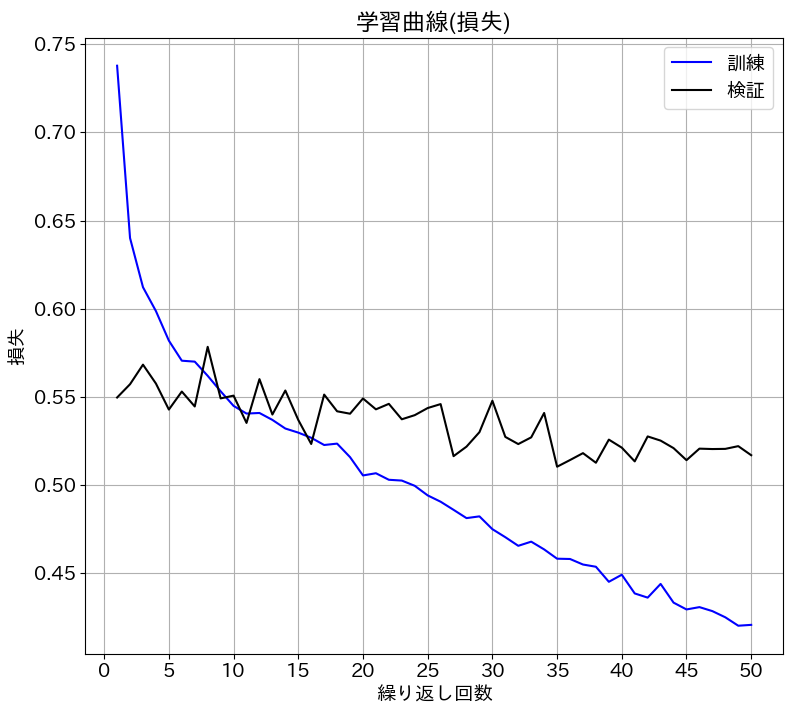

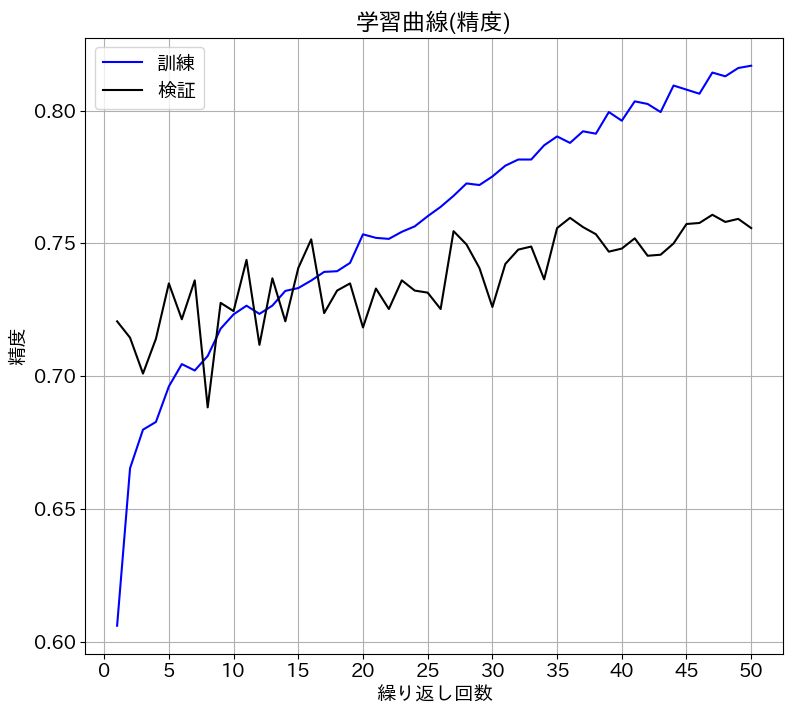

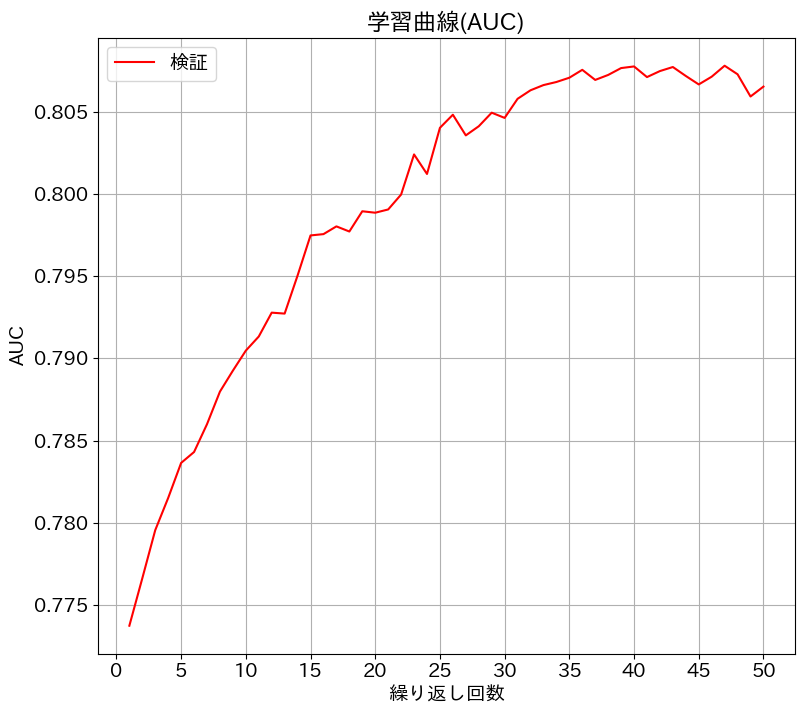

In [24]:
evaluate_history(each_history[0,:,:])

In [16]:
# np.save('../result/camel_3_cv_5_epoch_10.npy',each_history)

In [17]:
# np.save('../result/camel_3_cv_5_cv_hisotry.npy', cv_history)

In [18]:
# torch.save(net.state_dict(), '../model_weight.pth')

In [19]:
# cv_history = np.zeros((0,0,5))
# cv_history.shape

In [20]:
# cv_history = np.zeros((0,5))


In [21]:
# cv_cnt = 1
# num_epoch = 10
# each_history = np.zeros((0,num_epoch,5))
# history = np.zeros((0,5))
# item = np.arange(5).reshape(1,5)
# history = np.vstack((history, item))
# history
# history = np.arange(num_epoch*5).reshape((num_epoch,5))
# each_history = np.vstack((each_history, [history]))
# each_history

In [22]:
# history = np.arange(num_epoch*5).reshape((num_epoch,5))
# each_history = np.vstack((each_history, [history]))
# each_history

In [23]:
# history = np.zeros((0,5))
# history